In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_swiss_roll

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_train = x_train / 255
x_test = np.reshape(x_test, (-1, 784))
x_test = x_test / 255
x_train = tf.convert_to_tensor(x_train, dtype='float32')
x_test = tf.convert_to_tensor(x_test, dtype = 'float32')
y_train_ohe = tf.keras.utils.to_categorical(y_train)
y_test_ohe = tf.keras.utils.to_categorical(y_test)
batch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_ohe))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [63]:
class AAE(tf.keras.Model):
    def __init__(self, n_layers, n_nodes, n_components, input_dim, prior_distribution = 'gaussian'):
        super(AAE, self).__init__()
        self.n_layers = n_layers
        self.n_nodes = n_nodes
        self.n_components = n_components
        self.input_dim = input_dim
        if prior_distribution not in ['gaussian', 'roll']:
            raise ValueError('prior must be gaussian or roll')
        else:
            self.prior_distribution = prior_distribution
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[self.input_dim])
        ] + [
            tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42)) for _ in range(self.n_layers)
        ] + [
            tf.keras.layers.Dense(self.n_components, activation = 'linear', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42))
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[self.n_components])
        ] + [
            tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42)) for _ in range(self.n_layers)
        ] + [
            tf.keras.layers.Dense(self.input_dim, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42))
        ])
        
        self.discriminator_z = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = [self.n_components]),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_1'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_2'),
                tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_output')
            ])

    @tf.function
    def encode(self, x):
        latent_z = self.encoder(x)
        return latent_z

    @tf.function
    def discriminate_z(self, z):
        output = self.discriminator_z(z)
        return output

    @tf.function
    def decode(self,z):
        reconstruction = self.decoder(z)
        return reconstruction
    
def compute_reconstruction_loss(x, reconstruction):
    reconstruction_loss = tf.reduce_mean(tf.math.squared_difference(x, reconstruction)) / 2.
    return reconstruction_loss

def compute_discriminator_loss(fake_logit, true_logit):
    d_loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=true_logit,
                                                                         labels=tf.ones_like(true_logit)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logit,
                                                                         labels=tf.zeros_like(fake_logit)))
    discriminator_loss = d_loss_true + d_loss_fake
    return discriminator_loss

def compute_generator_loss(fake_output):
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                            labels=tf.ones_like(fake_output)))
    return generator_loss

@tf.function
def train_step(model, x, r_optimizer, d_optimizer, g_optimizer):
    # reconstruction
    with tf.GradientTape() as tape:
        latent_z = model.encode(x)
        reconstruction = model.decode(latent_z)
        reconstruction_loss = compute_reconstruction_loss(x, reconstruction)
    r_gradients = tape.gradient(reconstruction_loss, model.trainable_variables)
    r_optimizer.apply_gradients(zip(r_gradients, model.trainable_variables))
    
    #adversarial_z
    model.discriminator_z.trainable = True
    model.encoder.trainable = False
    if model.prior_distribution == 'gaussian':
        true_output_z = tf.random.normal(shape=(latent_z.shape), stddev = 1., seed = 42) * 5.
    if model.prior_distribution == 'roll':
        true_output_z = tf.convert_to_tensor(make_swiss_roll(n_samples=x.shape[0], noise=.1, random_state=42)[0][:,[0,2]], dtype = 'float32')
    with tf.GradientTape() as tape:
        latent_z = model.encode(x)
        fake_z_logit = model.discriminate_z(latent_z)
        true_z_logit = model.discriminate_z(true_output_z)
        discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    d_gradients = tape.gradient(discriminator_z_loss, model.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, model.trainable_variables))

    # generator_z
    model.discriminator_z.trainable = False
    model.encoder.trainable = True 
    with tf.GradientTape() as tape:
        latent_z = model.encode(x)
        fake_z_output = model.discriminate_z(latent_z)
        generator_z_loss = compute_generator_loss(fake_z_output)
    g_gradients = tape.gradient(generator_z_loss, model.trainable_variables)
    g_optimizer.apply_gradients(zip(g_gradients, model.trainable_variables))

    return reconstruction_loss, discriminator_z_loss, generator_z_loss          

@tf.function
def test_step(model, x):
    latent_z = model.encode(x)
    reconstruction = model.decode(latent_z)
    reconstruction_loss = compute_reconstruction_loss(x, reconstruction)
    if model.prior_distribution == 'gaussian':
        true_output_z = tf.random.normal(shape=(latent_z.shape), stddev = 1., seed = 42) * 5.
    if model.prior_distribution == 'roll':
        true_output_z = tf.convert_to_tensor(make_swiss_roll(n_samples=x.shape[0], noise=.1, random_state=42)[0][:,[0,2]], dtype = 'float32')
    fake_z_logit = model.discriminate_z(latent_z)
    true_z_logit = model.discriminate_z(true_output_z)
    discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    generator_z_loss = compute_generator_loss(fake_z_logit)
    return reconstruction_loss, discriminator_z_loss, generator_z_loss

In [46]:
aae = AAE(2, 1000, 2, len(x_train[0]), prior_distribution = 'roll')

r_optimizer = tf.keras.optimizers.SGD(learning_rate = .001, momentum = .9)
d_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)
g_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)

In [ ]:
latent_history = []
for i in tqdm(range(5000)):
    if i == 49:
        r_optimizer.lr = .0001
        d_optimizer.lr = .001
        g_optimizer.lr = .001
    elif i == 999:
        r_optimizer.lr = .00001
        d_optimizer.lr = .0001
        g_optimizer.lr = .0001
    rl, dl, gl = [], [], []
    for x_batch_train, y_batch_train in train_dataset:
        r, d, g = train_step(aae, x_batch_train, r_optimizer, d_optimizer, g_optimizer)
        rl.append(r)
        dl.append(d)
        gl.append(g)
    t_r, t_d, t_g = test_step(aae, x_test)
    rl = np.mean(rl)
    dl = np.mean(dl)
    gl = np.mean(gl)
    latent_history.append(aae.encode(x_test))
    print(f'epoch : {i} train set : [ reconstruction_loss : {rl}, discriminator_loss : {dl}, generator_loss : {gl}]\n test set : [ reconstruction_loss : {t_r}, discriminator_loss : {t_d}, generator_loss : {t_g}]')

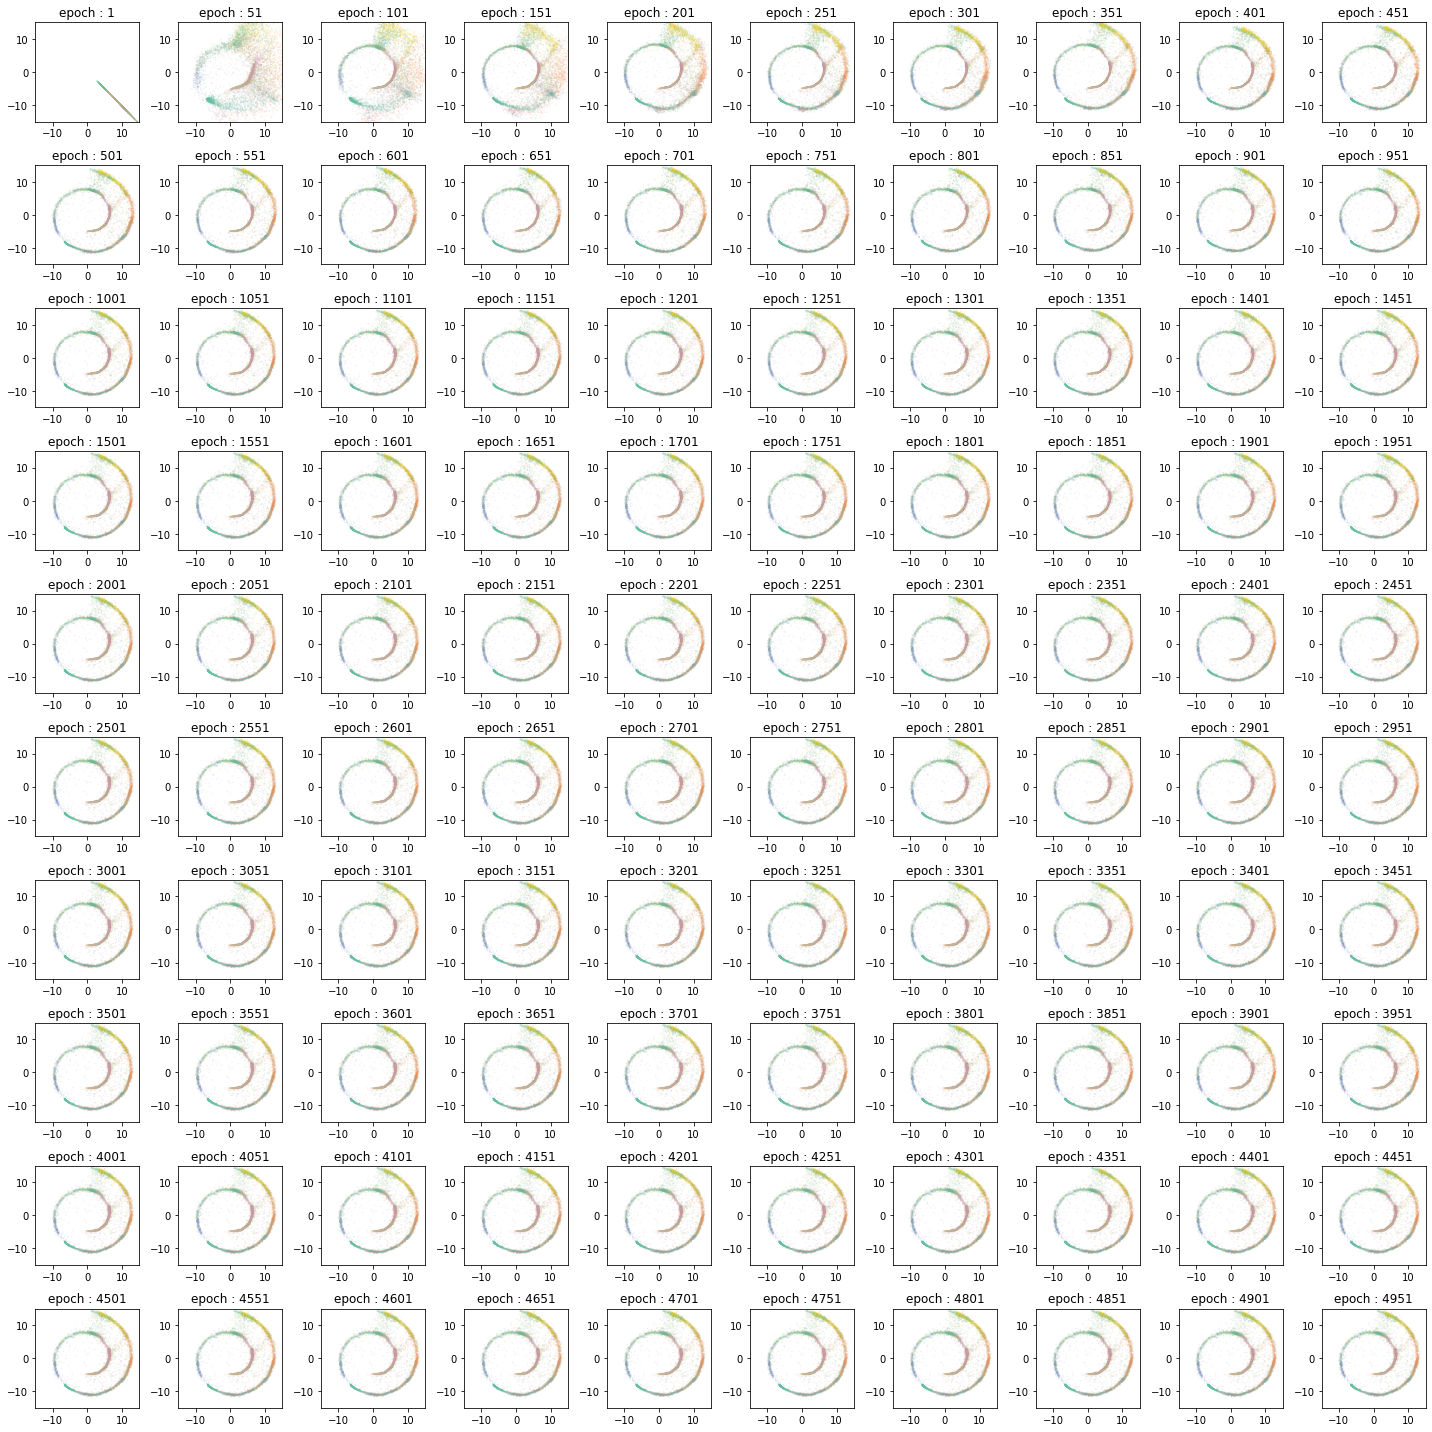

In [51]:
fig, ax = plt.subplots(10, 10, figsize = (20,20))
for i in range(100):
    ax[i//10, i%10].scatter(latent_history[i * 50][:,0], latent_history[i * 50][:,1], c = y_test, cmap = plt.cm.Set2, alpha = .7, s = .01)
    ax[i//10, i%10].set_title(f'epoch : {(i * 50) + 1}')
    ax[i//10, i%10].set_xlim(-15,15)
    ax[i//10, i%10].set_ylim(-15,15)
plt.tight_layout()

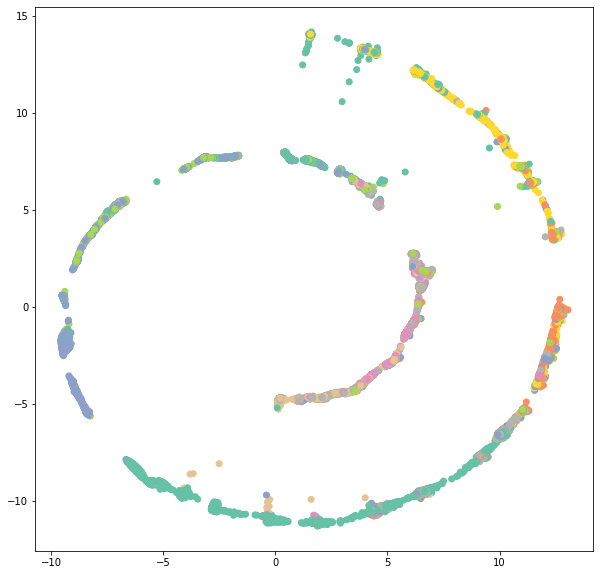

In [58]:
fig, ax = plt.subplots(figsize = (10, 10))
latent_z = aae.encode(x_train)
ax.scatter(latent_z[:,0], latent_z[:,1], c = y_train, cmap = plt.cm.Set2)

In [64]:
aae = AAE(2, 1000, 2, len(x_train[0]), prior_distribution = 'gaussian')

r_optimizer = tf.keras.optimizers.SGD(learning_rate = .001, momentum = .9)
d_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)
g_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)

In [ ]:
latent_history = []
for i in tqdm(range(1000)):
    if i == 49:
        r_optimizer.lr = .0001
        d_optimizer.lr = .001
        g_optimizer.lr = .001
    elif i == 999:
        r_optimizer.lr = .00001
        d_optimizer.lr = .0001
        g_optimizer.lr = .0001
    rl, dl, gl = [], [], []
    for x_batch_train, y_batch_train in train_dataset:
        r, d, g = train_step(aae, x_batch_train, r_optimizer, d_optimizer, g_optimizer)
        rl.append(r)
        dl.append(d)
        gl.append(g)
    t_r, t_d, t_g = test_step(aae, x_test)
    rl = np.mean(rl)
    dl = np.mean(dl)
    gl = np.mean(gl)
    latent_history.append(aae.encode(x_test))
    print(f'epoch : {i} train set : [ reconstruction_loss : {rl}, discriminator_loss : {dl}, generator_loss : {gl}]\n test set : [ reconstruction_loss : {t_r}, discriminator_loss : {t_d}, generator_loss : {t_g}]')

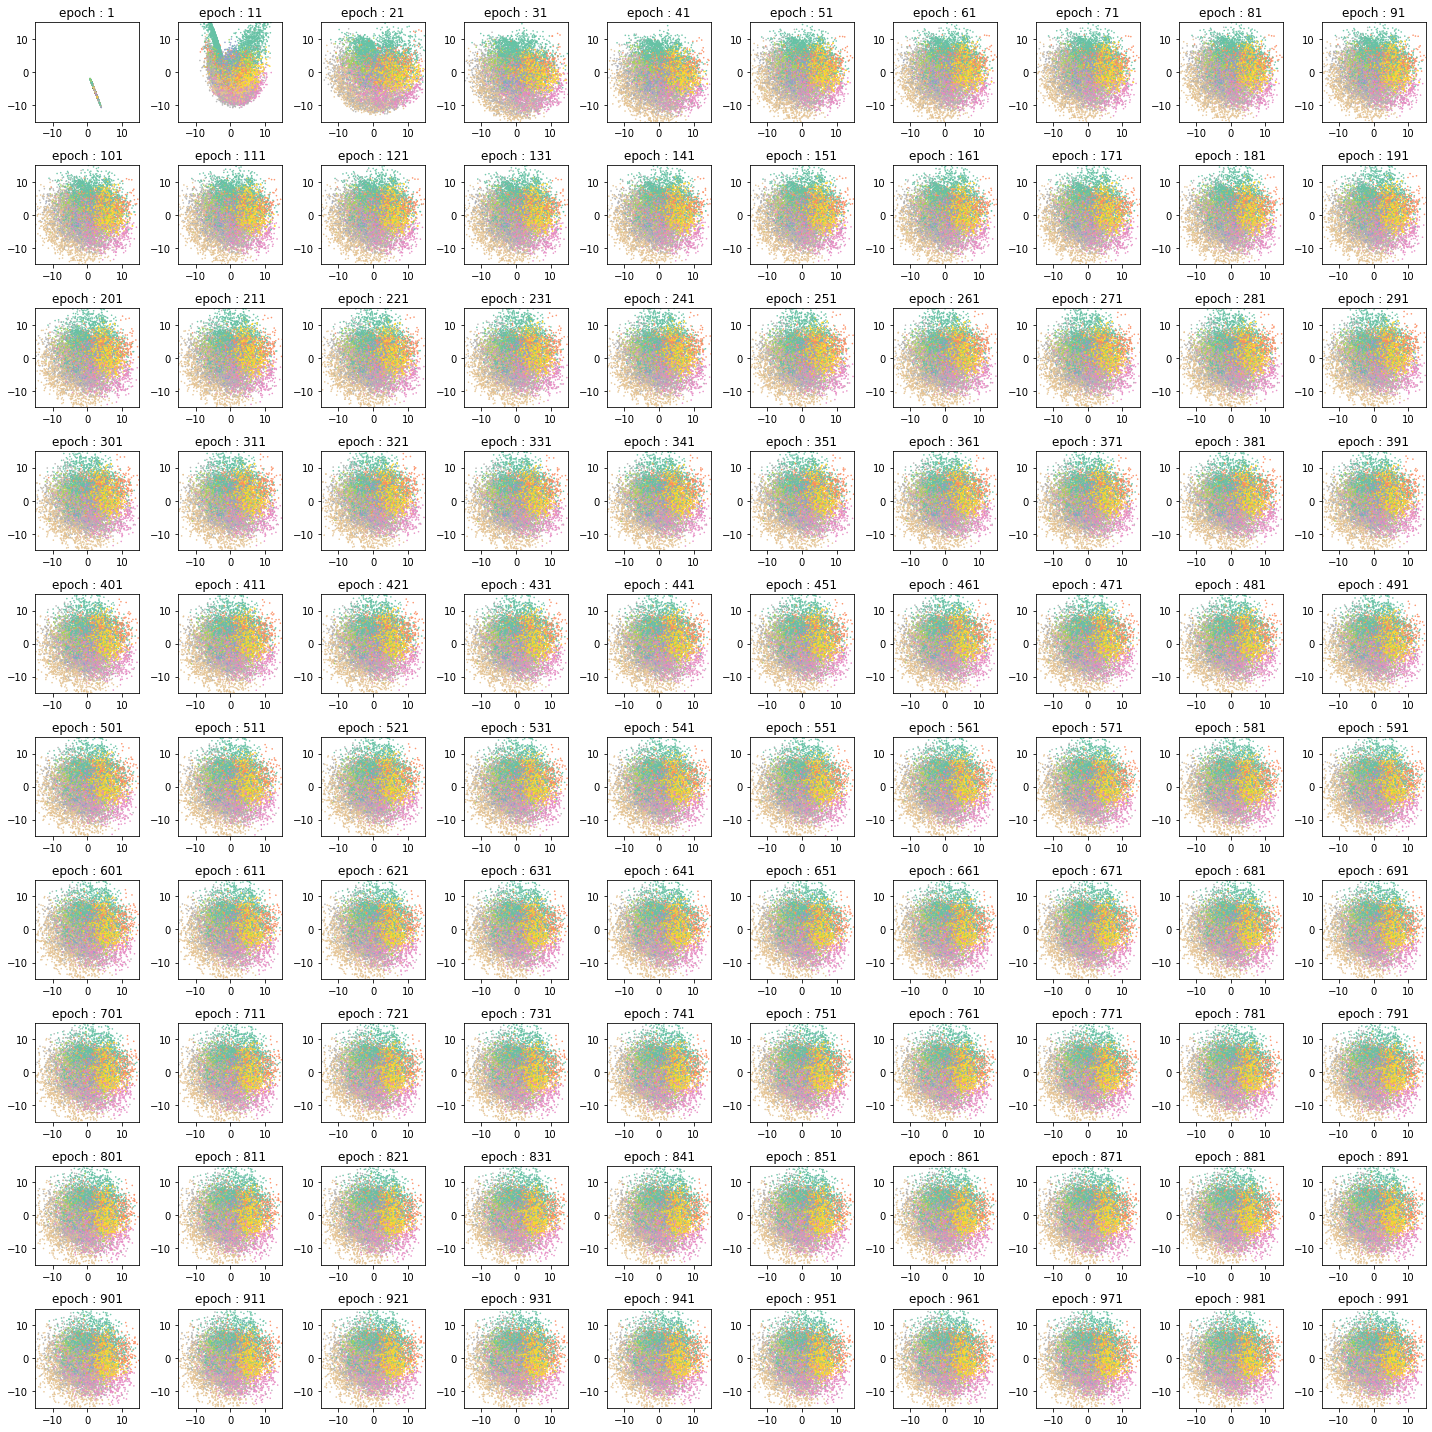

In [75]:
fig, ax = plt.subplots(10, 10, figsize = (20,20))
for i in range(100):
    ax[i//10, i%10].scatter(latent_history[i * 10][:,0], latent_history[i * 10][:,1], c = y_test, cmap = plt.cm.Set2, s = .3)
    ax[i//10, i%10].set_title(f'epoch : {(i * 10) + 1}')
    ax[i//10, i%10].set_xlim(-15,15)
    ax[i//10, i%10].set_ylim(-15,15)
plt.tight_layout()

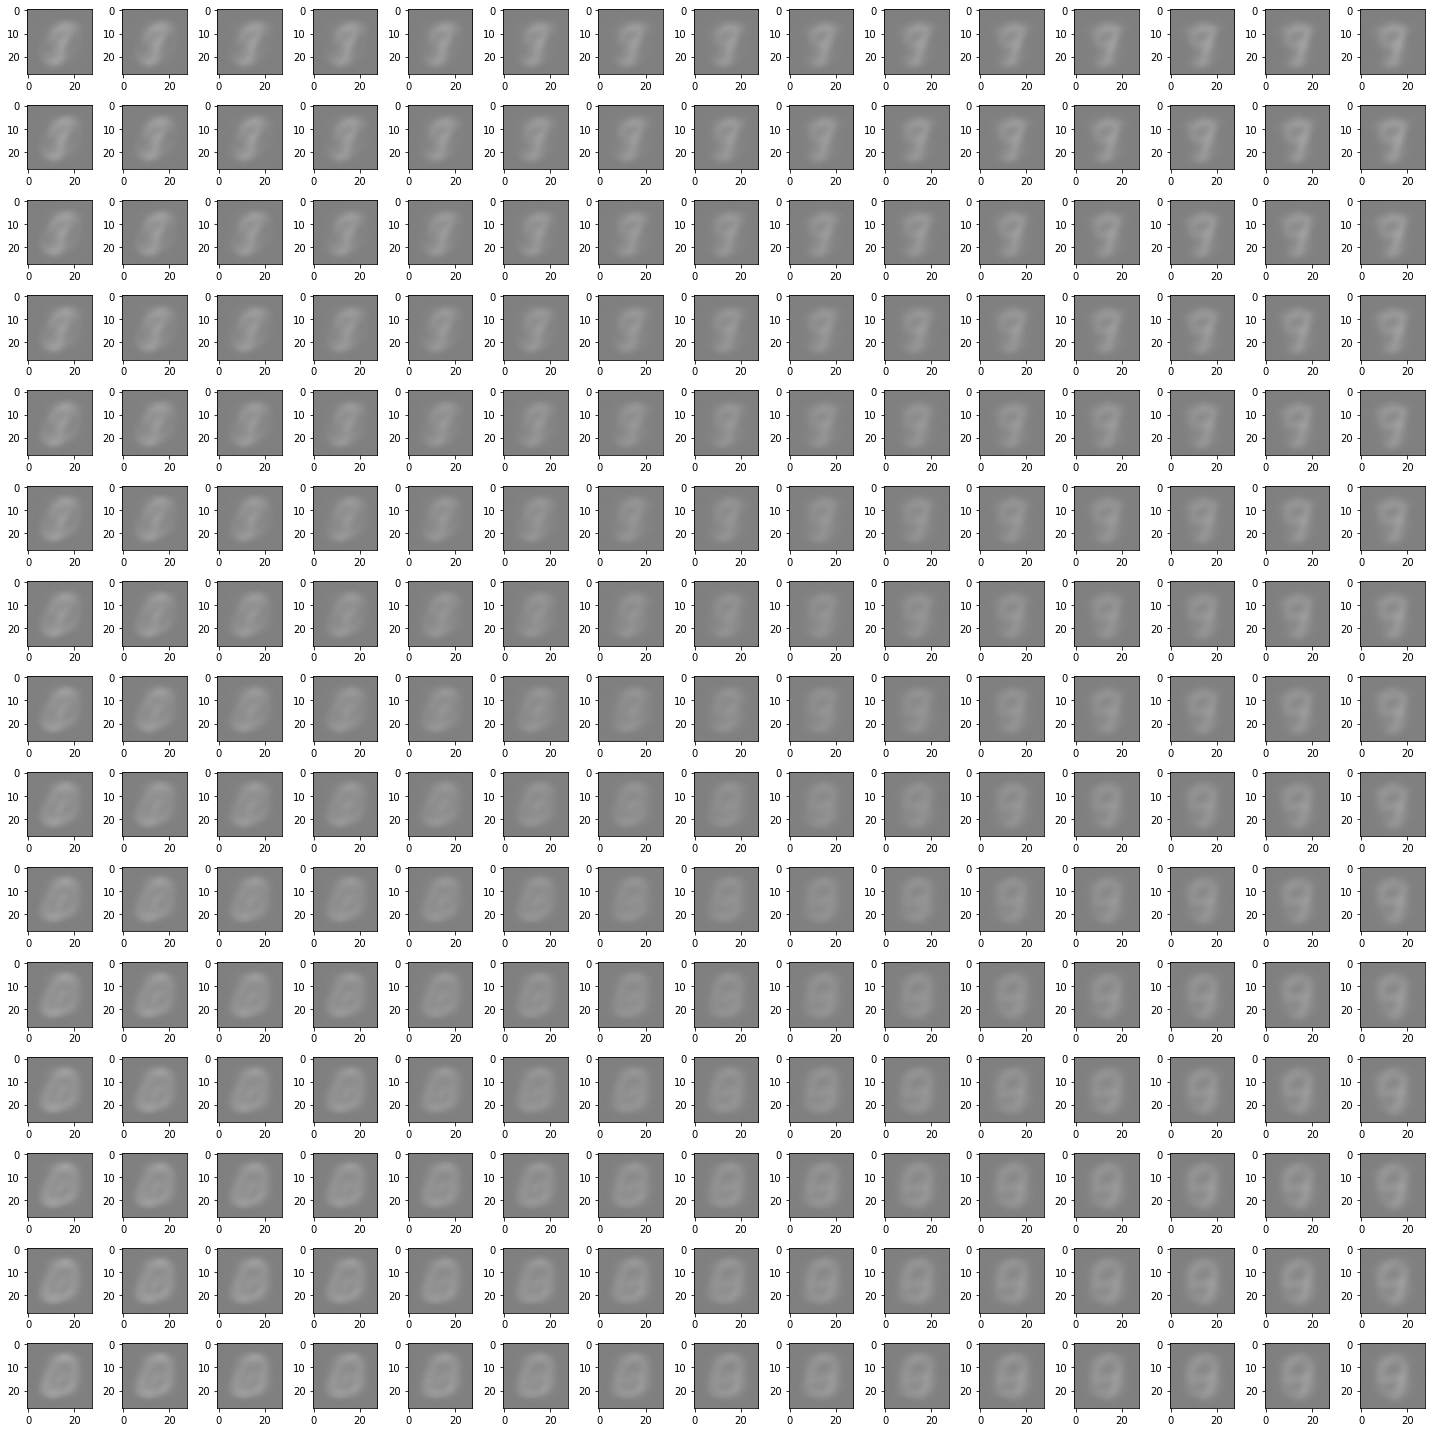

In [91]:
latent = tf.convert_to_tensor([[x,y] for x in np.linspace(-3, 3, 15) for y in np.linspace(3, -3, 15)], dtype = 'float32')
res = tf.math.sigmoid(aae.decode(latent))
res = tf.reshape(res, shape = (15*15, 28, 28)).numpy()

fig, ax = plt.subplots(15, 15, figsize = (20,20))
for i in range(15*15):
    ax[i//15, i%15].imshow(res[i], cmap = 'gist_gray', vmin=0, vmax=1.)
plt.tight_layout()

In [91]:
class lr_AAE(tf.keras.Model):
    def __init__(self, n_layers, n_nodes, n_components, input_dim, n_categories, prior_distribution = 'gaussian'):
        super(lr_AAE, self).__init__()
        self.n_layers = n_layers
        self.n_nodes = n_nodes
        self.n_components = n_components
        self.n_categories = n_categories
        self.input_dim = input_dim
        if prior_distribution not in ['gaussian', 'roll']:
            raise ValueError('prior must be gaussian or roll')
        else:
            self.prior_distribution = prior_distribution
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[self.input_dim])
        ] + [
            tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42)) for _ in range(self.n_layers)
        ] + [
            tf.keras.layers.Dense(self.n_components, activation = 'linear', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42))
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[self.n_components])
        ] + [
            tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42)) for _ in range(self.n_layers)
        ] + [
            tf.keras.layers.Dense(self.input_dim, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42))
        ])
        
        self.discriminator_z = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = [self.n_components + self.n_categories]),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_1'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_2'),
                tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_output')
            ])

    @tf.function
    def encode(self, x):
        latent_z = self.encoder(x)
        return latent_z

    @tf.function
    def discriminate_z(self, z, y):
        inputs = tf.concat([z,y], axis = 1)
        output = self.discriminator_z(inputs)
        return output

    @tf.function
    def decode(self,z):
        reconstruction = self.decoder(z)
        return reconstruction
    
def compute_reconstruction_loss(x, reconstruction):
    reconstruction_loss = tf.reduce_mean(tf.math.squared_difference(x, reconstruction)) / 2.
    return reconstruction_loss

def compute_discriminator_loss(fake_logit, true_logit):
    d_loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=true_logit,
                                                                         labels=tf.ones_like(true_logit)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logit,
                                                                         labels=tf.zeros_like(fake_logit)))
    discriminator_loss = d_loss_true + d_loss_fake
    return discriminator_loss

def compute_generator_loss(fake_output):
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                            labels=tf.ones_like(fake_output)))
    return generator_loss

@tf.function
def train_step(model, x, y, r_optimizer, d_optimizer, g_optimizer):
    # reconstruction
    with tf.GradientTape() as tape:
        latent_z = model.encode(x)
        reconstruction = model.decode(latent_z)
        reconstruction_loss = compute_reconstruction_loss(x, reconstruction)
    r_gradients = tape.gradient(reconstruction_loss, model.trainable_variables)
    r_optimizer.apply_gradients(zip(r_gradients, model.trainable_variables))
    
    #adversarial_z
    model.discriminator_z.trainable = True
    model.encoder.trainable = False
    if model.prior_distribution == 'gaussian':
        true_output_z = tf.random.normal(shape=(latent_z.shape), stddev = 1., seed = 42) * 5.
    if model.prior_distribution == 'roll':
        temp_z, temp_y = make_swiss_roll(n_samples=x.shape[0], noise=.1, random_state=42)
        true_output_z = tf.convert_to_tensor(temp_z[:,[0,2]], dtype = 'float32')
        y_true = tf.keras.utils.to_categorical(np.digitize(temp_y, np.linspace(4.712441162324161, 14.137091941626444, 10)) - 1,num_classes=10) 
    with tf.GradientTape() as tape:
        latent_z = model.encode(x)
        fake_z_logit = model.discriminate_z(latent_z, y)
        true_z_logit = model.discriminate_z(true_output_z, y_true)
        discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    d_gradients = tape.gradient(discriminator_z_loss, model.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, model.trainable_variables))

    # generator_z
    model.discriminator_z.trainable = False
    model.encoder.trainable = True 
    with tf.GradientTape() as tape:
        latent_z = model.encode(x)
        fake_z_output = model.discriminate_z(latent_z, y)
        generator_z_loss = compute_generator_loss(fake_z_output)
    g_gradients = tape.gradient(generator_z_loss, model.trainable_variables)
    g_optimizer.apply_gradients(zip(g_gradients, model.trainable_variables))

    return reconstruction_loss, discriminator_z_loss, generator_z_loss          

@tf.function
def test_step(model, x, y):
    latent_z = model.encode(x)
    reconstruction = model.decode(latent_z)
    reconstruction_loss = compute_reconstruction_loss(x, reconstruction)
    if model.prior_distribution == 'gaussian':
        true_output_z = tf.random.normal(shape=(latent_z.shape), stddev = 1., seed = 42) * 5.
    if model.prior_distribution == 'roll':
        temp_z, temp_y = make_swiss_roll(n_samples=x.shape[0], noise=.1, random_state=42)
        true_output_z = tf.convert_to_tensor(temp_z[:,[0,2]], dtype = 'float32')
        y_true = tf.keras.utils.to_categorical(np.digitize(temp_y, np.linspace(4.712441162324161, 14.137091941626444, 10)) - 1,num_classes=10) 
    fake_z_logit = model.discriminate_z(latent_z, y)
    true_z_logit = model.discriminate_z(true_output_z, y_true)
    discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    generator_z_loss = compute_generator_loss(fake_z_logit)
    return reconstruction_loss, discriminator_z_loss, generator_z_loss

In [92]:
lr_aae = lr_AAE(2, 1000, 2, len(x_train[0]), 10, prior_distribution = 'roll')

r_optimizer = tf.keras.optimizers.SGD(learning_rate = .001, momentum = .9)
d_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)
g_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)

In [ ]:
latent_history = []
for i in tqdm(range(1000)):
    if i == 49:
        r_optimizer.lr = .0001
        d_optimizer.lr = .001
        g_optimizer.lr = .001
    elif i == 999:
        r_optimizer.lr = .00001
        d_optimizer.lr = .0001
        g_optimizer.lr = .0001
    rl, dl, gl = [], [], []
    for x_batch_train, y_batch_train in train_dataset:
        r, d, g = train_step(lr_aae, x_batch_train, y_batch_train, r_optimizer, d_optimizer, g_optimizer)
        rl.append(r)
        dl.append(d)
        gl.append(g)
    t_r, t_d, t_g = test_step(lr_aae, x_test, y_test_ohe)
    rl = np.mean(rl)
    dl = np.mean(dl)
    gl = np.mean(gl)
    latent_history.append(lr_aae.encode(x_test))
    print(f'epoch : {i} train set : [ reconstruction_loss : {rl}, discriminator_loss : {dl}, generator_loss : {gl}]\n test set : [ reconstruction_loss : {t_r}, discriminator_loss : {t_d}, generator_loss : {t_g}]')

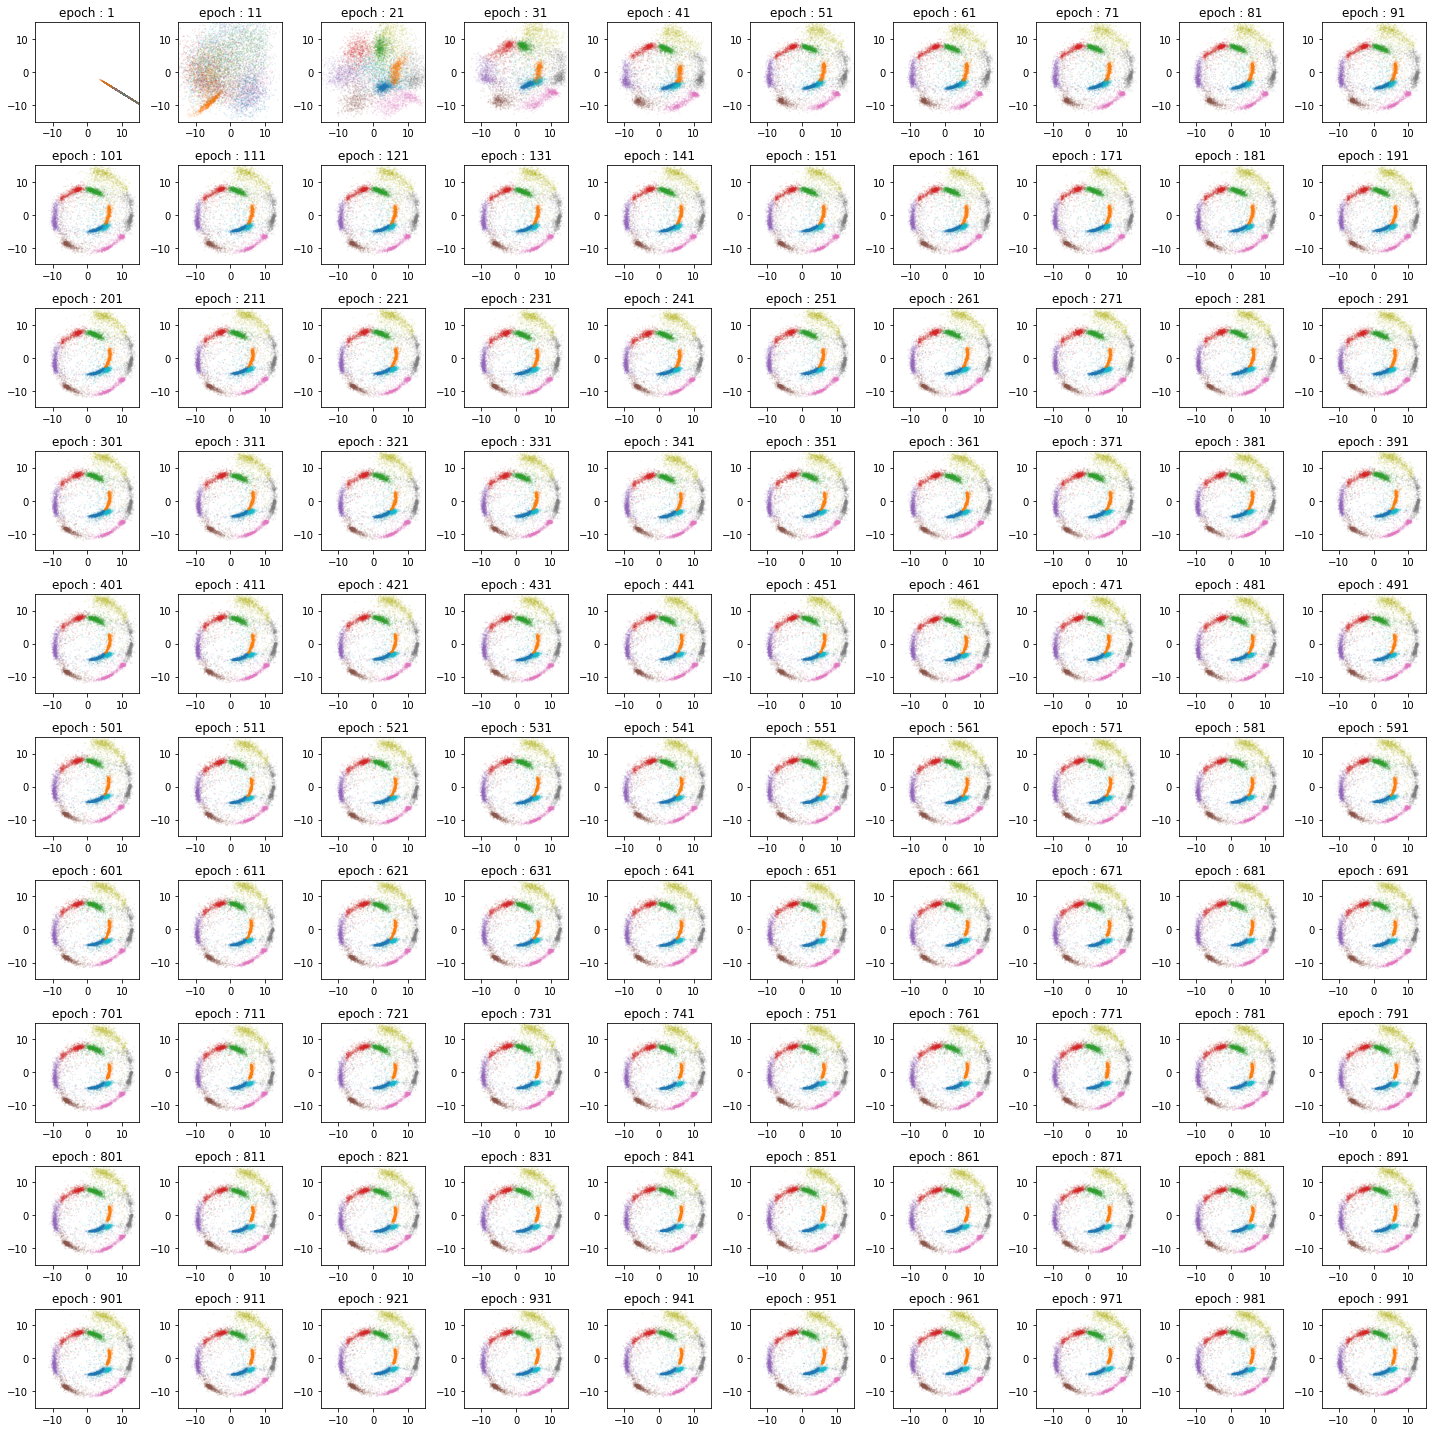

In [107]:
fig, ax = plt.subplots(10, 10, figsize = (20,20))
for i in range(100):
    ax[i//10, i%10].scatter(latent_history[i * 10][:,0], latent_history[i * 10][:,1], c = y_test, cmap = plt.cm.tab10, alpha = .7, s = .01)
    ax[i//10, i%10].set_title(f'epoch : {(i * 10) + 1}')
    ax[i//10, i%10].set_xlim(-15,15)
    ax[i//10, i%10].set_ylim(-15,15)
plt.tight_layout()

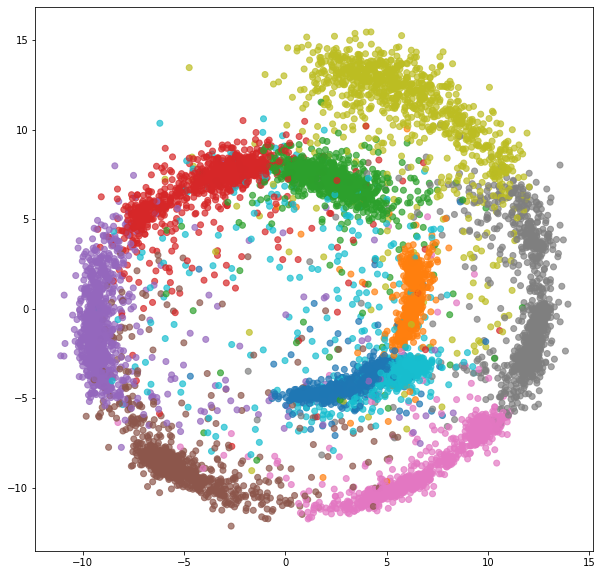

In [111]:
fig, ax = plt.subplots(figsize = (10, 10))
latent_z = lr_aae.encode(x_test)
ax.scatter(latent_z[:,0], latent_z[:,1], c = y_test, cmap = plt.cm.tab10, alpha = .7)

In [73]:
class SSAAE(tf.keras.Model):
    def __init__(self, n_nodes, n_components, input_dim, n_categories, gaussian_noise:bool = True, stddev:float = .3, dropout:bool = False, dropout_rate:float = .2, batch_normalization:bool = False):
        super(SSAAE, self).__init__()
        self.n_nodes = n_nodes
        self.n_components = n_components
        self.input_dim = input_dim
        self.n_categories = n_categories
        self.gaussian_noise = gaussian_noise
        self.dropout = dropout
        self.stddev = stddev
        self.dropout_rate = dropout_rate
        self.batch_normalization = batch_normalization
        self.acc = tf.keras.metrics.Accuracy()
        
        #encoder
        encoder_input = tf.keras.layers.Input(shape = [self.input_dim], name = 'encoder_input')
        if self.gaussian_noise:
            encoder_hidden = tf.keras.layers.GaussianNoise(stddev = self.stddev, name = 'gaussian_noise')(encoder_input)
        if self.dropout:
            encoder_hidden = tf.keras.layers.Dropout(rate = self.dropout_rate, name = 'dropout')(encoder_input)
        if self.batch_normalization:
            encoder_hidden = tf.keras.layers.BatchNormalization()(encoder_hidden)
        encoder_hidden = tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 42), name = 'encoder_hidden_1')(encoder_hidden)
        if self.batch_normalization:
            encoder_hidden = tf.keras.layers.BatchNormalization()(encoder_hidden)
        encoder_hidden = tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 42), name = 'encoder_hidden_2')(encoder_hidden)
        if self.batch_normalization:
            encoder_hidden = tf.keras.layers.BatchNormalization()(encoder_hidden)
        latent_z = tf.keras.layers.Dense(self.n_components, activation = 'linear', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 42), name = 'latent_z')(encoder_hidden)
        latent_y = tf.keras.layers.Dense(self.n_categories, activation = 'softmax', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 42), name = 'latent_y')(encoder_hidden)
        self.encoder = tf.keras.Model(inputs = [encoder_input], outputs = [latent_z, latent_y])
        
        #decoder
        decoder_input = tf.keras.layers.Input(shape = [self.n_components + self.n_categories], name = 'decoder_input')
        if self.batch_normalization:
            decoder_input = tf.keras.layers.BatchNormalization()(decoder_input)
        decoder_hidden = tf.keras.layers.Dense(self.n_components, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 42), name = 'decoder_hidden_1')(decoder_input)
        if self.batch_normalization:
            decoder_hidden = tf.keras.layers.BatchNormalization()(decoder_hidden)
        decoder_hidden = tf.keras.layers.Dense(self.n_components, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 42), name = 'decoder_hidden_2')(decoder_hidden)
        if self.batch_normalization:
            decoder_hidden = tf.keras.layers.BatchNormalization()(decoder_hidden)
        reconstruction = tf.keras.layers.Dense(self.input_dim, kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 42), name = 'reconstruction')(decoder_hidden)
        self.decoder = tf.keras.Model(inputs = [decoder_input], outputs = [reconstruction])
        
        #discriminator_z
        self.discriminator_z = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = [self.n_components], name = 'discriminator_z_input'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_1'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_2'),
                tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_output')
            ])
        
        #discriminator_y
        self.discriminator_y = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = [self.n_categories], name = 'discriminator_y_input'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_y_1'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_y_2'),
                tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_y_output')
            ])
    
    #define forward propagation functions
    @tf.function
    def encode(self, x, training = False):
        latent_z, latent_y = self.encoder(x, training = training)
        return latent_z, latent_y
    
    @tf.function
    def decode(self, z, y):
        inputs = tf.concat([z, y], axis = 1)
        reconstruction = self.decoder(inputs)
        return reconstruction

    @tf.function
    def discriminate_z(self, z):
        output = self.discriminator_z(z)
        return output
    
    @tf.function
    def discriminate_y(self, y):
        output = self.discriminator_y(y)
        return output

#define loss computing functions
def compute_reconstruction_loss(x, reconstruction):
    reconstruction_loss = tf.reduce_mean(tf.math.squared_difference(x, reconstruction)) / 2.
    return reconstruction_loss

def compute_discriminator_loss(fake_logit, true_logit):
    d_loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=true_logit,
                                                                         labels=tf.ones_like(true_logit)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logit,
                                                                         labels=tf.zeros_like(fake_logit)))
    discriminator_loss = d_loss_true + d_loss_fake
    return discriminator_loss

def compute_generator_loss(fake_output):
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                            labels=tf.ones_like(fake_output)))
    return generator_loss

def compute_classification_loss(x, y):
    classification_loss = tf.reduce_mean(K.categorical_crossentropy(target = x, output = y))
    return classification_loss

    
#define train function
@tf.function
def train_step(model, x, x_labled, x_unlabled, y, y_unlabled, true_output_y, r_optimizer, d_optimizer, g_optimizer, ss_optimizer):
    # reconstruction
    with tf.GradientTape() as tape:
        latent_z, latent_y = model.encode(x_unlabled, True)
        reconstruction = model.decode(latent_z, latent_y)
        reconstruction_loss = compute_reconstruction_loss(x_unlabled, reconstruction)
    r_gradients = tape.gradient(reconstruction_loss, model.trainable_variables)
    r_optimizer.apply_gradients(zip(r_gradients, model.trainable_variables))
    
    #adversarial
    model.discriminator_z.trainable = True
    model.discriminator_y.trainable = True
    model.encoder.trainable = False
    true_output_z = tf.random.normal(shape=(latent_z.shape), stddev = 1., seed = 42)
    latent_z, latent_y = model.encode(x, True)
    #z
    with tf.GradientTape() as tape:
        fake_z_logit = model.discriminate_z(latent_z)
        true_z_logit = model.discriminate_z(true_output_z)
        discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    d_gradients = tape.gradient(discriminator_z_loss, model.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, model.trainable_variables))
    #y
    with tf.GradientTape() as tape:
        fake_y_logit = model.discriminate_y(latent_y)
        true_y_logit = model.discriminate_y(true_output_y)
        discriminator_y_loss = compute_discriminator_loss(fake_y_logit, true_y_logit)
    d_gradients = tape.gradient(discriminator_y_loss, model.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, model.trainable_variables))

    # generator
    model.discriminator_z.trainable = False
    model.discriminator_y.trainable = False
    model.encoder.trainable = True 
    with tf.GradientTape() as tape:
        latent_z, latent_y = model.encode(x, True)
        fake_z_output = model.discriminate_z(latent_z)
        generator_z_loss = compute_generator_loss(fake_z_output)
        fake_y_output = model.discriminate_y(latent_y)
        generator_y_loss = compute_generator_loss(fake_y_output)
    g_gradients = tape.gradient([generator_z_loss, generator_y_loss], model.trainable_variables)
    g_optimizer.apply_gradients(zip(g_gradients, model.trainable_variables))

    #ss_classification
    with tf.GradientTape() as tape:
        _, latent_y = model.encode(x_labled, True)
        classification_loss = compute_classification_loss(y_labled, latent_y)
    ss_gradients = tape.gradient(classification_loss, model.trainable_variables)
    ss_optimizer.apply_gradients(zip(ss_gradients, model.trainable_variables))
    
    return reconstruction_loss, discriminator_z_loss, discriminator_y_loss, generator_z_loss, generator_y_loss, classification_loss         

#define test function
@tf.function
def test_step(model, x, y, true_output_y):
    latent_z, latent_y = model.encode(x)
    reconstruction = model.decode(latent_z, latent_y)
    reconstruction_loss = compute_reconstruction_loss(x, reconstruction)
    
    true_output_z = tf.random.normal(shape=(latent_z.shape), seed = 42)
    fake_z_logit = model.discriminate_z(latent_z)
    true_z_logit = model.discriminate_z(true_output_z)
    fake_y_logit = model.discriminate_y(latent_y)
    true_y_logit = model.discriminate_y(true_output_y)
    discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    discriminator_y_loss = compute_discriminator_loss(fake_y_logit, true_y_logit)
    generator_z_loss = compute_generator_loss(fake_z_logit)
    generator_y_loss = compute_generator_loss(fake_y_logit)
    
    classification_loss = compute_classification_loss(y, latent_y)
    accuracy = model.acc(tf.argmax(y, axis = 1), tf.argmax(latent_y, axis = 1))
    
    return reconstruction_loss, discriminator_z_loss, discriminator_y_loss, generator_z_loss, generator_y_loss, classification_loss, accuracy

In [74]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
color = y_test
x_train = np.reshape(x_train, (-1, 784))
x_train = x_train / 255

y_train = y_train.astype('float32')
# 97%를 na로 날림
for i in range(600):
    y_train[i * 100:(i*100)+97] = np.nan
    
#cat(y)
idx, counts = np.unique(y_train[~np.isnan(y_train)], return_counts = True)
y_prob = counts / counts.sum()
y_train = tf.convert_to_tensor(y_train, dtype = 'float32')

x_test = np.reshape(x_test, (-1, 784))
x_test = x_test / 255
x_train = tf.convert_to_tensor(x_train, dtype='float32')
x_test = tf.convert_to_tensor(x_test, dtype = 'float32')
y_test = tf.convert_to_tensor(pd.get_dummies(y_test), dtype = 'float32')

#1000units, 10-D latent z, inputdim, number of categores, add gaussian noise to input layer
ssaae = SSAAE(1000, 10, x_train.shape[1], 10, gaussian_noise= True)

#appendix 그대로 넣었더니 발산해서 1/10으로 줄임
r_optimizer = tf.keras.optimizers.SGD(learning_rate = .001, momentum = .9)
ss_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .9)
d_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)
g_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)

In [75]:
latent_y_history = []
latent_z_history = []
rh = []
dzh = []
dyh = []
gzh = []
gyh = []
ssch = []

y_categories = 10
    
for j in tqdm(range(500)):
    if j == 49:
        r_optimizer.lr  = .0001
        ss_optimizer.lr = .001
        d_optimizer.lr =.001
        g_optimizer.lr =.001
    
    reconstruction_loss, discriminator_z_loss, discriminator_y_loss, generator_z_loss, generator_y_loss, classification_loss = [],[],[],[],[],[]
    for i in range(600):
        #preprocessing 
        x_batch_train = x_train[i * 100:(i+1)*100]
        y_batch_train = y_train[i * 100:(i+1)*100]
        mask = tf.math.is_nan(y_batch_train)
        x_unlabled = tf.boolean_mask(x_batch_train, mask)
        x_labled = tf.boolean_mask(x_batch_train, ~mask)
        y_labled = tf.boolean_mask(y_batch_train, ~mask)
        y_labled = tf.keras.utils.to_categorical(y_labled, num_classes = y_categories)
        true_output_y = tf.keras.utils.to_categorical(np.random.choice(np.arange(y_categories), size = x_batch_train.shape[0], p = y_prob), num_classes = 10)
        
        #train
        r, dz, dy, gz, gy, s = train_step(ssaae, x_batch_train, x_labled, x_unlabled, y_batch_train, y_labled, true_output_y, r_optimizer, d_optimizer, g_optimizer, ss_optimizer)
        reconstruction_loss.append(r)
        discriminator_z_loss.append(dz)
        discriminator_y_loss.append(dy)
        generator_z_loss.append(gz)
        generator_y_loss.append(gy)
        classification_loss.append(s)
    
    #test
    true_output_y = tf.keras.utils.to_categorical(np.random.choice(np.arange(y_categories), size = x_batch_train.shape[0], p = y_prob), num_classes = y_categories)
    test_reconstruction, test_discriminator_z, test_discriminator_y, test_generator_z, test_generator_y, test_classification, test_accuracy = test_step(ssaae, x_test, y_test, true_output_y)
    reconstruction_loss = np.mean(reconstruction_loss)
    discriminator_z_loss = np.mean(discriminator_z_loss)
    discriminator_y_loss = np.mean(discriminator_y_loss)
    generator_z_loss = np.mean(generator_z_loss)
    generator_y_loss = np.mean(generator_y_loss)
    classification_loss = np.mean(classification_loss)
    
    rh.append(test_reconstruction)
    dzh.append(test_discriminator_z)
    dyh.append(test_discriminator_y)
    gzh.append(test_generator_z)
    gyh.append(test_generator_y)
    ssch.append(test_accuracy)
    
    z, y =ssaae.encode(x_test)
    latent_y_history.append(y)
    latent_z_history.append(z)
    print(f'epoch : {j + 1} train set : [ reconstruction_loss : {reconstruction_loss}, discriminator_z_loss : {discriminator_z_loss}, discriminator_y_loss : {discriminator_y_loss}, generator_z_loss : {generator_z_loss}, generator_y_loss : {generator_y_loss}, classification_loss : {classification_loss}]')
    print(f'epoch : {j + 1} test set : [ reconstruction_loss : {test_reconstruction}, discriminator_z_loss : {test_discriminator_z}, discriminator_y_loss : {test_discriminator_y}, generator_z_loss : {test_generator_z}, generator_y_loss : {test_generator_y}, classification_loss : {test_classification}, test_accuracy : {test_accuracy}]')

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

  0%|▏                                                                               | 1/500 [00:10<1:29:42, 10.79s/it]

epoch : 1 train set : [ reconstruction_loss : 0.05580879747867584, discriminator_z_loss : 1.357999324798584, discriminator_y_loss : 1.382917046546936, generator_z_loss : 0.7023351788520813, generator_y_loss : 0.6950158476829529, classification_loss : 1.1159999370574951]
epoch : 1 test set : [ reconstruction_loss : 0.056637682020664215, discriminator_z_loss : 1.3106985092163086, discriminator_y_loss : 1.3789408206939697, generator_z_loss : 0.7162724733352661, generator_y_loss : 0.6969152092933655, classification_loss : 5.469798564910889, test_accuracy : 0.1216999962925911]


  0%|▎                                                                               | 2/500 [00:21<1:27:20, 10.52s/it]

epoch : 2 train set : [ reconstruction_loss : 0.055471546947956085, discriminator_z_loss : 1.0381015539169312, discriminator_y_loss : 1.367659330368042, generator_z_loss : 0.8512086868286133, generator_y_loss : 0.7026163339614868, classification_loss : 1.0294647216796875]
epoch : 2 test set : [ reconstruction_loss : 0.0562962181866169, discriminator_z_loss : 0.6149522066116333, discriminator_y_loss : 1.3375120162963867, generator_z_loss : 1.1692546606063843, generator_y_loss : 0.7169875502586365, classification_loss : 5.435136795043945, test_accuracy : 0.11595000326633453]


  1%|▍                                                                               | 3/500 [00:31<1:26:07, 10.40s/it]

epoch : 3 train set : [ reconstruction_loss : 0.05513938143849373, discriminator_z_loss : 0.6754835844039917, discriminator_y_loss : 1.168341875076294, generator_z_loss : 1.602283000946045, generator_y_loss : 0.8340073823928833, classification_loss : 1.0292600393295288]
epoch : 3 test set : [ reconstruction_loss : 0.05595977231860161, discriminator_z_loss : 0.7484061121940613, discriminator_y_loss : 0.9139130711555481, generator_z_loss : 1.8902581930160522, generator_y_loss : 1.1540621519088745, classification_loss : 5.1302032470703125, test_accuracy : 0.11923333257436752]


  1%|▋                                                                               | 4/500 [00:40<1:22:11,  9.94s/it]

epoch : 4 train set : [ reconstruction_loss : 0.05481217801570892, discriminator_z_loss : 1.1991997957229614, discriminator_y_loss : 0.661027193069458, generator_z_loss : 1.2779408693313599, generator_y_loss : 1.4606870412826538, classification_loss : 1.0314351320266724]
epoch : 4 test set : [ reconstruction_loss : 0.055628638714551926, discriminator_z_loss : 1.1116539239883423, discriminator_y_loss : 0.5486969947814941, generator_z_loss : 0.9395655989646912, generator_y_loss : 1.7441256046295166, classification_loss : 4.676387786865234, test_accuracy : 0.12255000323057175]


  1%|▊                                                                               | 5/500 [00:51<1:24:18, 10.22s/it]

epoch : 5 train set : [ reconstruction_loss : 0.05449002608656883, discriminator_z_loss : 1.0968433618545532, discriminator_y_loss : 0.47922056913375854, generator_z_loss : 0.9744101762771606, generator_y_loss : 1.8060959577560425, classification_loss : 1.0560202598571777]
epoch : 5 test set : [ reconstruction_loss : 0.05530216917395592, discriminator_z_loss : 0.8557049036026001, discriminator_y_loss : 0.2952877879142761, generator_z_loss : 1.1861097812652588, generator_y_loss : 2.060203790664673, classification_loss : 4.309813976287842, test_accuracy : 0.12647999823093414]


  1%|▉                                                                               | 6/500 [01:01<1:22:42, 10.04s/it]

epoch : 6 train set : [ reconstruction_loss : 0.054172731935977936, discriminator_z_loss : 1.0924484729766846, discriminator_y_loss : 0.3143532872200012, generator_z_loss : 1.13080894947052, generator_y_loss : 2.300271511077881, classification_loss : 1.1206270456314087]
epoch : 6 test set : [ reconstruction_loss : 0.05498070269823074, discriminator_z_loss : 0.8812097907066345, discriminator_y_loss : 0.12288833409547806, generator_z_loss : 1.0755228996276855, generator_y_loss : 2.8420939445495605, classification_loss : 4.464153289794922, test_accuracy : 0.12311666458845139]


  1%|█                                                                               | 7/500 [01:10<1:20:55,  9.85s/it]

epoch : 7 train set : [ reconstruction_loss : 0.05386025831103325, discriminator_z_loss : 1.132662296295166, discriminator_y_loss : 0.2259286791086197, generator_z_loss : 1.0699950456619263, generator_y_loss : 3.0751123428344727, classification_loss : 1.2162383794784546]
epoch : 7 test set : [ reconstruction_loss : 0.05466415360569954, discriminator_z_loss : 1.1904836893081665, discriminator_y_loss : 0.15170086920261383, generator_z_loss : 1.0071158409118652, generator_y_loss : 4.2422194480896, classification_loss : 5.118165969848633, test_accuracy : 0.11831428855657578]


  2%|█▎                                                                              | 8/500 [01:19<1:18:40,  9.59s/it]

epoch : 8 train set : [ reconstruction_loss : 0.05355251207947731, discriminator_z_loss : 1.1834636926651, discriminator_y_loss : 0.19356302917003632, generator_z_loss : 1.0635812282562256, generator_y_loss : 3.853724718093872, classification_loss : 1.222436785697937]
epoch : 8 test set : [ reconstruction_loss : 0.05435226857662201, discriminator_z_loss : 1.102480411529541, discriminator_y_loss : 0.09163962304592133, generator_z_loss : 1.1754180192947388, generator_y_loss : 5.14769983291626, classification_loss : 4.450571060180664, test_accuracy : 0.11671250313520432]


  2%|█▍                                                                              | 9/500 [01:28<1:17:04,  9.42s/it]

epoch : 9 train set : [ reconstruction_loss : 0.05324941873550415, discriminator_z_loss : 1.1771347522735596, discriminator_y_loss : 0.18655262887477875, generator_z_loss : 1.0173262357711792, generator_y_loss : 4.428996562957764, classification_loss : 1.2593039274215698]
epoch : 9 test set : [ reconstruction_loss : 0.054045166820287704, discriminator_z_loss : 1.0588359832763672, discriminator_y_loss : 0.10442832112312317, generator_z_loss : 1.1048351526260376, generator_y_loss : 5.627486228942871, classification_loss : 4.796177387237549, test_accuracy : 0.10875555872917175]


  2%|█▌                                                                             | 10/500 [01:38<1:17:21,  9.47s/it]

epoch : 10 train set : [ reconstruction_loss : 0.052950870245695114, discriminator_z_loss : 1.1754786968231201, discriminator_y_loss : 0.17509795725345612, generator_z_loss : 0.998855710029602, generator_y_loss : 5.013620376586914, classification_loss : 1.2236963510513306]
epoch : 10 test set : [ reconstruction_loss : 0.05374249815940857, discriminator_z_loss : 1.0403550863265991, discriminator_y_loss : 0.06272438168525696, generator_z_loss : 1.1211909055709839, generator_y_loss : 6.730551719665527, classification_loss : 5.203130722045898, test_accuracy : 0.11394999921321869]


  2%|█▋                                                                             | 11/500 [01:47<1:16:58,  9.45s/it]

epoch : 11 train set : [ reconstruction_loss : 0.05265689268708229, discriminator_z_loss : 1.2176662683486938, discriminator_y_loss : 0.17954379320144653, generator_z_loss : 0.9357473850250244, generator_y_loss : 5.317626953125, classification_loss : 1.236629843711853]
epoch : 11 test set : [ reconstruction_loss : 0.05344436690211296, discriminator_z_loss : 1.1115652322769165, discriminator_y_loss : 0.09329360723495483, generator_z_loss : 0.9592937231063843, generator_y_loss : 6.316786766052246, classification_loss : 6.501330852508545, test_accuracy : 0.11245454847812653]


  2%|█▉                                                                             | 12/500 [01:57<1:17:28,  9.53s/it]

epoch : 12 train set : [ reconstruction_loss : 0.05236734449863434, discriminator_z_loss : 1.1458414793014526, discriminator_y_loss : 0.18721288442611694, generator_z_loss : 1.0170788764953613, generator_y_loss : 5.700052261352539, classification_loss : 1.2437061071395874]
epoch : 12 test set : [ reconstruction_loss : 0.05315088480710983, discriminator_z_loss : 0.9262779951095581, discriminator_y_loss : 0.06433607637882233, generator_z_loss : 1.1664068698883057, generator_y_loss : 5.675236225128174, classification_loss : 5.507373809814453, test_accuracy : 0.1116499975323677]


  3%|██                                                                             | 13/500 [02:06<1:15:59,  9.36s/it]

epoch : 13 train set : [ reconstruction_loss : 0.052082210779190063, discriminator_z_loss : 1.1789449453353882, discriminator_y_loss : 0.1897863745689392, generator_z_loss : 0.9847918748855591, generator_y_loss : 6.003257751464844, classification_loss : 1.2571077346801758]
epoch : 13 test set : [ reconstruction_loss : 0.052861735224723816, discriminator_z_loss : 1.1414759159088135, discriminator_y_loss : 0.2535679042339325, generator_z_loss : 1.0219758749008179, generator_y_loss : 5.501224994659424, classification_loss : 7.138001441955566, test_accuracy : 0.11236153542995453]


  3%|██▏                                                                            | 14/500 [02:15<1:16:03,  9.39s/it]

epoch : 14 train set : [ reconstruction_loss : 0.05180135369300842, discriminator_z_loss : 1.187934398651123, discriminator_y_loss : 0.2104691118001938, generator_z_loss : 0.9775915741920471, generator_y_loss : 6.1635236740112305, classification_loss : 1.2471427917480469]
epoch : 14 test set : [ reconstruction_loss : 0.05257676541805267, discriminator_z_loss : 1.1492156982421875, discriminator_y_loss : 0.2119140625, generator_z_loss : 0.9034236073493958, generator_y_loss : 7.1975884437561035, classification_loss : 6.468217372894287, test_accuracy : 0.11572857201099396]


  3%|██▎                                                                            | 15/500 [02:24<1:15:27,  9.33s/it]

epoch : 15 train set : [ reconstruction_loss : 0.05152476206421852, discriminator_z_loss : 1.1462324857711792, discriminator_y_loss : 0.21465283632278442, generator_z_loss : 1.009551763534546, generator_y_loss : 6.353564262390137, classification_loss : 1.2611792087554932]
epoch : 15 test set : [ reconstruction_loss : 0.05229618027806282, discriminator_z_loss : 1.120997667312622, discriminator_y_loss : 0.18807946145534515, generator_z_loss : 1.065994381904602, generator_y_loss : 6.904885768890381, classification_loss : 6.294193267822266, test_accuracy : 0.11711333692073822]


  3%|██▌                                                                            | 16/500 [02:34<1:16:34,  9.49s/it]

epoch : 16 train set : [ reconstruction_loss : 0.05125235393643379, discriminator_z_loss : 1.1435363292694092, discriminator_y_loss : 0.23116983473300934, generator_z_loss : 1.0239399671554565, generator_y_loss : 6.6282806396484375, classification_loss : 1.213600516319275]
epoch : 16 test set : [ reconstruction_loss : 0.05201980099081993, discriminator_z_loss : 1.1612749099731445, discriminator_y_loss : 0.17030340433120728, generator_z_loss : 1.004567265510559, generator_y_loss : 7.363237380981445, classification_loss : 7.001242160797119, test_accuracy : 0.11554375290870667]


  3%|██▋                                                                            | 17/500 [02:43<1:15:19,  9.36s/it]

epoch : 17 train set : [ reconstruction_loss : 0.050984032452106476, discriminator_z_loss : 1.1287838220596313, discriminator_y_loss : 0.2170843482017517, generator_z_loss : 1.040935754776001, generator_y_loss : 6.75987434387207, classification_loss : 1.2685195207595825]
epoch : 17 test set : [ reconstruction_loss : 0.05174750089645386, discriminator_z_loss : 1.1892037391662598, discriminator_y_loss : 0.2568303346633911, generator_z_loss : 0.9278132915496826, generator_y_loss : 6.185144901275635, classification_loss : 7.7302656173706055, test_accuracy : 0.11435294151306152]


  4%|██▊                                                                            | 18/500 [02:52<1:14:27,  9.27s/it]

epoch : 18 train set : [ reconstruction_loss : 0.050719790160655975, discriminator_z_loss : 1.1181894540786743, discriminator_y_loss : 0.24273549020290375, generator_z_loss : 1.1075180768966675, generator_y_loss : 6.630086898803711, classification_loss : 1.2555190324783325]
epoch : 18 test set : [ reconstruction_loss : 0.05147921293973923, discriminator_z_loss : 1.0005066394805908, discriminator_y_loss : 0.286344051361084, generator_z_loss : 1.229109764099121, generator_y_loss : 5.563458442687988, classification_loss : 7.887849807739258, test_accuracy : 0.112627774477005]


  4%|███                                                                            | 19/500 [03:01<1:13:36,  9.18s/it]

epoch : 19 train set : [ reconstruction_loss : 0.05045952647924423, discriminator_z_loss : 1.1283515691757202, discriminator_y_loss : 0.2461075633764267, generator_z_loss : 1.1036533117294312, generator_y_loss : 6.606961727142334, classification_loss : 1.3585302829742432]
epoch : 19 test set : [ reconstruction_loss : 0.05121498554944992, discriminator_z_loss : 1.1878278255462646, discriminator_y_loss : 0.23976540565490723, generator_z_loss : 1.0471574068069458, generator_y_loss : 6.34790563583374, classification_loss : 6.845253944396973, test_accuracy : 0.11438421159982681]


  4%|███▏                                                                           | 20/500 [03:10<1:12:58,  9.12s/it]

epoch : 20 train set : [ reconstruction_loss : 0.05020318925380707, discriminator_z_loss : 1.129237413406372, discriminator_y_loss : 0.24655216932296753, generator_z_loss : 1.1059657335281372, generator_y_loss : 6.6068434715271, classification_loss : 1.392986536026001]
epoch : 20 test set : [ reconstruction_loss : 0.05095479637384415, discriminator_z_loss : 1.138051986694336, discriminator_y_loss : 0.2355908453464508, generator_z_loss : 1.0373748540878296, generator_y_loss : 8.256997108459473, classification_loss : 6.4278130531311035, test_accuracy : 0.1117049977183342]


  4%|███▎                                                                           | 21/500 [03:19<1:12:38,  9.10s/it]

epoch : 21 train set : [ reconstruction_loss : 0.04995071515440941, discriminator_z_loss : 1.1733888387680054, discriminator_y_loss : 0.25842422246932983, generator_z_loss : 1.0770617723464966, generator_y_loss : 6.979189395904541, classification_loss : 1.3649556636810303]
epoch : 21 test set : [ reconstruction_loss : 0.05069837346673012, discriminator_z_loss : 1.2721459865570068, discriminator_y_loss : 0.3743332624435425, generator_z_loss : 0.901171863079071, generator_y_loss : 7.05794620513916, classification_loss : 7.831338882446289, test_accuracy : 0.11152380704879761]


  4%|███▍                                                                           | 22/500 [03:28<1:12:21,  9.08s/it]

epoch : 22 train set : [ reconstruction_loss : 0.04970204085111618, discriminator_z_loss : 1.1694567203521729, discriminator_y_loss : 0.274588942527771, generator_z_loss : 1.0782341957092285, generator_y_loss : 7.062582969665527, classification_loss : 1.3700377941131592]
epoch : 22 test set : [ reconstruction_loss : 0.05044578015804291, discriminator_z_loss : 1.1995489597320557, discriminator_y_loss : 0.2750944197177887, generator_z_loss : 0.974923849105835, generator_y_loss : 7.182426452636719, classification_loss : 7.61152982711792, test_accuracy : 0.11103181540966034]


  5%|███▋                                                                           | 23/500 [03:37<1:11:57,  9.05s/it]

epoch : 23 train set : [ reconstruction_loss : 0.04945709928870201, discriminator_z_loss : 1.160034418106079, discriminator_y_loss : 0.2794003486633301, generator_z_loss : 1.0969301462173462, generator_y_loss : 6.862977504730225, classification_loss : 1.3903295993804932]
epoch : 23 test set : [ reconstruction_loss : 0.050196822732686996, discriminator_z_loss : 1.0027565956115723, discriminator_y_loss : 0.1913907676935196, generator_z_loss : 1.232802391052246, generator_y_loss : 7.049870491027832, classification_loss : 6.711289882659912, test_accuracy : 0.1115608662366867]


  5%|███▊                                                                           | 24/500 [03:46<1:11:41,  9.04s/it]

epoch : 24 train set : [ reconstruction_loss : 0.049215856939554214, discriminator_z_loss : 1.163055658340454, discriminator_y_loss : 0.2992457449436188, generator_z_loss : 1.1141458749771118, generator_y_loss : 6.659321308135986, classification_loss : 1.3859134912490845]
epoch : 24 test set : [ reconstruction_loss : 0.04995175451040268, discriminator_z_loss : 1.1883403062820435, discriminator_y_loss : 0.34652209281921387, generator_z_loss : 1.0001355409622192, generator_y_loss : 8.387295722961426, classification_loss : 7.650432109832764, test_accuracy : 0.11145416647195816]


  5%|███▉                                                                           | 25/500 [03:55<1:11:23,  9.02s/it]

epoch : 25 train set : [ reconstruction_loss : 0.04897823929786682, discriminator_z_loss : 1.1452335119247437, discriminator_y_loss : 0.2993214726448059, generator_z_loss : 1.1470245122909546, generator_y_loss : 6.678348541259766, classification_loss : 1.4709749221801758]
epoch : 25 test set : [ reconstruction_loss : 0.04971029981970787, discriminator_z_loss : 1.2046242952346802, discriminator_y_loss : 0.4055754542350769, generator_z_loss : 0.9811667799949646, generator_y_loss : 6.713561534881592, classification_loss : 8.791065216064453, test_accuracy : 0.11116799712181091]


  5%|████                                                                           | 26/500 [04:05<1:11:41,  9.07s/it]

epoch : 26 train set : [ reconstruction_loss : 0.048744190484285355, discriminator_z_loss : 1.1558984518051147, discriminator_y_loss : 0.30771109461784363, generator_z_loss : 1.1322726011276245, generator_y_loss : 6.746042251586914, classification_loss : 1.5330649614334106]
epoch : 26 test set : [ reconstruction_loss : 0.04947231337428093, discriminator_z_loss : 1.0390864610671997, discriminator_y_loss : 0.2620067000389099, generator_z_loss : 1.1954834461212158, generator_y_loss : 7.347659587860107, classification_loss : 7.373570442199707, test_accuracy : 0.10982692241668701]


  5%|████▎                                                                          | 27/500 [04:14<1:13:20,  9.30s/it]

epoch : 27 train set : [ reconstruction_loss : 0.04851362854242325, discriminator_z_loss : 1.1645416021347046, discriminator_y_loss : 0.3063931167125702, generator_z_loss : 1.1317628622055054, generator_y_loss : 6.887324333190918, classification_loss : 1.4866554737091064]
epoch : 27 test set : [ reconstruction_loss : 0.04923796281218529, discriminator_z_loss : 1.173103928565979, discriminator_y_loss : 0.30241820216178894, generator_z_loss : 1.0224406719207764, generator_y_loss : 6.64233922958374, classification_loss : 8.536829948425293, test_accuracy : 0.10954444110393524]


  6%|████▍                                                                          | 28/500 [04:24<1:13:29,  9.34s/it]

epoch : 28 train set : [ reconstruction_loss : 0.04828653857111931, discriminator_z_loss : 1.1399139165878296, discriminator_y_loss : 0.31299376487731934, generator_z_loss : 1.1807372570037842, generator_y_loss : 6.535329818725586, classification_loss : 1.6053568124771118]
epoch : 28 test set : [ reconstruction_loss : 0.04900705814361572, discriminator_z_loss : 1.1121768951416016, discriminator_y_loss : 0.42699068784713745, generator_z_loss : 1.0567208528518677, generator_y_loss : 6.256417751312256, classification_loss : 8.58867073059082, test_accuracy : 0.11001785844564438]


  6%|████▌                                                                          | 29/500 [04:34<1:16:14,  9.71s/it]

epoch : 29 train set : [ reconstruction_loss : 0.04806285724043846, discriminator_z_loss : 1.1631720066070557, discriminator_y_loss : 0.3184177279472351, generator_z_loss : 1.142399549484253, generator_y_loss : 7.005897521972656, classification_loss : 1.5613555908203125]
epoch : 29 test set : [ reconstruction_loss : 0.04877951368689537, discriminator_z_loss : 1.2453370094299316, discriminator_y_loss : 0.48494216799736023, generator_z_loss : 0.9779223799705505, generator_y_loss : 5.81144905090332, classification_loss : 9.32262897491455, test_accuracy : 0.10984137654304504]


  6%|████▋                                                                          | 30/500 [04:44<1:16:44,  9.80s/it]

epoch : 30 train set : [ reconstruction_loss : 0.04784251004457474, discriminator_z_loss : 1.186726450920105, discriminator_y_loss : 0.32344675064086914, generator_z_loss : 1.0965334177017212, generator_y_loss : 7.007056713104248, classification_loss : 1.616379976272583]
epoch : 30 test set : [ reconstruction_loss : 0.04855531454086304, discriminator_z_loss : 1.071014165878296, discriminator_y_loss : 0.33731675148010254, generator_z_loss : 1.2378978729248047, generator_y_loss : 7.625873565673828, classification_loss : 7.851498603820801, test_accuracy : 0.10976000130176544]


  6%|████▉                                                                          | 31/500 [04:54<1:15:02,  9.60s/it]

epoch : 31 train set : [ reconstruction_loss : 0.047625474631786346, discriminator_z_loss : 1.1644206047058105, discriminator_y_loss : 0.31356745958328247, generator_z_loss : 1.148541808128357, generator_y_loss : 7.0724616050720215, classification_loss : 1.6190810203552246]
epoch : 31 test set : [ reconstruction_loss : 0.04833455756306648, discriminator_z_loss : 1.2613999843597412, discriminator_y_loss : 0.16496363282203674, generator_z_loss : 1.0191131830215454, generator_y_loss : 9.349091529846191, classification_loss : 7.717713832855225, test_accuracy : 0.1096000000834465]


  6%|█████                                                                          | 32/500 [05:03<1:13:27,  9.42s/it]

epoch : 32 train set : [ reconstruction_loss : 0.04741166904568672, discriminator_z_loss : 1.1747462749481201, discriminator_y_loss : 0.33837661147117615, generator_z_loss : 1.1459295749664307, generator_y_loss : 7.194570541381836, classification_loss : 1.6052422523498535]
epoch : 32 test set : [ reconstruction_loss : 0.048116933554410934, discriminator_z_loss : 1.1376569271087646, discriminator_y_loss : 0.2974807024002075, generator_z_loss : 1.0506194829940796, generator_y_loss : 7.662567138671875, classification_loss : 8.560651779174805, test_accuracy : 0.11064062267541885]


  7%|█████▏                                                                         | 33/500 [05:12<1:12:28,  9.31s/it]

epoch : 33 train set : [ reconstruction_loss : 0.04720105603337288, discriminator_z_loss : 1.1733568906784058, discriminator_y_loss : 0.3348056972026825, generator_z_loss : 1.1513746976852417, generator_y_loss : 7.3376593589782715, classification_loss : 1.6057873964309692]
epoch : 33 test set : [ reconstruction_loss : 0.04790249466896057, discriminator_z_loss : 1.2023043632507324, discriminator_y_loss : 0.51589035987854, generator_z_loss : 1.016087293624878, generator_y_loss : 6.66085147857666, classification_loss : 8.724821090698242, test_accuracy : 0.11055757850408554]


  7%|█████▎                                                                         | 34/500 [05:21<1:11:37,  9.22s/it]

epoch : 34 train set : [ reconstruction_loss : 0.046993572264909744, discriminator_z_loss : 1.1435997486114502, discriminator_y_loss : 0.3334481120109558, generator_z_loss : 1.216157078742981, generator_y_loss : 7.013731956481934, classification_loss : 1.6942776441574097]
epoch : 34 test set : [ reconstruction_loss : 0.04769131913781166, discriminator_z_loss : 1.2178711891174316, discriminator_y_loss : 0.31372523307800293, generator_z_loss : 1.0450925827026367, generator_y_loss : 7.2208147048950195, classification_loss : 8.027726173400879, test_accuracy : 0.11004705727100372]


  7%|█████▌                                                                         | 35/500 [05:30<1:11:00,  9.16s/it]

epoch : 35 train set : [ reconstruction_loss : 0.04678916931152344, discriminator_z_loss : 1.1182588338851929, discriminator_y_loss : 0.3279153108596802, generator_z_loss : 1.2617946863174438, generator_y_loss : 7.2554426193237305, classification_loss : 1.7809568643569946]
epoch : 35 test set : [ reconstruction_loss : 0.0474831722676754, discriminator_z_loss : 1.0289130210876465, discriminator_y_loss : 0.362023264169693, generator_z_loss : 1.2725234031677246, generator_y_loss : 7.975718975067139, classification_loss : 7.507974147796631, test_accuracy : 0.11065714061260223]


  7%|█████▋                                                                         | 36/500 [05:39<1:10:27,  9.11s/it]

epoch : 36 train set : [ reconstruction_loss : 0.04658782482147217, discriminator_z_loss : 1.1375439167022705, discriminator_y_loss : 0.3543238341808319, generator_z_loss : 1.248193621635437, generator_y_loss : 7.274918556213379, classification_loss : 1.7336242198944092]
epoch : 36 test set : [ reconstruction_loss : 0.04727808013558388, discriminator_z_loss : 1.0905158519744873, discriminator_y_loss : 0.42380470037460327, generator_z_loss : 1.2944090366363525, generator_y_loss : 8.516780853271484, classification_loss : 8.184550285339355, test_accuracy : 0.11014166474342346]


  7%|█████▊                                                                         | 37/500 [05:48<1:10:02,  9.08s/it]

epoch : 37 train set : [ reconstruction_loss : 0.04638947173953056, discriminator_z_loss : 1.1701449155807495, discriminator_y_loss : 0.36590203642845154, generator_z_loss : 1.1789956092834473, generator_y_loss : 7.22835111618042, classification_loss : 1.6269763708114624]
epoch : 37 test set : [ reconstruction_loss : 0.04707600548863411, discriminator_z_loss : 1.290170431137085, discriminator_y_loss : 0.9469817876815796, generator_z_loss : 0.8527219891548157, generator_y_loss : 7.067115783691406, classification_loss : 10.230862617492676, test_accuracy : 0.11060810834169388]


  8%|██████                                                                         | 38/500 [05:57<1:09:40,  9.05s/it]

epoch : 38 train set : [ reconstruction_loss : 0.046194013208150864, discriminator_z_loss : 1.1189571619033813, discriminator_y_loss : 0.37411871552467346, generator_z_loss : 1.3082704544067383, generator_y_loss : 7.0696916580200195, classification_loss : 1.7864567041397095]
epoch : 38 test set : [ reconstruction_loss : 0.046876855194568634, discriminator_z_loss : 1.1583454608917236, discriminator_y_loss : 0.49279606342315674, generator_z_loss : 1.1926724910736084, generator_y_loss : 6.47036075592041, classification_loss : 9.155688285827637, test_accuracy : 0.1114736869931221]


  8%|██████▏                                                                        | 39/500 [06:06<1:09:21,  9.03s/it]

epoch : 39 train set : [ reconstruction_loss : 0.04600149020552635, discriminator_z_loss : 1.1370010375976562, discriminator_y_loss : 0.3751077950000763, generator_z_loss : 1.252217411994934, generator_y_loss : 7.095810413360596, classification_loss : 1.7263948917388916]
epoch : 39 test set : [ reconstruction_loss : 0.046680644154548645, discriminator_z_loss : 1.1449291706085205, discriminator_y_loss : 0.49584200978279114, generator_z_loss : 1.1137782335281372, generator_y_loss : 6.853118896484375, classification_loss : 9.423129081726074, test_accuracy : 0.1117769256234169]


  8%|██████▎                                                                        | 40/500 [06:15<1:09:04,  9.01s/it]

epoch : 40 train set : [ reconstruction_loss : 0.04581180587410927, discriminator_z_loss : 1.151513934135437, discriminator_y_loss : 0.3865692615509033, generator_z_loss : 1.2322906255722046, generator_y_loss : 7.2989959716796875, classification_loss : 1.6901706457138062]
epoch : 40 test set : [ reconstruction_loss : 0.0464872345328331, discriminator_z_loss : 1.0743129253387451, discriminator_y_loss : 0.5640546083450317, generator_z_loss : 1.2069308757781982, generator_y_loss : 8.089298248291016, classification_loss : 8.548559188842773, test_accuracy : 0.11166000366210938]


  8%|██████▍                                                                        | 41/500 [06:24<1:10:46,  9.25s/it]

epoch : 41 train set : [ reconstruction_loss : 0.04562491178512573, discriminator_z_loss : 1.1185964345932007, discriminator_y_loss : 0.39257094264030457, generator_z_loss : 1.3187894821166992, generator_y_loss : 7.185323715209961, classification_loss : 1.8248811960220337]
epoch : 41 test set : [ reconstruction_loss : 0.04629676789045334, discriminator_z_loss : 1.1599024534225464, discriminator_y_loss : 0.5102064609527588, generator_z_loss : 1.1439697742462158, generator_y_loss : 6.94356107711792, classification_loss : 8.765148162841797, test_accuracy : 0.11167316883802414]


  8%|██████▋                                                                        | 42/500 [06:34<1:10:40,  9.26s/it]

epoch : 42 train set : [ reconstruction_loss : 0.04544077441096306, discriminator_z_loss : 1.1464869976043701, discriminator_y_loss : 0.38199129700660706, generator_z_loss : 1.2569092512130737, generator_y_loss : 7.319044589996338, classification_loss : 1.6627452373504639]
epoch : 42 test set : [ reconstruction_loss : 0.046109043061733246, discriminator_z_loss : 1.0731229782104492, discriminator_y_loss : 0.6335155367851257, generator_z_loss : 1.2123976945877075, generator_y_loss : 7.431576728820801, classification_loss : 9.334250450134277, test_accuracy : 0.11154523491859436]


  9%|██████▊                                                                        | 43/500 [06:43<1:09:59,  9.19s/it]

epoch : 43 train set : [ reconstruction_loss : 0.045259375125169754, discriminator_z_loss : 1.1583679914474487, discriminator_y_loss : 0.4043450355529785, generator_z_loss : 1.224698781967163, generator_y_loss : 7.120171070098877, classification_loss : 1.8065136671066284]
epoch : 43 test set : [ reconstruction_loss : 0.045923858880996704, discriminator_z_loss : 1.1869778633117676, discriminator_y_loss : 0.3739336133003235, generator_z_loss : 1.1040222644805908, generator_y_loss : 6.879316329956055, classification_loss : 9.623279571533203, test_accuracy : 0.11123953759670258]


  9%|██████▉                                                                        | 44/500 [06:52<1:09:28,  9.14s/it]

epoch : 44 train set : [ reconstruction_loss : 0.04508056119084358, discriminator_z_loss : 1.1302798986434937, discriminator_y_loss : 0.40313518047332764, generator_z_loss : 1.291380763053894, generator_y_loss : 7.202549457550049, classification_loss : 1.7450592517852783]
epoch : 44 test set : [ reconstruction_loss : 0.04574146494269371, discriminator_z_loss : 1.1389837265014648, discriminator_y_loss : 0.46700602769851685, generator_z_loss : 1.1150728464126587, generator_y_loss : 6.84609842300415, classification_loss : 9.590842247009277, test_accuracy : 0.11046136170625687]


  9%|███████                                                                        | 45/500 [07:01<1:09:04,  9.11s/it]

epoch : 45 train set : [ reconstruction_loss : 0.0449044294655323, discriminator_z_loss : 1.1431955099105835, discriminator_y_loss : 0.39661362767219543, generator_z_loss : 1.2769817113876343, generator_y_loss : 7.267168045043945, classification_loss : 1.8134987354278564]
epoch : 45 test set : [ reconstruction_loss : 0.04556186497211456, discriminator_z_loss : 1.1345796585083008, discriminator_y_loss : 0.3967438042163849, generator_z_loss : 1.1506446599960327, generator_y_loss : 6.925392150878906, classification_loss : 9.336997985839844, test_accuracy : 0.11021111160516739]


  9%|███████▎                                                                       | 46/500 [07:10<1:08:42,  9.08s/it]

epoch : 46 train set : [ reconstruction_loss : 0.044730834662914276, discriminator_z_loss : 1.1434482336044312, discriminator_y_loss : 0.4018624424934387, generator_z_loss : 1.2928920984268188, generator_y_loss : 7.248481273651123, classification_loss : 1.6665149927139282]
epoch : 46 test set : [ reconstruction_loss : 0.045384522527456284, discriminator_z_loss : 1.1745458841323853, discriminator_y_loss : 0.6229182481765747, generator_z_loss : 1.110411524772644, generator_y_loss : 6.109287261962891, classification_loss : 9.720829010009766, test_accuracy : 0.11039130389690399]


  9%|███████▍                                                                       | 47/500 [07:19<1:08:22,  9.06s/it]

epoch : 47 train set : [ reconstruction_loss : 0.044559817761182785, discriminator_z_loss : 1.1301608085632324, discriminator_y_loss : 0.41213420033454895, generator_z_loss : 1.2935547828674316, generator_y_loss : 7.235621929168701, classification_loss : 1.7596182823181152]
epoch : 47 test set : [ reconstruction_loss : 0.04520988091826439, discriminator_z_loss : 1.1334784030914307, discriminator_y_loss : 0.6414170861244202, generator_z_loss : 1.114686369895935, generator_y_loss : 5.71317195892334, classification_loss : 9.771101951599121, test_accuracy : 0.10971701890230179]


 10%|███████▌                                                                       | 48/500 [07:28<1:08:12,  9.05s/it]

epoch : 48 train set : [ reconstruction_loss : 0.04439126327633858, discriminator_z_loss : 1.147895097732544, discriminator_y_loss : 0.4275180697441101, generator_z_loss : 1.2826645374298096, generator_y_loss : 7.213576793670654, classification_loss : 1.6099542379379272]
epoch : 48 test set : [ reconstruction_loss : 0.045037850737571716, discriminator_z_loss : 1.2238885164260864, discriminator_y_loss : 0.5146698355674744, generator_z_loss : 1.006748080253601, generator_y_loss : 6.331960678100586, classification_loss : 10.138160705566406, test_accuracy : 0.10999374836683273]


 10%|███████▋                                                                       | 49/500 [07:37<1:07:56,  9.04s/it]

epoch : 49 train set : [ reconstruction_loss : 0.04422513395547867, discriminator_z_loss : 1.1415059566497803, discriminator_y_loss : 0.43126291036605835, generator_z_loss : 1.3141605854034424, generator_y_loss : 6.840667247772217, classification_loss : 1.742037296295166]
epoch : 49 test set : [ reconstruction_loss : 0.044868163764476776, discriminator_z_loss : 1.1385700702667236, discriminator_y_loss : 0.5166761875152588, generator_z_loss : 1.1134816408157349, generator_y_loss : 5.790542125701904, classification_loss : 10.16833782196045, test_accuracy : 0.10987143218517303]


 10%|███████▉                                                                       | 50/500 [07:46<1:08:01,  9.07s/it]

epoch : 50 train set : [ reconstruction_loss : 0.04413237050175667, discriminator_z_loss : 1.1561782360076904, discriminator_y_loss : 0.3732506334781647, generator_z_loss : 1.1682647466659546, generator_y_loss : 7.0328874588012695, classification_loss : 1.3511104583740234]
epoch : 50 test set : [ reconstruction_loss : 0.0448489710688591, discriminator_z_loss : 1.16587233543396, discriminator_y_loss : 0.39283639192581177, generator_z_loss : 1.0721040964126587, generator_y_loss : 7.196447849273682, classification_loss : 9.750873565673828, test_accuracy : 0.10947400331497192]


 10%|████████                                                                       | 51/500 [07:55<1:08:46,  9.19s/it]

epoch : 51 train set : [ reconstruction_loss : 0.044116027653217316, discriminator_z_loss : 1.2126615047454834, discriminator_y_loss : 0.3789081275463104, generator_z_loss : 1.0726196765899658, generator_y_loss : 6.931389808654785, classification_loss : 1.1169308423995972]
epoch : 51 test set : [ reconstruction_loss : 0.044832196086645126, discriminator_z_loss : 1.2379250526428223, discriminator_y_loss : 0.3862915337085724, generator_z_loss : 0.9519425630569458, generator_y_loss : 6.715372085571289, classification_loss : 10.229273796081543, test_accuracy : 0.10934901982545853]


 10%|████████▏                                                                      | 52/500 [08:04<1:08:12,  9.14s/it]

epoch : 52 train set : [ reconstruction_loss : 0.04409971833229065, discriminator_z_loss : 1.23594069480896, discriminator_y_loss : 0.3910735845565796, generator_z_loss : 1.0187793970108032, generator_y_loss : 6.699362754821777, classification_loss : 1.0315566062927246]
epoch : 52 test set : [ reconstruction_loss : 0.044815417379140854, discriminator_z_loss : 1.2425646781921387, discriminator_y_loss : 0.38730859756469727, generator_z_loss : 0.9312012791633606, generator_y_loss : 6.638927936553955, classification_loss : 10.31660270690918, test_accuracy : 0.109375]


 11%|████████▎                                                                      | 53/500 [08:13<1:07:47,  9.10s/it]

epoch : 53 train set : [ reconstruction_loss : 0.044083427637815475, discriminator_z_loss : 1.2562825679779053, discriminator_y_loss : 0.40659087896347046, generator_z_loss : 0.9783732295036316, generator_y_loss : 6.527098178863525, classification_loss : 0.9719887375831604]
epoch : 53 test set : [ reconstruction_loss : 0.04479866474866867, discriminator_z_loss : 1.2638161182403564, discriminator_y_loss : 0.41551685333251953, generator_z_loss : 0.8936553597450256, generator_y_loss : 6.602170944213867, classification_loss : 10.418048858642578, test_accuracy : 0.10943396389484406]


 11%|████████▌                                                                      | 54/500 [08:23<1:08:01,  9.15s/it]

epoch : 54 train set : [ reconstruction_loss : 0.04406716302037239, discriminator_z_loss : 1.2792916297912598, discriminator_y_loss : 0.40746769309043884, generator_z_loss : 0.9358471632003784, generator_y_loss : 6.45379114151001, classification_loss : 0.972774863243103]
epoch : 54 test set : [ reconstruction_loss : 0.04478192329406738, discriminator_z_loss : 1.2860636711120605, discriminator_y_loss : 0.3891134262084961, generator_z_loss : 0.8583649396896362, generator_y_loss : 6.75955867767334, classification_loss : 10.522324562072754, test_accuracy : 0.10938888788223267]


 11%|████████▋                                                                      | 55/500 [08:32<1:08:49,  9.28s/it]

epoch : 55 train set : [ reconstruction_loss : 0.0440509170293808, discriminator_z_loss : 1.2894036769866943, discriminator_y_loss : 0.41971006989479065, generator_z_loss : 0.9225531816482544, generator_y_loss : 6.420222759246826, classification_loss : 0.910892128944397]
epoch : 55 test set : [ reconstruction_loss : 0.04476523771882057, discriminator_z_loss : 1.2981940507888794, discriminator_y_loss : 0.5054907202720642, generator_z_loss : 0.8373774290084839, generator_y_loss : 6.0794677734375, classification_loss : 10.692139625549316, test_accuracy : 0.10947272926568985]


 11%|████████▊                                                                      | 56/500 [08:43<1:11:36,  9.68s/it]

epoch : 56 train set : [ reconstruction_loss : 0.0440346896648407, discriminator_z_loss : 1.287703037261963, discriminator_y_loss : 0.4292663633823395, generator_z_loss : 0.9118208885192871, generator_y_loss : 6.181452751159668, classification_loss : 0.9542325735092163]
epoch : 56 test set : [ reconstruction_loss : 0.04474853351712227, discriminator_z_loss : 1.3054258823394775, discriminator_y_loss : 0.4529834985733032, generator_z_loss : 0.8355965614318848, generator_y_loss : 6.083674907684326, classification_loss : 10.67603874206543, test_accuracy : 0.10947142541408539]


 11%|█████████                                                                      | 57/500 [08:53<1:12:24,  9.81s/it]

epoch : 57 train set : [ reconstruction_loss : 0.044018492102622986, discriminator_z_loss : 1.2957639694213867, discriminator_y_loss : 0.4289563000202179, generator_z_loss : 0.9020519852638245, generator_y_loss : 6.17069673538208, classification_loss : 0.9332838654518127]
epoch : 57 test set : [ reconstruction_loss : 0.044731855392456055, discriminator_z_loss : 1.3109556436538696, discriminator_y_loss : 0.45977121591567993, generator_z_loss : 0.817963182926178, generator_y_loss : 6.027965545654297, classification_loss : 10.783888816833496, test_accuracy : 0.10949473828077316]


 12%|█████████▏                                                                     | 58/500 [09:03<1:11:52,  9.76s/it]

epoch : 58 train set : [ reconstruction_loss : 0.04400230571627617, discriminator_z_loss : 1.3068997859954834, discriminator_y_loss : 0.43834319710731506, generator_z_loss : 0.883938193321228, generator_y_loss : 6.058823585510254, classification_loss : 0.9070336818695068]
epoch : 58 test set : [ reconstruction_loss : 0.044715236872434616, discriminator_z_loss : 1.3251392841339111, discriminator_y_loss : 0.41493719816207886, generator_z_loss : 0.8078676462173462, generator_y_loss : 5.952548980712891, classification_loss : 10.832651138305664, test_accuracy : 0.10952585935592651]


 12%|█████████▎                                                                     | 59/500 [09:12<1:10:03,  9.53s/it]

epoch : 59 train set : [ reconstruction_loss : 0.043986156582832336, discriminator_z_loss : 1.313558578491211, discriminator_y_loss : 0.4453376233577728, generator_z_loss : 0.8707537651062012, generator_y_loss : 6.0983781814575195, classification_loss : 0.8507531881332397]
epoch : 59 test set : [ reconstruction_loss : 0.044698603451251984, discriminator_z_loss : 1.3278729915618896, discriminator_y_loss : 0.47455474734306335, generator_z_loss : 0.7930493354797363, generator_y_loss : 6.123073101043701, classification_loss : 10.878201484680176, test_accuracy : 0.10944067686796188]


 12%|█████████▍                                                                     | 60/500 [09:21<1:08:52,  9.39s/it]

epoch : 60 train set : [ reconstruction_loss : 0.043970026075839996, discriminator_z_loss : 1.315503716468811, discriminator_y_loss : 0.4461044371128082, generator_z_loss : 0.861288845539093, generator_y_loss : 6.118451118469238, classification_loss : 0.8726062774658203]
epoch : 60 test set : [ reconstruction_loss : 0.04468201845884323, discriminator_z_loss : 1.3498847484588623, discriminator_y_loss : 0.4621581435203552, generator_z_loss : 0.7763519883155823, generator_y_loss : 6.116404056549072, classification_loss : 10.845948219299316, test_accuracy : 0.10945666581392288]


 12%|█████████▋                                                                     | 61/500 [09:30<1:07:56,  9.29s/it]

epoch : 61 train set : [ reconstruction_loss : 0.04395391047000885, discriminator_z_loss : 1.3184951543807983, discriminator_y_loss : 0.4588119387626648, generator_z_loss : 0.8492096662521362, generator_y_loss : 6.047274589538574, classification_loss : 0.7754033207893372]
epoch : 61 test set : [ reconstruction_loss : 0.044665440917015076, discriminator_z_loss : 1.3442929983139038, discriminator_y_loss : 0.43199241161346436, generator_z_loss : 0.7644168734550476, generator_y_loss : 5.950004577636719, classification_loss : 11.078828811645508, test_accuracy : 0.10949016362428665]


 12%|█████████▊                                                                     | 62/500 [09:39<1:07:27,  9.24s/it]

epoch : 62 train set : [ reconstruction_loss : 0.043937817215919495, discriminator_z_loss : 1.3175445795059204, discriminator_y_loss : 0.45676517486572266, generator_z_loss : 0.8467149138450623, generator_y_loss : 6.079714775085449, classification_loss : 0.825701117515564]
epoch : 62 test set : [ reconstruction_loss : 0.04464888572692871, discriminator_z_loss : 1.3434302806854248, discriminator_y_loss : 0.4507046341896057, generator_z_loss : 0.7632191777229309, generator_y_loss : 6.0357818603515625, classification_loss : 11.128717422485352, test_accuracy : 0.10940322279930115]


 13%|█████████▉                                                                     | 63/500 [09:48<1:06:43,  9.16s/it]

epoch : 63 train set : [ reconstruction_loss : 0.04392176494002342, discriminator_z_loss : 1.320527195930481, discriminator_y_loss : 0.46509644389152527, generator_z_loss : 0.8378416895866394, generator_y_loss : 6.046271324157715, classification_loss : 0.7725675702095032]
epoch : 63 test set : [ reconstruction_loss : 0.04463237524032593, discriminator_z_loss : 1.3427388668060303, discriminator_y_loss : 0.42826494574546814, generator_z_loss : 0.7702722549438477, generator_y_loss : 5.959934234619141, classification_loss : 11.152263641357422, test_accuracy : 0.1092476174235344]


 13%|██████████                                                                     | 64/500 [09:57<1:06:12,  9.11s/it]

epoch : 64 train set : [ reconstruction_loss : 0.043905727565288544, discriminator_z_loss : 1.3294384479522705, discriminator_y_loss : 0.4792288839817047, generator_z_loss : 0.8293712139129639, generator_y_loss : 5.924400329589844, classification_loss : 0.7365901470184326]
epoch : 64 test set : [ reconstruction_loss : 0.04461587592959404, discriminator_z_loss : 1.346402883529663, discriminator_y_loss : 0.5395739078521729, generator_z_loss : 0.7636337876319885, generator_y_loss : 5.686512470245361, classification_loss : 11.28481388092041, test_accuracy : 0.10919062793254852]


 13%|██████████▎                                                                    | 65/500 [10:06<1:05:46,  9.07s/it]

epoch : 65 train set : [ reconstruction_loss : 0.04388970881700516, discriminator_z_loss : 1.3294416666030884, discriminator_y_loss : 0.47729188203811646, generator_z_loss : 0.8246554136276245, generator_y_loss : 5.786766052246094, classification_loss : 0.7549795508384705]
epoch : 65 test set : [ reconstruction_loss : 0.04459941387176514, discriminator_z_loss : 1.3391896486282349, discriminator_y_loss : 0.4399147629737854, generator_z_loss : 0.77084881067276, generator_y_loss : 5.943755626678467, classification_loss : 11.288939476013184, test_accuracy : 0.10906307399272919]


 13%|██████████▍                                                                    | 66/500 [10:15<1:05:28,  9.05s/it]

epoch : 66 train set : [ reconstruction_loss : 0.043873731046915054, discriminator_z_loss : 1.3309357166290283, discriminator_y_loss : 0.475699245929718, generator_z_loss : 0.8234630227088928, generator_y_loss : 5.873433589935303, classification_loss : 0.7711742520332336]
epoch : 66 test set : [ reconstruction_loss : 0.044582974165678024, discriminator_z_loss : 1.3577075004577637, discriminator_y_loss : 0.4617963433265686, generator_z_loss : 0.7624322175979614, generator_y_loss : 5.831780433654785, classification_loss : 11.24891471862793, test_accuracy : 0.10899090766906738]


 13%|██████████▌                                                                    | 67/500 [10:24<1:05:23,  9.06s/it]

epoch : 67 train set : [ reconstruction_loss : 0.04385775700211525, discriminator_z_loss : 1.3319823741912842, discriminator_y_loss : 0.48633596301078796, generator_z_loss : 0.8208351731300354, generator_y_loss : 5.859054088592529, classification_loss : 0.7419175505638123]
epoch : 67 test set : [ reconstruction_loss : 0.0445665642619133, discriminator_z_loss : 1.3512349128723145, discriminator_y_loss : 0.5222615003585815, generator_z_loss : 0.754953145980835, generator_y_loss : 5.778774261474609, classification_loss : 11.40443229675293, test_accuracy : 0.1088194027543068]


 14%|██████████▋                                                                    | 68/500 [10:33<1:05:03,  9.04s/it]

epoch : 68 train set : [ reconstruction_loss : 0.043841827660799026, discriminator_z_loss : 1.333247423171997, discriminator_y_loss : 0.4879825711250305, generator_z_loss : 0.8166207671165466, generator_y_loss : 5.797865390777588, classification_loss : 0.6923629641532898]
epoch : 68 test set : [ reconstruction_loss : 0.04455014690756798, discriminator_z_loss : 1.355039119720459, discriminator_y_loss : 0.474703848361969, generator_z_loss : 0.7560063600540161, generator_y_loss : 5.6692070960998535, classification_loss : 11.435518264770508, test_accuracy : 0.10868088155984879]


 14%|██████████▉                                                                    | 69/500 [10:42<1:04:46,  9.02s/it]

epoch : 69 train set : [ reconstruction_loss : 0.043825894594192505, discriminator_z_loss : 1.3331894874572754, discriminator_y_loss : 0.4963645040988922, generator_z_loss : 0.813707709312439, generator_y_loss : 5.770134925842285, classification_loss : 0.6528040766716003]
epoch : 69 test set : [ reconstruction_loss : 0.044533781707286835, discriminator_z_loss : 1.3695409297943115, discriminator_y_loss : 0.46875423192977905, generator_z_loss : 0.734628438949585, generator_y_loss : 5.462532997131348, classification_loss : 11.633740425109863, test_accuracy : 0.10844782739877701]


 14%|███████████                                                                    | 70/500 [10:51<1:04:30,  9.00s/it]

epoch : 70 train set : [ reconstruction_loss : 0.04380999132990837, discriminator_z_loss : 1.3299986124038696, discriminator_y_loss : 0.4995957314968109, generator_z_loss : 0.817412793636322, generator_y_loss : 5.693541526794434, classification_loss : 0.6560285687446594]
epoch : 70 test set : [ reconstruction_loss : 0.044517386704683304, discriminator_z_loss : 1.364504337310791, discriminator_y_loss : 0.4919894337654114, generator_z_loss : 0.7433248162269592, generator_y_loss : 5.60449743270874, classification_loss : 11.54957103729248, test_accuracy : 0.10824285447597504]


 14%|███████████▏                                                                   | 71/500 [11:00<1:04:16,  8.99s/it]

epoch : 71 train set : [ reconstruction_loss : 0.04379411041736603, discriminator_z_loss : 1.3389581441879272, discriminator_y_loss : 0.5061474442481995, generator_z_loss : 0.808127760887146, generator_y_loss : 5.58662748336792, classification_loss : 0.6540926694869995]
epoch : 71 test set : [ reconstruction_loss : 0.044501036405563354, discriminator_z_loss : 1.3704288005828857, discriminator_y_loss : 0.4903368353843689, generator_z_loss : 0.7455693483352661, generator_y_loss : 5.57966947555542, classification_loss : 11.67403793334961, test_accuracy : 0.10799013823270798]


 14%|███████████▍                                                                   | 72/500 [11:09<1:04:03,  8.98s/it]

epoch : 72 train set : [ reconstruction_loss : 0.043778255581855774, discriminator_z_loss : 1.3417466878890991, discriminator_y_loss : 0.5101410150527954, generator_z_loss : 0.8018152713775635, generator_y_loss : 5.549645900726318, classification_loss : 0.6404999494552612]
epoch : 72 test set : [ reconstruction_loss : 0.04448473080992699, discriminator_z_loss : 1.3559595346450806, discriminator_y_loss : 0.5060944557189941, generator_z_loss : 0.7441853284835815, generator_y_loss : 5.484313488006592, classification_loss : 11.787941932678223, test_accuracy : 0.10767360776662827]


 15%|███████████▌                                                                   | 73/500 [11:18<1:03:51,  8.97s/it]

epoch : 73 train set : [ reconstruction_loss : 0.043762434273958206, discriminator_z_loss : 1.3436226844787598, discriminator_y_loss : 0.5104728937149048, generator_z_loss : 0.7956566214561462, generator_y_loss : 5.473478317260742, classification_loss : 0.6085043549537659]
epoch : 73 test set : [ reconstruction_loss : 0.044468462467193604, discriminator_z_loss : 1.3651835918426514, discriminator_y_loss : 0.5438382625579834, generator_z_loss : 0.7398297786712646, generator_y_loss : 5.4808220863342285, classification_loss : 11.764811515808105, test_accuracy : 0.10741370171308517]


 15%|███████████▋                                                                   | 74/500 [11:27<1:03:47,  8.99s/it]

epoch : 74 train set : [ reconstruction_loss : 0.04374663531780243, discriminator_z_loss : 1.3414205312728882, discriminator_y_loss : 0.5094975829124451, generator_z_loss : 0.7955102324485779, generator_y_loss : 5.525928497314453, classification_loss : 0.61420738697052]
epoch : 74 test set : [ reconstruction_loss : 0.04445219784975052, discriminator_z_loss : 1.3597431182861328, discriminator_y_loss : 0.5778581500053406, generator_z_loss : 0.7486181855201721, generator_y_loss : 5.466685771942139, classification_loss : 11.637627601623535, test_accuracy : 0.10725270211696625]


 15%|███████████▊                                                                   | 75/500 [11:37<1:05:23,  9.23s/it]

epoch : 75 train set : [ reconstruction_loss : 0.043730854988098145, discriminator_z_loss : 1.3444751501083374, discriminator_y_loss : 0.5201666355133057, generator_z_loss : 0.7944821119308472, generator_y_loss : 5.317874431610107, classification_loss : 0.6276400089263916]
epoch : 75 test set : [ reconstruction_loss : 0.04443599283695221, discriminator_z_loss : 1.3599426746368408, discriminator_y_loss : 0.46351802349090576, generator_z_loss : 0.7431138753890991, generator_y_loss : 5.172820091247559, classification_loss : 11.866430282592773, test_accuracy : 0.10711599886417389]


 15%|████████████                                                                   | 76/500 [11:46<1:05:26,  9.26s/it]

epoch : 76 train set : [ reconstruction_loss : 0.04371509328484535, discriminator_z_loss : 1.3392826318740845, discriminator_y_loss : 0.5212495923042297, generator_z_loss : 0.7974931597709656, generator_y_loss : 5.346095561981201, classification_loss : 0.6093907952308655]
epoch : 76 test set : [ reconstruction_loss : 0.044419772922992706, discriminator_z_loss : 1.3637261390686035, discriminator_y_loss : 0.5719241499900818, generator_z_loss : 0.7345726490020752, generator_y_loss : 5.163827896118164, classification_loss : 11.801919937133789, test_accuracy : 0.10708815604448318]


 15%|████████████▏                                                                  | 77/500 [11:55<1:05:37,  9.31s/it]

epoch : 77 train set : [ reconstruction_loss : 0.04369935393333435, discriminator_z_loss : 1.3431566953659058, discriminator_y_loss : 0.5178723335266113, generator_z_loss : 0.7939825654029846, generator_y_loss : 5.407842636108398, classification_loss : 0.64194256067276]
epoch : 77 test set : [ reconstruction_loss : 0.04440353810787201, discriminator_z_loss : 1.3519270420074463, discriminator_y_loss : 0.5762107968330383, generator_z_loss : 0.7466604113578796, generator_y_loss : 5.053529739379883, classification_loss : 11.708587646484375, test_accuracy : 0.1070103868842125]


 16%|████████████▎                                                                  | 78/500 [12:04<1:04:44,  9.21s/it]

epoch : 78 train set : [ reconstruction_loss : 0.04368364065885544, discriminator_z_loss : 1.344292402267456, discriminator_y_loss : 0.5238840579986572, generator_z_loss : 0.7929496169090271, generator_y_loss : 5.282505989074707, classification_loss : 0.5819916129112244]
epoch : 78 test set : [ reconstruction_loss : 0.04438737407326698, discriminator_z_loss : 1.3562524318695068, discriminator_y_loss : 0.5216366052627563, generator_z_loss : 0.7428341507911682, generator_y_loss : 5.318953037261963, classification_loss : 11.865962982177734, test_accuracy : 0.10681281983852386]


 16%|████████████▍                                                                  | 79/500 [12:13<1:04:09,  9.14s/it]

epoch : 79 train set : [ reconstruction_loss : 0.043667953461408615, discriminator_z_loss : 1.3417983055114746, discriminator_y_loss : 0.5221453905105591, generator_z_loss : 0.7932189702987671, generator_y_loss : 5.399997711181641, classification_loss : 0.575016975402832]
epoch : 79 test set : [ reconstruction_loss : 0.04437125846743584, discriminator_z_loss : 1.3547492027282715, discriminator_y_loss : 0.516066312789917, generator_z_loss : 0.7468880414962769, generator_y_loss : 5.282143592834473, classification_loss : 11.797820091247559, test_accuracy : 0.10668227821588516]


 16%|████████████▋                                                                  | 80/500 [12:22<1:03:41,  9.10s/it]

epoch : 80 train set : [ reconstruction_loss : 0.043652284890413284, discriminator_z_loss : 1.3436065912246704, discriminator_y_loss : 0.5291999578475952, generator_z_loss : 0.7881181836128235, generator_y_loss : 5.233932971954346, classification_loss : 0.6163871884346008]
epoch : 80 test set : [ reconstruction_loss : 0.044355131685733795, discriminator_z_loss : 1.3646876811981201, discriminator_y_loss : 0.5701403617858887, generator_z_loss : 0.7417114973068237, generator_y_loss : 5.041186809539795, classification_loss : 11.955988883972168, test_accuracy : 0.10659124702215195]


 16%|████████████▊                                                                  | 81/500 [12:31<1:03:13,  9.05s/it]

epoch : 81 train set : [ reconstruction_loss : 0.04363664612174034, discriminator_z_loss : 1.3465014696121216, discriminator_y_loss : 0.5348832011222839, generator_z_loss : 0.7860239744186401, generator_y_loss : 5.148139476776123, classification_loss : 0.5288237929344177]
epoch : 81 test set : [ reconstruction_loss : 0.04433903843164444, discriminator_z_loss : 1.3707808256149292, discriminator_y_loss : 0.4782122075557709, generator_z_loss : 0.733507513999939, generator_y_loss : 5.104968547821045, classification_loss : 12.196026802062988, test_accuracy : 0.10643703490495682]


 16%|████████████▉                                                                  | 82/500 [12:40<1:03:00,  9.04s/it]

epoch : 82 train set : [ reconstruction_loss : 0.0436210110783577, discriminator_z_loss : 1.3468713760375977, discriminator_y_loss : 0.5369749665260315, generator_z_loss : 0.7840158939361572, generator_y_loss : 5.169095039367676, classification_loss : 0.6263102293014526]
epoch : 82 test set : [ reconstruction_loss : 0.04432293772697449, discriminator_z_loss : 1.3553528785705566, discriminator_y_loss : 0.4996703863143921, generator_z_loss : 0.7467231154441833, generator_y_loss : 5.216022968292236, classification_loss : 11.847012519836426, test_accuracy : 0.10641341656446457]


 17%|█████████████                                                                  | 83/500 [12:49<1:02:52,  9.05s/it]

epoch : 83 train set : [ reconstruction_loss : 0.04360539838671684, discriminator_z_loss : 1.3390940427780151, discriminator_y_loss : 0.5357955694198608, generator_z_loss : 0.7880781292915344, generator_y_loss : 5.28232479095459, classification_loss : 0.6214205026626587]
epoch : 83 test set : [ reconstruction_loss : 0.04430686682462692, discriminator_z_loss : 1.3557991981506348, discriminator_y_loss : 0.5174321532249451, generator_z_loss : 0.7434381246566772, generator_y_loss : 5.258327484130859, classification_loss : 11.76282787322998, test_accuracy : 0.10628554224967957]


 17%|█████████████▎                                                                 | 84/500 [12:58<1:02:39,  9.04s/it]

epoch : 84 train set : [ reconstruction_loss : 0.04358983039855957, discriminator_z_loss : 1.3430943489074707, discriminator_y_loss : 0.53395676612854, generator_z_loss : 0.7888908386230469, generator_y_loss : 5.188884258270264, classification_loss : 0.502478837966919]
epoch : 84 test set : [ reconstruction_loss : 0.04429084062576294, discriminator_z_loss : 1.3711750507354736, discriminator_y_loss : 0.5369117856025696, generator_z_loss : 0.7292947769165039, generator_y_loss : 5.340404510498047, classification_loss : 11.958198547363281, test_accuracy : 0.10620476305484772]


 17%|█████████████▍                                                                 | 85/500 [13:07<1:02:19,  9.01s/it]

epoch : 85 train set : [ reconstruction_loss : 0.04357427731156349, discriminator_z_loss : 1.3476545810699463, discriminator_y_loss : 0.539322555065155, generator_z_loss : 0.7804934978485107, generator_y_loss : 5.1255784034729, classification_loss : 0.5236005783081055]
epoch : 85 test set : [ reconstruction_loss : 0.04427487403154373, discriminator_z_loss : 1.373288869857788, discriminator_y_loss : 0.6301407814025879, generator_z_loss : 0.7265146970748901, generator_y_loss : 5.094212532043457, classification_loss : 12.093043327331543, test_accuracy : 0.10614705830812454]


 17%|█████████████▌                                                                 | 86/500 [13:17<1:02:59,  9.13s/it]

epoch : 86 train set : [ reconstruction_loss : 0.04355873167514801, discriminator_z_loss : 1.3522851467132568, discriminator_y_loss : 0.5426670908927917, generator_z_loss : 0.7783113121986389, generator_y_loss : 5.0605788230896, classification_loss : 0.525594174861908]
epoch : 86 test set : [ reconstruction_loss : 0.044258855283260345, discriminator_z_loss : 1.3841067552566528, discriminator_y_loss : 0.5347898602485657, generator_z_loss : 0.7121278047561646, generator_y_loss : 5.154099464416504, classification_loss : 12.13039779663086, test_accuracy : 0.10600464791059494]


 17%|█████████████▋                                                                 | 87/500 [13:27<1:06:13,  9.62s/it]

epoch : 87 train set : [ reconstruction_loss : 0.04354322329163551, discriminator_z_loss : 1.3501336574554443, discriminator_y_loss : 0.545253574848175, generator_z_loss : 0.7760617136955261, generator_y_loss : 5.068310260772705, classification_loss : 0.5084856748580933]
epoch : 87 test set : [ reconstruction_loss : 0.044242892414331436, discriminator_z_loss : 1.3737173080444336, discriminator_y_loss : 0.5047553777694702, generator_z_loss : 0.7220596075057983, generator_y_loss : 5.060426235198975, classification_loss : 12.209395408630371, test_accuracy : 0.10593103617429733]


 18%|█████████████▉                                                                 | 88/500 [13:37<1:05:23,  9.52s/it]

epoch : 88 train set : [ reconstruction_loss : 0.043527740985155106, discriminator_z_loss : 1.3483067750930786, discriminator_y_loss : 0.5503988862037659, generator_z_loss : 0.7788549065589905, generator_y_loss : 5.062563896179199, classification_loss : 0.5081813335418701]
epoch : 88 test set : [ reconstruction_loss : 0.04422697052359581, discriminator_z_loss : 1.3697772026062012, discriminator_y_loss : 0.47435659170150757, generator_z_loss : 0.7170581221580505, generator_y_loss : 4.973021030426025, classification_loss : 12.183008193969727, test_accuracy : 0.10579773038625717]


 18%|██████████████                                                                 | 89/500 [13:46<1:04:07,  9.36s/it]

epoch : 89 train set : [ reconstruction_loss : 0.04351226985454559, discriminator_z_loss : 1.349064588546753, discriminator_y_loss : 0.5576488375663757, generator_z_loss : 0.7751325368881226, generator_y_loss : 4.89031457901001, classification_loss : 0.5162649154663086]
epoch : 89 test set : [ reconstruction_loss : 0.0442110076546669, discriminator_z_loss : 1.3777613639831543, discriminator_y_loss : 0.5970178842544556, generator_z_loss : 0.7219409942626953, generator_y_loss : 4.757989883422852, classification_loss : 12.271071434020996, test_accuracy : 0.10565505921840668]


 18%|██████████████▏                                                                | 90/500 [13:55<1:03:11,  9.25s/it]

epoch : 90 train set : [ reconstruction_loss : 0.04349682852625847, discriminator_z_loss : 1.346140742301941, discriminator_y_loss : 0.5572766065597534, generator_z_loss : 0.7777366042137146, generator_y_loss : 4.901288986206055, classification_loss : 0.4974791407585144]
epoch : 90 test set : [ reconstruction_loss : 0.04419514909386635, discriminator_z_loss : 1.3663742542266846, discriminator_y_loss : 0.6334291100502014, generator_z_loss : 0.7290111780166626, generator_y_loss : 4.878561019897461, classification_loss : 12.309596061706543, test_accuracy : 0.10552000254392624]


 18%|██████████████▍                                                                | 91/500 [14:04<1:02:28,  9.17s/it]

epoch : 91 train set : [ reconstruction_loss : 0.043481405824422836, discriminator_z_loss : 1.3482407331466675, discriminator_y_loss : 0.5637326240539551, generator_z_loss : 0.7745427489280701, generator_y_loss : 4.827462673187256, classification_loss : 0.479379266500473]
epoch : 91 test set : [ reconstruction_loss : 0.04417925328016281, discriminator_z_loss : 1.3535244464874268, discriminator_y_loss : 0.49443161487579346, generator_z_loss : 0.739952564239502, generator_y_loss : 4.798441410064697, classification_loss : 12.325610160827637, test_accuracy : 0.10541868209838867]


 18%|██████████████▌                                                                | 92/500 [14:13<1:01:53,  9.10s/it]

epoch : 92 train set : [ reconstruction_loss : 0.04346601292490959, discriminator_z_loss : 1.3493623733520508, discriminator_y_loss : 0.559950590133667, generator_z_loss : 0.7778831124305725, generator_y_loss : 4.725002288818359, classification_loss : 0.4669766128063202]
epoch : 92 test set : [ reconstruction_loss : 0.044163379818201065, discriminator_z_loss : 1.368237018585205, discriminator_y_loss : 0.5106645822525024, generator_z_loss : 0.7238602638244629, generator_y_loss : 4.699767112731934, classification_loss : 12.493629455566406, test_accuracy : 0.10537173599004745]


 19%|██████████████▋                                                                | 93/500 [14:22<1:01:29,  9.06s/it]

epoch : 93 train set : [ reconstruction_loss : 0.043450623750686646, discriminator_z_loss : 1.342706561088562, discriminator_y_loss : 0.5623314380645752, generator_z_loss : 0.7782040238380432, generator_y_loss : 4.847733497619629, classification_loss : 0.5044308304786682]
epoch : 93 test set : [ reconstruction_loss : 0.04414760321378708, discriminator_z_loss : 1.3488306999206543, discriminator_y_loss : 0.6661056280136108, generator_z_loss : 0.7454532384872437, generator_y_loss : 5.0133376121521, classification_loss : 12.316781044006348, test_accuracy : 0.10522795468568802]


 19%|██████████████▊                                                                | 94/500 [14:31<1:01:06,  9.03s/it]

epoch : 94 train set : [ reconstruction_loss : 0.04343526437878609, discriminator_z_loss : 1.3447612524032593, discriminator_y_loss : 0.5680851340293884, generator_z_loss : 0.7790752053260803, generator_y_loss : 4.718358039855957, classification_loss : 0.4153205454349518]
epoch : 94 test set : [ reconstruction_loss : 0.044131774455308914, discriminator_z_loss : 1.3549954891204834, discriminator_y_loss : 0.5784184336662292, generator_z_loss : 0.7395250201225281, generator_y_loss : 4.819399833679199, classification_loss : 12.412712097167969, test_accuracy : 0.1051202118396759]


 19%|███████████████                                                                | 95/500 [14:40<1:00:49,  9.01s/it]

epoch : 95 train set : [ reconstruction_loss : 0.043419934809207916, discriminator_z_loss : 1.3453484773635864, discriminator_y_loss : 0.5695692300796509, generator_z_loss : 0.7757863998413086, generator_y_loss : 4.687983989715576, classification_loss : 0.4298795461654663]
epoch : 95 test set : [ reconstruction_loss : 0.044115982949733734, discriminator_z_loss : 1.364943027496338, discriminator_y_loss : 0.7054118514060974, generator_z_loss : 0.7296300530433655, generator_y_loss : 4.612576484680176, classification_loss : 12.565125465393066, test_accuracy : 0.10499473661184311]


 19%|███████████████▏                                                               | 96/500 [14:48<1:00:36,  9.00s/it]

epoch : 96 train set : [ reconstruction_loss : 0.043404627591371536, discriminator_z_loss : 1.3478448390960693, discriminator_y_loss : 0.5676965713500977, generator_z_loss : 0.7746074199676514, generator_y_loss : 4.667155742645264, classification_loss : 0.5124193429946899]
epoch : 96 test set : [ reconstruction_loss : 0.044100210070610046, discriminator_z_loss : 1.3483675718307495, discriminator_y_loss : 0.651195764541626, generator_z_loss : 0.7433807849884033, generator_y_loss : 4.57191801071167, classification_loss : 12.450142860412598, test_accuracy : 0.10485728830099106]


 19%|███████████████▎                                                               | 97/500 [14:57<1:00:23,  8.99s/it]

epoch : 97 train set : [ reconstruction_loss : 0.04338934272527695, discriminator_z_loss : 1.3501269817352295, discriminator_y_loss : 0.570921003818512, generator_z_loss : 0.7699688673019409, generator_y_loss : 4.721935749053955, classification_loss : 0.4596671462059021]
epoch : 97 test set : [ reconstruction_loss : 0.04408451169729233, discriminator_z_loss : 1.351450800895691, discriminator_y_loss : 0.47155141830444336, generator_z_loss : 0.7482572197914124, generator_y_loss : 4.749339580535889, classification_loss : 12.307835578918457, test_accuracy : 0.10483299195766449]


 20%|███████████████▍                                                               | 98/500 [15:07<1:01:00,  9.10s/it]

epoch : 98 train set : [ reconstruction_loss : 0.04337408021092415, discriminator_z_loss : 1.354363203048706, discriminator_y_loss : 0.5692175030708313, generator_z_loss : 0.7693752646446228, generator_y_loss : 4.698053359985352, classification_loss : 0.4426730275154114]
epoch : 98 test set : [ reconstruction_loss : 0.044068798422813416, discriminator_z_loss : 1.3757405281066895, discriminator_y_loss : 0.49213844537734985, generator_z_loss : 0.7249624729156494, generator_y_loss : 4.7175726890563965, classification_loss : 12.49832534790039, test_accuracy : 0.1047571450471878]


 20%|███████████████▋                                                               | 99/500 [15:16<1:01:12,  9.16s/it]

epoch : 99 train set : [ reconstruction_loss : 0.043358828872442245, discriminator_z_loss : 1.3544992208480835, discriminator_y_loss : 0.5763963460922241, generator_z_loss : 0.7665256857872009, generator_y_loss : 4.6632843017578125, classification_loss : 0.4585469663143158]
epoch : 99 test set : [ reconstruction_loss : 0.0440530963242054, discriminator_z_loss : 1.3571836948394775, discriminator_y_loss : 0.5153764486312866, generator_z_loss : 0.7395352721214294, generator_y_loss : 4.601383686065674, classification_loss : 12.585016250610352, test_accuracy : 0.10465757548809052]


 20%|███████████████▌                                                              | 100/500 [15:25<1:00:50,  9.13s/it]

epoch : 100 train set : [ reconstruction_loss : 0.04334360361099243, discriminator_z_loss : 1.3470934629440308, discriminator_y_loss : 0.57441645860672, generator_z_loss : 0.7726407647132874, generator_y_loss : 4.680741786956787, classification_loss : 0.467342734336853]
epoch : 100 test set : [ reconstruction_loss : 0.04403744265437126, discriminator_z_loss : 1.361318826675415, discriminator_y_loss : 0.5930881500244141, generator_z_loss : 0.7285699248313904, generator_y_loss : 4.630639553070068, classification_loss : 12.722884178161621, test_accuracy : 0.1045600026845932]


 20%|███████████████▊                                                              | 101/500 [15:34<1:00:22,  9.08s/it]

epoch : 101 train set : [ reconstruction_loss : 0.043328385800123215, discriminator_z_loss : 1.3494199514389038, discriminator_y_loss : 0.5786849856376648, generator_z_loss : 0.7720006108283997, generator_y_loss : 4.604690074920654, classification_loss : 0.43745148181915283]
epoch : 101 test set : [ reconstruction_loss : 0.04402175173163414, discriminator_z_loss : 1.355941653251648, discriminator_y_loss : 0.616283655166626, generator_z_loss : 0.7362850904464722, generator_y_loss : 4.73694372177124, classification_loss : 12.668810844421387, test_accuracy : 0.10441286861896515]


 20%|███████████████▉                                                              | 102/500 [15:43<1:00:08,  9.07s/it]

epoch : 102 train set : [ reconstruction_loss : 0.04331320896744728, discriminator_z_loss : 1.3488785028457642, discriminator_y_loss : 0.5754748582839966, generator_z_loss : 0.7694907784461975, generator_y_loss : 4.595672607421875, classification_loss : 0.4264005422592163]
epoch : 102 test set : [ reconstruction_loss : 0.044006116688251495, discriminator_z_loss : 1.3649828433990479, discriminator_y_loss : 0.6377025842666626, generator_z_loss : 0.7241803407669067, generator_y_loss : 4.49082088470459, classification_loss : 12.628267288208008, test_accuracy : 0.10435882210731506]


 21%|████████████████▍                                                               | 103/500 [15:52<59:47,  9.04s/it]

epoch : 103 train set : [ reconstruction_loss : 0.04329805076122284, discriminator_z_loss : 1.3499794006347656, discriminator_y_loss : 0.5782473683357239, generator_z_loss : 0.7667912840843201, generator_y_loss : 4.51499605178833, classification_loss : 0.39984291791915894]
epoch : 103 test set : [ reconstruction_loss : 0.043990522623062134, discriminator_z_loss : 1.3792755603790283, discriminator_y_loss : 0.4998188018798828, generator_z_loss : 0.7163921594619751, generator_y_loss : 4.633076190948486, classification_loss : 12.73680591583252, test_accuracy : 0.10422912985086441]


 21%|████████████████▋                                                               | 104/500 [16:01<59:31,  9.02s/it]

epoch : 104 train set : [ reconstruction_loss : 0.04328291490674019, discriminator_z_loss : 1.353822946548462, discriminator_y_loss : 0.5786072611808777, generator_z_loss : 0.7634302377700806, generator_y_loss : 4.594584941864014, classification_loss : 0.43558552861213684]
epoch : 104 test set : [ reconstruction_loss : 0.04397495463490486, discriminator_z_loss : 1.375775933265686, discriminator_y_loss : 0.6292423009872437, generator_z_loss : 0.718660831451416, generator_y_loss : 4.661006927490234, classification_loss : 12.700843811035156, test_accuracy : 0.1041894257068634]


 21%|████████████████▊                                                               | 105/500 [16:10<59:14,  9.00s/it]

epoch : 105 train set : [ reconstruction_loss : 0.043267812579870224, discriminator_z_loss : 1.3546867370605469, discriminator_y_loss : 0.5836694240570068, generator_z_loss : 0.7621052265167236, generator_y_loss : 4.458073616027832, classification_loss : 0.3915058672428131]
epoch : 105 test set : [ reconstruction_loss : 0.04395937919616699, discriminator_z_loss : 1.3595292568206787, discriminator_y_loss : 0.5889323949813843, generator_z_loss : 0.7317757606506348, generator_y_loss : 4.441828727722168, classification_loss : 12.90027141571045, test_accuracy : 0.10407999902963638]


 21%|████████████████▉                                                               | 106/500 [16:19<59:14,  9.02s/it]

epoch : 106 train set : [ reconstruction_loss : 0.04325271397829056, discriminator_z_loss : 1.356317162513733, discriminator_y_loss : 0.5822869539260864, generator_z_loss : 0.7585607171058655, generator_y_loss : 4.383229732513428, classification_loss : 0.4353558421134949]
epoch : 106 test set : [ reconstruction_loss : 0.043943800032138824, discriminator_z_loss : 1.3676555156707764, discriminator_y_loss : 0.5985076427459717, generator_z_loss : 0.7167263031005859, generator_y_loss : 4.248751640319824, classification_loss : 13.051368713378906, test_accuracy : 0.10393302142620087]


 21%|█████████████████                                                               | 107/500 [16:28<59:00,  9.01s/it]

epoch : 107 train set : [ reconstruction_loss : 0.04323763772845268, discriminator_z_loss : 1.3529044389724731, discriminator_y_loss : 0.5864843726158142, generator_z_loss : 0.7594901919364929, generator_y_loss : 4.391181945800781, classification_loss : 0.44552627205848694]
epoch : 107 test set : [ reconstruction_loss : 0.04392832890152931, discriminator_z_loss : 1.3679718971252441, discriminator_y_loss : 0.586432933807373, generator_z_loss : 0.7248266339302063, generator_y_loss : 4.521594524383545, classification_loss : 12.722906112670898, test_accuracy : 0.1038598120212555]


 22%|█████████████████▎                                                              | 108/500 [16:37<58:46,  9.00s/it]

epoch : 108 train set : [ reconstruction_loss : 0.043222591280937195, discriminator_z_loss : 1.3549766540527344, discriminator_y_loss : 0.586298406124115, generator_z_loss : 0.7601673603057861, generator_y_loss : 4.415096282958984, classification_loss : 0.42617592215538025]
epoch : 108 test set : [ reconstruction_loss : 0.043912820518016815, discriminator_z_loss : 1.3688254356384277, discriminator_y_loss : 0.6518965363502502, generator_z_loss : 0.7208309769630432, generator_y_loss : 4.524775981903076, classification_loss : 12.814874649047852, test_accuracy : 0.10377036780118942]


 22%|█████████████████▍                                                              | 109/500 [16:46<58:37,  9.00s/it]

epoch : 109 train set : [ reconstruction_loss : 0.0432075597345829, discriminator_z_loss : 1.3558416366577148, discriminator_y_loss : 0.5826466083526611, generator_z_loss : 0.7592450976371765, generator_y_loss : 4.444290637969971, classification_loss : 0.38323482871055603]
epoch : 109 test set : [ reconstruction_loss : 0.0438973531126976, discriminator_z_loss : 1.3610620498657227, discriminator_y_loss : 0.6515225172042847, generator_z_loss : 0.7327871918678284, generator_y_loss : 4.560365676879883, classification_loss : 12.686576843261719, test_accuracy : 0.10373486578464508]


 22%|█████████████████▌                                                              | 110/500 [16:55<58:25,  8.99s/it]

epoch : 110 train set : [ reconstruction_loss : 0.04319256171584129, discriminator_z_loss : 1.3514957427978516, discriminator_y_loss : 0.5853460431098938, generator_z_loss : 0.7593204379081726, generator_y_loss : 4.407698631286621, classification_loss : 0.4544838070869446]
epoch : 110 test set : [ reconstruction_loss : 0.04388187453150749, discriminator_z_loss : 1.3487913608551025, discriminator_y_loss : 0.5408685207366943, generator_z_loss : 0.7361211776733398, generator_y_loss : 4.505292892456055, classification_loss : 12.5684814453125, test_accuracy : 0.1037154570221901]


 22%|█████████████████▊                                                              | 111/500 [17:04<58:14,  8.98s/it]

epoch : 111 train set : [ reconstruction_loss : 0.04317757487297058, discriminator_z_loss : 1.350168228149414, discriminator_y_loss : 0.5836268067359924, generator_z_loss : 0.759533703327179, generator_y_loss : 4.433722972869873, classification_loss : 0.40925225615501404]
epoch : 111 test set : [ reconstruction_loss : 0.04386645555496216, discriminator_z_loss : 1.3673853874206543, discriminator_y_loss : 0.6106812953948975, generator_z_loss : 0.7239656448364258, generator_y_loss : 4.5216169357299805, classification_loss : 12.734210968017578, test_accuracy : 0.10366756469011307]


 22%|█████████████████▉                                                              | 112/500 [17:13<58:15,  9.01s/it]

epoch : 112 train set : [ reconstruction_loss : 0.043162595480680466, discriminator_z_loss : 1.3539917469024658, discriminator_y_loss : 0.5897343754768372, generator_z_loss : 0.7619338035583496, generator_y_loss : 4.4338836669921875, classification_loss : 0.38184982538223267]
epoch : 112 test set : [ reconstruction_loss : 0.043850988149642944, discriminator_z_loss : 1.372207760810852, discriminator_y_loss : 0.5634164214134216, generator_z_loss : 0.7184063196182251, generator_y_loss : 4.1667633056640625, classification_loss : 12.917634010314941, test_accuracy : 0.10361339151859283]


 23%|██████████████████                                                              | 113/500 [17:22<57:58,  8.99s/it]

epoch : 113 train set : [ reconstruction_loss : 0.04314766079187393, discriminator_z_loss : 1.3534542322158813, discriminator_y_loss : 0.5920215249061584, generator_z_loss : 0.757666826248169, generator_y_loss : 4.308599472045898, classification_loss : 0.358174592256546]
epoch : 113 test set : [ reconstruction_loss : 0.043835658580064774, discriminator_z_loss : 1.3600350618362427, discriminator_y_loss : 0.5351172685623169, generator_z_loss : 0.7376574873924255, generator_y_loss : 4.2825212478637695, classification_loss : 12.714753150939941, test_accuracy : 0.10358937829732895]


 23%|██████████████████▏                                                             | 114/500 [17:31<57:56,  9.01s/it]

epoch : 114 train set : [ reconstruction_loss : 0.0431327261030674, discriminator_z_loss : 1.3567237854003906, discriminator_y_loss : 0.5863310098648071, generator_z_loss : 0.7549455761909485, generator_y_loss : 4.3053879737854, classification_loss : 0.42080020904541016]
epoch : 114 test set : [ reconstruction_loss : 0.043820273131132126, discriminator_z_loss : 1.3637135028839111, discriminator_y_loss : 0.554201066493988, generator_z_loss : 0.7351170182228088, generator_y_loss : 4.3943562507629395, classification_loss : 12.795132637023926, test_accuracy : 0.10355526208877563]


 23%|██████████████████▍                                                             | 115/500 [17:40<58:16,  9.08s/it]

epoch : 115 train set : [ reconstruction_loss : 0.04311782866716385, discriminator_z_loss : 1.3532100915908813, discriminator_y_loss : 0.5898035764694214, generator_z_loss : 0.7592001557350159, generator_y_loss : 4.286356449127197, classification_loss : 0.36420944333076477]
epoch : 115 test set : [ reconstruction_loss : 0.043804917484521866, discriminator_z_loss : 1.3670308589935303, discriminator_y_loss : 0.5974151492118835, generator_z_loss : 0.7246021032333374, generator_y_loss : 4.172641277313232, classification_loss : 13.04882526397705, test_accuracy : 0.10347217321395874]


 23%|██████████████████▌                                                             | 116/500 [17:50<58:54,  9.21s/it]

epoch : 116 train set : [ reconstruction_loss : 0.0431029386818409, discriminator_z_loss : 1.355407953262329, discriminator_y_loss : 0.5955144166946411, generator_z_loss : 0.7545436024665833, generator_y_loss : 4.206283092498779, classification_loss : 0.3379113972187042]
epoch : 116 test set : [ reconstruction_loss : 0.04378959536552429, discriminator_z_loss : 1.364180564880371, discriminator_y_loss : 0.7152949571609497, generator_z_loss : 0.7260386943817139, generator_y_loss : 4.234955310821533, classification_loss : 13.024282455444336, test_accuracy : 0.10337413847446442]


 23%|██████████████████▋                                                             | 117/500 [17:59<58:20,  9.14s/it]

epoch : 117 train set : [ reconstruction_loss : 0.043088093400001526, discriminator_z_loss : 1.356014370918274, discriminator_y_loss : 0.5958492159843445, generator_z_loss : 0.7548815011978149, generator_y_loss : 4.19142484664917, classification_loss : 0.3984290659427643]
epoch : 117 test set : [ reconstruction_loss : 0.043774329125881195, discriminator_z_loss : 1.358247995376587, discriminator_y_loss : 0.5398075580596924, generator_z_loss : 0.7357032299041748, generator_y_loss : 4.503645420074463, classification_loss : 12.735795974731445, test_accuracy : 0.10330769419670105]


 24%|██████████████████▉                                                             | 118/500 [18:08<57:57,  9.10s/it]

epoch : 118 train set : [ reconstruction_loss : 0.043073248118162155, discriminator_z_loss : 1.354131817817688, discriminator_y_loss : 0.5947333574295044, generator_z_loss : 0.7565693259239197, generator_y_loss : 4.238261699676514, classification_loss : 0.4221750497817993]
epoch : 118 test set : [ reconstruction_loss : 0.04375903308391571, discriminator_z_loss : 1.3606948852539062, discriminator_y_loss : 0.6269780993461609, generator_z_loss : 0.7303839921951294, generator_y_loss : 4.359699249267578, classification_loss : 12.886197090148926, test_accuracy : 0.10324406623840332]


 24%|███████████████████                                                             | 119/500 [18:17<57:32,  9.06s/it]

epoch : 119 train set : [ reconstruction_loss : 0.04305843636393547, discriminator_z_loss : 1.3553683757781982, discriminator_y_loss : 0.5894531607627869, generator_z_loss : 0.755720853805542, generator_y_loss : 4.255708694458008, classification_loss : 0.4060753285884857]
epoch : 119 test set : [ reconstruction_loss : 0.04374377429485321, discriminator_z_loss : 1.367234706878662, discriminator_y_loss : 0.6126762628555298, generator_z_loss : 0.7240256071090698, generator_y_loss : 4.404580593109131, classification_loss : 12.931431770324707, test_accuracy : 0.10314454138278961]


 24%|███████████████████▏                                                            | 120/500 [18:26<57:12,  9.03s/it]

epoch : 120 train set : [ reconstruction_loss : 0.04304363951086998, discriminator_z_loss : 1.3561129570007324, discriminator_y_loss : 0.5845636129379272, generator_z_loss : 0.7547539472579956, generator_y_loss : 4.345860481262207, classification_loss : 0.3469333350658417]
epoch : 120 test set : [ reconstruction_loss : 0.043728530406951904, discriminator_z_loss : 1.3800575733184814, discriminator_y_loss : 0.5640504360198975, generator_z_loss : 0.711128294467926, generator_y_loss : 4.683960914611816, classification_loss : 12.834301948547363, test_accuracy : 0.10305500030517578]


 24%|███████████████████▎                                                            | 121/500 [18:35<56:55,  9.01s/it]

epoch : 121 train set : [ reconstruction_loss : 0.04302886128425598, discriminator_z_loss : 1.3575209379196167, discriminator_y_loss : 0.6007038354873657, generator_z_loss : 0.7529022693634033, generator_y_loss : 4.202528476715088, classification_loss : 0.3827721178531647]
epoch : 121 test set : [ reconstruction_loss : 0.0437132827937603, discriminator_z_loss : 1.3829518556594849, discriminator_y_loss : 0.5528789758682251, generator_z_loss : 0.7049545049667358, generator_y_loss : 4.200201511383057, classification_loss : 13.28978157043457, test_accuracy : 0.10288677364587784]


 24%|███████████████████▌                                                            | 122/500 [18:44<56:43,  9.00s/it]

epoch : 122 train set : [ reconstruction_loss : 0.04301410913467407, discriminator_z_loss : 1.3606725931167603, discriminator_y_loss : 0.5975267291069031, generator_z_loss : 0.7492258548736572, generator_y_loss : 4.213541030883789, classification_loss : 0.3356306850910187]
epoch : 122 test set : [ reconstruction_loss : 0.043698135763406754, discriminator_z_loss : 1.3794286251068115, discriminator_y_loss : 0.6543307304382324, generator_z_loss : 0.7118520736694336, generator_y_loss : 4.185061931610107, classification_loss : 13.165966987609863, test_accuracy : 0.10273852199316025]


 25%|███████████████████▋                                                            | 123/500 [18:53<56:29,  8.99s/it]

epoch : 123 train set : [ reconstruction_loss : 0.04299938306212425, discriminator_z_loss : 1.3590892553329468, discriminator_y_loss : 0.6013416647911072, generator_z_loss : 0.7503061890602112, generator_y_loss : 4.107742786407471, classification_loss : 0.35314255952835083]
epoch : 123 test set : [ reconstruction_loss : 0.043682947754859924, discriminator_z_loss : 1.3780043125152588, discriminator_y_loss : 0.5086918473243713, generator_z_loss : 0.7150993943214417, generator_y_loss : 4.171177387237549, classification_loss : 13.036603927612305, test_accuracy : 0.10267236083745956]


 25%|███████████████████▊                                                            | 124/500 [19:02<56:15,  8.98s/it]

epoch : 124 train set : [ reconstruction_loss : 0.042984675616025925, discriminator_z_loss : 1.359485149383545, discriminator_y_loss : 0.6016035676002502, generator_z_loss : 0.7505831718444824, generator_y_loss : 4.049249649047852, classification_loss : 0.3653643727302551]
epoch : 124 test set : [ reconstruction_loss : 0.04366779699921608, discriminator_z_loss : 1.3794357776641846, discriminator_y_loss : 0.6029943227767944, generator_z_loss : 0.7100372910499573, generator_y_loss : 4.107731819152832, classification_loss : 13.223087310791016, test_accuracy : 0.10254596918821335]


 25%|████████████████████                                                            | 125/500 [19:11<56:06,  8.98s/it]

epoch : 125 train set : [ reconstruction_loss : 0.042969975620508194, discriminator_z_loss : 1.3613672256469727, discriminator_y_loss : 0.5996602177619934, generator_z_loss : 0.747487485408783, generator_y_loss : 4.030566215515137, classification_loss : 0.30823662877082825]
epoch : 125 test set : [ reconstruction_loss : 0.043652646243572235, discriminator_z_loss : 1.378511667251587, discriminator_y_loss : 0.6095148324966431, generator_z_loss : 0.7148930430412292, generator_y_loss : 3.866736650466919, classification_loss : 13.271212577819824, test_accuracy : 0.1024824008345604]


 25%|████████████████████▏                                                           | 126/500 [19:21<58:12,  9.34s/it]

epoch : 126 train set : [ reconstruction_loss : 0.04295531287789345, discriminator_z_loss : 1.3652520179748535, discriminator_y_loss : 0.6082055568695068, generator_z_loss : 0.745774507522583, generator_y_loss : 3.9909920692443848, classification_loss : 0.3946554958820343]
epoch : 126 test set : [ reconstruction_loss : 0.043637506663799286, discriminator_z_loss : 1.3815960884094238, discriminator_y_loss : 0.6908259391784668, generator_z_loss : 0.7097137570381165, generator_y_loss : 4.011637210845947, classification_loss : 13.152358055114746, test_accuracy : 0.10246587544679642]


 25%|████████████████████▎                                                           | 127/500 [19:30<57:35,  9.26s/it]

epoch : 127 train set : [ reconstruction_loss : 0.042940642684698105, discriminator_z_loss : 1.3621363639831543, discriminator_y_loss : 0.6028090119361877, generator_z_loss : 0.7482625842094421, generator_y_loss : 4.003175258636475, classification_loss : 0.4025389552116394]
epoch : 127 test set : [ reconstruction_loss : 0.04362242668867111, discriminator_z_loss : 1.382087230682373, discriminator_y_loss : 0.6386961340904236, generator_z_loss : 0.707329273223877, generator_y_loss : 4.330768585205078, classification_loss : 13.190598487854004, test_accuracy : 0.10234960913658142]


 26%|████████████████████▍                                                           | 128/500 [19:39<57:17,  9.24s/it]

epoch : 128 train set : [ reconstruction_loss : 0.04292603209614754, discriminator_z_loss : 1.3570982217788696, discriminator_y_loss : 0.6050142645835876, generator_z_loss : 0.7479680776596069, generator_y_loss : 4.149479389190674, classification_loss : 0.36001044511795044]
epoch : 128 test set : [ reconstruction_loss : 0.04360736533999443, discriminator_z_loss : 1.3745741844177246, discriminator_y_loss : 0.6632242202758789, generator_z_loss : 0.7147243618965149, generator_y_loss : 4.228161811828613, classification_loss : 13.108304977416992, test_accuracy : 0.10224922001361847]


 26%|████████████████████▋                                                           | 129/500 [19:48<56:41,  9.17s/it]

epoch : 129 train set : [ reconstruction_loss : 0.042911432683467865, discriminator_z_loss : 1.3601739406585693, discriminator_y_loss : 0.6046218872070312, generator_z_loss : 0.7474238872528076, generator_y_loss : 4.090580463409424, classification_loss : 0.34103214740753174]
epoch : 129 test set : [ reconstruction_loss : 0.04359232261776924, discriminator_z_loss : 1.3903782367706299, discriminator_y_loss : 0.7359949350357056, generator_z_loss : 0.6987676620483398, generator_y_loss : 4.010737895965576, classification_loss : 13.418479919433594, test_accuracy : 0.10212558507919312]


 26%|████████████████████▊                                                           | 130/500 [19:57<56:10,  9.11s/it]

epoch : 130 train set : [ reconstruction_loss : 0.042896855622529984, discriminator_z_loss : 1.3575522899627686, discriminator_y_loss : 0.6056180596351624, generator_z_loss : 0.7481241822242737, generator_y_loss : 4.091726779937744, classification_loss : 0.3500688374042511]
epoch : 130 test set : [ reconstruction_loss : 0.04357730969786644, discriminator_z_loss : 1.368401050567627, discriminator_y_loss : 0.5919663310050964, generator_z_loss : 0.7120628356933594, generator_y_loss : 4.133057594299316, classification_loss : 13.215009689331055, test_accuracy : 0.10202307999134064]


 26%|████████████████████▉                                                           | 131/500 [20:06<55:47,  9.07s/it]

epoch : 131 train set : [ reconstruction_loss : 0.0428822822868824, discriminator_z_loss : 1.3575435876846313, discriminator_y_loss : 0.6100144386291504, generator_z_loss : 0.7483217120170593, generator_y_loss : 3.987471580505371, classification_loss : 0.3154480457305908]
epoch : 131 test set : [ reconstruction_loss : 0.04356231540441513, discriminator_z_loss : 1.3776843547821045, discriminator_y_loss : 0.6900085210800171, generator_z_loss : 0.714035153388977, generator_y_loss : 3.8696508407592773, classification_loss : 13.259187698364258, test_accuracy : 0.10193663835525513]


 26%|█████████████████████                                                           | 132/500 [20:15<55:33,  9.06s/it]

epoch : 132 train set : [ reconstruction_loss : 0.042867742478847504, discriminator_z_loss : 1.3576922416687012, discriminator_y_loss : 0.6082316637039185, generator_z_loss : 0.7497376203536987, generator_y_loss : 4.079008102416992, classification_loss : 0.3589775860309601]
epoch : 132 test set : [ reconstruction_loss : 0.043547339737415314, discriminator_z_loss : 1.3662772178649902, discriminator_y_loss : 0.6163970232009888, generator_z_loss : 0.7159749865531921, generator_y_loss : 4.196303844451904, classification_loss : 13.115840911865234, test_accuracy : 0.10185302793979645]


 27%|█████████████████████▎                                                          | 133/500 [20:24<55:16,  9.04s/it]

epoch : 133 train set : [ reconstruction_loss : 0.0428532138466835, discriminator_z_loss : 1.3583341836929321, discriminator_y_loss : 0.6051154136657715, generator_z_loss : 0.7494643926620483, generator_y_loss : 3.9539456367492676, classification_loss : 0.35363292694091797]
epoch : 133 test set : [ reconstruction_loss : 0.0435323491692543, discriminator_z_loss : 1.3845524787902832, discriminator_y_loss : 0.6479372978210449, generator_z_loss : 0.6999939680099487, generator_y_loss : 3.9736289978027344, classification_loss : 13.25660514831543, test_accuracy : 0.10180751979351044]


 27%|█████████████████████▍                                                          | 134/500 [20:33<54:58,  9.01s/it]

epoch : 134 train set : [ reconstruction_loss : 0.04283871501684189, discriminator_z_loss : 1.3547430038452148, discriminator_y_loss : 0.6062538027763367, generator_z_loss : 0.7499328851699829, generator_y_loss : 4.019845962524414, classification_loss : 0.34294211864471436]
epoch : 134 test set : [ reconstruction_loss : 0.04351740702986717, discriminator_z_loss : 1.3681695461273193, discriminator_y_loss : 0.6876307725906372, generator_z_loss : 0.7202573418617249, generator_y_loss : 4.179509162902832, classification_loss : 13.061050415039062, test_accuracy : 0.10178059339523315]


 27%|█████████████████████▌                                                          | 135/500 [20:42<54:45,  9.00s/it]

epoch : 135 train set : [ reconstruction_loss : 0.042824216187000275, discriminator_z_loss : 1.3620251417160034, discriminator_y_loss : 0.6120471358299255, generator_z_loss : 0.7468613982200623, generator_y_loss : 4.016461372375488, classification_loss : 0.3188383877277374]
epoch : 135 test set : [ reconstruction_loss : 0.04350247606635094, discriminator_z_loss : 1.379523754119873, discriminator_y_loss : 0.6365810036659241, generator_z_loss : 0.7116484642028809, generator_y_loss : 3.8531789779663086, classification_loss : 13.379715919494629, test_accuracy : 0.10168666392564774]


 27%|█████████████████████▊                                                          | 136/500 [20:51<54:33,  8.99s/it]

epoch : 136 train set : [ reconstruction_loss : 0.042809754610061646, discriminator_z_loss : 1.3604573011398315, discriminator_y_loss : 0.6115081906318665, generator_z_loss : 0.7482563853263855, generator_y_loss : 3.905456066131592, classification_loss : 0.3789518475532532]
epoch : 136 test set : [ reconstruction_loss : 0.0434875451028347, discriminator_z_loss : 1.3835760354995728, discriminator_y_loss : 0.5568045973777771, generator_z_loss : 0.7091497778892517, generator_y_loss : 3.6675093173980713, classification_loss : 13.344856262207031, test_accuracy : 0.10165294259786606]


 27%|█████████████████████▉                                                          | 137/500 [21:00<54:25,  9.00s/it]

epoch : 137 train set : [ reconstruction_loss : 0.042795319110155106, discriminator_z_loss : 1.360444188117981, discriminator_y_loss : 0.6164348125457764, generator_z_loss : 0.7498981356620789, generator_y_loss : 3.8424923419952393, classification_loss : 0.285898894071579]
epoch : 137 test set : [ reconstruction_loss : 0.04347270354628563, discriminator_z_loss : 1.3882808685302734, discriminator_y_loss : 0.5938557386398315, generator_z_loss : 0.7020292282104492, generator_y_loss : 3.989251136779785, classification_loss : 13.322003364562988, test_accuracy : 0.10160218924283981]


 28%|██████████████████████                                                          | 138/500 [21:09<54:15,  8.99s/it]

epoch : 138 train set : [ reconstruction_loss : 0.042780909687280655, discriminator_z_loss : 1.359351634979248, discriminator_y_loss : 0.6112570762634277, generator_z_loss : 0.7439071536064148, generator_y_loss : 3.912688732147217, classification_loss : 0.3363077938556671]
epoch : 138 test set : [ reconstruction_loss : 0.043457839637994766, discriminator_z_loss : 1.3726253509521484, discriminator_y_loss : 0.7463408708572388, generator_z_loss : 0.7149468660354614, generator_y_loss : 3.9277803897857666, classification_loss : 13.358672142028809, test_accuracy : 0.10154130309820175]


 28%|██████████████████████▏                                                         | 139/500 [21:18<54:03,  8.98s/it]

epoch : 139 train set : [ reconstruction_loss : 0.042766500264406204, discriminator_z_loss : 1.3597822189331055, discriminator_y_loss : 0.6173768639564514, generator_z_loss : 0.7462941408157349, generator_y_loss : 3.7901575565338135, classification_loss : 0.2896221876144409]
epoch : 139 test set : [ reconstruction_loss : 0.043442972004413605, discriminator_z_loss : 1.3778266906738281, discriminator_y_loss : 0.6039970517158508, generator_z_loss : 0.7140415906906128, generator_y_loss : 3.768754243850708, classification_loss : 13.437000274658203, test_accuracy : 0.1014999970793724]


 28%|██████████████████████▍                                                         | 140/500 [21:27<54:03,  9.01s/it]

epoch : 140 train set : [ reconstruction_loss : 0.04275212064385414, discriminator_z_loss : 1.3612538576126099, discriminator_y_loss : 0.6133500933647156, generator_z_loss : 0.7455097436904907, generator_y_loss : 3.771728515625, classification_loss : 0.32384568452835083]
epoch : 140 test set : [ reconstruction_loss : 0.04342818260192871, discriminator_z_loss : 1.372847080230713, discriminator_y_loss : 0.593446671962738, generator_z_loss : 0.7171568274497986, generator_y_loss : 3.6923015117645264, classification_loss : 13.325112342834473, test_accuracy : 0.10146643221378326]


 28%|██████████████████████▌                                                         | 141/500 [21:36<53:54,  9.01s/it]

epoch : 141 train set : [ reconstruction_loss : 0.042737752199172974, discriminator_z_loss : 1.3614927530288696, discriminator_y_loss : 0.6177189946174622, generator_z_loss : 0.7455952167510986, generator_y_loss : 3.878511667251587, classification_loss : 0.3495652377605438]
epoch : 141 test set : [ reconstruction_loss : 0.04341338202357292, discriminator_z_loss : 1.3677630424499512, discriminator_y_loss : 0.7920087575912476, generator_z_loss : 0.7195273637771606, generator_y_loss : 3.9556241035461426, classification_loss : 13.346867561340332, test_accuracy : 0.10137517750263214]


 28%|██████████████████████▋                                                         | 142/500 [21:45<53:43,  9.00s/it]

epoch : 142 train set : [ reconstruction_loss : 0.04272342100739479, discriminator_z_loss : 1.3570860624313354, discriminator_y_loss : 0.6156683564186096, generator_z_loss : 0.7464640140533447, generator_y_loss : 3.9029812812805176, classification_loss : 0.2966104745864868]
epoch : 142 test set : [ reconstruction_loss : 0.04339863732457161, discriminator_z_loss : 1.3549671173095703, discriminator_y_loss : 0.6412369012832642, generator_z_loss : 0.7250648736953735, generator_y_loss : 3.9215407371520996, classification_loss : 13.209936141967773, test_accuracy : 0.10135000199079514]


 29%|██████████████████████▉                                                         | 143/500 [21:54<53:30,  8.99s/it]

epoch : 143 train set : [ reconstruction_loss : 0.0427091084420681, discriminator_z_loss : 1.3593586683273315, discriminator_y_loss : 0.6183550953865051, generator_z_loss : 0.7465531229972839, generator_y_loss : 3.8723323345184326, classification_loss : 0.36481115221977234]
epoch : 143 test set : [ reconstruction_loss : 0.04338386654853821, discriminator_z_loss : 1.3770889043807983, discriminator_y_loss : 0.6033066511154175, generator_z_loss : 0.7161709666252136, generator_y_loss : 3.769796133041382, classification_loss : 13.410799980163574, test_accuracy : 0.10129440575838089]


 29%|███████████████████████                                                         | 144/500 [22:03<53:16,  8.98s/it]

epoch : 144 train set : [ reconstruction_loss : 0.042694803327322006, discriminator_z_loss : 1.3636585474014282, discriminator_y_loss : 0.6144257187843323, generator_z_loss : 0.7425686120986938, generator_y_loss : 3.832348585128784, classification_loss : 0.3086557388305664]
epoch : 144 test set : [ reconstruction_loss : 0.043369125574827194, discriminator_z_loss : 1.3799083232879639, discriminator_y_loss : 0.6320143938064575, generator_z_loss : 0.7058972716331482, generator_y_loss : 3.6982226371765137, classification_loss : 13.46080493927002, test_accuracy : 0.10124305635690689]


 29%|███████████████████████▏                                                        | 145/500 [22:12<53:06,  8.98s/it]

epoch : 145 train set : [ reconstruction_loss : 0.042680539190769196, discriminator_z_loss : 1.3623383045196533, discriminator_y_loss : 0.6108916997909546, generator_z_loss : 0.743447482585907, generator_y_loss : 3.907809257507324, classification_loss : 0.3899361193180084]
epoch : 145 test set : [ reconstruction_loss : 0.04335441067814827, discriminator_z_loss : 1.3754969835281372, discriminator_y_loss : 0.6239402294158936, generator_z_loss : 0.7159417271614075, generator_y_loss : 3.9106366634368896, classification_loss : 13.36351203918457, test_accuracy : 0.10119931399822235]


 29%|███████████████████████▎                                                        | 146/500 [22:21<52:58,  8.98s/it]

epoch : 146 train set : [ reconstruction_loss : 0.04266628250479698, discriminator_z_loss : 1.3584092855453491, discriminator_y_loss : 0.6115396022796631, generator_z_loss : 0.7454233765602112, generator_y_loss : 3.95979905128479, classification_loss : 0.31470054388046265]
epoch : 146 test set : [ reconstruction_loss : 0.04333973303437233, discriminator_z_loss : 1.367507815361023, discriminator_y_loss : 0.582591712474823, generator_z_loss : 0.7157720327377319, generator_y_loss : 3.938596487045288, classification_loss : 13.288203239440918, test_accuracy : 0.10116986185312271]


 29%|███████████████████████▌                                                        | 147/500 [22:30<52:50,  8.98s/it]

epoch : 147 train set : [ reconstruction_loss : 0.04265204071998596, discriminator_z_loss : 1.3599166870117188, discriminator_y_loss : 0.6192322373390198, generator_z_loss : 0.7429889440536499, generator_y_loss : 3.938530206680298, classification_loss : 0.33667024970054626]
epoch : 147 test set : [ reconstruction_loss : 0.04332505539059639, discriminator_z_loss : 1.3707640171051025, discriminator_y_loss : 0.6369664669036865, generator_z_loss : 0.7217839360237122, generator_y_loss : 3.85188364982605, classification_loss : 13.532120704650879, test_accuracy : 0.10105305910110474]


 30%|███████████████████████▋                                                        | 148/500 [22:39<52:49,  9.01s/it]

epoch : 148 train set : [ reconstruction_loss : 0.042637813836336136, discriminator_z_loss : 1.3607239723205566, discriminator_y_loss : 0.6215735077857971, generator_z_loss : 0.7467685341835022, generator_y_loss : 3.782552480697632, classification_loss : 0.3021763563156128]
epoch : 148 test set : [ reconstruction_loss : 0.043310411274433136, discriminator_z_loss : 1.378917932510376, discriminator_y_loss : 0.675372838973999, generator_z_loss : 0.7029170989990234, generator_y_loss : 3.865922689437866, classification_loss : 13.10699462890625, test_accuracy : 0.10108108073472977]


 30%|███████████████████████▊                                                        | 149/500 [22:48<52:37,  9.00s/it]

epoch : 149 train set : [ reconstruction_loss : 0.04262363538146019, discriminator_z_loss : 1.3581414222717285, discriminator_y_loss : 0.6151881814002991, generator_z_loss : 0.7474087476730347, generator_y_loss : 3.8679044246673584, classification_loss : 0.2880271375179291]
epoch : 149 test set : [ reconstruction_loss : 0.04329580441117287, discriminator_z_loss : 1.3802217245101929, discriminator_y_loss : 0.5643997192382812, generator_z_loss : 0.7066304683685303, generator_y_loss : 3.8680503368377686, classification_loss : 13.303999900817871, test_accuracy : 0.10106241703033447]


 30%|████████████████████████                                                        | 150/500 [22:57<52:24,  8.98s/it]

epoch : 150 train set : [ reconstruction_loss : 0.04260944947600365, discriminator_z_loss : 1.3615570068359375, discriminator_y_loss : 0.6188373565673828, generator_z_loss : 0.7423904538154602, generator_y_loss : 3.8362956047058105, classification_loss : 0.32065972685813904]
epoch : 150 test set : [ reconstruction_loss : 0.04328113794326782, discriminator_z_loss : 1.3753621578216553, discriminator_y_loss : 0.7176709771156311, generator_z_loss : 0.7089515328407288, generator_y_loss : 3.8174850940704346, classification_loss : 13.358423233032227, test_accuracy : 0.10100200027227402]


 30%|████████████████████████▏                                                       | 151/500 [23:06<52:15,  8.98s/it]

epoch : 151 train set : [ reconstruction_loss : 0.04259528964757919, discriminator_z_loss : 1.3565516471862793, discriminator_y_loss : 0.6168172955513, generator_z_loss : 0.7442094087600708, generator_y_loss : 3.775996208190918, classification_loss : 0.3332212269306183]
epoch : 151 test set : [ reconstruction_loss : 0.04326656833291054, discriminator_z_loss : 1.3741846084594727, discriminator_y_loss : 0.7579339146614075, generator_z_loss : 0.7224434018135071, generator_y_loss : 3.740840196609497, classification_loss : 13.36089038848877, test_accuracy : 0.10099006444215775]


 30%|████████████████████████▎                                                       | 152/500 [23:15<52:11,  9.00s/it]

epoch : 152 train set : [ reconstruction_loss : 0.04258114472031593, discriminator_z_loss : 1.3619866371154785, discriminator_y_loss : 0.622684121131897, generator_z_loss : 0.7445627450942993, generator_y_loss : 3.7338707447052, classification_loss : 0.2954861521720886]
epoch : 152 test set : [ reconstruction_loss : 0.043251924216747284, discriminator_z_loss : 1.3768386840820312, discriminator_y_loss : 0.5873779058456421, generator_z_loss : 0.7257739901542664, generator_y_loss : 3.800746440887451, classification_loss : 13.457609176635742, test_accuracy : 0.10091644525527954]


 31%|████████████████████████▍                                                       | 153/500 [23:24<52:00,  8.99s/it]

epoch : 153 train set : [ reconstruction_loss : 0.04256702587008476, discriminator_z_loss : 1.3636350631713867, discriminator_y_loss : 0.6180302500724792, generator_z_loss : 0.7447154521942139, generator_y_loss : 3.695629358291626, classification_loss : 0.35061171650886536]
epoch : 153 test set : [ reconstruction_loss : 0.04323742911219597, discriminator_z_loss : 1.3860548734664917, discriminator_y_loss : 0.6501908898353577, generator_z_loss : 0.7059140205383301, generator_y_loss : 3.7451038360595703, classification_loss : 13.442008018493652, test_accuracy : 0.10088300704956055]


 31%|████████████████████████▋                                                       | 154/500 [23:33<51:52,  9.00s/it]

epoch : 154 train set : [ reconstruction_loss : 0.04255294054746628, discriminator_z_loss : 1.3628482818603516, discriminator_y_loss : 0.6204618215560913, generator_z_loss : 0.7385390996932983, generator_y_loss : 3.6819522380828857, classification_loss : 0.27984023094177246]
epoch : 154 test set : [ reconstruction_loss : 0.04322289675474167, discriminator_z_loss : 1.3758199214935303, discriminator_y_loss : 0.6772862076759338, generator_z_loss : 0.7136614322662354, generator_y_loss : 3.863985538482666, classification_loss : 13.331826210021973, test_accuracy : 0.1008564904332161]


 31%|████████████████████████▊                                                       | 155/500 [23:42<51:42,  8.99s/it]

epoch : 155 train set : [ reconstruction_loss : 0.04253887012600899, discriminator_z_loss : 1.3608425855636597, discriminator_y_loss : 0.623805820941925, generator_z_loss : 0.7379729151725769, generator_y_loss : 3.775043249130249, classification_loss : 0.258193701505661]
epoch : 155 test set : [ reconstruction_loss : 0.04320836812257767, discriminator_z_loss : 1.3659130334854126, discriminator_y_loss : 0.4534573554992676, generator_z_loss : 0.7218225598335266, generator_y_loss : 3.8465170860290527, classification_loss : 13.422780990600586, test_accuracy : 0.10079483687877655]


 31%|████████████████████████▉                                                       | 156/500 [23:51<51:31,  8.99s/it]

epoch : 156 train set : [ reconstruction_loss : 0.042524807155132294, discriminator_z_loss : 1.3584140539169312, discriminator_y_loss : 0.6236982345581055, generator_z_loss : 0.7411081790924072, generator_y_loss : 3.7129170894622803, classification_loss : 0.34849774837493896]
epoch : 156 test set : [ reconstruction_loss : 0.043193891644477844, discriminator_z_loss : 1.3646849393844604, discriminator_y_loss : 0.6459553241729736, generator_z_loss : 0.721735417842865, generator_y_loss : 3.869358539581299, classification_loss : 13.367667198181152, test_accuracy : 0.10073717683553696]


 31%|█████████████████████████                                                       | 157/500 [24:00<51:30,  9.01s/it]

epoch : 157 train set : [ reconstruction_loss : 0.04251077026128769, discriminator_z_loss : 1.3590120077133179, discriminator_y_loss : 0.6220323443412781, generator_z_loss : 0.7425541877746582, generator_y_loss : 3.677189588546753, classification_loss : 0.35421881079673767]
epoch : 157 test set : [ reconstruction_loss : 0.04317940026521683, discriminator_z_loss : 1.3752278089523315, discriminator_y_loss : 0.6570467352867126, generator_z_loss : 0.7142218351364136, generator_y_loss : 3.836153030395508, classification_loss : 13.371277809143066, test_accuracy : 0.10070127248764038]


 32%|█████████████████████████▎                                                      | 158/500 [24:09<51:16,  9.00s/it]

epoch : 158 train set : [ reconstruction_loss : 0.04249674454331398, discriminator_z_loss : 1.3624672889709473, discriminator_y_loss : 0.622144877910614, generator_z_loss : 0.7407666444778442, generator_y_loss : 3.690005302429199, classification_loss : 0.3200896084308624]
epoch : 158 test set : [ reconstruction_loss : 0.04316496476531029, discriminator_z_loss : 1.36654531955719, discriminator_y_loss : 0.6684979796409607, generator_z_loss : 0.7196168899536133, generator_y_loss : 3.842651605606079, classification_loss : 13.159490585327148, test_accuracy : 0.10069873183965683]


 32%|█████████████████████████▍                                                      | 159/500 [24:18<51:03,  8.98s/it]

epoch : 159 train set : [ reconstruction_loss : 0.04248273745179176, discriminator_z_loss : 1.3619935512542725, discriminator_y_loss : 0.6237908601760864, generator_z_loss : 0.7407000660896301, generator_y_loss : 3.6685779094696045, classification_loss : 0.3028092086315155]
epoch : 159 test set : [ reconstruction_loss : 0.04315054789185524, discriminator_z_loss : 1.3774940967559814, discriminator_y_loss : 0.7673991918563843, generator_z_loss : 0.7063508033752441, generator_y_loss : 3.6482789516448975, classification_loss : 13.352365493774414, test_accuracy : 0.10066980868577957]


 32%|█████████████████████████▌                                                      | 160/500 [24:27<50:54,  8.98s/it]

epoch : 160 train set : [ reconstruction_loss : 0.04246875271201134, discriminator_z_loss : 1.360809326171875, discriminator_y_loss : 0.6256154775619507, generator_z_loss : 0.7406076788902283, generator_y_loss : 3.638766288757324, classification_loss : 0.3643673062324524]
epoch : 160 test set : [ reconstruction_loss : 0.043136097490787506, discriminator_z_loss : 1.3756778240203857, discriminator_y_loss : 0.6737419366836548, generator_z_loss : 0.7127417922019958, generator_y_loss : 3.8933522701263428, classification_loss : 13.198512077331543, test_accuracy : 0.10069937258958817]


 32%|█████████████████████████▊                                                      | 161/500 [24:36<50:43,  8.98s/it]

epoch : 161 train set : [ reconstruction_loss : 0.0424547903239727, discriminator_z_loss : 1.3601826429367065, discriminator_y_loss : 0.6192954778671265, generator_z_loss : 0.7397217154502869, generator_y_loss : 3.755162239074707, classification_loss : 0.30303189158439636]
epoch : 161 test set : [ reconstruction_loss : 0.04312167316675186, discriminator_z_loss : 1.3850058317184448, discriminator_y_loss : 0.6567428112030029, generator_z_loss : 0.7093193531036377, generator_y_loss : 3.7862300872802734, classification_loss : 13.473103523254395, test_accuracy : 0.10063664615154266]


 32%|█████████████████████████▉                                                      | 162/500 [24:45<50:32,  8.97s/it]

epoch : 162 train set : [ reconstruction_loss : 0.04244086146354675, discriminator_z_loss : 1.3596312999725342, discriminator_y_loss : 0.6216607689857483, generator_z_loss : 0.7400702834129333, generator_y_loss : 3.760512590408325, classification_loss : 0.2753262221813202]
epoch : 162 test set : [ reconstruction_loss : 0.043107327073812485, discriminator_z_loss : 1.3686875104904175, discriminator_y_loss : 0.46896594762802124, generator_z_loss : 0.7161813378334045, generator_y_loss : 3.8527116775512695, classification_loss : 13.3466157913208, test_accuracy : 0.1005999967455864]


 33%|██████████████████████████                                                      | 163/500 [24:54<50:21,  8.97s/it]

epoch : 163 train set : [ reconstruction_loss : 0.04242691770195961, discriminator_z_loss : 1.36112380027771, discriminator_y_loss : 0.625063419342041, generator_z_loss : 0.7425189018249512, generator_y_loss : 3.6912801265716553, classification_loss : 0.3013778626918793]
epoch : 163 test set : [ reconstruction_loss : 0.043092984706163406, discriminator_z_loss : 1.381072759628296, discriminator_y_loss : 0.676608145236969, generator_z_loss : 0.711147665977478, generator_y_loss : 3.9571292400360107, classification_loss : 13.365743637084961, test_accuracy : 0.1005699411034584]


 33%|██████████████████████████▏                                                     | 164/500 [25:03<50:10,  8.96s/it]

epoch : 164 train set : [ reconstruction_loss : 0.04241303727030754, discriminator_z_loss : 1.3621699810028076, discriminator_y_loss : 0.6228119134902954, generator_z_loss : 0.7397533655166626, generator_y_loss : 3.7063827514648438, classification_loss : 0.2805524170398712]
epoch : 164 test set : [ reconstruction_loss : 0.04307866841554642, discriminator_z_loss : 1.3817648887634277, discriminator_y_loss : 0.643178403377533, generator_z_loss : 0.70684415102005, generator_y_loss : 3.6924612522125244, classification_loss : 13.295783042907715, test_accuracy : 0.10059207677841187]


 33%|██████████████████████████▍                                                     | 165/500 [25:11<50:01,  8.96s/it]

epoch : 165 train set : [ reconstruction_loss : 0.04239915311336517, discriminator_z_loss : 1.3620394468307495, discriminator_y_loss : 0.6232492923736572, generator_z_loss : 0.7439150214195251, generator_y_loss : 3.651984930038452, classification_loss : 0.2176944464445114]
epoch : 165 test set : [ reconstruction_loss : 0.04306434839963913, discriminator_z_loss : 1.3836469650268555, discriminator_y_loss : 0.6463938355445862, generator_z_loss : 0.7065514922142029, generator_y_loss : 3.608755350112915, classification_loss : 13.535773277282715, test_accuracy : 0.10056181997060776]


 33%|██████████████████████████▌                                                     | 166/500 [25:20<49:53,  8.96s/it]

epoch : 166 train set : [ reconstruction_loss : 0.0423852875828743, discriminator_z_loss : 1.36330246925354, discriminator_y_loss : 0.626916766166687, generator_z_loss : 0.7429298758506775, generator_y_loss : 3.59332275390625, classification_loss : 0.2546561658382416]
epoch : 166 test set : [ reconstruction_loss : 0.043050047010183334, discriminator_z_loss : 1.3885689973831177, discriminator_y_loss : 0.5819907784461975, generator_z_loss : 0.6961356997489929, generator_y_loss : 3.6668906211853027, classification_loss : 13.484169960021973, test_accuracy : 0.10053975880146027]


 33%|██████████████████████████▋                                                     | 167/500 [25:29<49:48,  8.98s/it]

epoch : 167 train set : [ reconstruction_loss : 0.04237144812941551, discriminator_z_loss : 1.3636616468429565, discriminator_y_loss : 0.6332948803901672, generator_z_loss : 0.7377868890762329, generator_y_loss : 3.494138240814209, classification_loss : 0.26401907205581665]
epoch : 167 test set : [ reconstruction_loss : 0.04303578659892082, discriminator_z_loss : 1.3838752508163452, discriminator_y_loss : 0.7075546979904175, generator_z_loss : 0.7058342695236206, generator_y_loss : 3.623124122619629, classification_loss : 13.569565773010254, test_accuracy : 0.10050778090953827]


 34%|██████████████████████████▉                                                     | 168/500 [25:38<49:41,  8.98s/it]

epoch : 168 train set : [ reconstruction_loss : 0.04235761985182762, discriminator_z_loss : 1.3645498752593994, discriminator_y_loss : 0.6311357617378235, generator_z_loss : 0.7388262152671814, generator_y_loss : 3.4951281547546387, classification_loss : 0.2645673155784607]
epoch : 168 test set : [ reconstruction_loss : 0.043021515011787415, discriminator_z_loss : 1.385791301727295, discriminator_y_loss : 0.6228457093238831, generator_z_loss : 0.7019295692443848, generator_y_loss : 3.558969497680664, classification_loss : 13.55323600769043, test_accuracy : 0.10047202557325363]


 34%|███████████████████████████                                                     | 169/500 [25:49<51:38,  9.36s/it]

epoch : 169 train set : [ reconstruction_loss : 0.04234382510185242, discriminator_z_loss : 1.3638142347335815, discriminator_y_loss : 0.6267549395561218, generator_z_loss : 0.7376956939697266, generator_y_loss : 3.555636405944824, classification_loss : 0.36099496483802795]
epoch : 169 test set : [ reconstruction_loss : 0.04300730302929878, discriminator_z_loss : 1.381115198135376, discriminator_y_loss : 0.7457453608512878, generator_z_loss : 0.7077115178108215, generator_y_loss : 3.6923205852508545, classification_loss : 13.490927696228027, test_accuracy : 0.10043727606534958]


 34%|███████████████████████████▏                                                    | 170/500 [25:58<51:01,  9.28s/it]

epoch : 170 train set : [ reconstruction_loss : 0.04233003407716751, discriminator_z_loss : 1.36048424243927, discriminator_y_loss : 0.6254314184188843, generator_z_loss : 0.7390437126159668, generator_y_loss : 3.7185921669006348, classification_loss : 0.32694241404533386]
epoch : 170 test set : [ reconstruction_loss : 0.042993057519197464, discriminator_z_loss : 1.3772921562194824, discriminator_y_loss : 0.5882779955863953, generator_z_loss : 0.7051361799240112, generator_y_loss : 3.7258687019348145, classification_loss : 13.327997207641602, test_accuracy : 0.1004600003361702]


 34%|███████████████████████████▎                                                    | 171/500 [26:07<50:22,  9.19s/it]

epoch : 171 train set : [ reconstruction_loss : 0.0423162467777729, discriminator_z_loss : 1.3676552772521973, discriminator_y_loss : 0.6278509497642517, generator_z_loss : 0.7388039231300354, generator_y_loss : 3.549851894378662, classification_loss : 0.22370000183582306]
epoch : 171 test set : [ reconstruction_loss : 0.042978834360837936, discriminator_z_loss : 1.3896028995513916, discriminator_y_loss : 0.6605803966522217, generator_z_loss : 0.7035731673240662, generator_y_loss : 3.4979844093322754, classification_loss : 13.619003295898438, test_accuracy : 0.1004292368888855]


 34%|███████████████████████████▌                                                    | 172/500 [26:16<49:53,  9.13s/it]

epoch : 172 train set : [ reconstruction_loss : 0.042302511632442474, discriminator_z_loss : 1.3648245334625244, discriminator_y_loss : 0.6275021433830261, generator_z_loss : 0.7367314696311951, generator_y_loss : 3.5923266410827637, classification_loss : 0.3318869471549988]
epoch : 172 test set : [ reconstruction_loss : 0.04296470060944557, discriminator_z_loss : 1.3724963665008545, discriminator_y_loss : 0.712647557258606, generator_z_loss : 0.7190806865692139, generator_y_loss : 3.6792829036712646, classification_loss : 13.54013442993164, test_accuracy : 0.10041976720094681]


 35%|███████████████████████████▋                                                    | 173/500 [26:25<49:27,  9.07s/it]

epoch : 173 train set : [ reconstruction_loss : 0.04228879138827324, discriminator_z_loss : 1.3642836809158325, discriminator_y_loss : 0.6293288469314575, generator_z_loss : 0.7353986501693726, generator_y_loss : 3.5705018043518066, classification_loss : 0.25699466466903687]
epoch : 173 test set : [ reconstruction_loss : 0.042950522154569626, discriminator_z_loss : 1.3793754577636719, discriminator_y_loss : 0.6087706089019775, generator_z_loss : 0.7087772488594055, generator_y_loss : 3.5644237995147705, classification_loss : 13.670218467712402, test_accuracy : 0.10036531835794449]


 35%|███████████████████████████▊                                                    | 174/500 [26:34<49:09,  9.05s/it]

epoch : 174 train set : [ reconstruction_loss : 0.04227509722113609, discriminator_z_loss : 1.364057183265686, discriminator_y_loss : 0.6336662769317627, generator_z_loss : 0.7376068830490112, generator_y_loss : 3.516010284423828, classification_loss : 0.34561824798583984]
epoch : 174 test set : [ reconstruction_loss : 0.042936407029628754, discriminator_z_loss : 1.38084077835083, discriminator_y_loss : 0.6530483961105347, generator_z_loss : 0.7085646390914917, generator_y_loss : 3.558101177215576, classification_loss : 13.782349586486816, test_accuracy : 0.10028908401727676]


 35%|████████████████████████████                                                    | 175/500 [26:43<48:54,  9.03s/it]

epoch : 175 train set : [ reconstruction_loss : 0.04226139560341835, discriminator_z_loss : 1.3642040491104126, discriminator_y_loss : 0.6284114122390747, generator_z_loss : 0.7355920672416687, generator_y_loss : 3.6026220321655273, classification_loss : 0.2845710217952728]
epoch : 175 test set : [ reconstruction_loss : 0.042922306805849075, discriminator_z_loss : 1.3729231357574463, discriminator_y_loss : 0.5642019510269165, generator_z_loss : 0.7140080332756042, generator_y_loss : 3.6004703044891357, classification_loss : 13.675882339477539, test_accuracy : 0.10024856775999069]


 35%|████████████████████████████▏                                                   | 176/500 [26:52<48:39,  9.01s/it]

epoch : 176 train set : [ reconstruction_loss : 0.0422477163374424, discriminator_z_loss : 1.365031123161316, discriminator_y_loss : 0.630784809589386, generator_z_loss : 0.7357520461082458, generator_y_loss : 3.5548462867736816, classification_loss : 0.31226032972335815]
epoch : 176 test set : [ reconstruction_loss : 0.042908210307359695, discriminator_z_loss : 1.3726634979248047, discriminator_y_loss : 0.6394221186637878, generator_z_loss : 0.7122577428817749, generator_y_loss : 3.5790257453918457, classification_loss : 13.55565357208252, test_accuracy : 0.1001875028014183]


 35%|████████████████████████████▎                                                   | 177/500 [27:01<48:26,  9.00s/it]

epoch : 177 train set : [ reconstruction_loss : 0.04223408177495003, discriminator_z_loss : 1.360764980316162, discriminator_y_loss : 0.6269987225532532, generator_z_loss : 0.7365864515304565, generator_y_loss : 3.617788553237915, classification_loss : 0.2986272871494293]
epoch : 177 test set : [ reconstruction_loss : 0.04289412498474121, discriminator_z_loss : 1.3656840324401855, discriminator_y_loss : 0.766713559627533, generator_z_loss : 0.7209571003913879, generator_y_loss : 3.592646837234497, classification_loss : 13.678681373596191, test_accuracy : 0.1001226007938385]


 36%|████████████████████████████▍                                                   | 178/500 [27:10<48:13,  8.99s/it]

epoch : 178 train set : [ reconstruction_loss : 0.042220450937747955, discriminator_z_loss : 1.3626636266708374, discriminator_y_loss : 0.6315147876739502, generator_z_loss : 0.7396804690361023, generator_y_loss : 3.506899356842041, classification_loss : 0.22495223581790924]
epoch : 178 test set : [ reconstruction_loss : 0.042880091816186905, discriminator_z_loss : 1.3865666389465332, discriminator_y_loss : 0.7042288780212402, generator_z_loss : 0.6975275278091431, generator_y_loss : 3.466853141784668, classification_loss : 13.618081092834473, test_accuracy : 0.10007752478122711]


 36%|████████████████████████████▋                                                   | 179/500 [27:19<48:03,  8.98s/it]

epoch : 179 train set : [ reconstruction_loss : 0.04220684617757797, discriminator_z_loss : 1.362871527671814, discriminator_y_loss : 0.6296929717063904, generator_z_loss : 0.7335028052330017, generator_y_loss : 3.595115900039673, classification_loss : 0.31336939334869385]
epoch : 179 test set : [ reconstruction_loss : 0.042866047471761703, discriminator_z_loss : 1.3774685859680176, discriminator_y_loss : 0.5728521943092346, generator_z_loss : 0.7092201709747314, generator_y_loss : 3.495030403137207, classification_loss : 13.496768951416016, test_accuracy : 0.10008491575717926]


 36%|████████████████████████████▊                                                   | 180/500 [27:28<47:56,  8.99s/it]

epoch : 180 train set : [ reconstruction_loss : 0.042193252593278885, discriminator_z_loss : 1.365479826927185, discriminator_y_loss : 0.6305420994758606, generator_z_loss : 0.7355133295059204, generator_y_loss : 3.5188424587249756, classification_loss : 0.2795276343822479]
epoch : 180 test set : [ reconstruction_loss : 0.042852021753787994, discriminator_z_loss : 1.3824942111968994, discriminator_y_loss : 0.53931725025177, generator_z_loss : 0.7015374302864075, generator_y_loss : 3.796248435974121, classification_loss : 13.52983283996582, test_accuracy : 0.10008444637060165]


 36%|████████████████████████████▉                                                   | 181/500 [27:37<47:48,  8.99s/it]

epoch : 181 train set : [ reconstruction_loss : 0.04217967391014099, discriminator_z_loss : 1.367204189300537, discriminator_y_loss : 0.6305859684944153, generator_z_loss : 0.7330372929573059, generator_y_loss : 3.581742763519287, classification_loss : 0.2520608603954315]
epoch : 181 test set : [ reconstruction_loss : 0.04283802583813667, discriminator_z_loss : 1.3834733963012695, discriminator_y_loss : 0.678106427192688, generator_z_loss : 0.7033522129058838, generator_y_loss : 3.652832508087158, classification_loss : 13.471146583557129, test_accuracy : 0.100104421377182]


 36%|█████████████████████████████                                                   | 182/500 [27:46<47:38,  8.99s/it]

epoch : 182 train set : [ reconstruction_loss : 0.04216611385345459, discriminator_z_loss : 1.3630565404891968, discriminator_y_loss : 0.6305280327796936, generator_z_loss : 0.7364370822906494, generator_y_loss : 3.511143445968628, classification_loss : 0.2141038030385971]
epoch : 182 test set : [ reconstruction_loss : 0.04282401129603386, discriminator_z_loss : 1.3842157125473022, discriminator_y_loss : 0.7906922698020935, generator_z_loss : 0.7030041813850403, generator_y_loss : 3.2837629318237305, classification_loss : 13.648293495178223, test_accuracy : 0.10009505599737167]


 37%|█████████████████████████████▎                                                  | 183/500 [27:54<47:26,  8.98s/it]

epoch : 183 train set : [ reconstruction_loss : 0.042152583599090576, discriminator_z_loss : 1.3635458946228027, discriminator_y_loss : 0.6341398358345032, generator_z_loss : 0.7336741089820862, generator_y_loss : 3.45200514793396, classification_loss : 0.28219670057296753]
epoch : 183 test set : [ reconstruction_loss : 0.04281007498502731, discriminator_z_loss : 1.376711130142212, discriminator_y_loss : 0.7843824625015259, generator_z_loss : 0.710391640663147, generator_y_loss : 3.378885269165039, classification_loss : 13.548850059509277, test_accuracy : 0.1001005470752716]


 37%|█████████████████████████████▍                                                  | 184/500 [28:03<47:17,  8.98s/it]

epoch : 184 train set : [ reconstruction_loss : 0.04213906452059746, discriminator_z_loss : 1.366340160369873, discriminator_y_loss : 0.6336633563041687, generator_z_loss : 0.733445942401886, generator_y_loss : 3.4956929683685303, classification_loss : 0.2773478925228119]
epoch : 184 test set : [ reconstruction_loss : 0.04279610142111778, discriminator_z_loss : 1.3864926099777222, discriminator_y_loss : 0.6733052730560303, generator_z_loss : 0.7005689740180969, generator_y_loss : 3.406548023223877, classification_loss : 13.74193286895752, test_accuracy : 0.10007499903440475]


 37%|█████████████████████████████▌                                                  | 185/500 [28:12<47:07,  8.98s/it]

epoch : 185 train set : [ reconstruction_loss : 0.04212556034326553, discriminator_z_loss : 1.3660264015197754, discriminator_y_loss : 0.632479727268219, generator_z_loss : 0.7340736985206604, generator_y_loss : 3.4584195613861084, classification_loss : 0.2808179557323456]
epoch : 185 test set : [ reconstruction_loss : 0.042782172560691833, discriminator_z_loss : 1.3769989013671875, discriminator_y_loss : 0.6818945407867432, generator_z_loss : 0.704132080078125, generator_y_loss : 3.4656410217285156, classification_loss : 13.602237701416016, test_accuracy : 0.10007134824991226]


 37%|█████████████████████████████▊                                                  | 186/500 [28:21<46:56,  8.97s/it]

epoch : 186 train set : [ reconstruction_loss : 0.0421120747923851, discriminator_z_loss : 1.365010380744934, discriminator_y_loss : 0.6349085569381714, generator_z_loss : 0.7325859665870667, generator_y_loss : 3.4101617336273193, classification_loss : 0.27235808968544006]
epoch : 186 test set : [ reconstruction_loss : 0.04276828467845917, discriminator_z_loss : 1.3697612285614014, discriminator_y_loss : 0.7205826044082642, generator_z_loss : 0.7150799036026001, generator_y_loss : 3.435101270675659, classification_loss : 13.572098731994629, test_accuracy : 0.10007956624031067]


 37%|█████████████████████████████▉                                                  | 187/500 [28:30<46:46,  8.97s/it]

epoch : 187 train set : [ reconstruction_loss : 0.042098622769117355, discriminator_z_loss : 1.3638694286346436, discriminator_y_loss : 0.6354424953460693, generator_z_loss : 0.7332717776298523, generator_y_loss : 3.4619791507720947, classification_loss : 0.30519241094589233]
epoch : 187 test set : [ reconstruction_loss : 0.042754389345645905, discriminator_z_loss : 1.373572587966919, discriminator_y_loss : 0.6430952548980713, generator_z_loss : 0.7138786315917969, generator_y_loss : 3.538533926010132, classification_loss : 13.669892311096191, test_accuracy : 0.10004598647356033]


 38%|██████████████████████████████                                                  | 188/500 [28:39<46:38,  8.97s/it]

epoch : 188 train set : [ reconstruction_loss : 0.042085181921720505, discriminator_z_loss : 1.3638216257095337, discriminator_y_loss : 0.6344907879829407, generator_z_loss : 0.73354172706604, generator_y_loss : 3.49519419670105, classification_loss : 0.27568894624710083]
epoch : 188 test set : [ reconstruction_loss : 0.04274050518870354, discriminator_z_loss : 1.3762552738189697, discriminator_y_loss : 0.7571876049041748, generator_z_loss : 0.7124479413032532, generator_y_loss : 3.4896280765533447, classification_loss : 13.55160903930664, test_accuracy : 0.10003351420164108]


 38%|██████████████████████████████▏                                                 | 189/500 [28:48<46:28,  8.97s/it]

epoch : 189 train set : [ reconstruction_loss : 0.042071763426065445, discriminator_z_loss : 1.3623844385147095, discriminator_y_loss : 0.6301533579826355, generator_z_loss : 0.7328035235404968, generator_y_loss : 3.486518144607544, classification_loss : 0.2744816839694977]
epoch : 189 test set : [ reconstruction_loss : 0.04272666946053505, discriminator_z_loss : 1.373342752456665, discriminator_y_loss : 0.5241034030914307, generator_z_loss : 0.7114503383636475, generator_y_loss : 3.513228178024292, classification_loss : 13.578516006469727, test_accuracy : 0.10005079209804535]


 38%|██████████████████████████████▍                                                 | 190/500 [28:57<46:20,  8.97s/it]

epoch : 190 train set : [ reconstruction_loss : 0.042058348655700684, discriminator_z_loss : 1.366706132888794, discriminator_y_loss : 0.6310088634490967, generator_z_loss : 0.732321560382843, generator_y_loss : 3.430298328399658, classification_loss : 0.22388722002506256]
epoch : 190 test set : [ reconstruction_loss : 0.04271284118294716, discriminator_z_loss : 1.3695703744888306, discriminator_y_loss : 0.6650221347808838, generator_z_loss : 0.7173123955726624, generator_y_loss : 3.651031732559204, classification_loss : 13.596324920654297, test_accuracy : 0.10001841932535172]


 38%|██████████████████████████████▌                                                 | 191/500 [29:06<46:09,  8.96s/it]

epoch : 191 train set : [ reconstruction_loss : 0.04204497113823891, discriminator_z_loss : 1.3630925416946411, discriminator_y_loss : 0.6315494775772095, generator_z_loss : 0.7352179288864136, generator_y_loss : 3.4751391410827637, classification_loss : 0.23974952101707458]
epoch : 191 test set : [ reconstruction_loss : 0.04269906505942345, discriminator_z_loss : 1.3696165084838867, discriminator_y_loss : 0.7309290766716003, generator_z_loss : 0.7160945534706116, generator_y_loss : 3.654024124145508, classification_loss : 13.51426887512207, test_accuracy : 0.10003926604986191]


 38%|██████████████████████████████▋                                                 | 192/500 [29:15<46:00,  8.96s/it]

epoch : 192 train set : [ reconstruction_loss : 0.04203161224722862, discriminator_z_loss : 1.3626289367675781, discriminator_y_loss : 0.6309856176376343, generator_z_loss : 0.7363993525505066, generator_y_loss : 3.4796483516693115, classification_loss : 0.26652687788009644]
epoch : 192 test set : [ reconstruction_loss : 0.04268525168299675, discriminator_z_loss : 1.3756473064422607, discriminator_y_loss : 0.6744422316551208, generator_z_loss : 0.7034456133842468, generator_y_loss : 3.4356746673583984, classification_loss : 13.560400009155273, test_accuracy : 0.1000421866774559]


 39%|██████████████████████████████▉                                                 | 193/500 [29:24<45:49,  8.96s/it]

epoch : 193 train set : [ reconstruction_loss : 0.04201824963092804, discriminator_z_loss : 1.364355206489563, discriminator_y_loss : 0.637586236000061, generator_z_loss : 0.7361602187156677, generator_y_loss : 3.3677737712860107, classification_loss : 0.218936026096344]
epoch : 193 test set : [ reconstruction_loss : 0.04267146810889244, discriminator_z_loss : 1.3761801719665527, discriminator_y_loss : 0.6825674772262573, generator_z_loss : 0.708981454372406, generator_y_loss : 3.4809913635253906, classification_loss : 13.670337677001953, test_accuracy : 0.10000984370708466]


 39%|███████████████████████████████                                                 | 194/500 [29:33<45:45,  8.97s/it]

epoch : 194 train set : [ reconstruction_loss : 0.04200492054224014, discriminator_z_loss : 1.3641908168792725, discriminator_y_loss : 0.6412124037742615, generator_z_loss : 0.731893002986908, generator_y_loss : 3.434863805770874, classification_loss : 0.27034270763397217]
epoch : 194 test set : [ reconstruction_loss : 0.04265771061182022, discriminator_z_loss : 1.3753973245620728, discriminator_y_loss : 0.696318507194519, generator_z_loss : 0.7094518542289734, generator_y_loss : 3.580204725265503, classification_loss : 13.715529441833496, test_accuracy : 0.09995206445455551]


 39%|███████████████████████████████▏                                                | 195/500 [29:42<45:38,  8.98s/it]

epoch : 195 train set : [ reconstruction_loss : 0.04199159890413284, discriminator_z_loss : 1.3634474277496338, discriminator_y_loss : 0.6362296342849731, generator_z_loss : 0.7348373532295227, generator_y_loss : 3.4349544048309326, classification_loss : 0.26036426424980164]
epoch : 195 test set : [ reconstruction_loss : 0.042643945664167404, discriminator_z_loss : 1.3700875043869019, discriminator_y_loss : 0.6325350999832153, generator_z_loss : 0.7133693099021912, generator_y_loss : 3.480616331100464, classification_loss : 13.846221923828125, test_accuracy : 0.09987282007932663]


 39%|███████████████████████████████▎                                                | 196/500 [29:51<45:37,  9.00s/it]

epoch : 196 train set : [ reconstruction_loss : 0.04197830334305763, discriminator_z_loss : 1.3617833852767944, discriminator_y_loss : 0.6402357816696167, generator_z_loss : 0.7348282337188721, generator_y_loss : 3.464933156967163, classification_loss : 0.2787414491176605]
epoch : 196 test set : [ reconstruction_loss : 0.042630232870578766, discriminator_z_loss : 1.37950599193573, discriminator_y_loss : 0.6522735953330994, generator_z_loss : 0.7110108137130737, generator_y_loss : 3.4892001152038574, classification_loss : 13.710915565490723, test_accuracy : 0.0998239815235138]


 39%|███████████████████████████████▌                                                | 197/500 [30:01<47:20,  9.37s/it]

epoch : 197 train set : [ reconstruction_loss : 0.04196504130959511, discriminator_z_loss : 1.3620737791061401, discriminator_y_loss : 0.6388763189315796, generator_z_loss : 0.7347667813301086, generator_y_loss : 3.4758334159851074, classification_loss : 0.22861750423908234]
epoch : 197 test set : [ reconstruction_loss : 0.042616572231054306, discriminator_z_loss : 1.3684841394424438, discriminator_y_loss : 0.7165319323539734, generator_z_loss : 0.7192959189414978, generator_y_loss : 3.4638078212738037, classification_loss : 13.63135814666748, test_accuracy : 0.09979543089866638]


 40%|███████████████████████████████▋                                                | 198/500 [30:11<47:28,  9.43s/it]

epoch : 198 train set : [ reconstruction_loss : 0.041951779276132584, discriminator_z_loss : 1.3647271394729614, discriminator_y_loss : 0.6403061151504517, generator_z_loss : 0.7360681891441345, generator_y_loss : 3.3309578895568848, classification_loss : 0.22394587099552155]
epoch : 198 test set : [ reconstruction_loss : 0.04260287061333656, discriminator_z_loss : 1.3899035453796387, discriminator_y_loss : 0.6666774153709412, generator_z_loss : 0.6983464956283569, generator_y_loss : 3.407989501953125, classification_loss : 13.827156066894531, test_accuracy : 0.09974393993616104]


 40%|███████████████████████████████▊                                                | 199/500 [30:20<46:50,  9.34s/it]

epoch : 199 train set : [ reconstruction_loss : 0.04193853586912155, discriminator_z_loss : 1.3674169778823853, discriminator_y_loss : 0.6415537595748901, generator_z_loss : 0.7358958721160889, generator_y_loss : 3.260996103286743, classification_loss : 0.23232035338878632]
epoch : 199 test set : [ reconstruction_loss : 0.0425892174243927, discriminator_z_loss : 1.387218952178955, discriminator_y_loss : 0.6649433374404907, generator_z_loss : 0.7025347948074341, generator_y_loss : 3.371967077255249, classification_loss : 13.656830787658691, test_accuracy : 0.09972713887691498]


 40%|████████████████████████████████                                                | 200/500 [30:29<46:13,  9.24s/it]

epoch : 200 train set : [ reconstruction_loss : 0.04192531481385231, discriminator_z_loss : 1.368378758430481, discriminator_y_loss : 0.6343708038330078, generator_z_loss : 0.7322125434875488, generator_y_loss : 3.372875690460205, classification_loss : 0.25051555037498474]
epoch : 200 test set : [ reconstruction_loss : 0.04257556051015854, discriminator_z_loss : 1.3848918676376343, discriminator_y_loss : 0.6228493452072144, generator_z_loss : 0.7043511867523193, generator_y_loss : 3.33959698677063, classification_loss : 13.791515350341797, test_accuracy : 0.09968899935483932]


 40%|████████████████████████████████▏                                               | 201/500 [30:38<45:48,  9.19s/it]

epoch : 201 train set : [ reconstruction_loss : 0.041912127286195755, discriminator_z_loss : 1.3642165660858154, discriminator_y_loss : 0.6341715455055237, generator_z_loss : 0.7323148250579834, generator_y_loss : 3.395949602127075, classification_loss : 0.2532760500907898]
epoch : 201 test set : [ reconstruction_loss : 0.042561981827020645, discriminator_z_loss : 1.371388554573059, discriminator_y_loss : 0.679851770401001, generator_z_loss : 0.7138354778289795, generator_y_loss : 3.6498992443084717, classification_loss : 13.54315185546875, test_accuracy : 0.09967263787984848]


 40%|████████████████████████████████▎                                               | 202/500 [30:47<45:25,  9.15s/it]

epoch : 202 train set : [ reconstruction_loss : 0.0418989472091198, discriminator_z_loss : 1.3639675378799438, discriminator_y_loss : 0.6371077299118042, generator_z_loss : 0.7341514825820923, generator_y_loss : 3.408261299133301, classification_loss : 0.25369998812675476]
epoch : 202 test set : [ reconstruction_loss : 0.04254838451743126, discriminator_z_loss : 1.3768348693847656, discriminator_y_loss : 0.6849477291107178, generator_z_loss : 0.7156547904014587, generator_y_loss : 3.2893972396850586, classification_loss : 13.709383964538574, test_accuracy : 0.09965197741985321]


 41%|████████████████████████████████▍                                               | 203/500 [30:56<45:13,  9.14s/it]

epoch : 203 train set : [ reconstruction_loss : 0.04188578203320503, discriminator_z_loss : 1.3651278018951416, discriminator_y_loss : 0.6364638209342957, generator_z_loss : 0.7338835597038269, generator_y_loss : 3.3567795753479004, classification_loss : 0.2580467164516449]
epoch : 203 test set : [ reconstruction_loss : 0.042534708976745605, discriminator_z_loss : 1.377546787261963, discriminator_y_loss : 0.5550682544708252, generator_z_loss : 0.708137571811676, generator_y_loss : 3.3680953979492188, classification_loss : 13.80229663848877, test_accuracy : 0.09960788488388062]


 41%|████████████████████████████████▋                                               | 204/500 [31:05<44:51,  9.09s/it]

epoch : 204 train set : [ reconstruction_loss : 0.04187261685729027, discriminator_z_loss : 1.3653548955917358, discriminator_y_loss : 0.6404389142990112, generator_z_loss : 0.7375545501708984, generator_y_loss : 3.3322107791900635, classification_loss : 0.23876701295375824]
epoch : 204 test set : [ reconstruction_loss : 0.0425211600959301, discriminator_z_loss : 1.3831181526184082, discriminator_y_loss : 0.6471415758132935, generator_z_loss : 0.6996505260467529, generator_y_loss : 3.4041426181793213, classification_loss : 13.742731094360352, test_accuracy : 0.09957940876483917]


 41%|████████████████████████████████▊                                               | 205/500 [31:14<44:41,  9.09s/it]

epoch : 205 train set : [ reconstruction_loss : 0.04185949265956879, discriminator_z_loss : 1.3679895401000977, discriminator_y_loss : 0.6425586938858032, generator_z_loss : 0.7311272025108337, generator_y_loss : 3.3006181716918945, classification_loss : 0.23357795178890228]
epoch : 205 test set : [ reconstruction_loss : 0.042507629841566086, discriminator_z_loss : 1.3872097730636597, discriminator_y_loss : 0.6197130680084229, generator_z_loss : 0.6997222900390625, generator_y_loss : 3.4766266345977783, classification_loss : 13.686361312866211, test_accuracy : 0.09956000000238419]


 41%|████████████████████████████████▉                                               | 206/500 [31:23<44:26,  9.07s/it]

epoch : 206 train set : [ reconstruction_loss : 0.0418463796377182, discriminator_z_loss : 1.3687742948532104, discriminator_y_loss : 0.6447266340255737, generator_z_loss : 0.7311931252479553, generator_y_loss : 3.3384485244750977, classification_loss : 0.2246018797159195]
epoch : 206 test set : [ reconstruction_loss : 0.04249408468604088, discriminator_z_loss : 1.3740214109420776, discriminator_y_loss : 0.6191795468330383, generator_z_loss : 0.7013863921165466, generator_y_loss : 3.474370002746582, classification_loss : 13.664695739746094, test_accuracy : 0.09951698780059814]


 41%|█████████████████████████████████                                               | 207/500 [31:32<44:11,  9.05s/it]

epoch : 207 train set : [ reconstruction_loss : 0.041833292692899704, discriminator_z_loss : 1.3645496368408203, discriminator_y_loss : 0.6324001550674438, generator_z_loss : 0.7300053834915161, generator_y_loss : 3.4029366970062256, classification_loss : 0.26095956563949585]
epoch : 207 test set : [ reconstruction_loss : 0.04248058795928955, discriminator_z_loss : 1.3686237335205078, discriminator_y_loss : 0.5919976234436035, generator_z_loss : 0.7157071828842163, generator_y_loss : 3.419823408126831, classification_loss : 13.542487144470215, test_accuracy : 0.09951400756835938]


 42%|█████████████████████████████████▎                                              | 208/500 [31:41<43:56,  9.03s/it]

epoch : 208 train set : [ reconstruction_loss : 0.041820209473371506, discriminator_z_loss : 1.3688029050827026, discriminator_y_loss : 0.6354002356529236, generator_z_loss : 0.7301161885261536, generator_y_loss : 3.377333164215088, classification_loss : 0.24533717334270477]
epoch : 208 test set : [ reconstruction_loss : 0.042467065155506134, discriminator_z_loss : 1.3855361938476562, discriminator_y_loss : 0.6534844636917114, generator_z_loss : 0.7073384523391724, generator_y_loss : 3.2007393836975098, classification_loss : 13.777478218078613, test_accuracy : 0.0994798094034195]


 42%|█████████████████████████████████▍                                              | 209/500 [31:50<43:42,  9.01s/it]

epoch : 209 train set : [ reconstruction_loss : 0.0418071486055851, discriminator_z_loss : 1.3681654930114746, discriminator_y_loss : 0.6447190642356873, generator_z_loss : 0.7330938577651978, generator_y_loss : 3.296436071395874, classification_loss : 0.26575595140457153]
epoch : 209 test set : [ reconstruction_loss : 0.04245360195636749, discriminator_z_loss : 1.386293888092041, discriminator_y_loss : 0.6691340208053589, generator_z_loss : 0.7049371004104614, generator_y_loss : 3.2699062824249268, classification_loss : 13.661174774169922, test_accuracy : 0.09947942942380905]


 42%|█████████████████████████████████▌                                              | 210/500 [31:59<43:29,  9.00s/it]

epoch : 210 train set : [ reconstruction_loss : 0.04179411754012108, discriminator_z_loss : 1.3662612438201904, discriminator_y_loss : 0.6382498145103455, generator_z_loss : 0.7312586307525635, generator_y_loss : 3.3000919818878174, classification_loss : 0.2882317900657654]
epoch : 210 test set : [ reconstruction_loss : 0.04244012013077736, discriminator_z_loss : 1.3820099830627441, discriminator_y_loss : 0.6876254081726074, generator_z_loss : 0.7025690674781799, generator_y_loss : 3.365034341812134, classification_loss : 13.722088813781738, test_accuracy : 0.09943333268165588]


 42%|█████████████████████████████████▊                                              | 211/500 [32:08<43:17,  8.99s/it]

epoch : 211 train set : [ reconstruction_loss : 0.04178110137581825, discriminator_z_loss : 1.3653969764709473, discriminator_y_loss : 0.6400510668754578, generator_z_loss : 0.7309767007827759, generator_y_loss : 3.3068459033966064, classification_loss : 0.23365966975688934]
epoch : 211 test set : [ reconstruction_loss : 0.04242671653628349, discriminator_z_loss : 1.3808518648147583, discriminator_y_loss : 0.6257209777832031, generator_z_loss : 0.7086079120635986, generator_y_loss : 3.2984938621520996, classification_loss : 13.7268705368042, test_accuracy : 0.09942512214183807]


 42%|█████████████████████████████████▉                                              | 212/500 [32:17<43:06,  8.98s/it]

epoch : 212 train set : [ reconstruction_loss : 0.04176810756325722, discriminator_z_loss : 1.3647202253341675, discriminator_y_loss : 0.6386305093765259, generator_z_loss : 0.730438768863678, generator_y_loss : 3.3516061305999756, classification_loss : 0.24543887376785278]
epoch : 212 test set : [ reconstruction_loss : 0.04241329804062843, discriminator_z_loss : 1.375683307647705, discriminator_y_loss : 0.6761081218719482, generator_z_loss : 0.7114272713661194, generator_y_loss : 3.4257616996765137, classification_loss : 13.72107982635498, test_accuracy : 0.09940377622842789]


 43%|██████████████████████████████████                                              | 213/500 [32:26<42:55,  8.98s/it]

epoch : 213 train set : [ reconstruction_loss : 0.04175513610243797, discriminator_z_loss : 1.3681401014328003, discriminator_y_loss : 0.6388698816299438, generator_z_loss : 0.7302601337432861, generator_y_loss : 3.3543639183044434, classification_loss : 0.22138984501361847]
epoch : 213 test set : [ reconstruction_loss : 0.04239989072084427, discriminator_z_loss : 1.3771495819091797, discriminator_y_loss : 0.5494983196258545, generator_z_loss : 0.708848237991333, generator_y_loss : 3.3177027702331543, classification_loss : 13.442123413085938, test_accuracy : 0.09946572780609131]


 43%|██████████████████████████████████▏                                             | 214/500 [32:35<42:53,  9.00s/it]

epoch : 214 train set : [ reconstruction_loss : 0.04174216091632843, discriminator_z_loss : 1.365279197692871, discriminator_y_loss : 0.643339216709137, generator_z_loss : 0.7306157350540161, generator_y_loss : 3.3224337100982666, classification_loss : 0.22507095336914062]
epoch : 214 test set : [ reconstruction_loss : 0.0423865020275116, discriminator_z_loss : 1.375349521636963, discriminator_y_loss : 0.6039398908615112, generator_z_loss : 0.7070381045341492, generator_y_loss : 3.2705445289611816, classification_loss : 13.749513626098633, test_accuracy : 0.09942476451396942]


 43%|██████████████████████████████████▍                                             | 215/500 [32:45<43:33,  9.17s/it]

epoch : 215 train set : [ reconstruction_loss : 0.04172919690608978, discriminator_z_loss : 1.3586615324020386, discriminator_y_loss : 0.6392570734024048, generator_z_loss : 0.7325392365455627, generator_y_loss : 3.4230005741119385, classification_loss : 0.3082995116710663]
epoch : 215 test set : [ reconstruction_loss : 0.042373139411211014, discriminator_z_loss : 1.3674099445343018, discriminator_y_loss : 0.6805364489555359, generator_z_loss : 0.7155789136886597, generator_y_loss : 3.443190574645996, classification_loss : 13.690637588500977, test_accuracy : 0.09939906746149063]


 43%|██████████████████████████████████▌                                             | 216/500 [32:54<43:11,  9.12s/it]

epoch : 216 train set : [ reconstruction_loss : 0.04171626269817352, discriminator_z_loss : 1.363915205001831, discriminator_y_loss : 0.6445705890655518, generator_z_loss : 0.7321105599403381, generator_y_loss : 3.295429229736328, classification_loss : 0.20216165482997894]
epoch : 216 test set : [ reconstruction_loss : 0.042359765619039536, discriminator_z_loss : 1.3751367330551147, discriminator_y_loss : 0.643312931060791, generator_z_loss : 0.7127607464790344, generator_y_loss : 3.2903928756713867, classification_loss : 13.690031051635742, test_accuracy : 0.09939397871494293]


 43%|██████████████████████████████████▋                                             | 217/500 [33:03<42:51,  9.09s/it]

epoch : 217 train set : [ reconstruction_loss : 0.041703347116708755, discriminator_z_loss : 1.3665775060653687, discriminator_y_loss : 0.6396001577377319, generator_z_loss : 0.7316677570343018, generator_y_loss : 3.2809598445892334, classification_loss : 0.1908799260854721]
epoch : 217 test set : [ reconstruction_loss : 0.04234642907977104, discriminator_z_loss : 1.3816351890563965, discriminator_y_loss : 0.7081778049468994, generator_z_loss : 0.7044241428375244, generator_y_loss : 3.231315851211548, classification_loss : 13.75023078918457, test_accuracy : 0.09936819970607758]


 44%|██████████████████████████████████▉                                             | 218/500 [33:12<42:46,  9.10s/it]

epoch : 218 train set : [ reconstruction_loss : 0.041690465062856674, discriminator_z_loss : 1.3688901662826538, discriminator_y_loss : 0.6390241384506226, generator_z_loss : 0.7276515364646912, generator_y_loss : 3.3447299003601074, classification_loss : 0.2525140345096588]
epoch : 218 test set : [ reconstruction_loss : 0.042333126068115234, discriminator_z_loss : 1.374832272529602, discriminator_y_loss : 0.6639314293861389, generator_z_loss : 0.7118056416511536, generator_y_loss : 3.423478126525879, classification_loss : 13.611572265625, test_accuracy : 0.09936100989580154]


 44%|███████████████████████████████████                                             | 219/500 [33:21<42:29,  9.07s/it]

epoch : 219 train set : [ reconstruction_loss : 0.04167758300900459, discriminator_z_loss : 1.3681905269622803, discriminator_y_loss : 0.6404905319213867, generator_z_loss : 0.7299203276634216, generator_y_loss : 3.3262522220611572, classification_loss : 0.2034476399421692]
epoch : 219 test set : [ reconstruction_loss : 0.04231983423233032, discriminator_z_loss : 1.3787652254104614, discriminator_y_loss : 0.6444992423057556, generator_z_loss : 0.7070437669754028, generator_y_loss : 3.3687868118286133, classification_loss : 13.706806182861328, test_accuracy : 0.09933515638113022]


 44%|███████████████████████████████████▏                                            | 220/500 [33:30<42:16,  9.06s/it]

epoch : 220 train set : [ reconstruction_loss : 0.041664719581604004, discriminator_z_loss : 1.3663556575775146, discriminator_y_loss : 0.645932137966156, generator_z_loss : 0.729792594909668, generator_y_loss : 3.3124327659606934, classification_loss : 0.2190687507390976]
epoch : 220 test set : [ reconstruction_loss : 0.042306575924158096, discriminator_z_loss : 1.3697819709777832, discriminator_y_loss : 0.6004839539527893, generator_z_loss : 0.7139912843704224, generator_y_loss : 3.3945565223693848, classification_loss : 13.682381629943848, test_accuracy : 0.09932727366685867]


 44%|███████████████████████████████████▎                                            | 221/500 [33:39<42:04,  9.05s/it]

epoch : 221 train set : [ reconstruction_loss : 0.041651878505945206, discriminator_z_loss : 1.3631428480148315, discriminator_y_loss : 0.642618715763092, generator_z_loss : 0.7306910157203674, generator_y_loss : 3.344891309738159, classification_loss : 0.22227607667446136]
epoch : 221 test set : [ reconstruction_loss : 0.04229331389069557, discriminator_z_loss : 1.3659698963165283, discriminator_y_loss : 0.6927996873855591, generator_z_loss : 0.7245371341705322, generator_y_loss : 3.2518887519836426, classification_loss : 13.63841724395752, test_accuracy : 0.09932035952806473]


 44%|███████████████████████████████████▌                                            | 222/500 [33:48<41:50,  9.03s/it]

epoch : 222 train set : [ reconstruction_loss : 0.0416390560567379, discriminator_z_loss : 1.3648154735565186, discriminator_y_loss : 0.6451604962348938, generator_z_loss : 0.7315637469291687, generator_y_loss : 3.340003252029419, classification_loss : 0.19120925664901733]
epoch : 222 test set : [ reconstruction_loss : 0.042280055582523346, discriminator_z_loss : 1.364880084991455, discriminator_y_loss : 0.6819874048233032, generator_z_loss : 0.719841480255127, generator_y_loss : 3.235706090927124, classification_loss : 13.887956619262695, test_accuracy : 0.09926756471395493]


 45%|███████████████████████████████████▋                                            | 223/500 [33:57<41:34,  9.01s/it]

epoch : 223 train set : [ reconstruction_loss : 0.04162624478340149, discriminator_z_loss : 1.368742823600769, discriminator_y_loss : 0.6479383111000061, generator_z_loss : 0.7297380566596985, generator_y_loss : 3.2621078491210938, classification_loss : 0.23804400861263275]
epoch : 223 test set : [ reconstruction_loss : 0.0422668531537056, discriminator_z_loss : 1.3715338706970215, discriminator_y_loss : 0.7867212891578674, generator_z_loss : 0.7131245732307434, generator_y_loss : 3.334555149078369, classification_loss : 14.013265609741211, test_accuracy : 0.09918699413537979]


 45%|███████████████████████████████████▊                                            | 224/500 [34:06<41:25,  9.01s/it]

epoch : 224 train set : [ reconstruction_loss : 0.04161345958709717, discriminator_z_loss : 1.3689113855361938, discriminator_y_loss : 0.6442460417747498, generator_z_loss : 0.7294973134994507, generator_y_loss : 3.249377727508545, classification_loss : 0.22294527292251587]
epoch : 224 test set : [ reconstruction_loss : 0.042253609746694565, discriminator_z_loss : 1.379077672958374, discriminator_y_loss : 0.6530364751815796, generator_z_loss : 0.703665554523468, generator_y_loss : 3.3056633472442627, classification_loss : 13.762212753295898, test_accuracy : 0.09918348491191864]


 45%|████████████████████████████████████                                            | 225/500 [34:15<41:12,  8.99s/it]

epoch : 225 train set : [ reconstruction_loss : 0.041600678116083145, discriminator_z_loss : 1.3698604106903076, discriminator_y_loss : 0.6471893191337585, generator_z_loss : 0.7271775007247925, generator_y_loss : 3.2181408405303955, classification_loss : 0.16002656519412994]
epoch : 225 test set : [ reconstruction_loss : 0.04224041849374771, discriminator_z_loss : 1.3811869621276855, discriminator_y_loss : 0.7161935567855835, generator_z_loss : 0.7059323191642761, generator_y_loss : 3.1917593479156494, classification_loss : 13.72054672241211, test_accuracy : 0.09919244796037674]


 45%|████████████████████████████████████▏                                           | 226/500 [34:24<41:02,  8.99s/it]

epoch : 226 train set : [ reconstruction_loss : 0.04158793389797211, discriminator_z_loss : 1.3705743551254272, discriminator_y_loss : 0.6449215412139893, generator_z_loss : 0.7269922494888306, generator_y_loss : 3.1477386951446533, classification_loss : 0.2787558436393738]
epoch : 226 test set : [ reconstruction_loss : 0.04222723841667175, discriminator_z_loss : 1.3841123580932617, discriminator_y_loss : 0.5575089454650879, generator_z_loss : 0.7029411196708679, generator_y_loss : 3.125976800918579, classification_loss : 13.907349586486816, test_accuracy : 0.09913583844900131]


 45%|████████████████████████████████████▎                                           | 227/500 [34:33<40:52,  8.98s/it]

epoch : 227 train set : [ reconstruction_loss : 0.041575171053409576, discriminator_z_loss : 1.3703547716140747, discriminator_y_loss : 0.6448180079460144, generator_z_loss : 0.7272925972938538, generator_y_loss : 3.147564649581909, classification_loss : 0.2174527943134308]
epoch : 227 test set : [ reconstruction_loss : 0.042214103043079376, discriminator_z_loss : 1.3843145370483398, discriminator_y_loss : 0.5313763618469238, generator_z_loss : 0.7010450959205627, generator_y_loss : 3.0458157062530518, classification_loss : 13.92402458190918, test_accuracy : 0.09910308569669724]


 46%|████████████████████████████████████▍                                           | 228/500 [34:42<40:43,  8.98s/it]

epoch : 228 train set : [ reconstruction_loss : 0.041562456637620926, discriminator_z_loss : 1.3659653663635254, discriminator_y_loss : 0.6493809223175049, generator_z_loss : 0.7271050810813904, generator_y_loss : 3.1823461055755615, classification_loss : 0.2802785634994507]
epoch : 228 test set : [ reconstruction_loss : 0.04220099374651909, discriminator_z_loss : 1.368272304534912, discriminator_y_loss : 0.683100700378418, generator_z_loss : 0.7143729329109192, generator_y_loss : 3.1100387573242188, classification_loss : 13.825089454650879, test_accuracy : 0.09908026456832886]


 46%|████████████████████████████████████▋                                           | 229/500 [34:51<40:32,  8.98s/it]

epoch : 229 train set : [ reconstruction_loss : 0.041549764573574066, discriminator_z_loss : 1.365434169769287, discriminator_y_loss : 0.6465193629264832, generator_z_loss : 0.7280431985855103, generator_y_loss : 3.1495063304901123, classification_loss : 0.18461191654205322]
epoch : 229 test set : [ reconstruction_loss : 0.042187854647636414, discriminator_z_loss : 1.3730145692825317, discriminator_y_loss : 0.6892774105072021, generator_z_loss : 0.7165848016738892, generator_y_loss : 3.060565948486328, classification_loss : 13.977812767028809, test_accuracy : 0.09903624653816223]


 46%|████████████████████████████████████▊                                           | 230/500 [35:00<40:22,  8.97s/it]

epoch : 230 train set : [ reconstruction_loss : 0.0415370799601078, discriminator_z_loss : 1.3673001527786255, discriminator_y_loss : 0.6465461254119873, generator_z_loss : 0.728266179561615, generator_y_loss : 3.105583667755127, classification_loss : 0.2221025824546814]
epoch : 230 test set : [ reconstruction_loss : 0.04217471927404404, discriminator_z_loss : 1.372985601425171, discriminator_y_loss : 0.7330737113952637, generator_z_loss : 0.7125235199928284, generator_y_loss : 3.0653762817382812, classification_loss : 14.010485649108887, test_accuracy : 0.09897521883249283]


 46%|████████████████████████████████████▉                                           | 231/500 [35:09<40:11,  8.96s/it]

epoch : 231 train set : [ reconstruction_loss : 0.041524410247802734, discriminator_z_loss : 1.3668678998947144, discriminator_y_loss : 0.6430523991584778, generator_z_loss : 0.7285181879997253, generator_y_loss : 3.189141035079956, classification_loss : 0.25313645601272583]
epoch : 231 test set : [ reconstruction_loss : 0.04216168448328972, discriminator_z_loss : 1.3754749298095703, discriminator_y_loss : 0.7079716920852661, generator_z_loss : 0.707992672920227, generator_y_loss : 3.233275890350342, classification_loss : 13.924915313720703, test_accuracy : 0.09892597049474716]


 46%|█████████████████████████████████████                                           | 232/500 [35:18<40:05,  8.98s/it]

epoch : 232 train set : [ reconstruction_loss : 0.041511762887239456, discriminator_z_loss : 1.3665140867233276, discriminator_y_loss : 0.6417407393455505, generator_z_loss : 0.7277083396911621, generator_y_loss : 3.2375078201293945, classification_loss : 0.21868173778057098]
epoch : 232 test set : [ reconstruction_loss : 0.04214859753847122, discriminator_z_loss : 1.3725718259811401, discriminator_y_loss : 0.6762473583221436, generator_z_loss : 0.7069750428199768, generator_y_loss : 3.2195820808410645, classification_loss : 13.811019897460938, test_accuracy : 0.09890991449356079]


 47%|█████████████████████████████████████▎                                          | 233/500 [35:27<39:57,  8.98s/it]

epoch : 233 train set : [ reconstruction_loss : 0.04149914160370827, discriminator_z_loss : 1.3654943704605103, discriminator_y_loss : 0.6415638327598572, generator_z_loss : 0.7279000282287598, generator_y_loss : 3.2098734378814697, classification_loss : 0.25771844387054443]
epoch : 233 test set : [ reconstruction_loss : 0.042135562747716904, discriminator_z_loss : 1.371132254600525, discriminator_y_loss : 0.7088030576705933, generator_z_loss : 0.7129213809967041, generator_y_loss : 3.1727893352508545, classification_loss : 13.793264389038086, test_accuracy : 0.09889742732048035]


 47%|█████████████████████████████████████▍                                          | 234/500 [35:36<40:18,  9.09s/it]

epoch : 234 train set : [ reconstruction_loss : 0.04148651659488678, discriminator_z_loss : 1.3650798797607422, discriminator_y_loss : 0.6486564874649048, generator_z_loss : 0.7292392253875732, generator_y_loss : 3.2263481616973877, classification_loss : 0.21757586300373077]
epoch : 234 test set : [ reconstruction_loss : 0.042122527956962585, discriminator_z_loss : 1.3759584426879883, discriminator_y_loss : 0.6082316637039185, generator_z_loss : 0.7102541923522949, generator_y_loss : 3.2828807830810547, classification_loss : 13.627469062805176, test_accuracy : 0.09891538321971893]


 47%|█████████████████████████████████████▌                                          | 235/500 [35:46<41:14,  9.34s/it]

epoch : 235 train set : [ reconstruction_loss : 0.04147392138838768, discriminator_z_loss : 1.3646085262298584, discriminator_y_loss : 0.6459823846817017, generator_z_loss : 0.730048418045044, generator_y_loss : 3.2025363445281982, classification_loss : 0.22808921337127686]
epoch : 235 test set : [ reconstruction_loss : 0.042109496891498566, discriminator_z_loss : 1.3747085332870483, discriminator_y_loss : 0.6828810572624207, generator_z_loss : 0.7108617424964905, generator_y_loss : 3.18367862701416, classification_loss : 13.742950439453125, test_accuracy : 0.09890468418598175]


 47%|█████████████████████████████████████▊                                          | 236/500 [35:56<41:33,  9.44s/it]

epoch : 236 train set : [ reconstruction_loss : 0.041461315006017685, discriminator_z_loss : 1.3663691282272339, discriminator_y_loss : 0.643677294254303, generator_z_loss : 0.7299489974975586, generator_y_loss : 3.2329039573669434, classification_loss : 0.24905695021152496]
epoch : 236 test set : [ reconstruction_loss : 0.04209650680422783, discriminator_z_loss : 1.3763387203216553, discriminator_y_loss : 0.7680206298828125, generator_z_loss : 0.7117353677749634, generator_y_loss : 3.1639909744262695, classification_loss : 13.709040641784668, test_accuracy : 0.09891059249639511]


 47%|█████████████████████████████████████▉                                          | 237/500 [36:05<40:56,  9.34s/it]

epoch : 237 train set : [ reconstruction_loss : 0.04144875332713127, discriminator_z_loss : 1.3681279420852661, discriminator_y_loss : 0.6465734243392944, generator_z_loss : 0.7289029955863953, generator_y_loss : 3.1842713356018066, classification_loss : 0.1994202882051468]
epoch : 237 test set : [ reconstruction_loss : 0.042083512991666794, discriminator_z_loss : 1.379679799079895, discriminator_y_loss : 0.5960137248039246, generator_z_loss : 0.7073817253112793, generator_y_loss : 3.2558906078338623, classification_loss : 13.766729354858398, test_accuracy : 0.09890337288379669]


 48%|██████████████████████████████████████                                          | 238/500 [36:14<40:23,  9.25s/it]

epoch : 238 train set : [ reconstruction_loss : 0.04143621027469635, discriminator_z_loss : 1.3672919273376465, discriminator_y_loss : 0.6432573199272156, generator_z_loss : 0.7280017733573914, generator_y_loss : 3.1828300952911377, classification_loss : 0.2321700006723404]
epoch : 238 test set : [ reconstruction_loss : 0.04207056388258934, discriminator_z_loss : 1.3781976699829102, discriminator_y_loss : 0.7385073900222778, generator_z_loss : 0.7070807218551636, generator_y_loss : 3.230231523513794, classification_loss : 13.784674644470215, test_accuracy : 0.0988970622420311]


 48%|██████████████████████████████████████▏                                         | 239/500 [36:23<39:53,  9.17s/it]

epoch : 239 train set : [ reconstruction_loss : 0.04142367094755173, discriminator_z_loss : 1.366720199584961, discriminator_y_loss : 0.6448789834976196, generator_z_loss : 0.7300324440002441, generator_y_loss : 3.202242612838745, classification_loss : 0.25026875734329224]
epoch : 239 test set : [ reconstruction_loss : 0.04205763339996338, discriminator_z_loss : 1.3740830421447754, discriminator_y_loss : 0.7914865016937256, generator_z_loss : 0.7110804319381714, generator_y_loss : 3.3211777210235596, classification_loss : 13.986056327819824, test_accuracy : 0.09885146468877792]


 48%|██████████████████████████████████████▍                                         | 240/500 [36:32<39:29,  9.11s/it]

epoch : 240 train set : [ reconstruction_loss : 0.04141116514801979, discriminator_z_loss : 1.3690704107284546, discriminator_y_loss : 0.6464665532112122, generator_z_loss : 0.7291989922523499, generator_y_loss : 3.1772987842559814, classification_loss : 0.1889481097459793]
epoch : 240 test set : [ reconstruction_loss : 0.042044684290885925, discriminator_z_loss : 1.377432107925415, discriminator_y_loss : 0.7040087580680847, generator_z_loss : 0.7086650133132935, generator_y_loss : 3.156235694885254, classification_loss : 14.033849716186523, test_accuracy : 0.09879833459854126]


 48%|██████████████████████████████████████▌                                         | 241/500 [36:41<39:20,  9.11s/it]

epoch : 241 train set : [ reconstruction_loss : 0.041398659348487854, discriminator_z_loss : 1.370261788368225, discriminator_y_loss : 0.6483039259910583, generator_z_loss : 0.7266871333122253, generator_y_loss : 3.1032819747924805, classification_loss : 0.25318726897239685]
epoch : 241 test set : [ reconstruction_loss : 0.042031776160001755, discriminator_z_loss : 1.376753330230713, discriminator_y_loss : 0.6591086983680725, generator_z_loss : 0.7122233510017395, generator_y_loss : 3.1841392517089844, classification_loss : 14.022191047668457, test_accuracy : 0.0987526997923851]


 48%|██████████████████████████████████████▋                                         | 242/500 [36:50<39:00,  9.07s/it]

epoch : 242 train set : [ reconstruction_loss : 0.041386183351278305, discriminator_z_loss : 1.3693615198135376, discriminator_y_loss : 0.6435142159461975, generator_z_loss : 0.724787175655365, generator_y_loss : 3.1651198863983154, classification_loss : 0.2238997370004654]
epoch : 242 test set : [ reconstruction_loss : 0.04201884940266609, discriminator_z_loss : 1.3735554218292236, discriminator_y_loss : 0.6745127439498901, generator_z_loss : 0.7166717052459717, generator_y_loss : 3.1721694469451904, classification_loss : 13.873651504516602, test_accuracy : 0.09871818125247955]


 49%|██████████████████████████████████████▉                                         | 243/500 [36:59<38:45,  9.05s/it]

epoch : 243 train set : [ reconstruction_loss : 0.04137372225522995, discriminator_z_loss : 1.369537115097046, discriminator_y_loss : 0.6457538604736328, generator_z_loss : 0.7240075469017029, generator_y_loss : 3.2363946437835693, classification_loss : 0.21037982404232025]
epoch : 243 test set : [ reconstruction_loss : 0.0420059859752655, discriminator_z_loss : 1.3745684623718262, discriminator_y_loss : 0.7412126660346985, generator_z_loss : 0.7115989327430725, generator_y_loss : 3.266345262527466, classification_loss : 13.88281536102295, test_accuracy : 0.09868395328521729]


 49%|███████████████████████████████████████                                         | 244/500 [37:08<38:39,  9.06s/it]

epoch : 244 train set : [ reconstruction_loss : 0.041361261159181595, discriminator_z_loss : 1.3689967393875122, discriminator_y_loss : 0.650286078453064, generator_z_loss : 0.7275621294975281, generator_y_loss : 3.1742584705352783, classification_loss : 0.22982920706272125]
epoch : 244 test set : [ reconstruction_loss : 0.041993096470832825, discriminator_z_loss : 1.3754782676696777, discriminator_y_loss : 0.5707488656044006, generator_z_loss : 0.711025595664978, generator_y_loss : 3.268618106842041, classification_loss : 13.823802947998047, test_accuracy : 0.09866311401128769]


 49%|███████████████████████████████████████▏                                        | 245/500 [37:17<38:21,  9.03s/it]

epoch : 245 train set : [ reconstruction_loss : 0.041348837316036224, discriminator_z_loss : 1.3646128177642822, discriminator_y_loss : 0.6480536460876465, generator_z_loss : 0.7276554107666016, generator_y_loss : 3.2537059783935547, classification_loss : 0.2514590620994568]
epoch : 245 test set : [ reconstruction_loss : 0.04198029264807701, discriminator_z_loss : 1.370169997215271, discriminator_y_loss : 0.696844756603241, generator_z_loss : 0.7154250144958496, generator_y_loss : 3.3306667804718018, classification_loss : 13.734697341918945, test_accuracy : 0.09865591675043106]


 49%|███████████████████████████████████████▎                                        | 246/500 [37:26<38:08,  9.01s/it]

epoch : 246 train set : [ reconstruction_loss : 0.04133642464876175, discriminator_z_loss : 1.3662408590316772, discriminator_y_loss : 0.6446042656898499, generator_z_loss : 0.7285878658294678, generator_y_loss : 3.2567381858825684, classification_loss : 0.2436516284942627]
epoch : 246 test set : [ reconstruction_loss : 0.04196745157241821, discriminator_z_loss : 1.3808419704437256, discriminator_y_loss : 0.7063166499137878, generator_z_loss : 0.7060571908950806, generator_y_loss : 3.295008659362793, classification_loss : 13.83505916595459, test_accuracy : 0.0986158549785614]


 49%|███████████████████████████████████████▌                                        | 247/500 [37:35<38:01,  9.02s/it]

epoch : 247 train set : [ reconstruction_loss : 0.04132401570677757, discriminator_z_loss : 1.370422124862671, discriminator_y_loss : 0.6529756188392639, generator_z_loss : 0.7289403080940247, generator_y_loss : 3.143139362335205, classification_loss : 0.22747395932674408]
epoch : 247 test set : [ reconstruction_loss : 0.04195462539792061, discriminator_z_loss : 1.3828896284103394, discriminator_y_loss : 0.7016215920448303, generator_z_loss : 0.7026053667068481, generator_y_loss : 2.8874051570892334, classification_loss : 14.043519020080566, test_accuracy : 0.09857287257909775]


 50%|███████████████████████████████████████▋                                        | 248/500 [37:44<37:49,  9.01s/it]

epoch : 248 train set : [ reconstruction_loss : 0.041311658918857574, discriminator_z_loss : 1.3680734634399414, discriminator_y_loss : 0.6495051980018616, generator_z_loss : 0.7270532846450806, generator_y_loss : 3.1719672679901123, classification_loss : 0.27940672636032104]
epoch : 248 test set : [ reconstruction_loss : 0.041941866278648376, discriminator_z_loss : 1.3697103261947632, discriminator_y_loss : 0.7234970331192017, generator_z_loss : 0.7177383303642273, generator_y_loss : 3.2861785888671875, classification_loss : 13.661186218261719, test_accuracy : 0.09857580810785294]


 50%|███████████████████████████████████████▊                                        | 249/500 [37:53<37:36,  8.99s/it]

epoch : 249 train set : [ reconstruction_loss : 0.04129928722977638, discriminator_z_loss : 1.368598222732544, discriminator_y_loss : 0.6403235793113708, generator_z_loss : 0.7267385721206665, generator_y_loss : 3.2429630756378174, classification_loss : 0.20570828020572662]
epoch : 249 test set : [ reconstruction_loss : 0.04192907735705376, discriminator_z_loss : 1.3760087490081787, discriminator_y_loss : 0.6685609817504883, generator_z_loss : 0.7135980725288391, generator_y_loss : 3.4094955921173096, classification_loss : 14.009254455566406, test_accuracy : 0.09849277138710022]


 50%|████████████████████████████████████████                                        | 250/500 [38:02<37:27,  8.99s/it]

epoch : 250 train set : [ reconstruction_loss : 0.041286952793598175, discriminator_z_loss : 1.3717516660690308, discriminator_y_loss : 0.648653507232666, generator_z_loss : 0.727277398109436, generator_y_loss : 3.1769237518310547, classification_loss : 0.22618184983730316]
epoch : 250 test set : [ reconstruction_loss : 0.04191632941365242, discriminator_z_loss : 1.3739938735961914, discriminator_y_loss : 0.7725536227226257, generator_z_loss : 0.7094215154647827, generator_y_loss : 3.2778584957122803, classification_loss : 13.888017654418945, test_accuracy : 0.09846120327711105]


 50%|████████████████████████████████████████▏                                       | 251/500 [38:11<37:16,  8.98s/it]

epoch : 251 train set : [ reconstruction_loss : 0.04127461090683937, discriminator_z_loss : 1.368656873703003, discriminator_y_loss : 0.64681077003479, generator_z_loss : 0.7270077466964722, generator_y_loss : 3.191392421722412, classification_loss : 0.25346553325653076]
epoch : 251 test set : [ reconstruction_loss : 0.04190358892083168, discriminator_z_loss : 1.374984622001648, discriminator_y_loss : 0.6592943668365479, generator_z_loss : 0.710273027420044, generator_y_loss : 3.1877121925354004, classification_loss : 13.89857006072998, test_accuracy : 0.09842908382415771]


 50%|████████████████████████████████████████▎                                       | 252/500 [38:20<37:05,  8.97s/it]

epoch : 252 train set : [ reconstruction_loss : 0.04126230254769325, discriminator_z_loss : 1.3672772645950317, discriminator_y_loss : 0.6439045071601868, generator_z_loss : 0.729193925857544, generator_y_loss : 3.2234394550323486, classification_loss : 0.2560681402683258]
epoch : 252 test set : [ reconstruction_loss : 0.04189084470272064, discriminator_z_loss : 1.3782659769058228, discriminator_y_loss : 0.5882929563522339, generator_z_loss : 0.7050643563270569, generator_y_loss : 3.3262124061584473, classification_loss : 13.965729713439941, test_accuracy : 0.098383329808712]


 51%|████████████████████████████████████████▍                                       | 253/500 [38:29<36:55,  8.97s/it]

epoch : 253 train set : [ reconstruction_loss : 0.041249994188547134, discriminator_z_loss : 1.3685367107391357, discriminator_y_loss : 0.6501786112785339, generator_z_loss : 0.730072557926178, generator_y_loss : 3.1287038326263428, classification_loss : 0.19619522988796234]
epoch : 253 test set : [ reconstruction_loss : 0.04187814146280289, discriminator_z_loss : 1.3795533180236816, discriminator_y_loss : 0.7239388227462769, generator_z_loss : 0.7045262455940247, generator_y_loss : 3.102909564971924, classification_loss : 13.751189231872559, test_accuracy : 0.09839920699596405]


 51%|████████████████████████████████████████▋                                       | 254/500 [38:38<36:46,  8.97s/it]

epoch : 254 train set : [ reconstruction_loss : 0.0412377193570137, discriminator_z_loss : 1.3703808784484863, discriminator_y_loss : 0.6485434770584106, generator_z_loss : 0.7278574109077454, generator_y_loss : 3.1371660232543945, classification_loss : 0.22890184819698334]
epoch : 254 test set : [ reconstruction_loss : 0.04186541587114334, discriminator_z_loss : 1.3833036422729492, discriminator_y_loss : 0.6916098594665527, generator_z_loss : 0.7043901085853577, generator_y_loss : 3.2570016384124756, classification_loss : 13.82860279083252, test_accuracy : 0.09839685261249542]


 51%|████████████████████████████████████████▊                                       | 255/500 [38:47<36:35,  8.96s/it]

epoch : 255 train set : [ reconstruction_loss : 0.04122544452548027, discriminator_z_loss : 1.3735685348510742, discriminator_y_loss : 0.6475061774253845, generator_z_loss : 0.7258196473121643, generator_y_loss : 3.1502461433410645, classification_loss : 0.18425416946411133]
epoch : 255 test set : [ reconstruction_loss : 0.041852761059999466, discriminator_z_loss : 1.387321949005127, discriminator_y_loss : 0.7496741414070129, generator_z_loss : 0.6994609236717224, generator_y_loss : 3.2305867671966553, classification_loss : 13.78105354309082, test_accuracy : 0.09839529544115067]


 51%|████████████████████████████████████████▉                                       | 256/500 [38:56<36:26,  8.96s/it]

epoch : 256 train set : [ reconstruction_loss : 0.041213199496269226, discriminator_z_loss : 1.3712058067321777, discriminator_y_loss : 0.6447160840034485, generator_z_loss : 0.7250033617019653, generator_y_loss : 3.1391122341156006, classification_loss : 0.1802692860364914]
epoch : 256 test set : [ reconstruction_loss : 0.04184016212821007, discriminator_z_loss : 1.384424090385437, discriminator_y_loss : 0.7146735191345215, generator_z_loss : 0.6981905698776245, generator_y_loss : 3.1919257640838623, classification_loss : 13.795428276062012, test_accuracy : 0.09839218854904175]


 51%|█████████████████████████████████████████                                       | 257/500 [39:05<36:18,  8.97s/it]

epoch : 257 train set : [ reconstruction_loss : 0.04120098426938057, discriminator_z_loss : 1.3725268840789795, discriminator_y_loss : 0.6486270427703857, generator_z_loss : 0.7246029376983643, generator_y_loss : 3.0834386348724365, classification_loss : 0.20999370515346527]
epoch : 257 test set : [ reconstruction_loss : 0.04182747006416321, discriminator_z_loss : 1.3732038736343384, discriminator_y_loss : 0.6757681369781494, generator_z_loss : 0.7081799507141113, generator_y_loss : 3.1420514583587646, classification_loss : 13.77243709564209, test_accuracy : 0.09839688986539841]


 52%|█████████████████████████████████████████▎                                      | 258/500 [39:14<36:08,  8.96s/it]

epoch : 258 train set : [ reconstruction_loss : 0.04118878021836281, discriminator_z_loss : 1.3641152381896973, discriminator_y_loss : 0.6486667990684509, generator_z_loss : 0.7259554266929626, generator_y_loss : 3.181443214416504, classification_loss : 0.23904918134212494]
epoch : 258 test set : [ reconstruction_loss : 0.04181487485766411, discriminator_z_loss : 1.3663065433502197, discriminator_y_loss : 0.610916256904602, generator_z_loss : 0.7207134962081909, generator_y_loss : 3.127384901046753, classification_loss : 13.72221851348877, test_accuracy : 0.0984143391251564]


 52%|█████████████████████████████████████████▍                                      | 259/500 [39:23<36:00,  8.96s/it]

epoch : 259 train set : [ reconstruction_loss : 0.041176579892635345, discriminator_z_loss : 1.3668298721313477, discriminator_y_loss : 0.6488181352615356, generator_z_loss : 0.7276763916015625, generator_y_loss : 3.101794958114624, classification_loss : 0.27050983905792236]
epoch : 259 test set : [ reconstruction_loss : 0.041802242398262024, discriminator_z_loss : 1.371718168258667, discriminator_y_loss : 0.745879054069519, generator_z_loss : 0.7115377187728882, generator_y_loss : 3.022547721862793, classification_loss : 13.953778266906738, test_accuracy : 0.09839420765638351]


 52%|█████████████████████████████████████████▌                                      | 260/500 [39:32<35:54,  8.98s/it]

epoch : 260 train set : [ reconstruction_loss : 0.041164398193359375, discriminator_z_loss : 1.371270775794983, discriminator_y_loss : 0.6537855267524719, generator_z_loss : 0.7240778803825378, generator_y_loss : 3.0935890674591064, classification_loss : 0.17267943918704987]
epoch : 260 test set : [ reconstruction_loss : 0.041789691895246506, discriminator_z_loss : 1.3733878135681152, discriminator_y_loss : 0.7279210090637207, generator_z_loss : 0.7149612307548523, generator_y_loss : 3.1441218852996826, classification_loss : 13.733831405639648, test_accuracy : 0.09841038286685944]


 52%|█████████████████████████████████████████▊                                      | 261/500 [39:41<35:46,  8.98s/it]

epoch : 261 train set : [ reconstruction_loss : 0.0411522313952446, discriminator_z_loss : 1.3731539249420166, discriminator_y_loss : 0.6477858424186707, generator_z_loss : 0.723319411277771, generator_y_loss : 3.049363851547241, classification_loss : 0.2028626650571823]
epoch : 261 test set : [ reconstruction_loss : 0.041777100414037704, discriminator_z_loss : 1.3700296878814697, discriminator_y_loss : 0.6502115726470947, generator_z_loss : 0.7168925404548645, generator_y_loss : 3.1288132667541504, classification_loss : 13.908448219299316, test_accuracy : 0.09839348495006561]


 52%|█████████████████████████████████████████▉                                      | 262/500 [39:50<35:36,  8.98s/it]

epoch : 262 train set : [ reconstruction_loss : 0.04114008694887161, discriminator_z_loss : 1.3664723634719849, discriminator_y_loss : 0.6503760814666748, generator_z_loss : 0.7258408665657043, generator_y_loss : 3.108992576599121, classification_loss : 0.25485801696777344]
epoch : 262 test set : [ reconstruction_loss : 0.041764531284570694, discriminator_z_loss : 1.3654450178146362, discriminator_y_loss : 0.5934090614318848, generator_z_loss : 0.725902259349823, generator_y_loss : 3.173980951309204, classification_loss : 13.878952980041504, test_accuracy : 0.09837519377470016]


 53%|██████████████████████████████████████████                                      | 263/500 [39:59<35:41,  9.04s/it]

epoch : 263 train set : [ reconstruction_loss : 0.04112795367836952, discriminator_z_loss : 1.3692132234573364, discriminator_y_loss : 0.6479262113571167, generator_z_loss : 0.7279218435287476, generator_y_loss : 3.079724073410034, classification_loss : 0.2322140485048294]
epoch : 263 test set : [ reconstruction_loss : 0.04175199940800667, discriminator_z_loss : 1.3802741765975952, discriminator_y_loss : 0.7378774881362915, generator_z_loss : 0.7109864354133606, generator_y_loss : 3.0516154766082764, classification_loss : 14.07034969329834, test_accuracy : 0.09833308309316635]


 53%|██████████████████████████████████████████▏                                     | 264/500 [40:08<35:28,  9.02s/it]

epoch : 264 train set : [ reconstruction_loss : 0.04111584275960922, discriminator_z_loss : 1.3727912902832031, discriminator_y_loss : 0.6502675414085388, generator_z_loss : 0.7249382734298706, generator_y_loss : 3.061396598815918, classification_loss : 0.19084657728672028]
epoch : 264 test set : [ reconstruction_loss : 0.04173946753144264, discriminator_z_loss : 1.3789947032928467, discriminator_y_loss : 0.6750410795211792, generator_z_loss : 0.7071090936660767, generator_y_loss : 2.957240581512451, classification_loss : 13.95517349243164, test_accuracy : 0.09830909222364426]


 53%|██████████████████████████████████████████▍                                     | 265/500 [40:17<35:15,  9.00s/it]

epoch : 265 train set : [ reconstruction_loss : 0.04110373929142952, discriminator_z_loss : 1.373099446296692, discriminator_y_loss : 0.6570412516593933, generator_z_loss : 0.7261083722114563, generator_y_loss : 3.057406187057495, classification_loss : 0.20173129439353943]
epoch : 265 test set : [ reconstruction_loss : 0.04172695428133011, discriminator_z_loss : 1.383615255355835, discriminator_y_loss : 0.7607756853103638, generator_z_loss : 0.7012758255004883, generator_y_loss : 3.066596031188965, classification_loss : 14.04611587524414, test_accuracy : 0.09826943278312683]


 53%|██████████████████████████████████████████▌                                     | 266/500 [40:26<35:04,  8.99s/it]

epoch : 266 train set : [ reconstruction_loss : 0.04109165072441101, discriminator_z_loss : 1.36969792842865, discriminator_y_loss : 0.647639274597168, generator_z_loss : 0.7238906621932983, generator_y_loss : 3.053210973739624, classification_loss : 0.19531817734241486]
epoch : 266 test set : [ reconstruction_loss : 0.04171447455883026, discriminator_z_loss : 1.3742034435272217, discriminator_y_loss : 0.7505874633789062, generator_z_loss : 0.7118852734565735, generator_y_loss : 3.238372325897217, classification_loss : 13.882795333862305, test_accuracy : 0.0982537567615509]


 53%|██████████████████████████████████████████▋                                     | 267/500 [40:35<34:55,  8.99s/it]

epoch : 267 train set : [ reconstruction_loss : 0.04107958450913429, discriminator_z_loss : 1.3702839612960815, discriminator_y_loss : 0.6484456062316895, generator_z_loss : 0.7235942482948303, generator_y_loss : 3.0733964443206787, classification_loss : 0.18025468289852142]
epoch : 267 test set : [ reconstruction_loss : 0.04170198366045952, discriminator_z_loss : 1.3749401569366455, discriminator_y_loss : 0.6722698211669922, generator_z_loss : 0.7127471566200256, generator_y_loss : 3.0733590126037598, classification_loss : 13.736191749572754, test_accuracy : 0.0982767790555954]


 54%|██████████████████████████████████████████▉                                     | 268/500 [40:44<34:51,  9.01s/it]

epoch : 268 train set : [ reconstruction_loss : 0.041067544370889664, discriminator_z_loss : 1.3697293996810913, discriminator_y_loss : 0.6491022706031799, generator_z_loss : 0.7245286107063293, generator_y_loss : 3.0991780757904053, classification_loss : 0.26216864585876465]
epoch : 268 test set : [ reconstruction_loss : 0.04168954864144325, discriminator_z_loss : 1.3698939085006714, discriminator_y_loss : 0.6101125478744507, generator_z_loss : 0.7150121331214905, generator_y_loss : 3.0620851516723633, classification_loss : 13.966038703918457, test_accuracy : 0.09823731333017349]


 54%|███████████████████████████████████████████                                     | 269/500 [40:53<34:39,  9.00s/it]

epoch : 269 train set : [ reconstruction_loss : 0.04105550795793533, discriminator_z_loss : 1.3702458143234253, discriminator_y_loss : 0.6523286700248718, generator_z_loss : 0.7242550849914551, generator_y_loss : 3.0063276290893555, classification_loss : 0.19061826169490814]
epoch : 269 test set : [ reconstruction_loss : 0.04167710617184639, discriminator_z_loss : 1.372129201889038, discriminator_y_loss : 0.6734802722930908, generator_z_loss : 0.7178245782852173, generator_y_loss : 3.2234508991241455, classification_loss : 13.966806411743164, test_accuracy : 0.09820854663848877]


 54%|███████████████████████████████████████████▏                                    | 270/500 [41:02<34:26,  8.99s/it]

epoch : 270 train set : [ reconstruction_loss : 0.041043493896722794, discriminator_z_loss : 1.3705010414123535, discriminator_y_loss : 0.6533787250518799, generator_z_loss : 0.723590075969696, generator_y_loss : 3.0772435665130615, classification_loss : 0.20377574861049652]
epoch : 270 test set : [ reconstruction_loss : 0.04166467860341072, discriminator_z_loss : 1.3644423484802246, discriminator_y_loss : 0.6071779727935791, generator_z_loss : 0.7214991450309753, generator_y_loss : 3.1282827854156494, classification_loss : 13.802778244018555, test_accuracy : 0.09820740669965744]


 54%|███████████████████████████████████████████▎                                    | 271/500 [41:11<34:16,  8.98s/it]

epoch : 271 train set : [ reconstruction_loss : 0.041031502187252045, discriminator_z_loss : 1.3709008693695068, discriminator_y_loss : 0.6503301858901978, generator_z_loss : 0.7229562401771545, generator_y_loss : 3.1376473903656006, classification_loss : 0.2169148325920105]
epoch : 271 test set : [ reconstruction_loss : 0.04165228083729744, discriminator_z_loss : 1.3714649677276611, discriminator_y_loss : 0.6789830923080444, generator_z_loss : 0.717452883720398, generator_y_loss : 3.009535074234009, classification_loss : 13.866751670837402, test_accuracy : 0.09820221364498138]


 54%|███████████████████████████████████████████▌                                    | 272/500 [41:21<35:25,  9.32s/it]

epoch : 272 train set : [ reconstruction_loss : 0.041019510477781296, discriminator_z_loss : 1.3721684217453003, discriminator_y_loss : 0.6485700011253357, generator_z_loss : 0.7247886061668396, generator_y_loss : 2.982100486755371, classification_loss : 0.202829048037529]
epoch : 272 test set : [ reconstruction_loss : 0.04163987934589386, discriminator_z_loss : 1.3740203380584717, discriminator_y_loss : 0.7319166660308838, generator_z_loss : 0.7148137092590332, generator_y_loss : 3.0201807022094727, classification_loss : 14.020784378051758, test_accuracy : 0.09817904233932495]


 55%|███████████████████████████████████████████▋                                    | 273/500 [41:30<34:58,  9.24s/it]

epoch : 273 train set : [ reconstruction_loss : 0.04100752994418144, discriminator_z_loss : 1.3680814504623413, discriminator_y_loss : 0.6496173143386841, generator_z_loss : 0.7259666919708252, generator_y_loss : 3.019665002822876, classification_loss : 0.2332928478717804]
epoch : 273 test set : [ reconstruction_loss : 0.041627511382102966, discriminator_z_loss : 1.3683276176452637, discriminator_y_loss : 0.7083806991577148, generator_z_loss : 0.712731122970581, generator_y_loss : 3.0341761112213135, classification_loss : 13.817030906677246, test_accuracy : 0.09819047898054123]


 55%|███████████████████████████████████████████▊                                    | 274/500 [41:39<34:34,  9.18s/it]

epoch : 274 train set : [ reconstruction_loss : 0.04099558666348457, discriminator_z_loss : 1.3658671379089355, discriminator_y_loss : 0.6520581841468811, generator_z_loss : 0.7252712845802307, generator_y_loss : 3.037351369857788, classification_loss : 0.17272654175758362]
epoch : 274 test set : [ reconstruction_loss : 0.04161513224244118, discriminator_z_loss : 1.3696978092193604, discriminator_y_loss : 0.6830730438232422, generator_z_loss : 0.7183512449264526, generator_y_loss : 3.2143280506134033, classification_loss : 13.91131591796875, test_accuracy : 0.09818394482135773]


 55%|████████████████████████████████████████████                                    | 275/500 [41:48<34:13,  9.12s/it]

epoch : 275 train set : [ reconstruction_loss : 0.040983639657497406, discriminator_z_loss : 1.3714359998703003, discriminator_y_loss : 0.6535254716873169, generator_z_loss : 0.7250924110412598, generator_y_loss : 2.992558717727661, classification_loss : 0.1698305457830429]
epoch : 275 test set : [ reconstruction_loss : 0.04160277917981148, discriminator_z_loss : 1.3821361064910889, discriminator_y_loss : 0.5960816144943237, generator_z_loss : 0.6998212933540344, generator_y_loss : 3.035407781600952, classification_loss : 13.938359260559082, test_accuracy : 0.09817527234554291]


 55%|████████████████████████████████████████████▏                                   | 276/500 [41:57<33:59,  9.10s/it]

epoch : 276 train set : [ reconstruction_loss : 0.04097171500325203, discriminator_z_loss : 1.3698194026947021, discriminator_y_loss : 0.6469889283180237, generator_z_loss : 0.7234764099121094, generator_y_loss : 3.0439391136169434, classification_loss : 0.17773322761058807]
epoch : 276 test set : [ reconstruction_loss : 0.041590429842472076, discriminator_z_loss : 1.375610589981079, discriminator_y_loss : 0.6600428223609924, generator_z_loss : 0.7080501914024353, generator_y_loss : 3.0648930072784424, classification_loss : 13.92761516571045, test_accuracy : 0.09814927726984024]


 55%|████████████████████████████████████████████▎                                   | 277/500 [42:06<33:41,  9.07s/it]

epoch : 277 train set : [ reconstruction_loss : 0.040959808975458145, discriminator_z_loss : 1.3685386180877686, discriminator_y_loss : 0.6497685313224792, generator_z_loss : 0.724141538143158, generator_y_loss : 3.1098551750183105, classification_loss : 0.21648500859737396]
epoch : 277 test set : [ reconstruction_loss : 0.04157814756035805, discriminator_z_loss : 1.3769021034240723, discriminator_y_loss : 0.6296151876449585, generator_z_loss : 0.7124322056770325, generator_y_loss : 2.8717477321624756, classification_loss : 13.895784378051758, test_accuracy : 0.09815523773431778]


 56%|████████████████████████████████████████████▍                                   | 278/500 [42:15<33:27,  9.04s/it]

epoch : 278 train set : [ reconstruction_loss : 0.04094792529940605, discriminator_z_loss : 1.3722548484802246, discriminator_y_loss : 0.6549747586250305, generator_z_loss : 0.7229969501495361, generator_y_loss : 2.982809543609619, classification_loss : 0.23258352279663086]
epoch : 278 test set : [ reconstruction_loss : 0.041565824300050735, discriminator_z_loss : 1.3797576427459717, discriminator_y_loss : 0.6261414885520935, generator_z_loss : 0.7043471932411194, generator_y_loss : 3.197754144668579, classification_loss : 13.935898780822754, test_accuracy : 0.09812841564416885]


 56%|████████████████████████████████████████████▋                                   | 279/500 [42:24<33:12,  9.02s/it]

epoch : 279 train set : [ reconstruction_loss : 0.04093603789806366, discriminator_z_loss : 1.3694270849227905, discriminator_y_loss : 0.649537205696106, generator_z_loss : 0.7228267192840576, generator_y_loss : 3.0509142875671387, classification_loss : 0.1897462010383606]
epoch : 279 test set : [ reconstruction_loss : 0.0415535606443882, discriminator_z_loss : 1.3732662200927734, discriminator_y_loss : 0.6553778052330017, generator_z_loss : 0.7092149257659912, generator_y_loss : 3.0602331161499023, classification_loss : 13.739800453186035, test_accuracy : 0.09814910590648651]


 56%|████████████████████████████████████████████▊                                   | 280/500 [42:33<33:00,  9.00s/it]

epoch : 280 train set : [ reconstruction_loss : 0.04092418774962425, discriminator_z_loss : 1.3670685291290283, discriminator_y_loss : 0.6483266353607178, generator_z_loss : 0.7247862815856934, generator_y_loss : 3.0927531719207764, classification_loss : 0.2764406204223633]
epoch : 280 test set : [ reconstruction_loss : 0.041541315615177155, discriminator_z_loss : 1.3603789806365967, discriminator_y_loss : 0.7282884120941162, generator_z_loss : 0.7221137881278992, generator_y_loss : 3.212340831756592, classification_loss : 13.709662437438965, test_accuracy : 0.09816071391105652]


 56%|████████████████████████████████████████████▉                                   | 281/500 [42:42<32:48,  8.99s/it]

epoch : 281 train set : [ reconstruction_loss : 0.04091234132647514, discriminator_z_loss : 1.3687034845352173, discriminator_y_loss : 0.6521502733230591, generator_z_loss : 0.7256768941879272, generator_y_loss : 3.065062999725342, classification_loss : 0.19310449063777924]
epoch : 281 test set : [ reconstruction_loss : 0.04152906313538551, discriminator_z_loss : 1.372116208076477, discriminator_y_loss : 0.6227803230285645, generator_z_loss : 0.7147455811500549, generator_y_loss : 3.025303363800049, classification_loss : 13.933807373046875, test_accuracy : 0.09814128279685974]


 56%|█████████████████████████████████████████████                                   | 282/500 [42:51<32:38,  8.98s/it]

epoch : 282 train set : [ reconstruction_loss : 0.04090050235390663, discriminator_z_loss : 1.3702771663665771, discriminator_y_loss : 0.6604250073432922, generator_z_loss : 0.7253328561782837, generator_y_loss : 2.96486234664917, classification_loss : 0.19634778797626495]
epoch : 282 test set : [ reconstruction_loss : 0.04151681810617447, discriminator_z_loss : 1.3786025047302246, discriminator_y_loss : 0.6606309413909912, generator_z_loss : 0.7021133899688721, generator_y_loss : 3.01149845123291, classification_loss : 13.862137794494629, test_accuracy : 0.09814929217100143]


 57%|█████████████████████████████████████████████▎                                  | 283/500 [43:00<32:28,  8.98s/it]

epoch : 283 train set : [ reconstruction_loss : 0.04088869318366051, discriminator_z_loss : 1.3693625926971436, discriminator_y_loss : 0.6528255939483643, generator_z_loss : 0.7233169078826904, generator_y_loss : 3.0638530254364014, classification_loss : 0.18883229792118073]
epoch : 283 test set : [ reconstruction_loss : 0.04150457680225372, discriminator_z_loss : 1.3808690309524536, discriminator_y_loss : 0.5915946960449219, generator_z_loss : 0.706434965133667, generator_y_loss : 3.063389539718628, classification_loss : 13.94787311553955, test_accuracy : 0.09812720865011215]


 57%|█████████████████████████████████████████████▍                                  | 284/500 [43:09<32:52,  9.13s/it]

epoch : 284 train set : [ reconstruction_loss : 0.04087689891457558, discriminator_z_loss : 1.3682849407196045, discriminator_y_loss : 0.6553013920783997, generator_z_loss : 0.7224522829055786, generator_y_loss : 3.0061612129211426, classification_loss : 0.16742229461669922]
epoch : 284 test set : [ reconstruction_loss : 0.04149239510297775, discriminator_z_loss : 1.368835687637329, discriminator_y_loss : 0.6531345844268799, generator_z_loss : 0.7202670574188232, generator_y_loss : 3.0974555015563965, classification_loss : 13.698209762573242, test_accuracy : 0.09815879911184311]


 57%|█████████████████████████████████████████████▌                                  | 285/500 [43:18<32:58,  9.20s/it]

epoch : 285 train set : [ reconstruction_loss : 0.040865130722522736, discriminator_z_loss : 1.3701553344726562, discriminator_y_loss : 0.6518445014953613, generator_z_loss : 0.7230274677276611, generator_y_loss : 2.9732625484466553, classification_loss : 0.17337539792060852]
epoch : 285 test set : [ reconstruction_loss : 0.04148024693131447, discriminator_z_loss : 1.378578543663025, discriminator_y_loss : 0.7612728476524353, generator_z_loss : 0.7096502184867859, generator_y_loss : 2.95975399017334, classification_loss : 13.95516586303711, test_accuracy : 0.09814807027578354]


 57%|█████████████████████████████████████████████▊                                  | 286/500 [43:28<32:43,  9.17s/it]

epoch : 286 train set : [ reconstruction_loss : 0.040853358805179596, discriminator_z_loss : 1.3704386949539185, discriminator_y_loss : 0.659389317035675, generator_z_loss : 0.7235836982727051, generator_y_loss : 2.9393014907836914, classification_loss : 0.23164169490337372]
epoch : 286 test set : [ reconstruction_loss : 0.041468072682619095, discriminator_z_loss : 1.3778331279754639, discriminator_y_loss : 0.5865002274513245, generator_z_loss : 0.7091774344444275, generator_y_loss : 2.9365944862365723, classification_loss : 14.08155345916748, test_accuracy : 0.09811608493328094]


 57%|█████████████████████████████████████████████▉                                  | 287/500 [43:37<32:32,  9.17s/it]

epoch : 287 train set : [ reconstruction_loss : 0.04084162414073944, discriminator_z_loss : 1.368168592453003, discriminator_y_loss : 0.6574597954750061, generator_z_loss : 0.7231446504592896, generator_y_loss : 2.957308769226074, classification_loss : 0.2571008801460266]
epoch : 287 test set : [ reconstruction_loss : 0.04145593196153641, discriminator_z_loss : 1.3671053647994995, discriminator_y_loss : 0.6250290870666504, generator_z_loss : 0.7179229259490967, generator_y_loss : 3.0660207271575928, classification_loss : 13.984992027282715, test_accuracy : 0.09808710962533951]


 58%|██████████████████████████████████████████████                                  | 288/500 [43:46<32:15,  9.13s/it]

epoch : 288 train set : [ reconstruction_loss : 0.04082988202571869, discriminator_z_loss : 1.3632433414459229, discriminator_y_loss : 0.6566141843795776, generator_z_loss : 0.7276125550270081, generator_y_loss : 3.1021955013275146, classification_loss : 0.24713706970214844]
epoch : 288 test set : [ reconstruction_loss : 0.041443780064582825, discriminator_z_loss : 1.3645532131195068, discriminator_y_loss : 0.7334991693496704, generator_z_loss : 0.7187047004699707, generator_y_loss : 3.065509080886841, classification_loss : 14.035354614257812, test_accuracy : 0.09804930537939072]


 58%|██████████████████████████████████████████████▏                                 | 289/500 [43:55<32:03,  9.12s/it]

epoch : 289 train set : [ reconstruction_loss : 0.04081816226243973, discriminator_z_loss : 1.3679382801055908, discriminator_y_loss : 0.6580330729484558, generator_z_loss : 0.7260061502456665, generator_y_loss : 2.9738221168518066, classification_loss : 0.24673181772232056]
epoch : 289 test set : [ reconstruction_loss : 0.041431646794080734, discriminator_z_loss : 1.3816661834716797, discriminator_y_loss : 0.6468291282653809, generator_z_loss : 0.708006739616394, generator_y_loss : 2.922797679901123, classification_loss : 14.05277156829834, test_accuracy : 0.09801418334245682]


 58%|██████████████████████████████████████████████▍                                 | 290/500 [44:04<31:46,  9.08s/it]

epoch : 290 train set : [ reconstruction_loss : 0.04080645367503166, discriminator_z_loss : 1.3705613613128662, discriminator_y_loss : 0.6528982520103455, generator_z_loss : 0.7274967432022095, generator_y_loss : 2.9877116680145264, classification_loss : 0.23663732409477234]
epoch : 290 test set : [ reconstruction_loss : 0.04141952097415924, discriminator_z_loss : 1.3855905532836914, discriminator_y_loss : 0.6757619380950928, generator_z_loss : 0.698689341545105, generator_y_loss : 2.8505897521972656, classification_loss : 13.958364486694336, test_accuracy : 0.09800827503204346]


 58%|██████████████████████████████████████████████▌                                 | 291/500 [44:13<31:30,  9.05s/it]

epoch : 291 train set : [ reconstruction_loss : 0.040794774889945984, discriminator_z_loss : 1.3728545904159546, discriminator_y_loss : 0.6517054438591003, generator_z_loss : 0.7249997854232788, generator_y_loss : 2.940138816833496, classification_loss : 0.22693084180355072]
epoch : 291 test set : [ reconstruction_loss : 0.04140747711062431, discriminator_z_loss : 1.379157304763794, discriminator_y_loss : 0.6509456634521484, generator_z_loss : 0.7014477252960205, generator_y_loss : 2.885098457336426, classification_loss : 13.994423866271973, test_accuracy : 0.09799690544605255]


 58%|██████████████████████████████████████████████▋                                 | 292/500 [44:22<31:16,  9.02s/it]

epoch : 292 train set : [ reconstruction_loss : 0.0407831184566021, discriminator_z_loss : 1.3708958625793457, discriminator_y_loss : 0.6585744023323059, generator_z_loss : 0.7216045260429382, generator_y_loss : 2.922872543334961, classification_loss : 0.17765136063098907]
epoch : 292 test set : [ reconstruction_loss : 0.0413953922688961, discriminator_z_loss : 1.3749380111694336, discriminator_y_loss : 0.7094222903251648, generator_z_loss : 0.7110165357589722, generator_y_loss : 2.837552070617676, classification_loss : 14.06975269317627, test_accuracy : 0.09797054529190063]


 59%|██████████████████████████████████████████████▉                                 | 293/500 [44:31<31:02,  9.00s/it]

epoch : 293 train set : [ reconstruction_loss : 0.04077146574854851, discriminator_z_loss : 1.370114803314209, discriminator_y_loss : 0.6593151092529297, generator_z_loss : 0.7239007353782654, generator_y_loss : 2.9005472660064697, classification_loss : 0.2209130823612213]
epoch : 293 test set : [ reconstruction_loss : 0.041383326053619385, discriminator_z_loss : 1.3769512176513672, discriminator_y_loss : 0.7462252378463745, generator_z_loss : 0.7112904191017151, generator_y_loss : 2.908456563949585, classification_loss : 13.92395305633545, test_accuracy : 0.09796074777841568]


 59%|███████████████████████████████████████████████                                 | 294/500 [44:40<30:51,  8.99s/it]

epoch : 294 train set : [ reconstruction_loss : 0.04075981304049492, discriminator_z_loss : 1.3670927286148071, discriminator_y_loss : 0.6554023623466492, generator_z_loss : 0.7256126403808594, generator_y_loss : 2.9574332237243652, classification_loss : 0.2685716152191162]
epoch : 294 test set : [ reconstruction_loss : 0.041371289640665054, discriminator_z_loss : 1.3654396533966064, discriminator_y_loss : 0.6346055269241333, generator_z_loss : 0.7191907167434692, generator_y_loss : 3.1359481811523438, classification_loss : 13.924046516418457, test_accuracy : 0.09795374423265457]


 59%|███████████████████████████████████████████████▏                                | 295/500 [44:49<30:40,  8.98s/it]

epoch : 295 train set : [ reconstruction_loss : 0.040748193860054016, discriminator_z_loss : 1.3684128522872925, discriminator_y_loss : 0.6531380414962769, generator_z_loss : 0.7252628803253174, generator_y_loss : 3.0024235248565674, classification_loss : 0.2550693154335022]
epoch : 295 test set : [ reconstruction_loss : 0.041359275579452515, discriminator_z_loss : 1.366104006767273, discriminator_y_loss : 0.7333541512489319, generator_z_loss : 0.7263322472572327, generator_y_loss : 3.0365777015686035, classification_loss : 13.776537895202637, test_accuracy : 0.09798542410135269]


 59%|███████████████████████████████████████████████▎                                | 296/500 [44:58<30:32,  8.98s/it]

epoch : 296 train set : [ reconstruction_loss : 0.04073657840490341, discriminator_z_loss : 1.367834210395813, discriminator_y_loss : 0.6558951735496521, generator_z_loss : 0.725250780582428, generator_y_loss : 3.007984161376953, classification_loss : 0.2795651853084564]
epoch : 296 test set : [ reconstruction_loss : 0.04134722799062729, discriminator_z_loss : 1.3694417476654053, discriminator_y_loss : 0.6651477813720703, generator_z_loss : 0.7203827500343323, generator_y_loss : 3.008396625518799, classification_loss : 13.747659683227539, test_accuracy : 0.09800507128238678]


 59%|███████████████████████████████████████████████▌                                | 297/500 [45:07<30:20,  8.97s/it]

epoch : 297 train set : [ reconstruction_loss : 0.040724977850914, discriminator_z_loss : 1.3723170757293701, discriminator_y_loss : 0.6526685357093811, generator_z_loss : 0.7241562604904175, generator_y_loss : 2.991529703140259, classification_loss : 0.15064570307731628]
epoch : 297 test set : [ reconstruction_loss : 0.04133526235818863, discriminator_z_loss : 1.3755073547363281, discriminator_y_loss : 0.691586971282959, generator_z_loss : 0.7077760696411133, generator_y_loss : 3.038297176361084, classification_loss : 14.068687438964844, test_accuracy : 0.09796599298715591]


 60%|███████████████████████████████████████████████▋                                | 298/500 [45:16<30:12,  8.97s/it]

epoch : 298 train set : [ reconstruction_loss : 0.04071339964866638, discriminator_z_loss : 1.370582938194275, discriminator_y_loss : 0.6521029472351074, generator_z_loss : 0.724807620048523, generator_y_loss : 2.949597120285034, classification_loss : 0.2137373834848404]
epoch : 298 test set : [ reconstruction_loss : 0.041323259472846985, discriminator_z_loss : 1.3799010515213013, discriminator_y_loss : 0.7690494656562805, generator_z_loss : 0.7073734998703003, generator_y_loss : 2.820143938064575, classification_loss : 14.053674697875977, test_accuracy : 0.0979422852396965]


 60%|███████████████████████████████████████████████▊                                | 299/500 [45:25<30:02,  8.97s/it]

epoch : 299 train set : [ reconstruction_loss : 0.04070184752345085, discriminator_z_loss : 1.3691662549972534, discriminator_y_loss : 0.6570250391960144, generator_z_loss : 0.7243360280990601, generator_y_loss : 3.015146255493164, classification_loss : 0.22640001773834229]
epoch : 299 test set : [ reconstruction_loss : 0.041311316192150116, discriminator_z_loss : 1.3703699111938477, discriminator_y_loss : 0.6838568449020386, generator_z_loss : 0.7146718502044678, generator_y_loss : 3.0292742252349854, classification_loss : 14.025081634521484, test_accuracy : 0.09791839122772217]


 60%|████████████████████████████████████████████████                                | 300/500 [45:34<29:56,  8.98s/it]

epoch : 300 train set : [ reconstruction_loss : 0.04069029539823532, discriminator_z_loss : 1.372792363166809, discriminator_y_loss : 0.6566763520240784, generator_z_loss : 0.7220483422279358, generator_y_loss : 3.0147900581359863, classification_loss : 0.24867583811283112]
epoch : 300 test set : [ reconstruction_loss : 0.04129935801029205, discriminator_z_loss : 1.3727097511291504, discriminator_y_loss : 0.608547031879425, generator_z_loss : 0.7138687372207642, generator_y_loss : 2.999979019165039, classification_loss : 14.04356575012207, test_accuracy : 0.09789100289344788]


 60%|████████████████████████████████████████████████▏                               | 301/500 [45:43<29:48,  8.99s/it]

epoch : 301 train set : [ reconstruction_loss : 0.04067875072360039, discriminator_z_loss : 1.3739475011825562, discriminator_y_loss : 0.6621320843696594, generator_z_loss : 0.7218912839889526, generator_y_loss : 2.9491376876831055, classification_loss : 0.23473775386810303]
epoch : 301 test set : [ reconstruction_loss : 0.04128739610314369, discriminator_z_loss : 1.3824453353881836, discriminator_y_loss : 0.6569885015487671, generator_z_loss : 0.706538736820221, generator_y_loss : 3.059678077697754, classification_loss : 14.097640991210938, test_accuracy : 0.09784717857837677]


 60%|████████████████████████████████████████████████▎                               | 302/500 [45:52<29:39,  8.99s/it]

epoch : 302 train set : [ reconstruction_loss : 0.040667228400707245, discriminator_z_loss : 1.3723925352096558, discriminator_y_loss : 0.6555839776992798, generator_z_loss : 0.7223018407821655, generator_y_loss : 2.9706690311431885, classification_loss : 0.14198000729084015]
epoch : 302 test set : [ reconstruction_loss : 0.04127549007534981, discriminator_z_loss : 1.3789594173431396, discriminator_y_loss : 0.7638370990753174, generator_z_loss : 0.7058409452438354, generator_y_loss : 2.9544901847839355, classification_loss : 14.128593444824219, test_accuracy : 0.09780927002429962]


 61%|████████████████████████████████████████████████▍                               | 303/500 [46:01<29:40,  9.04s/it]

epoch : 303 train set : [ reconstruction_loss : 0.040655720978975296, discriminator_z_loss : 1.371497631072998, discriminator_y_loss : 0.6568048000335693, generator_z_loss : 0.7209653854370117, generator_y_loss : 2.9582056999206543, classification_loss : 0.27174556255340576]
epoch : 303 test set : [ reconstruction_loss : 0.04126356169581413, discriminator_z_loss : 1.3766393661499023, discriminator_y_loss : 0.6548982858657837, generator_z_loss : 0.7118626832962036, generator_y_loss : 2.9093403816223145, classification_loss : 13.966682434082031, test_accuracy : 0.09779933840036392]


 61%|████████████████████████████████████████████████▋                               | 304/500 [46:10<29:27,  9.02s/it]

epoch : 304 train set : [ reconstruction_loss : 0.04064423218369484, discriminator_z_loss : 1.371920108795166, discriminator_y_loss : 0.6552813649177551, generator_z_loss : 0.7219420075416565, generator_y_loss : 2.9210205078125, classification_loss : 0.21704339981079102]
epoch : 304 test set : [ reconstruction_loss : 0.041251685470342636, discriminator_z_loss : 1.371145248413086, discriminator_y_loss : 0.7400092482566833, generator_z_loss : 0.7172998785972595, generator_y_loss : 3.033342123031616, classification_loss : 13.99587631225586, test_accuracy : 0.09777401387691498]


 61%|████████████████████████████████████████████████▊                               | 305/500 [46:19<29:14,  9.00s/it]

epoch : 305 train set : [ reconstruction_loss : 0.04063275456428528, discriminator_z_loss : 1.373727798461914, discriminator_y_loss : 0.6533819437026978, generator_z_loss : 0.7195196151733398, generator_y_loss : 3.020526170730591, classification_loss : 0.1790144145488739]
epoch : 305 test set : [ reconstruction_loss : 0.04123978689312935, discriminator_z_loss : 1.3699432611465454, discriminator_y_loss : 0.8222987651824951, generator_z_loss : 0.7164195775985718, generator_y_loss : 2.890674114227295, classification_loss : 13.977867126464844, test_accuracy : 0.09776262193918228]


 61%|████████████████████████████████████████████████▉                               | 306/500 [46:28<29:03,  8.99s/it]

epoch : 306 train set : [ reconstruction_loss : 0.04062129557132721, discriminator_z_loss : 1.3730865716934204, discriminator_y_loss : 0.6564791798591614, generator_z_loss : 0.7202358245849609, generator_y_loss : 2.9524402618408203, classification_loss : 0.1996772438287735]
epoch : 306 test set : [ reconstruction_loss : 0.041227955371141434, discriminator_z_loss : 1.3686234951019287, discriminator_y_loss : 0.6620821356773376, generator_z_loss : 0.7167811393737793, generator_y_loss : 2.99568247795105, classification_loss : 13.897488594055176, test_accuracy : 0.09777124226093292]


 61%|█████████████████████████████████████████████████                               | 307/500 [46:37<28:53,  8.98s/it]

epoch : 307 train set : [ reconstruction_loss : 0.04060986638069153, discriminator_z_loss : 1.371040940284729, discriminator_y_loss : 0.6560363173484802, generator_z_loss : 0.7216430902481079, generator_y_loss : 2.90975022315979, classification_loss : 0.1696770042181015]
epoch : 307 test set : [ reconstruction_loss : 0.04121611639857292, discriminator_z_loss : 1.3789777755737305, discriminator_y_loss : 0.6566237211227417, generator_z_loss : 0.7074278593063354, generator_y_loss : 3.01596999168396, classification_loss : 13.91685962677002, test_accuracy : 0.09778110682964325]


 62%|█████████████████████████████████████████████████▎                              | 308/500 [46:46<28:44,  8.98s/it]

epoch : 308 train set : [ reconstruction_loss : 0.04059844836592674, discriminator_z_loss : 1.371853232383728, discriminator_y_loss : 0.6573883295059204, generator_z_loss : 0.7200039029121399, generator_y_loss : 2.940173625946045, classification_loss : 0.17561380565166473]
epoch : 308 test set : [ reconstruction_loss : 0.04120428487658501, discriminator_z_loss : 1.381822943687439, discriminator_y_loss : 0.6850907802581787, generator_z_loss : 0.7038850784301758, generator_y_loss : 2.9615607261657715, classification_loss : 14.065584182739258, test_accuracy : 0.09777142852544785]


 62%|█████████████████████████████████████████████████▍                              | 309/500 [46:54<28:34,  8.98s/it]

epoch : 309 train set : [ reconstruction_loss : 0.04058702662587166, discriminator_z_loss : 1.3730289936065674, discriminator_y_loss : 0.6547343730926514, generator_z_loss : 0.7207935452461243, generator_y_loss : 2.928838014602661, classification_loss : 0.23281115293502808]
epoch : 309 test set : [ reconstruction_loss : 0.04119246080517769, discriminator_z_loss : 1.3793537616729736, discriminator_y_loss : 0.6428139209747314, generator_z_loss : 0.7056127190589905, generator_y_loss : 2.980297327041626, classification_loss : 13.971603393554688, test_accuracy : 0.09776860475540161]


 62%|█████████████████████████████████████████████████▌                              | 310/500 [47:03<28:24,  8.97s/it]

epoch : 310 train set : [ reconstruction_loss : 0.04057563096284866, discriminator_z_loss : 1.3721156120300293, discriminator_y_loss : 0.6583948731422424, generator_z_loss : 0.7189518213272095, generator_y_loss : 2.8981270790100098, classification_loss : 0.21231737732887268]
epoch : 310 test set : [ reconstruction_loss : 0.04118068516254425, discriminator_z_loss : 1.373293161392212, discriminator_y_loss : 0.735053539276123, generator_z_loss : 0.7073990106582642, generator_y_loss : 3.123344898223877, classification_loss : 13.835746765136719, test_accuracy : 0.09778548032045364]


 62%|█████████████████████████████████████████████████▊                              | 311/500 [47:12<28:15,  8.97s/it]

epoch : 311 train set : [ reconstruction_loss : 0.040564265102148056, discriminator_z_loss : 1.3725262880325317, discriminator_y_loss : 0.6545188426971436, generator_z_loss : 0.7183305025100708, generator_y_loss : 2.9475533962249756, classification_loss : 0.17434099316596985]
epoch : 311 test set : [ reconstruction_loss : 0.041168905794620514, discriminator_z_loss : 1.3767881393432617, discriminator_y_loss : 0.7324459552764893, generator_z_loss : 0.7075072526931763, generator_y_loss : 2.970508098602295, classification_loss : 13.809101104736328, test_accuracy : 0.0978083610534668]


 62%|█████████████████████████████████████████████████▉                              | 312/500 [47:21<28:05,  8.97s/it]

epoch : 312 train set : [ reconstruction_loss : 0.04055290296673775, discriminator_z_loss : 1.3720248937606812, discriminator_y_loss : 0.6590491533279419, generator_z_loss : 0.7193091511726379, generator_y_loss : 2.9506514072418213, classification_loss : 0.19129297137260437]
epoch : 312 test set : [ reconstruction_loss : 0.04115714132785797, discriminator_z_loss : 1.3798072338104248, discriminator_y_loss : 0.5243082046508789, generator_z_loss : 0.7044073343276978, generator_y_loss : 2.9840168952941895, classification_loss : 14.025535583496094, test_accuracy : 0.09778333455324173]


 63%|██████████████████████████████████████████████████                              | 313/500 [47:30<27:56,  8.96s/it]

epoch : 313 train set : [ reconstruction_loss : 0.04054153338074684, discriminator_z_loss : 1.3702830076217651, discriminator_y_loss : 0.6563167572021484, generator_z_loss : 0.719839334487915, generator_y_loss : 2.9634993076324463, classification_loss : 0.17232279479503632]
epoch : 313 test set : [ reconstruction_loss : 0.04114537686109543, discriminator_z_loss : 1.3749631643295288, discriminator_y_loss : 0.7561362981796265, generator_z_loss : 0.7080597281455994, generator_y_loss : 2.985095977783203, classification_loss : 13.9277925491333, test_accuracy : 0.09777987003326416]


 63%|██████████████████████████████████████████████████▏                             | 314/500 [47:39<27:49,  8.98s/it]

epoch : 314 train set : [ reconstruction_loss : 0.04053019359707832, discriminator_z_loss : 1.369292974472046, discriminator_y_loss : 0.6558098196983337, generator_z_loss : 0.7207856178283691, generator_y_loss : 2.940488576889038, classification_loss : 0.18826782703399658]
epoch : 314 test set : [ reconstruction_loss : 0.04113365709781647, discriminator_z_loss : 1.37083101272583, discriminator_y_loss : 0.6954420804977417, generator_z_loss : 0.7110254168510437, generator_y_loss : 3.0182321071624756, classification_loss : 13.923896789550781, test_accuracy : 0.09778471291065216]


 63%|██████████████████████████████████████████████████▍                             | 315/500 [47:48<27:45,  9.00s/it]

epoch : 315 train set : [ reconstruction_loss : 0.0405188612639904, discriminator_z_loss : 1.3710906505584717, discriminator_y_loss : 0.658588171005249, generator_z_loss : 0.7216193675994873, generator_y_loss : 2.8916280269622803, classification_loss : 0.17684787511825562]
epoch : 315 test set : [ reconstruction_loss : 0.04112186282873154, discriminator_z_loss : 1.3830894231796265, discriminator_y_loss : 0.6315481662750244, generator_z_loss : 0.7022503614425659, generator_y_loss : 2.892364025115967, classification_loss : 13.958954811096191, test_accuracy : 0.0977933332324028]


 63%|██████████████████████████████████████████████████▌                             | 316/500 [47:57<27:40,  9.02s/it]

epoch : 316 train set : [ reconstruction_loss : 0.04050755128264427, discriminator_z_loss : 1.3721376657485962, discriminator_y_loss : 0.6600301861763, generator_z_loss : 0.7201277613639832, generator_y_loss : 2.8624186515808105, classification_loss : 0.21235240995883942]
epoch : 316 test set : [ reconstruction_loss : 0.04111017286777496, discriminator_z_loss : 1.3757264614105225, discriminator_y_loss : 0.6885764002799988, generator_z_loss : 0.7104170322418213, generator_y_loss : 3.104994773864746, classification_loss : 14.13341236114502, test_accuracy : 0.09775474667549133]


 63%|██████████████████████████████████████████████████▋                             | 317/500 [48:07<28:02,  9.19s/it]

epoch : 317 train set : [ reconstruction_loss : 0.040496259927749634, discriminator_z_loss : 1.3736968040466309, discriminator_y_loss : 0.661542534828186, generator_z_loss : 0.7189627885818481, generator_y_loss : 2.859600067138672, classification_loss : 0.15571936964988708]
epoch : 317 test set : [ reconstruction_loss : 0.041098497807979584, discriminator_z_loss : 1.3803369998931885, discriminator_y_loss : 0.6466437578201294, generator_z_loss : 0.7053044438362122, generator_y_loss : 2.969834327697754, classification_loss : 14.008370399475098, test_accuracy : 0.09774605929851532]


 64%|██████████████████████████████████████████████████▉                             | 318/500 [48:16<27:42,  9.13s/it]

epoch : 318 train set : [ reconstruction_loss : 0.04048498719930649, discriminator_z_loss : 1.3730074167251587, discriminator_y_loss : 0.6597648859024048, generator_z_loss : 0.7183895707130432, generator_y_loss : 2.8488881587982178, classification_loss : 0.20168718695640564]
epoch : 318 test set : [ reconstruction_loss : 0.0410868301987648, discriminator_z_loss : 1.3817665576934814, discriminator_y_loss : 0.6471114158630371, generator_z_loss : 0.706619381904602, generator_y_loss : 3.017977237701416, classification_loss : 14.156331062316895, test_accuracy : 0.09771320968866348]


 64%|███████████████████████████████████████████████████                             | 319/500 [48:25<27:23,  9.08s/it]

epoch : 319 train set : [ reconstruction_loss : 0.04047372192144394, discriminator_z_loss : 1.3707793951034546, discriminator_y_loss : 0.6602309942245483, generator_z_loss : 0.719038724899292, generator_y_loss : 2.853696346282959, classification_loss : 0.22593146562576294]
epoch : 319 test set : [ reconstruction_loss : 0.041075173765420914, discriminator_z_loss : 1.3699544668197632, discriminator_y_loss : 0.6117498874664307, generator_z_loss : 0.7082275152206421, generator_y_loss : 2.887403964996338, classification_loss : 13.8702392578125, test_accuracy : 0.09772884100675583]


 64%|███████████████████████████████████████████████████▏                            | 320/500 [48:34<27:08,  9.05s/it]

epoch : 320 train set : [ reconstruction_loss : 0.04046247899532318, discriminator_z_loss : 1.364827275276184, discriminator_y_loss : 0.6565702557563782, generator_z_loss : 0.7209715843200684, generator_y_loss : 2.9037628173828125, classification_loss : 0.1976488083600998]
epoch : 320 test set : [ reconstruction_loss : 0.04106352478265762, discriminator_z_loss : 1.3557310104370117, discriminator_y_loss : 0.6274968981742859, generator_z_loss : 0.7243337035179138, generator_y_loss : 2.94541335105896, classification_loss : 14.072678565979004, test_accuracy : 0.09770999848842621]


 64%|███████████████████████████████████████████████████▎                            | 321/500 [48:43<26:58,  9.04s/it]

epoch : 321 train set : [ reconstruction_loss : 0.040451232343912125, discriminator_z_loss : 1.3687434196472168, discriminator_y_loss : 0.657394528388977, generator_z_loss : 0.7240105271339417, generator_y_loss : 2.8602802753448486, classification_loss : 0.23025675117969513]
epoch : 321 test set : [ reconstruction_loss : 0.041051894426345825, discriminator_z_loss : 1.372176170349121, discriminator_y_loss : 0.6449060440063477, generator_z_loss : 0.715440034866333, generator_y_loss : 2.8295602798461914, classification_loss : 14.005562782287598, test_accuracy : 0.09770654141902924]


 64%|███████████████████████████████████████████████████▌                            | 322/500 [48:52<26:46,  9.02s/it]

epoch : 322 train set : [ reconstruction_loss : 0.04044001176953316, discriminator_z_loss : 1.368324637413025, discriminator_y_loss : 0.6551486849784851, generator_z_loss : 0.7209421992301941, generator_y_loss : 2.856231927871704, classification_loss : 0.1762474626302719]
epoch : 322 test set : [ reconstruction_loss : 0.041040267795324326, discriminator_z_loss : 1.374284267425537, discriminator_y_loss : 0.7717443704605103, generator_z_loss : 0.7111007571220398, generator_y_loss : 3.0569422245025635, classification_loss : 13.905342102050781, test_accuracy : 0.09771211445331573]


 65%|███████████████████████████████████████████████████▋                            | 323/500 [49:01<26:37,  9.03s/it]

epoch : 323 train set : [ reconstruction_loss : 0.04042881727218628, discriminator_z_loss : 1.3734318017959595, discriminator_y_loss : 0.6520869731903076, generator_z_loss : 0.7190204858779907, generator_y_loss : 2.907482862472534, classification_loss : 0.14225316047668457]
epoch : 323 test set : [ reconstruction_loss : 0.0410287007689476, discriminator_z_loss : 1.3724982738494873, discriminator_y_loss : 0.725547194480896, generator_z_loss : 0.7133321166038513, generator_y_loss : 2.9149019718170166, classification_loss : 13.979443550109863, test_accuracy : 0.09771423786878586]


 65%|███████████████████████████████████████████████████▊                            | 324/500 [49:10<26:25,  9.01s/it]

epoch : 324 train set : [ reconstruction_loss : 0.0404176190495491, discriminator_z_loss : 1.3727319240570068, discriminator_y_loss : 0.6557404398918152, generator_z_loss : 0.7202081084251404, generator_y_loss : 2.84369158744812, classification_loss : 0.17971207201480865]
epoch : 324 test set : [ reconstruction_loss : 0.0410170741379261, discriminator_z_loss : 1.3770253658294678, discriminator_y_loss : 0.510473906993866, generator_z_loss : 0.7111957669258118, generator_y_loss : 2.8932416439056396, classification_loss : 13.986230850219727, test_accuracy : 0.09770894795656204]


 65%|████████████████████████████████████████████████████                            | 325/500 [49:19<26:15,  9.00s/it]

epoch : 325 train set : [ reconstruction_loss : 0.04040644317865372, discriminator_z_loss : 1.3705586194992065, discriminator_y_loss : 0.6599729657173157, generator_z_loss : 0.7202606201171875, generator_y_loss : 2.894967555999756, classification_loss : 0.26227930188179016]
epoch : 325 test set : [ reconstruction_loss : 0.04100547358393669, discriminator_z_loss : 1.3705143928527832, discriminator_y_loss : 0.6499977707862854, generator_z_loss : 0.7127775549888611, generator_y_loss : 2.933528423309326, classification_loss : 13.893759727478027, test_accuracy : 0.09771323204040527]


 65%|████████████████████████████████████████████████████▏                           | 326/500 [49:28<26:04,  8.99s/it]

epoch : 326 train set : [ reconstruction_loss : 0.04039527103304863, discriminator_z_loss : 1.3693796396255493, discriminator_y_loss : 0.6631503105163574, generator_z_loss : 0.7208888530731201, generator_y_loss : 2.9059898853302, classification_loss : 0.19791698455810547]
epoch : 326 test set : [ reconstruction_loss : 0.04099397361278534, discriminator_z_loss : 1.3673330545425415, discriminator_y_loss : 0.6341692209243774, generator_z_loss : 0.7155852317810059, generator_y_loss : 3.0161006450653076, classification_loss : 13.978682518005371, test_accuracy : 0.09770552068948746]


 65%|████████████████████████████████████████████████████▎                           | 327/500 [49:37<25:57,  9.00s/it]

epoch : 327 train set : [ reconstruction_loss : 0.04038412868976593, discriminator_z_loss : 1.370202898979187, discriminator_y_loss : 0.6596112251281738, generator_z_loss : 0.721776008605957, generator_y_loss : 2.897547721862793, classification_loss : 0.21613530814647675]
epoch : 327 test set : [ reconstruction_loss : 0.04098236560821533, discriminator_z_loss : 1.3764619827270508, discriminator_y_loss : 0.6572155952453613, generator_z_loss : 0.712833046913147, generator_y_loss : 2.828343391418457, classification_loss : 13.994959831237793, test_accuracy : 0.09769908338785172]


 66%|████████████████████████████████████████████████████▍                           | 328/500 [49:46<25:48,  9.01s/it]

epoch : 328 train set : [ reconstruction_loss : 0.04037299007177353, discriminator_z_loss : 1.370055913925171, discriminator_y_loss : 0.6556112766265869, generator_z_loss : 0.7222045660018921, generator_y_loss : 2.8784432411193848, classification_loss : 0.1764453947544098]
epoch : 328 test set : [ reconstruction_loss : 0.04097085818648338, discriminator_z_loss : 1.3807733058929443, discriminator_y_loss : 0.5954310894012451, generator_z_loss : 0.7092837691307068, generator_y_loss : 2.86966609954834, classification_loss : 13.943440437316895, test_accuracy : 0.09770183265209198]


 66%|████████████████████████████████████████████████████▋                           | 329/500 [49:55<25:39,  9.00s/it]

epoch : 329 train set : [ reconstruction_loss : 0.04036187008023262, discriminator_z_loss : 1.371833086013794, discriminator_y_loss : 0.6554964184761047, generator_z_loss : 0.7217915058135986, generator_y_loss : 2.896101474761963, classification_loss : 0.1907665729522705]
epoch : 329 test set : [ reconstruction_loss : 0.04095935821533203, discriminator_z_loss : 1.3697863817214966, discriminator_y_loss : 0.6958670020103455, generator_z_loss : 0.7174527049064636, generator_y_loss : 2.8868000507354736, classification_loss : 13.747042655944824, test_accuracy : 0.09773677587509155]


 66%|████████████████████████████████████████████████████▊                           | 330/500 [50:04<25:34,  9.03s/it]

epoch : 330 train set : [ reconstruction_loss : 0.04035076126456261, discriminator_z_loss : 1.3716864585876465, discriminator_y_loss : 0.6574859619140625, generator_z_loss : 0.7211617827415466, generator_y_loss : 2.849884510040283, classification_loss : 0.16001032292842865]
epoch : 330 test set : [ reconstruction_loss : 0.04094783589243889, discriminator_z_loss : 1.3809529542922974, discriminator_y_loss : 0.6726546287536621, generator_z_loss : 0.7072466611862183, generator_y_loss : 2.8748373985290527, classification_loss : 13.99659538269043, test_accuracy : 0.09773727506399155]


 66%|████████████████████████████████████████████████████▉                           | 331/500 [50:13<25:23,  9.01s/it]

epoch : 331 train set : [ reconstruction_loss : 0.04033967852592468, discriminator_z_loss : 1.3733468055725098, discriminator_y_loss : 0.6607546806335449, generator_z_loss : 0.7201653122901917, generator_y_loss : 2.853367805480957, classification_loss : 0.16292622685432434]
epoch : 331 test set : [ reconstruction_loss : 0.04093634709715843, discriminator_z_loss : 1.3837740421295166, discriminator_y_loss : 0.700724184513092, generator_z_loss : 0.7001895904541016, generator_y_loss : 2.776602268218994, classification_loss : 13.9954252243042, test_accuracy : 0.09773322939872742]


 66%|█████████████████████████████████████████████████████                           | 332/500 [50:22<25:12,  9.00s/it]

epoch : 332 train set : [ reconstruction_loss : 0.04032862186431885, discriminator_z_loss : 1.3687894344329834, discriminator_y_loss : 0.6585383415222168, generator_z_loss : 0.7186938524246216, generator_y_loss : 2.897361993789673, classification_loss : 0.1742933690547943]
epoch : 332 test set : [ reconstruction_loss : 0.040924955159425735, discriminator_z_loss : 1.3710418939590454, discriminator_y_loss : 0.6946796178817749, generator_z_loss : 0.7126001715660095, generator_y_loss : 2.888404607772827, classification_loss : 13.965188980102539, test_accuracy : 0.09773945808410645]


 67%|█████████████████████████████████████████████████████▎                          | 333/500 [50:32<25:29,  9.16s/it]

epoch : 333 train set : [ reconstruction_loss : 0.04031756892800331, discriminator_z_loss : 1.3707950115203857, discriminator_y_loss : 0.6602112054824829, generator_z_loss : 0.720680296421051, generator_y_loss : 2.8394293785095215, classification_loss : 0.16017316281795502]
epoch : 333 test set : [ reconstruction_loss : 0.04091346636414528, discriminator_z_loss : 1.3757762908935547, discriminator_y_loss : 0.7061923742294312, generator_z_loss : 0.7134368419647217, generator_y_loss : 2.688387155532837, classification_loss : 14.105236053466797, test_accuracy : 0.09772432595491409]


 67%|█████████████████████████████████████████████████████▍                          | 334/500 [50:41<25:44,  9.30s/it]

epoch : 334 train set : [ reconstruction_loss : 0.040306493639945984, discriminator_z_loss : 1.3707022666931152, discriminator_y_loss : 0.661351203918457, generator_z_loss : 0.7226211428642273, generator_y_loss : 2.838752031326294, classification_loss : 0.21043014526367188]
epoch : 334 test set : [ reconstruction_loss : 0.04090198129415512, discriminator_z_loss : 1.373664140701294, discriminator_y_loss : 0.7060573101043701, generator_z_loss : 0.7129083275794983, generator_y_loss : 2.82096791267395, classification_loss : 14.162907600402832, test_accuracy : 0.09769341349601746]


 67%|█████████████████████████████████████████████████████▌                          | 335/500 [50:50<25:24,  9.24s/it]

epoch : 335 train set : [ reconstruction_loss : 0.04029545933008194, discriminator_z_loss : 1.3669872283935547, discriminator_y_loss : 0.657045841217041, generator_z_loss : 0.7228989005088806, generator_y_loss : 2.9012203216552734, classification_loss : 0.20550183951854706]
epoch : 335 test set : [ reconstruction_loss : 0.04089057072997093, discriminator_z_loss : 1.3724850416183472, discriminator_y_loss : 0.6655659079551697, generator_z_loss : 0.7087408304214478, generator_y_loss : 2.896564483642578, classification_loss : 14.049327850341797, test_accuracy : 0.09767432510852814]


 67%|█████████████████████████████████████████████████████▊                          | 336/500 [51:00<25:36,  9.37s/it]

epoch : 336 train set : [ reconstruction_loss : 0.04028444364666939, discriminator_z_loss : 1.3702044486999512, discriminator_y_loss : 0.6586427688598633, generator_z_loss : 0.7213978171348572, generator_y_loss : 2.903670310974121, classification_loss : 0.175395205616951]
epoch : 336 test set : [ reconstruction_loss : 0.04087912663817406, discriminator_z_loss : 1.3643858432769775, discriminator_y_loss : 0.7180566787719727, generator_z_loss : 0.7158499956130981, generator_y_loss : 3.0164942741394043, classification_loss : 13.9973783493042, test_accuracy : 0.09766606986522675]


 67%|█████████████████████████████████████████████████████▉                          | 337/500 [51:11<27:09, 10.00s/it]

epoch : 337 train set : [ reconstruction_loss : 0.04027343541383743, discriminator_z_loss : 1.3708528280258179, discriminator_y_loss : 0.6585103273391724, generator_z_loss : 0.7216129302978516, generator_y_loss : 2.8645405769348145, classification_loss : 0.1990865021944046]
epoch : 337 test set : [ reconstruction_loss : 0.04086771607398987, discriminator_z_loss : 1.3796641826629639, discriminator_y_loss : 0.6636249423027039, generator_z_loss : 0.7097127437591553, generator_y_loss : 2.8844728469848633, classification_loss : 14.100519180297852, test_accuracy : 0.09765014797449112]


 68%|██████████████████████████████████████████████████████                          | 338/500 [51:21<26:59, 10.00s/it]

epoch : 338 train set : [ reconstruction_loss : 0.040262456983327866, discriminator_z_loss : 1.3708593845367432, discriminator_y_loss : 0.6637955904006958, generator_z_loss : 0.7221561074256897, generator_y_loss : 2.899263858795166, classification_loss : 0.17098721861839294]
epoch : 338 test set : [ reconstruction_loss : 0.040856365114450455, discriminator_z_loss : 1.3781187534332275, discriminator_y_loss : 0.7299458384513855, generator_z_loss : 0.7071385383605957, generator_y_loss : 2.903322696685791, classification_loss : 13.941437721252441, test_accuracy : 0.09765858203172684]


 68%|██████████████████████████████████████████████████████▏                         | 339/500 [51:31<26:12,  9.77s/it]

epoch : 339 train set : [ reconstruction_loss : 0.0402514822781086, discriminator_z_loss : 1.3698294162750244, discriminator_y_loss : 0.6592345237731934, generator_z_loss : 0.7203028202056885, generator_y_loss : 2.921674966812134, classification_loss : 0.2150639146566391]
epoch : 339 test set : [ reconstruction_loss : 0.04084501788020134, discriminator_z_loss : 1.367634892463684, discriminator_y_loss : 0.771216869354248, generator_z_loss : 0.7167605757713318, generator_y_loss : 3.0133066177368164, classification_loss : 13.87320613861084, test_accuracy : 0.0976625382900238]


 68%|██████████████████████████████████████████████████████▍                         | 340/500 [51:40<25:35,  9.60s/it]

epoch : 340 train set : [ reconstruction_loss : 0.040240515023469925, discriminator_z_loss : 1.3698185682296753, discriminator_y_loss : 0.6642351746559143, generator_z_loss : 0.7235164642333984, generator_y_loss : 2.903547763824463, classification_loss : 0.18710853159427643]
epoch : 340 test set : [ reconstruction_loss : 0.04083363339304924, discriminator_z_loss : 1.380281686782837, discriminator_y_loss : 0.6692267656326294, generator_z_loss : 0.7080118060112, generator_y_loss : 2.751554012298584, classification_loss : 13.893327713012695, test_accuracy : 0.09768617898225784]


 68%|██████████████████████████████████████████████████████▌                         | 341/500 [51:49<25:08,  9.49s/it]

epoch : 341 train set : [ reconstruction_loss : 0.040229566395282745, discriminator_z_loss : 1.3705862760543823, discriminator_y_loss : 0.6645837426185608, generator_z_loss : 0.7224496603012085, generator_y_loss : 2.8098812103271484, classification_loss : 0.24586278200149536]
epoch : 341 test set : [ reconstruction_loss : 0.04082225263118744, discriminator_z_loss : 1.3831967115402222, discriminator_y_loss : 0.7008072137832642, generator_z_loss : 0.7039326429367065, generator_y_loss : 2.934687852859497, classification_loss : 14.119478225708008, test_accuracy : 0.09766305238008499]


 68%|██████████████████████████████████████████████████████▋                         | 342/500 [51:58<24:44,  9.40s/it]

epoch : 342 train set : [ reconstruction_loss : 0.04021860286593437, discriminator_z_loss : 1.3708536624908447, discriminator_y_loss : 0.6593959331512451, generator_z_loss : 0.7217211723327637, generator_y_loss : 2.894084930419922, classification_loss : 0.23196940124034882]
epoch : 342 test set : [ reconstruction_loss : 0.0408109612762928, discriminator_z_loss : 1.3694472312927246, discriminator_y_loss : 0.5996601581573486, generator_z_loss : 0.7114658355712891, generator_y_loss : 2.91176438331604, classification_loss : 13.961468696594238, test_accuracy : 0.09765379875898361]


 69%|██████████████████████████████████████████████████████▉                         | 343/500 [52:07<24:20,  9.30s/it]

epoch : 343 train set : [ reconstruction_loss : 0.040207698941230774, discriminator_z_loss : 1.3691874742507935, discriminator_y_loss : 0.6568974852561951, generator_z_loss : 0.7219136357307434, generator_y_loss : 2.88930344581604, classification_loss : 0.22341987490653992]
epoch : 343 test set : [ reconstruction_loss : 0.040799643844366074, discriminator_z_loss : 1.377498745918274, discriminator_y_loss : 0.74864661693573, generator_z_loss : 0.7070479989051819, generator_y_loss : 3.0097789764404297, classification_loss : 14.057717323303223, test_accuracy : 0.09763119369745255]


 69%|███████████████████████████████████████████████████████                         | 344/500 [52:16<23:59,  9.23s/it]

epoch : 344 train set : [ reconstruction_loss : 0.040196798741817474, discriminator_z_loss : 1.3709118366241455, discriminator_y_loss : 0.663075864315033, generator_z_loss : 0.7233176827430725, generator_y_loss : 2.9140141010284424, classification_loss : 0.17646153271198273]
epoch : 344 test set : [ reconstruction_loss : 0.04078833386301994, discriminator_z_loss : 1.3820478916168213, discriminator_y_loss : 0.7675171494483948, generator_z_loss : 0.7014673948287964, generator_y_loss : 2.900179624557495, classification_loss : 13.92150592803955, test_accuracy : 0.0976409912109375]


 69%|███████████████████████████████████████████████████████▏                        | 345/500 [52:26<24:28,  9.48s/it]

epoch : 345 train set : [ reconstruction_loss : 0.04018590971827507, discriminator_z_loss : 1.3724308013916016, discriminator_y_loss : 0.6628448367118835, generator_z_loss : 0.7212643027305603, generator_y_loss : 2.7980778217315674, classification_loss : 0.1568211019039154]
epoch : 345 test set : [ reconstruction_loss : 0.040777046233415604, discriminator_z_loss : 1.3799753189086914, discriminator_y_loss : 0.7483533620834351, generator_z_loss : 0.7039828896522522, generator_y_loss : 2.856463670730591, classification_loss : 14.049498558044434, test_accuracy : 0.09763362258672714]


 69%|███████████████████████████████████████████████████████▎                        | 346/500 [52:37<25:26,  9.91s/it]

epoch : 346 train set : [ reconstruction_loss : 0.04017502814531326, discriminator_z_loss : 1.3726383447647095, discriminator_y_loss : 0.6640887260437012, generator_z_loss : 0.719697892665863, generator_y_loss : 2.823519468307495, classification_loss : 0.16448397934436798]
epoch : 346 test set : [ reconstruction_loss : 0.04076582193374634, discriminator_z_loss : 1.3810210227966309, discriminator_y_loss : 0.7160201072692871, generator_z_loss : 0.701261579990387, generator_y_loss : 2.8359639644622803, classification_loss : 13.990153312683105, test_accuracy : 0.09763612598180771]


 69%|███████████████████████████████████████████████████████▌                        | 347/500 [52:48<25:54, 10.16s/it]

epoch : 347 train set : [ reconstruction_loss : 0.04016418009996414, discriminator_z_loss : 1.3702020645141602, discriminator_y_loss : 0.6608726978302002, generator_z_loss : 0.7203586101531982, generator_y_loss : 2.8900222778320312, classification_loss : 0.2671806812286377]
epoch : 347 test set : [ reconstruction_loss : 0.04075456038117409, discriminator_z_loss : 1.3738954067230225, discriminator_y_loss : 0.7479104995727539, generator_z_loss : 0.7106344699859619, generator_y_loss : 2.9708776473999023, classification_loss : 13.857784271240234, test_accuracy : 0.09764697402715683]


 70%|███████████████████████████████████████████████████████▋                        | 348/500 [52:57<25:05,  9.90s/it]

epoch : 348 train set : [ reconstruction_loss : 0.04015333950519562, discriminator_z_loss : 1.3708118200302124, discriminator_y_loss : 0.6557119488716125, generator_z_loss : 0.7205355763435364, generator_y_loss : 2.8252713680267334, classification_loss : 0.18894322216510773]
epoch : 348 test set : [ reconstruction_loss : 0.04074331372976303, discriminator_z_loss : 1.375849962234497, discriminator_y_loss : 0.7028310298919678, generator_z_loss : 0.7052310705184937, generator_y_loss : 2.8059308528900146, classification_loss : 13.931099891662598, test_accuracy : 0.09765057265758514]


 70%|███████████████████████████████████████████████████████▊                        | 349/500 [53:06<24:14,  9.63s/it]

epoch : 349 train set : [ reconstruction_loss : 0.040142498910427094, discriminator_z_loss : 1.3702009916305542, discriminator_y_loss : 0.6561024188995361, generator_z_loss : 0.7221724987030029, generator_y_loss : 2.7841005325317383, classification_loss : 0.210850790143013]
epoch : 349 test set : [ reconstruction_loss : 0.040732067078351974, discriminator_z_loss : 1.378387451171875, discriminator_y_loss : 0.6993191242218018, generator_z_loss : 0.7064939141273499, generator_y_loss : 2.8082799911499023, classification_loss : 14.064678192138672, test_accuracy : 0.0976426899433136]


 70%|████████████████████████████████████████████████████████                        | 350/500 [53:15<23:37,  9.45s/it]

epoch : 350 train set : [ reconstruction_loss : 0.040131665766239166, discriminator_z_loss : 1.369063377380371, discriminator_y_loss : 0.6624990105628967, generator_z_loss : 0.7235850095748901, generator_y_loss : 2.8140206336975098, classification_loss : 0.16273312270641327]
epoch : 350 test set : [ reconstruction_loss : 0.0407208651304245, discriminator_z_loss : 1.3768436908721924, discriminator_y_loss : 0.6964036226272583, generator_z_loss : 0.7033011317253113, generator_y_loss : 2.804137945175171, classification_loss : 13.9874267578125, test_accuracy : 0.09765228629112244]


 70%|████████████████████████████████████████████████████████▏                       | 351/500 [53:24<23:09,  9.32s/it]

epoch : 351 train set : [ reconstruction_loss : 0.040120869874954224, discriminator_z_loss : 1.3701658248901367, discriminator_y_loss : 0.6639228463172913, generator_z_loss : 0.7213900685310364, generator_y_loss : 2.786019802093506, classification_loss : 0.21976226568222046]
epoch : 351 test set : [ reconstruction_loss : 0.040709640830755234, discriminator_z_loss : 1.3762195110321045, discriminator_y_loss : 0.6245312690734863, generator_z_loss : 0.7089694738388062, generator_y_loss : 2.9138081073760986, classification_loss : 14.126248359680176, test_accuracy : 0.09763447195291519]


 70%|████████████████████████████████████████████████████████▎                       | 352/500 [53:34<22:47,  9.24s/it]

epoch : 352 train set : [ reconstruction_loss : 0.04011005535721779, discriminator_z_loss : 1.3729435205459595, discriminator_y_loss : 0.6649795770645142, generator_z_loss : 0.720812976360321, generator_y_loss : 2.847862482070923, classification_loss : 0.15129855275154114]
epoch : 352 test set : [ reconstruction_loss : 0.04069844260811806, discriminator_z_loss : 1.381486415863037, discriminator_y_loss : 0.7888566255569458, generator_z_loss : 0.7012841701507568, generator_y_loss : 2.821429967880249, classification_loss : 14.137852668762207, test_accuracy : 0.09761562198400497]


 71%|████████████████████████████████████████████████████████▍                       | 353/500 [53:43<22:38,  9.24s/it]

epoch : 353 train set : [ reconstruction_loss : 0.040099289268255234, discriminator_z_loss : 1.3728018999099731, discriminator_y_loss : 0.6627312302589417, generator_z_loss : 0.7192668318748474, generator_y_loss : 2.7901716232299805, classification_loss : 0.2007003277540207]
epoch : 353 test set : [ reconstruction_loss : 0.040687333792448044, discriminator_z_loss : 1.3755040168762207, discriminator_y_loss : 0.8000786304473877, generator_z_loss : 0.7048425674438477, generator_y_loss : 2.874462127685547, classification_loss : 13.923782348632812, test_accuracy : 0.0976337119936943]


 71%|████████████████████████████████████████████████████████▋                       | 354/500 [53:52<22:18,  9.17s/it]

epoch : 354 train set : [ reconstruction_loss : 0.040088534355163574, discriminator_z_loss : 1.3708000183105469, discriminator_y_loss : 0.661939263343811, generator_z_loss : 0.7202404737472534, generator_y_loss : 2.7571842670440674, classification_loss : 0.19360122084617615]
epoch : 354 test set : [ reconstruction_loss : 0.040676165372133255, discriminator_z_loss : 1.3668073415756226, discriminator_y_loss : 0.7013411521911621, generator_z_loss : 0.7167386412620544, generator_y_loss : 2.9543204307556152, classification_loss : 13.882232666015625, test_accuracy : 0.09765225648880005]


 71%|████████████████████████████████████████████████████████▊                       | 355/500 [54:01<22:23,  9.27s/it]

epoch : 355 train set : [ reconstruction_loss : 0.04007777199149132, discriminator_z_loss : 1.3708746433258057, discriminator_y_loss : 0.658419668674469, generator_z_loss : 0.7197369337081909, generator_y_loss : 2.801995038986206, classification_loss : 0.22883257269859314]
epoch : 355 test set : [ reconstruction_loss : 0.04066500440239906, discriminator_z_loss : 1.3775334358215332, discriminator_y_loss : 0.7043558359146118, generator_z_loss : 0.7042675018310547, generator_y_loss : 2.743983745574951, classification_loss : 14.130807876586914, test_accuracy : 0.09763520956039429]


 71%|████████████████████████████████████████████████████████▉                       | 356/500 [54:10<22:03,  9.19s/it]

epoch : 356 train set : [ reconstruction_loss : 0.04006703570485115, discriminator_z_loss : 1.3721039295196533, discriminator_y_loss : 0.6611746549606323, generator_z_loss : 0.7205118536949158, generator_y_loss : 2.8028199672698975, classification_loss : 0.19741030037403107]
epoch : 356 test set : [ reconstruction_loss : 0.04065386950969696, discriminator_z_loss : 1.375123381614685, discriminator_y_loss : 0.6535686254501343, generator_z_loss : 0.7036586999893188, generator_y_loss : 2.8825297355651855, classification_loss : 13.888236045837402, test_accuracy : 0.09764298051595688]


 71%|█████████████████████████████████████████████████████████                       | 357/500 [54:19<21:45,  9.13s/it]

epoch : 357 train set : [ reconstruction_loss : 0.04005633294582367, discriminator_z_loss : 1.367850661277771, discriminator_y_loss : 0.6586414575576782, generator_z_loss : 0.718993067741394, generator_y_loss : 2.83663010597229, classification_loss : 0.20104144513607025]
epoch : 357 test set : [ reconstruction_loss : 0.04064277559518814, discriminator_z_loss : 1.365776538848877, discriminator_y_loss : 0.5806695222854614, generator_z_loss : 0.7170572876930237, generator_y_loss : 2.936152696609497, classification_loss : 14.004794120788574, test_accuracy : 0.09765321761369705]


 72%|█████████████████████████████████████████████████████████▎                      | 358/500 [54:28<21:32,  9.10s/it]

epoch : 358 train set : [ reconstruction_loss : 0.0400456041097641, discriminator_z_loss : 1.3719992637634277, discriminator_y_loss : 0.6633541584014893, generator_z_loss : 0.7206380367279053, generator_y_loss : 2.7559030055999756, classification_loss : 0.2286921739578247]
epoch : 358 test set : [ reconstruction_loss : 0.040631651878356934, discriminator_z_loss : 1.3718805313110352, discriminator_y_loss : 0.6546629071235657, generator_z_loss : 0.7110979557037354, generator_y_loss : 2.8311808109283447, classification_loss : 14.059412956237793, test_accuracy : 0.09765307605266571]


 72%|█████████████████████████████████████████████████████████▍                      | 359/500 [54:37<21:19,  9.07s/it]

epoch : 359 train set : [ reconstruction_loss : 0.04003489762544632, discriminator_z_loss : 1.372457504272461, discriminator_y_loss : 0.6625748872756958, generator_z_loss : 0.7195999622344971, generator_y_loss : 2.7838175296783447, classification_loss : 0.1600334197282791]
epoch : 359 test set : [ reconstruction_loss : 0.04062056541442871, discriminator_z_loss : 1.3768775463104248, discriminator_y_loss : 0.6786767244338989, generator_z_loss : 0.708215057849884, generator_y_loss : 2.7854647636413574, classification_loss : 13.921590805053711, test_accuracy : 0.09766796976327896]


 72%|█████████████████████████████████████████████████████████▌                      | 360/500 [54:46<21:11,  9.08s/it]

epoch : 360 train set : [ reconstruction_loss : 0.040024224668741226, discriminator_z_loss : 1.3720159530639648, discriminator_y_loss : 0.6590489149093628, generator_z_loss : 0.7175527215003967, generator_y_loss : 2.7628612518310547, classification_loss : 0.16358372569084167]
epoch : 360 test set : [ reconstruction_loss : 0.04060952737927437, discriminator_z_loss : 1.3659915924072266, discriminator_y_loss : 0.7723703980445862, generator_z_loss : 0.7177317142486572, generator_y_loss : 2.9372997283935547, classification_loss : 14.003843307495117, test_accuracy : 0.09766499698162079]


 72%|█████████████████████████████████████████████████████████▊                      | 361/500 [54:56<21:05,  9.11s/it]

epoch : 361 train set : [ reconstruction_loss : 0.04001356288790703, discriminator_z_loss : 1.37058424949646, discriminator_y_loss : 0.6607940793037415, generator_z_loss : 0.7191614508628845, generator_y_loss : 2.8051869869232178, classification_loss : 0.18413855135440826]
epoch : 361 test set : [ reconstruction_loss : 0.04059844836592674, discriminator_z_loss : 1.3667800426483154, discriminator_y_loss : 0.8672850728034973, generator_z_loss : 0.7166058421134949, generator_y_loss : 2.8470828533172607, classification_loss : 13.900331497192383, test_accuracy : 0.09767423570156097]


 72%|█████████████████████████████████████████████████████████▉                      | 362/500 [55:05<20:54,  9.09s/it]

epoch : 362 train set : [ reconstruction_loss : 0.040002886205911636, discriminator_z_loss : 1.3699328899383545, discriminator_y_loss : 0.6593501567840576, generator_z_loss : 0.7200196385383606, generator_y_loss : 2.784750461578369, classification_loss : 0.18651562929153442]
epoch : 362 test set : [ reconstruction_loss : 0.0405874140560627, discriminator_z_loss : 1.3720533847808838, discriminator_y_loss : 0.773259162902832, generator_z_loss : 0.712073802947998, generator_y_loss : 2.7349445819854736, classification_loss : 14.023037910461426, test_accuracy : 0.09767955541610718]


 73%|██████████████████████████████████████████████████████████                      | 363/500 [55:14<20:41,  9.06s/it]

epoch : 363 train set : [ reconstruction_loss : 0.03999225050210953, discriminator_z_loss : 1.3718892335891724, discriminator_y_loss : 0.6616861820220947, generator_z_loss : 0.7208067774772644, generator_y_loss : 2.79081130027771, classification_loss : 0.15534722805023193]
epoch : 363 test set : [ reconstruction_loss : 0.04057639092206955, discriminator_z_loss : 1.3720989227294922, discriminator_y_loss : 0.6689465045928955, generator_z_loss : 0.7128781080245972, generator_y_loss : 2.882016897201538, classification_loss : 14.157159805297852, test_accuracy : 0.0976606085896492]


 73%|██████████████████████████████████████████████████████████▏                     | 364/500 [55:23<20:29,  9.04s/it]

epoch : 364 train set : [ reconstruction_loss : 0.039981625974178314, discriminator_z_loss : 1.3741769790649414, discriminator_y_loss : 0.665130078792572, generator_z_loss : 0.7192394733428955, generator_y_loss : 2.7200043201446533, classification_loss : 0.18177899718284607]
epoch : 364 test set : [ reconstruction_loss : 0.04056531935930252, discriminator_z_loss : 1.3757448196411133, discriminator_y_loss : 0.7276018857955933, generator_z_loss : 0.711075484752655, generator_y_loss : 2.7546257972717285, classification_loss : 14.130868911743164, test_accuracy : 0.09764698147773743]


 73%|██████████████████████████████████████████████████████████▍                     | 365/500 [55:32<20:19,  9.04s/it]

epoch : 365 train set : [ reconstruction_loss : 0.039971016347408295, discriminator_z_loss : 1.374295949935913, discriminator_y_loss : 0.6624341011047363, generator_z_loss : 0.7179120779037476, generator_y_loss : 2.7585318088531494, classification_loss : 0.17358210682868958]
epoch : 365 test set : [ reconstruction_loss : 0.040554340928792953, discriminator_z_loss : 1.3790361881256104, discriminator_y_loss : 0.6891651153564453, generator_z_loss : 0.7055091261863708, generator_y_loss : 2.7839643955230713, classification_loss : 14.145187377929688, test_accuracy : 0.09762685000896454]


 73%|██████████████████████████████████████████████████████████▌                     | 366/500 [55:41<20:12,  9.05s/it]

epoch : 366 train set : [ reconstruction_loss : 0.03996042162179947, discriminator_z_loss : 1.3713401556015015, discriminator_y_loss : 0.6632590889930725, generator_z_loss : 0.7194063067436218, generator_y_loss : 2.7534847259521484, classification_loss : 0.26911085844039917]
epoch : 366 test set : [ reconstruction_loss : 0.04054336994886398, discriminator_z_loss : 1.3766950368881226, discriminator_y_loss : 0.708527684211731, generator_z_loss : 0.707197368144989, generator_y_loss : 2.6312668323516846, classification_loss : 14.116162300109863, test_accuracy : 0.09761092811822891]


 73%|██████████████████████████████████████████████████████████▋                     | 367/500 [55:50<20:02,  9.04s/it]

epoch : 367 train set : [ reconstruction_loss : 0.03994983807206154, discriminator_z_loss : 1.3722031116485596, discriminator_y_loss : 0.6617064476013184, generator_z_loss : 0.7193014621734619, generator_y_loss : 2.780040740966797, classification_loss : 0.2007678896188736]
epoch : 367 test set : [ reconstruction_loss : 0.04053238034248352, discriminator_z_loss : 1.375347375869751, discriminator_y_loss : 0.6691159605979919, generator_z_loss : 0.7110075950622559, generator_y_loss : 2.8487796783447266, classification_loss : 14.079718589782715, test_accuracy : 0.09760081768035889]


 74%|██████████████████████████████████████████████████████████▉                     | 368/500 [55:59<19:52,  9.03s/it]

epoch : 368 train set : [ reconstruction_loss : 0.03993925079703331, discriminator_z_loss : 1.371036410331726, discriminator_y_loss : 0.6663404703140259, generator_z_loss : 0.7194094061851501, generator_y_loss : 2.772306203842163, classification_loss : 0.2106628715991974]
epoch : 368 test set : [ reconstruction_loss : 0.04052141308784485, discriminator_z_loss : 1.3634560108184814, discriminator_y_loss : 0.6302475929260254, generator_z_loss : 0.7173069715499878, generator_y_loss : 2.6743416786193848, classification_loss : 14.143568992614746, test_accuracy : 0.09758016467094421]


 74%|███████████████████████████████████████████████████████████                     | 369/500 [56:08<19:42,  9.02s/it]

epoch : 369 train set : [ reconstruction_loss : 0.03992868587374687, discriminator_z_loss : 1.3700724840164185, discriminator_y_loss : 0.6674022674560547, generator_z_loss : 0.7192284464836121, generator_y_loss : 2.8229806423187256, classification_loss : 0.19880490005016327]
epoch : 369 test set : [ reconstruction_loss : 0.04051046445965767, discriminator_z_loss : 1.3682730197906494, discriminator_y_loss : 0.6126236915588379, generator_z_loss : 0.7179586887359619, generator_y_loss : 2.7979793548583984, classification_loss : 14.004862785339355, test_accuracy : 0.09758617728948593]


 74%|███████████████████████████████████████████████████████████▏                    | 370/500 [56:17<19:32,  9.02s/it]

epoch : 370 train set : [ reconstruction_loss : 0.03991813585162163, discriminator_z_loss : 1.3712940216064453, discriminator_y_loss : 0.6558905243873596, generator_z_loss : 0.7202950119972229, generator_y_loss : 2.8080480098724365, classification_loss : 0.18859675526618958]
epoch : 370 test set : [ reconstruction_loss : 0.04049954190850258, discriminator_z_loss : 1.3679978847503662, discriminator_y_loss : 0.7420027256011963, generator_z_loss : 0.7159034609794617, generator_y_loss : 2.8613128662109375, classification_loss : 13.93435287475586, test_accuracy : 0.09759567677974701]


 74%|███████████████████████████████████████████████████████████▎                    | 371/500 [56:26<19:21,  9.01s/it]

epoch : 371 train set : [ reconstruction_loss : 0.03990757837891579, discriminator_z_loss : 1.370947003364563, discriminator_y_loss : 0.6655788421630859, generator_z_loss : 0.7217074632644653, generator_y_loss : 2.791486978530884, classification_loss : 0.16552603244781494]
epoch : 371 test set : [ reconstruction_loss : 0.04048854485154152, discriminator_z_loss : 1.37087082862854, discriminator_y_loss : 0.6372925043106079, generator_z_loss : 0.713367223739624, generator_y_loss : 2.7863547801971436, classification_loss : 14.178231239318848, test_accuracy : 0.09756657481193542]


 74%|███████████████████████████████████████████████████████████▌                    | 372/500 [56:35<19:11,  9.00s/it]

epoch : 372 train set : [ reconstruction_loss : 0.03989705070853233, discriminator_z_loss : 1.371774435043335, discriminator_y_loss : 0.663834810256958, generator_z_loss : 0.7203802466392517, generator_y_loss : 2.760742425918579, classification_loss : 0.23185621201992035]
epoch : 372 test set : [ reconstruction_loss : 0.040477655827999115, discriminator_z_loss : 1.3785743713378906, discriminator_y_loss : 0.7886386513710022, generator_z_loss : 0.7087605595588684, generator_y_loss : 2.922884464263916, classification_loss : 14.167471885681152, test_accuracy : 0.0975395143032074]


 75%|███████████████████████████████████████████████████████████▋                    | 373/500 [56:44<19:03,  9.00s/it]

epoch : 373 train set : [ reconstruction_loss : 0.03988654911518097, discriminator_z_loss : 1.3739765882492065, discriminator_y_loss : 0.6645994782447815, generator_z_loss : 0.7217267155647278, generator_y_loss : 2.768585205078125, classification_loss : 0.19222939014434814]
epoch : 373 test set : [ reconstruction_loss : 0.04046672582626343, discriminator_z_loss : 1.3829330205917358, discriminator_y_loss : 0.7234100103378296, generator_z_loss : 0.7002452611923218, generator_y_loss : 2.816761016845703, classification_loss : 14.116637229919434, test_accuracy : 0.09752466529607773]


 75%|███████████████████████████████████████████████████████████▊                    | 374/500 [56:53<18:53,  9.00s/it]

epoch : 374 train set : [ reconstruction_loss : 0.039876073598861694, discriminator_z_loss : 1.37256920337677, discriminator_y_loss : 0.664915144443512, generator_z_loss : 0.7171549201011658, generator_y_loss : 2.806311845779419, classification_loss : 0.19372610747814178]
epoch : 374 test set : [ reconstruction_loss : 0.04045591503381729, discriminator_z_loss : 1.3710169792175293, discriminator_y_loss : 0.7276623845100403, generator_z_loss : 0.7110888361930847, generator_y_loss : 2.708139181137085, classification_loss : 14.058534622192383, test_accuracy : 0.09752299636602402]


 75%|████████████████████████████████████████████████████████████                    | 375/500 [57:02<18:44,  8.99s/it]

epoch : 375 train set : [ reconstruction_loss : 0.03986557945609093, discriminator_z_loss : 1.3724365234375, discriminator_y_loss : 0.6598918437957764, generator_z_loss : 0.7184236645698547, generator_y_loss : 2.7446887493133545, classification_loss : 0.20010527968406677]
epoch : 375 test set : [ reconstruction_loss : 0.0404449999332428, discriminator_z_loss : 1.3725301027297974, discriminator_y_loss : 0.7064899802207947, generator_z_loss : 0.7148385047912598, generator_y_loss : 2.7585999965667725, classification_loss : 14.188508987426758, test_accuracy : 0.09750346839427948]


 75%|████████████████████████████████████████████████████████████▏                   | 376/500 [57:11<18:38,  9.02s/it]

epoch : 376 train set : [ reconstruction_loss : 0.03985510393977165, discriminator_z_loss : 1.3719340562820435, discriminator_y_loss : 0.6692031025886536, generator_z_loss : 0.7208721041679382, generator_y_loss : 2.6805684566497803, classification_loss : 0.19188135862350464]
epoch : 376 test set : [ reconstruction_loss : 0.04043414071202278, discriminator_z_loss : 1.377821445465088, discriminator_y_loss : 0.7107785940170288, generator_z_loss : 0.7015466690063477, generator_y_loss : 2.752593994140625, classification_loss : 14.051982879638672, test_accuracy : 0.097505584359169]


 75%|████████████████████████████████████████████████████████████▎                   | 377/500 [57:20<18:28,  9.01s/it]

epoch : 377 train set : [ reconstruction_loss : 0.039844658225774765, discriminator_z_loss : 1.370694637298584, discriminator_y_loss : 0.6616184711456299, generator_z_loss : 0.7175582647323608, generator_y_loss : 2.802887439727783, classification_loss : 0.23826314508914948]
epoch : 377 test set : [ reconstruction_loss : 0.040423326194286346, discriminator_z_loss : 1.3682074546813965, discriminator_y_loss : 0.6176119446754456, generator_z_loss : 0.7152469754219055, generator_y_loss : 2.912259817123413, classification_loss : 14.005969047546387, test_accuracy : 0.09750477224588394]


 76%|████████████████████████████████████████████████████████████▍                   | 378/500 [57:29<18:18,  9.00s/it]

epoch : 378 train set : [ reconstruction_loss : 0.03983421251177788, discriminator_z_loss : 1.3695425987243652, discriminator_y_loss : 0.6643275618553162, generator_z_loss : 0.7191771864891052, generator_y_loss : 2.816124200820923, classification_loss : 0.16561608016490936]
epoch : 378 test set : [ reconstruction_loss : 0.040412452071905136, discriminator_z_loss : 1.3677093982696533, discriminator_y_loss : 0.6454341411590576, generator_z_loss : 0.7142060399055481, generator_y_loss : 2.8582022190093994, classification_loss : 13.989825248718262, test_accuracy : 0.09750925749540329]


 76%|████████████████████████████████████████████████████████████▋                   | 379/500 [57:38<18:16,  9.06s/it]

epoch : 379 train set : [ reconstruction_loss : 0.03982380032539368, discriminator_z_loss : 1.370999813079834, discriminator_y_loss : 0.6656309962272644, generator_z_loss : 0.7201237082481384, generator_y_loss : 2.71648907661438, classification_loss : 0.17050907015800476]
epoch : 379 test set : [ reconstruction_loss : 0.04040168225765228, discriminator_z_loss : 1.3719426393508911, discriminator_y_loss : 0.6447203755378723, generator_z_loss : 0.7130189538002014, generator_y_loss : 2.596912384033203, classification_loss : 14.030574798583984, test_accuracy : 0.09751635789871216]


 76%|████████████████████████████████████████████████████████████▊                   | 380/500 [57:47<18:21,  9.18s/it]

epoch : 380 train set : [ reconstruction_loss : 0.03981337323784828, discriminator_z_loss : 1.368825912475586, discriminator_y_loss : 0.6610599756240845, generator_z_loss : 0.7198716402053833, generator_y_loss : 2.771204948425293, classification_loss : 0.1826298087835312]
epoch : 380 test set : [ reconstruction_loss : 0.04039086773991585, discriminator_z_loss : 1.374040126800537, discriminator_y_loss : 0.6772981286048889, generator_z_loss : 0.7138864398002625, generator_y_loss : 2.770939826965332, classification_loss : 14.180899620056152, test_accuracy : 0.09749394655227661]


 76%|████████████████████████████████████████████████████████████▉                   | 381/500 [57:58<19:18,  9.73s/it]

epoch : 381 train set : [ reconstruction_loss : 0.03980294242501259, discriminator_z_loss : 1.372214913368225, discriminator_y_loss : 0.6678446531295776, generator_z_loss : 0.7228508591651917, generator_y_loss : 2.7336747646331787, classification_loss : 0.16130656003952026]
epoch : 381 test set : [ reconstruction_loss : 0.04038004204630852, discriminator_z_loss : 1.385326623916626, discriminator_y_loss : 0.7238714098930359, generator_z_loss : 0.6993957757949829, generator_y_loss : 2.703486680984497, classification_loss : 14.075675010681152, test_accuracy : 0.0974910780787468]


 76%|█████████████████████████████████████████████████████████████                   | 382/500 [58:08<19:02,  9.69s/it]

epoch : 382 train set : [ reconstruction_loss : 0.03979255631566048, discriminator_z_loss : 1.3727495670318604, discriminator_y_loss : 0.6605014204978943, generator_z_loss : 0.7178910970687866, generator_y_loss : 2.705218553543091, classification_loss : 0.21363848447799683]
epoch : 382 test set : [ reconstruction_loss : 0.04036927595734596, discriminator_z_loss : 1.371204137802124, discriminator_y_loss : 0.6359531879425049, generator_z_loss : 0.7105992436408997, generator_y_loss : 2.7302374839782715, classification_loss : 13.942298889160156, test_accuracy : 0.09750916063785553]


 77%|█████████████████████████████████████████████████████████████▎                  | 383/500 [58:17<18:30,  9.49s/it]

epoch : 383 train set : [ reconstruction_loss : 0.039782192558050156, discriminator_z_loss : 1.3703140020370483, discriminator_y_loss : 0.6652871966362, generator_z_loss : 0.7178511619567871, generator_y_loss : 2.733785390853882, classification_loss : 0.1720510870218277]
epoch : 383 test set : [ reconstruction_loss : 0.040358539670705795, discriminator_z_loss : 1.3616633415222168, discriminator_y_loss : 0.7718838453292847, generator_z_loss : 0.7253243923187256, generator_y_loss : 2.62678599357605, classification_loss : 13.943809509277344, test_accuracy : 0.09751984477043152]


 77%|█████████████████████████████████████████████████████████████▍                  | 384/500 [58:26<18:03,  9.34s/it]

epoch : 384 train set : [ reconstruction_loss : 0.03977181389927864, discriminator_z_loss : 1.3690351247787476, discriminator_y_loss : 0.6640171408653259, generator_z_loss : 0.7201103568077087, generator_y_loss : 2.7514209747314453, classification_loss : 0.18987838923931122]
epoch : 384 test set : [ reconstruction_loss : 0.04034777358174324, discriminator_z_loss : 1.3664205074310303, discriminator_y_loss : 0.7789616584777832, generator_z_loss : 0.7166411876678467, generator_y_loss : 2.7057387828826904, classification_loss : 13.938506126403809, test_accuracy : 0.09753750264644623]


 77%|█████████████████████████████████████████████████████████████▌                  | 385/500 [58:35<17:41,  9.23s/it]

epoch : 385 train set : [ reconstruction_loss : 0.03976144641637802, discriminator_z_loss : 1.3673624992370605, discriminator_y_loss : 0.6653626561164856, generator_z_loss : 0.7229081392288208, generator_y_loss : 2.7153677940368652, classification_loss : 0.18169815838336945]
epoch : 385 test set : [ reconstruction_loss : 0.040337007492780685, discriminator_z_loss : 1.3654128313064575, discriminator_y_loss : 0.5772722959518433, generator_z_loss : 0.7176421284675598, generator_y_loss : 2.7412140369415283, classification_loss : 13.91266918182373, test_accuracy : 0.09755454212427139]


 77%|█████████████████████████████████████████████████████████████▊                  | 386/500 [58:44<17:24,  9.16s/it]

epoch : 386 train set : [ reconstruction_loss : 0.03975111246109009, discriminator_z_loss : 1.3695237636566162, discriminator_y_loss : 0.6654236912727356, generator_z_loss : 0.7223126888275146, generator_y_loss : 2.748918056488037, classification_loss : 0.2032719850540161]
epoch : 386 test set : [ reconstruction_loss : 0.0403263121843338, discriminator_z_loss : 1.3724122047424316, discriminator_y_loss : 0.7482869029045105, generator_z_loss : 0.7122803926467896, generator_y_loss : 2.7909209728240967, classification_loss : 13.991663932800293, test_accuracy : 0.0975598469376564]


 77%|█████████████████████████████████████████████████████████████▉                  | 387/500 [58:53<17:13,  9.15s/it]

epoch : 387 train set : [ reconstruction_loss : 0.039740800857543945, discriminator_z_loss : 1.369221806526184, discriminator_y_loss : 0.6694088578224182, generator_z_loss : 0.7229220867156982, generator_y_loss : 2.7386350631713867, classification_loss : 0.22985030710697174]
epoch : 387 test set : [ reconstruction_loss : 0.04031561315059662, discriminator_z_loss : 1.3754944801330566, discriminator_y_loss : 0.7633861303329468, generator_z_loss : 0.7040671110153198, generator_y_loss : 2.7461817264556885, classification_loss : 14.08004379272461, test_accuracy : 0.09755349159240723]


 78%|██████████████████████████████████████████████████████████████                  | 388/500 [59:02<16:58,  9.10s/it]

epoch : 388 train set : [ reconstruction_loss : 0.0397304967045784, discriminator_z_loss : 1.3731162548065186, discriminator_y_loss : 0.6685104370117188, generator_z_loss : 0.7179920077323914, generator_y_loss : 2.771773338317871, classification_loss : 0.186713308095932]
epoch : 388 test set : [ reconstruction_loss : 0.04030488803982735, discriminator_z_loss : 1.369917392730713, discriminator_y_loss : 0.7107576131820679, generator_z_loss : 0.7080656290054321, generator_y_loss : 2.7609000205993652, classification_loss : 13.994726181030273, test_accuracy : 0.0975569561123848]


 78%|██████████████████████████████████████████████████████████████▏                 | 389/500 [59:11<16:45,  9.06s/it]

epoch : 389 train set : [ reconstruction_loss : 0.03972020000219345, discriminator_z_loss : 1.3735874891281128, discriminator_y_loss : 0.670479416847229, generator_z_loss : 0.718756914138794, generator_y_loss : 2.7190985679626465, classification_loss : 0.19433428347110748]
epoch : 389 test set : [ reconstruction_loss : 0.04029421880841255, discriminator_z_loss : 1.3740800619125366, discriminator_y_loss : 0.7463874816894531, generator_z_loss : 0.7089424729347229, generator_y_loss : 2.7388851642608643, classification_loss : 14.07361888885498, test_accuracy : 0.09755141288042068]


 78%|██████████████████████████████████████████████████████████████▍                 | 390/500 [59:20<16:34,  9.04s/it]

epoch : 390 train set : [ reconstruction_loss : 0.03970994055271149, discriminator_z_loss : 1.370893120765686, discriminator_y_loss : 0.6646866202354431, generator_z_loss : 0.7184014320373535, generator_y_loss : 2.7613813877105713, classification_loss : 0.1386149823665619]
epoch : 390 test set : [ reconstruction_loss : 0.040283553302288055, discriminator_z_loss : 1.3686609268188477, discriminator_y_loss : 0.6759070158004761, generator_z_loss : 0.7154921889305115, generator_y_loss : 2.83485746383667, classification_loss : 14.097100257873535, test_accuracy : 0.09754589945077896]


 78%|██████████████████████████████████████████████████████████████▌                 | 391/500 [59:29<16:22,  9.02s/it]

epoch : 391 train set : [ reconstruction_loss : 0.03969966992735863, discriminator_z_loss : 1.3704352378845215, discriminator_y_loss : 0.6655982732772827, generator_z_loss : 0.7203255891799927, generator_y_loss : 2.7442328929901123, classification_loss : 0.1666749119758606]
epoch : 391 test set : [ reconstruction_loss : 0.040272898972034454, discriminator_z_loss : 1.3668791055679321, discriminator_y_loss : 0.6883659362792969, generator_z_loss : 0.718504011631012, generator_y_loss : 2.6480953693389893, classification_loss : 14.088387489318848, test_accuracy : 0.09754219651222229]


 78%|██████████████████████████████████████████████████████████████▋                 | 392/500 [59:38<16:14,  9.03s/it]

epoch : 392 train set : [ reconstruction_loss : 0.03968938812613487, discriminator_z_loss : 1.3687162399291992, discriminator_y_loss : 0.6654106378555298, generator_z_loss : 0.7211398482322693, generator_y_loss : 2.7384274005889893, classification_loss : 0.19425241649150848]
epoch : 392 test set : [ reconstruction_loss : 0.04026224836707115, discriminator_z_loss : 1.3653717041015625, discriminator_y_loss : 0.7755987644195557, generator_z_loss : 0.7192444205284119, generator_y_loss : 2.7796292304992676, classification_loss : 13.961745262145996, test_accuracy : 0.09755510091781616]


 79%|██████████████████████████████████████████████████████████████▉                 | 393/500 [59:47<16:05,  9.03s/it]

epoch : 393 train set : [ reconstruction_loss : 0.039679136127233505, discriminator_z_loss : 1.372704267501831, discriminator_y_loss : 0.6692022681236267, generator_z_loss : 0.7190629839897156, generator_y_loss : 2.8108785152435303, classification_loss : 0.19836938381195068]
epoch : 393 test set : [ reconstruction_loss : 0.040251586586236954, discriminator_z_loss : 1.3768423795700073, discriminator_y_loss : 0.7129651308059692, generator_z_loss : 0.712135374546051, generator_y_loss : 2.5936787128448486, classification_loss : 14.227277755737305, test_accuracy : 0.09753231704235077]


 79%|███████████████████████████████████████████████████████████████                 | 394/500 [59:56<15:55,  9.01s/it]

epoch : 394 train set : [ reconstruction_loss : 0.03966887667775154, discriminator_z_loss : 1.3740116357803345, discriminator_y_loss : 0.6667237281799316, generator_z_loss : 0.7185465693473816, generator_y_loss : 2.7051753997802734, classification_loss : 0.20864221453666687]
epoch : 394 test set : [ reconstruction_loss : 0.04024096950888634, discriminator_z_loss : 1.3683326244354248, discriminator_y_loss : 0.768217146396637, generator_z_loss : 0.7150949239730835, generator_y_loss : 2.8005425930023193, classification_loss : 14.041576385498047, test_accuracy : 0.0975327417254448]


 79%|█████████████████████████████████████████████████████████████▌                | 395/500 [1:00:05<15:44,  9.00s/it]

epoch : 395 train set : [ reconstruction_loss : 0.03965866193175316, discriminator_z_loss : 1.3732463121414185, discriminator_y_loss : 0.6633301377296448, generator_z_loss : 0.7183315753936768, generator_y_loss : 2.7238614559173584, classification_loss : 0.1567036509513855]
epoch : 395 test set : [ reconstruction_loss : 0.04023038595914841, discriminator_z_loss : 1.37068772315979, discriminator_y_loss : 0.6576850414276123, generator_z_loss : 0.7160009741783142, generator_y_loss : 2.704624891281128, classification_loss : 14.013566970825195, test_accuracy : 0.0975394919514656]


 79%|█████████████████████████████████████████████████████████████▊                | 396/500 [1:00:14<15:35,  8.99s/it]

epoch : 396 train set : [ reconstruction_loss : 0.03964845836162567, discriminator_z_loss : 1.3723924160003662, discriminator_y_loss : 0.6686784625053406, generator_z_loss : 0.7186489105224609, generator_y_loss : 2.7245726585388184, classification_loss : 0.17999984323978424]
epoch : 396 test set : [ reconstruction_loss : 0.04021979868412018, discriminator_z_loss : 1.3720688819885254, discriminator_y_loss : 0.7371542453765869, generator_z_loss : 0.7162042856216431, generator_y_loss : 2.7174789905548096, classification_loss : 13.937549591064453, test_accuracy : 0.09755302965641022]


 79%|█████████████████████████████████████████████████████████████▉                | 397/500 [1:00:23<15:25,  8.99s/it]

epoch : 397 train set : [ reconstruction_loss : 0.03963826224207878, discriminator_z_loss : 1.3719326257705688, discriminator_y_loss : 0.6622243523597717, generator_z_loss : 0.7184235453605652, generator_y_loss : 2.7651219367980957, classification_loss : 0.1763685941696167]
epoch : 397 test set : [ reconstruction_loss : 0.040209218859672546, discriminator_z_loss : 1.364797592163086, discriminator_y_loss : 0.7305225729942322, generator_z_loss : 0.72031569480896, generator_y_loss : 2.8105533123016357, classification_loss : 13.982646942138672, test_accuracy : 0.0975571796298027]


 80%|██████████████████████████████████████████████████████████████                | 398/500 [1:00:33<15:44,  9.26s/it]

epoch : 398 train set : [ reconstruction_loss : 0.039628081023693085, discriminator_z_loss : 1.3693677186965942, discriminator_y_loss : 0.6658294200897217, generator_z_loss : 0.71993488073349, generator_y_loss : 2.744873046875, classification_loss : 0.20652121305465698]
epoch : 398 test set : [ reconstruction_loss : 0.040198612958192825, discriminator_z_loss : 1.3764514923095703, discriminator_y_loss : 0.6797040700912476, generator_z_loss : 0.7098743915557861, generator_y_loss : 2.746925115585327, classification_loss : 13.956985473632812, test_accuracy : 0.09756984561681747]


 80%|██████████████████████████████████████████████████████████████▏               | 399/500 [1:00:42<15:27,  9.18s/it]

epoch : 399 train set : [ reconstruction_loss : 0.039617907255887985, discriminator_z_loss : 1.3730729818344116, discriminator_y_loss : 0.6663511395454407, generator_z_loss : 0.7184624671936035, generator_y_loss : 2.715165138244629, classification_loss : 0.15130047500133514]
epoch : 399 test set : [ reconstruction_loss : 0.04018810763955116, discriminator_z_loss : 1.3807164430618286, discriminator_y_loss : 0.7655102610588074, generator_z_loss : 0.7078993916511536, generator_y_loss : 2.6931724548339844, classification_loss : 13.814289093017578, test_accuracy : 0.09760726988315582]


 80%|██████████████████████████████████████████████████████████████▍               | 400/500 [1:00:51<15:12,  9.12s/it]

epoch : 400 train set : [ reconstruction_loss : 0.03960775211453438, discriminator_z_loss : 1.3737530708312988, discriminator_y_loss : 0.6663346290588379, generator_z_loss : 0.7176764011383057, generator_y_loss : 2.7066657543182373, classification_loss : 0.18808871507644653]
epoch : 400 test set : [ reconstruction_loss : 0.04017753154039383, discriminator_z_loss : 1.3799889087677002, discriminator_y_loss : 0.598921537399292, generator_z_loss : 0.7051601409912109, generator_y_loss : 2.6869850158691406, classification_loss : 14.138751983642578, test_accuracy : 0.09759200364351273]


 80%|██████████████████████████████████████████████████████████████▌               | 401/500 [1:01:00<14:59,  9.08s/it]

epoch : 401 train set : [ reconstruction_loss : 0.03959761559963226, discriminator_z_loss : 1.3748103380203247, discriminator_y_loss : 0.6600659489631653, generator_z_loss : 0.7155086398124695, generator_y_loss : 2.7461137771606445, classification_loss : 0.2220836877822876]
epoch : 401 test set : [ reconstruction_loss : 0.04016702622175217, discriminator_z_loss : 1.3743655681610107, discriminator_y_loss : 0.6265861988067627, generator_z_loss : 0.7072924971580505, generator_y_loss : 2.8643383979797363, classification_loss : 14.21090316772461, test_accuracy : 0.09757082164287567]


 80%|██████████████████████████████████████████████████████████████▋               | 402/500 [1:01:09<14:46,  9.05s/it]

epoch : 402 train set : [ reconstruction_loss : 0.03958747908473015, discriminator_z_loss : 1.372883915901184, discriminator_y_loss : 0.6647194027900696, generator_z_loss : 0.7162701487541199, generator_y_loss : 2.7601866722106934, classification_loss : 0.19702640175819397]
epoch : 402 test set : [ reconstruction_loss : 0.04015650600194931, discriminator_z_loss : 1.3729345798492432, discriminator_y_loss : 0.6933512687683105, generator_z_loss : 0.7109660506248474, generator_y_loss : 2.7823379039764404, classification_loss : 14.148262023925781, test_accuracy : 0.09755447506904602]


 81%|██████████████████████████████████████████████████████████████▊               | 403/500 [1:01:18<14:36,  9.04s/it]

epoch : 403 train set : [ reconstruction_loss : 0.03957736864686012, discriminator_z_loss : 1.3725658655166626, discriminator_y_loss : 0.6654741764068604, generator_z_loss : 0.7167243957519531, generator_y_loss : 2.7528014183044434, classification_loss : 0.14801396429538727]
epoch : 403 test set : [ reconstruction_loss : 0.04014599323272705, discriminator_z_loss : 1.376151204109192, discriminator_y_loss : 0.6596919298171997, generator_z_loss : 0.7083190679550171, generator_y_loss : 2.7845089435577393, classification_loss : 14.101750373840332, test_accuracy : 0.09754739701747894]


 81%|███████████████████████████████████████████████████████████████               | 404/500 [1:01:27<14:26,  9.03s/it]

epoch : 404 train set : [ reconstruction_loss : 0.0395672544836998, discriminator_z_loss : 1.3724514245986938, discriminator_y_loss : 0.6666699647903442, generator_z_loss : 0.7183815240859985, generator_y_loss : 2.720155715942383, classification_loss : 0.20709943771362305]
epoch : 404 test set : [ reconstruction_loss : 0.040135517716407776, discriminator_z_loss : 1.3744010925292969, discriminator_y_loss : 0.6965243816375732, generator_z_loss : 0.7101187705993652, generator_y_loss : 2.67341947555542, classification_loss : 14.088943481445312, test_accuracy : 0.09754727780818939]


 81%|███████████████████████████████████████████████████████████████▏              | 405/500 [1:01:36<14:16,  9.01s/it]

epoch : 405 train set : [ reconstruction_loss : 0.039557162672281265, discriminator_z_loss : 1.3722891807556152, discriminator_y_loss : 0.6640649437904358, generator_z_loss : 0.7182539105415344, generator_y_loss : 2.725538730621338, classification_loss : 0.19261601567268372]
epoch : 405 test set : [ reconstruction_loss : 0.04012501612305641, discriminator_z_loss : 1.3780027627944946, discriminator_y_loss : 0.6948951482772827, generator_z_loss : 0.7078717947006226, generator_y_loss : 2.7666215896606445, classification_loss : 14.151432991027832, test_accuracy : 0.09753604978322983]


 81%|███████████████████████████████████████████████████████████████▎              | 406/500 [1:01:45<14:08,  9.03s/it]

epoch : 406 train set : [ reconstruction_loss : 0.03954708203673363, discriminator_z_loss : 1.3728655576705933, discriminator_y_loss : 0.6686187386512756, generator_z_loss : 0.7172160744667053, generator_y_loss : 2.7065908908843994, classification_loss : 0.21998855471611023]
epoch : 406 test set : [ reconstruction_loss : 0.04011455923318863, discriminator_z_loss : 1.3735458850860596, discriminator_y_loss : 0.6170010566711426, generator_z_loss : 0.7084612846374512, generator_y_loss : 2.607299566268921, classification_loss : 14.069084167480469, test_accuracy : 0.09753571450710297]


 81%|███████████████████████████████████████████████████████████████▍              | 407/500 [1:01:54<13:58,  9.02s/it]

epoch : 407 train set : [ reconstruction_loss : 0.039537008851766586, discriminator_z_loss : 1.3738949298858643, discriminator_y_loss : 0.6673187613487244, generator_z_loss : 0.717440664768219, generator_y_loss : 2.71391224861145, classification_loss : 0.24797271192073822]
epoch : 407 test set : [ reconstruction_loss : 0.040104057639837265, discriminator_z_loss : 1.377142071723938, discriminator_y_loss : 0.6847343444824219, generator_z_loss : 0.7068118453025818, generator_y_loss : 2.7985265254974365, classification_loss : 14.057790756225586, test_accuracy : 0.09752407670021057]


 82%|███████████████████████████████████████████████████████████████▋              | 408/500 [1:02:03<13:48,  9.00s/it]

epoch : 408 train set : [ reconstruction_loss : 0.03952695056796074, discriminator_z_loss : 1.3717089891433716, discriminator_y_loss : 0.6630792021751404, generator_z_loss : 0.7168620824813843, generator_y_loss : 2.747654676437378, classification_loss : 0.22928576171398163]
epoch : 408 test set : [ reconstruction_loss : 0.04009363800287247, discriminator_z_loss : 1.3710708618164062, discriminator_y_loss : 0.7069141864776611, generator_z_loss : 0.7134650349617004, generator_y_loss : 2.7647759914398193, classification_loss : 14.125672340393066, test_accuracy : 0.09750489890575409]


 82%|███████████████████████████████████████████████████████████████▊              | 409/500 [1:02:12<13:38,  9.00s/it]

epoch : 409 train set : [ reconstruction_loss : 0.039516910910606384, discriminator_z_loss : 1.3710142374038696, discriminator_y_loss : 0.6664381623268127, generator_z_loss : 0.7167015075683594, generator_y_loss : 2.7713985443115234, classification_loss : 0.20389656722545624]
epoch : 409 test set : [ reconstruction_loss : 0.04008319601416588, discriminator_z_loss : 1.3690543174743652, discriminator_y_loss : 0.6417654752731323, generator_z_loss : 0.7143698930740356, generator_y_loss : 2.725951910018921, classification_loss : 13.988046646118164, test_accuracy : 0.09751197695732117]


 82%|███████████████████████████████████████████████████████████████▉              | 410/500 [1:02:21<13:29,  8.99s/it]

epoch : 410 train set : [ reconstruction_loss : 0.03950687497854233, discriminator_z_loss : 1.3742561340332031, discriminator_y_loss : 0.6669833660125732, generator_z_loss : 0.7185125350952148, generator_y_loss : 2.679412603378296, classification_loss : 0.14437291026115417]
epoch : 410 test set : [ reconstruction_loss : 0.04007277265191078, discriminator_z_loss : 1.3860363960266113, discriminator_y_loss : 0.8341447710990906, generator_z_loss : 0.7033113837242126, generator_y_loss : 2.6079559326171875, classification_loss : 14.06435489654541, test_accuracy : 0.09751146286725998]


 82%|████████████████████████████████████████████████████████████████              | 411/500 [1:02:30<13:20,  8.99s/it]

epoch : 411 train set : [ reconstruction_loss : 0.03949684277176857, discriminator_z_loss : 1.3763847351074219, discriminator_y_loss : 0.669359564781189, generator_z_loss : 0.7167872786521912, generator_y_loss : 2.7021355628967285, classification_loss : 0.14637431502342224]
epoch : 411 test set : [ reconstruction_loss : 0.04006246104836464, discriminator_z_loss : 1.3828160762786865, discriminator_y_loss : 0.6643040180206299, generator_z_loss : 0.7015846967697144, generator_y_loss : 2.8702690601348877, classification_loss : 14.088093757629395, test_accuracy : 0.0975036472082138]


 82%|████████████████████████████████████████████████████████████████▎             | 412/500 [1:02:39<13:11,  8.99s/it]

epoch : 412 train set : [ reconstruction_loss : 0.039486873894929886, discriminator_z_loss : 1.3747389316558838, discriminator_y_loss : 0.6653478741645813, generator_z_loss : 0.7140102386474609, generator_y_loss : 2.726353645324707, classification_loss : 0.18330450356006622]
epoch : 412 test set : [ reconstruction_loss : 0.04005204513669014, discriminator_z_loss : 1.3720142841339111, discriminator_y_loss : 0.6882604956626892, generator_z_loss : 0.708529531955719, generator_y_loss : 2.6109418869018555, classification_loss : 14.105060577392578, test_accuracy : 0.09749854356050491]


 83%|████████████████████████████████████████████████████████████████▍             | 413/500 [1:02:48<13:02,  8.99s/it]

epoch : 413 train set : [ reconstruction_loss : 0.03947687894105911, discriminator_z_loss : 1.3713165521621704, discriminator_y_loss : 0.6630549430847168, generator_z_loss : 0.7165289521217346, generator_y_loss : 2.7558252811431885, classification_loss : 0.1708671897649765]
epoch : 413 test set : [ reconstruction_loss : 0.04004165157675743, discriminator_z_loss : 1.3709983825683594, discriminator_y_loss : 0.7292786836624146, generator_z_loss : 0.7131154537200928, generator_y_loss : 2.8255558013916016, classification_loss : 14.121312141418457, test_accuracy : 0.09749080240726471]


 83%|████████████████████████████████████████████████████████████████▌             | 414/500 [1:02:57<12:52,  8.98s/it]

epoch : 414 train set : [ reconstruction_loss : 0.039466872811317444, discriminator_z_loss : 1.3733344078063965, discriminator_y_loss : 0.6639401316642761, generator_z_loss : 0.7176942825317383, generator_y_loss : 2.7098445892333984, classification_loss : 0.20269685983657837]
epoch : 414 test set : [ reconstruction_loss : 0.04003126919269562, discriminator_z_loss : 1.3762855529785156, discriminator_y_loss : 0.6829057931900024, generator_z_loss : 0.7055342197418213, generator_y_loss : 2.6807191371917725, classification_loss : 14.064803123474121, test_accuracy : 0.0974840596318245]


 83%|████████████████████████████████████████████████████████████████▋             | 415/500 [1:03:06<12:43,  8.98s/it]

epoch : 415 train set : [ reconstruction_loss : 0.03945689648389816, discriminator_z_loss : 1.3735407590866089, discriminator_y_loss : 0.6695279479026794, generator_z_loss : 0.7166671752929688, generator_y_loss : 2.720670461654663, classification_loss : 0.15835589170455933]
epoch : 415 test set : [ reconstruction_loss : 0.04002087935805321, discriminator_z_loss : 1.382744550704956, discriminator_y_loss : 0.8026235103607178, generator_z_loss : 0.7023717164993286, generator_y_loss : 2.6666059494018555, classification_loss : 14.013370513916016, test_accuracy : 0.09748987853527069]


 83%|████████████████████████████████████████████████████████████████▉             | 416/500 [1:03:15<12:34,  8.98s/it]

epoch : 416 train set : [ reconstruction_loss : 0.03944692760705948, discriminator_z_loss : 1.376189112663269, discriminator_y_loss : 0.6737610101699829, generator_z_loss : 0.7148503065109253, generator_y_loss : 2.632779598236084, classification_loss : 0.16621486842632294]
epoch : 416 test set : [ reconstruction_loss : 0.04001053422689438, discriminator_z_loss : 1.3762457370758057, discriminator_y_loss : 0.6608306169509888, generator_z_loss : 0.7070955634117126, generator_y_loss : 2.6967995166778564, classification_loss : 14.054171562194824, test_accuracy : 0.09748341143131256]


 83%|█████████████████████████████████████████████████████████████████             | 417/500 [1:03:24<12:25,  8.98s/it]

epoch : 417 train set : [ reconstruction_loss : 0.03943699970841408, discriminator_z_loss : 1.3743553161621094, discriminator_y_loss : 0.6633143424987793, generator_z_loss : 0.7149004340171814, generator_y_loss : 2.739363670349121, classification_loss : 0.1630859673023224]
epoch : 417 test set : [ reconstruction_loss : 0.04000026732683182, discriminator_z_loss : 1.375459909439087, discriminator_y_loss : 0.7471943497657776, generator_z_loss : 0.7076212167739868, generator_y_loss : 2.77559757232666, classification_loss : 14.116878509521484, test_accuracy : 0.0974736213684082]


 84%|█████████████████████████████████████████████████████████████████▏            | 418/500 [1:03:33<12:16,  8.98s/it]

epoch : 418 train set : [ reconstruction_loss : 0.039427075535058975, discriminator_z_loss : 1.3729175329208374, discriminator_y_loss : 0.674382746219635, generator_z_loss : 0.7180465459823608, generator_y_loss : 2.666252851486206, classification_loss : 0.16553929448127747]
epoch : 418 test set : [ reconstruction_loss : 0.0399898886680603, discriminator_z_loss : 1.3809105157852173, discriminator_y_loss : 0.5970301628112793, generator_z_loss : 0.701845109462738, generator_y_loss : 2.7271838188171387, classification_loss : 14.138875007629395, test_accuracy : 0.09746148437261581]


 84%|█████████████████████████████████████████████████████████████████▎            | 419/500 [1:03:42<12:11,  9.03s/it]

epoch : 419 train set : [ reconstruction_loss : 0.03941712528467178, discriminator_z_loss : 1.374295949935913, discriminator_y_loss : 0.667727530002594, generator_z_loss : 0.7151011824607849, generator_y_loss : 2.711101770401001, classification_loss : 0.16617752611637115]
epoch : 419 test set : [ reconstruction_loss : 0.039979640394449234, discriminator_z_loss : 1.3770488500595093, discriminator_y_loss : 0.5712190270423889, generator_z_loss : 0.7027840614318848, generator_y_loss : 2.6835246086120605, classification_loss : 14.29246997833252, test_accuracy : 0.097431980073452]


 84%|█████████████████████████████████████████████████████████████████▌            | 420/500 [1:03:51<12:01,  9.02s/it]

epoch : 420 train set : [ reconstruction_loss : 0.03940723091363907, discriminator_z_loss : 1.3754578828811646, discriminator_y_loss : 0.6695988774299622, generator_z_loss : 0.7154995799064636, generator_y_loss : 2.6616203784942627, classification_loss : 0.197332501411438]
epoch : 420 test set : [ reconstruction_loss : 0.03996936231851578, discriminator_z_loss : 1.3764455318450928, discriminator_y_loss : 0.7240242958068848, generator_z_loss : 0.7071322798728943, generator_y_loss : 2.777336597442627, classification_loss : 14.092137336730957, test_accuracy : 0.0974273830652237]


 84%|█████████████████████████████████████████████████████████████████▋            | 421/500 [1:04:00<11:54,  9.04s/it]

epoch : 421 train set : [ reconstruction_loss : 0.03939734399318695, discriminator_z_loss : 1.37236750125885, discriminator_y_loss : 0.6626011729240417, generator_z_loss : 0.7142964005470276, generator_y_loss : 2.7446045875549316, classification_loss : 0.2000255137681961]
epoch : 421 test set : [ reconstruction_loss : 0.039959099143743515, discriminator_z_loss : 1.3696062564849854, discriminator_y_loss : 0.691596269607544, generator_z_loss : 0.7139002084732056, generator_y_loss : 2.672283172607422, classification_loss : 14.126164436340332, test_accuracy : 0.09741520136594772]


 84%|█████████████████████████████████████████████████████████████████▊            | 422/500 [1:04:09<11:43,  9.02s/it]

epoch : 422 train set : [ reconstruction_loss : 0.039387453347444534, discriminator_z_loss : 1.3712353706359863, discriminator_y_loss : 0.6654935479164124, generator_z_loss : 0.7170789837837219, generator_y_loss : 2.728886842727661, classification_loss : 0.16913583874702454]
epoch : 422 test set : [ reconstruction_loss : 0.03994879499077797, discriminator_z_loss : 1.3737866878509521, discriminator_y_loss : 0.8347781300544739, generator_z_loss : 0.7089506387710571, generator_y_loss : 2.576033115386963, classification_loss : 13.966806411743164, test_accuracy : 0.09742772579193115]


 85%|█████████████████████████████████████████████████████████████████▉            | 423/500 [1:04:18<11:34,  9.01s/it]

epoch : 423 train set : [ reconstruction_loss : 0.03937755897641182, discriminator_z_loss : 1.3729952573776245, discriminator_y_loss : 0.6696283221244812, generator_z_loss : 0.7187939286231995, generator_y_loss : 2.6234254837036133, classification_loss : 0.20272277295589447]
epoch : 423 test set : [ reconstruction_loss : 0.03993852064013481, discriminator_z_loss : 1.3751603364944458, discriminator_y_loss : 0.6630062460899353, generator_z_loss : 0.7104505300521851, generator_y_loss : 2.5899617671966553, classification_loss : 14.061034202575684, test_accuracy : 0.09742813557386398]


 85%|██████████████████████████████████████████████████████████████████▏           | 424/500 [1:04:27<11:24,  9.00s/it]

epoch : 424 train set : [ reconstruction_loss : 0.03936770185828209, discriminator_z_loss : 1.3721421957015991, discriminator_y_loss : 0.6725093722343445, generator_z_loss : 0.7167120575904846, generator_y_loss : 2.6738829612731934, classification_loss : 0.17418523132801056]
epoch : 424 test set : [ reconstruction_loss : 0.03992834314703941, discriminator_z_loss : 1.3673593997955322, discriminator_y_loss : 0.7441320419311523, generator_z_loss : 0.715014636516571, generator_y_loss : 2.701596975326538, classification_loss : 14.138409614562988, test_accuracy : 0.09742382168769836]


 85%|██████████████████████████████████████████████████████████████████▎           | 425/500 [1:04:36<11:25,  9.14s/it]

epoch : 425 train set : [ reconstruction_loss : 0.03935786709189415, discriminator_z_loss : 1.3715040683746338, discriminator_y_loss : 0.667510449886322, generator_z_loss : 0.7175086736679077, generator_y_loss : 2.654628276824951, classification_loss : 0.17013618350028992]
epoch : 425 test set : [ reconstruction_loss : 0.03991807997226715, discriminator_z_loss : 1.369363784790039, discriminator_y_loss : 0.6884504556655884, generator_z_loss : 0.7127324938774109, generator_y_loss : 2.819087028503418, classification_loss : 14.194456100463867, test_accuracy : 0.09741199761629105]


 85%|██████████████████████████████████████████████████████████████████▍           | 426/500 [1:04:46<11:39,  9.45s/it]

epoch : 426 train set : [ reconstruction_loss : 0.039348043501377106, discriminator_z_loss : 1.368452787399292, discriminator_y_loss : 0.666110098361969, generator_z_loss : 0.7182549238204956, generator_y_loss : 2.6956379413604736, classification_loss : 0.17378771305084229]
epoch : 426 test set : [ reconstruction_loss : 0.03990788757801056, discriminator_z_loss : 1.358925461769104, discriminator_y_loss : 0.6756751537322998, generator_z_loss : 0.7213466763496399, generator_y_loss : 2.8058128356933594, classification_loss : 14.046462059020996, test_accuracy : 0.09741995483636856]


 85%|██████████████████████████████████████████████████████████████████▌           | 427/500 [1:04:57<11:46,  9.67s/it]

epoch : 427 train set : [ reconstruction_loss : 0.039338212460279465, discriminator_z_loss : 1.3693832159042358, discriminator_y_loss : 0.6686347723007202, generator_z_loss : 0.7192218899726868, generator_y_loss : 2.686277389526367, classification_loss : 0.17402443289756775]
epoch : 427 test set : [ reconstruction_loss : 0.03989768773317337, discriminator_z_loss : 1.3695647716522217, discriminator_y_loss : 0.6393008232116699, generator_z_loss : 0.7174038290977478, generator_y_loss : 2.6442134380340576, classification_loss : 13.990159034729004, test_accuracy : 0.09743349254131317]


 86%|██████████████████████████████████████████████████████████████████▊           | 428/500 [1:05:06<11:38,  9.70s/it]

epoch : 428 train set : [ reconstruction_loss : 0.03932839632034302, discriminator_z_loss : 1.3679827451705933, discriminator_y_loss : 0.6661370992660522, generator_z_loss : 0.721343457698822, generator_y_loss : 2.6609537601470947, classification_loss : 0.2526417076587677]
epoch : 428 test set : [ reconstruction_loss : 0.03988747298717499, discriminator_z_loss : 1.3680479526519775, discriminator_y_loss : 0.6517155766487122, generator_z_loss : 0.7144476771354675, generator_y_loss : 2.847385883331299, classification_loss : 13.929572105407715, test_accuracy : 0.09745046496391296]


 86%|██████████████████████████████████████████████████████████████████▉           | 429/500 [1:05:16<11:29,  9.72s/it]

epoch : 429 train set : [ reconstruction_loss : 0.039318591356277466, discriminator_z_loss : 1.3709505796432495, discriminator_y_loss : 0.6680329442024231, generator_z_loss : 0.7182567119598389, generator_y_loss : 2.727410316467285, classification_loss : 0.15023945271968842]
epoch : 429 test set : [ reconstruction_loss : 0.039877310395240784, discriminator_z_loss : 1.3702876567840576, discriminator_y_loss : 0.7288552522659302, generator_z_loss : 0.7136927843093872, generator_y_loss : 2.6253623962402344, classification_loss : 13.968840599060059, test_accuracy : 0.09746246784925461]


 86%|███████████████████████████████████████████████████████████████████           | 430/500 [1:05:26<11:21,  9.73s/it]

epoch : 430 train set : [ reconstruction_loss : 0.03930879756808281, discriminator_z_loss : 1.370150089263916, discriminator_y_loss : 0.664394736289978, generator_z_loss : 0.7194917798042297, generator_y_loss : 2.71675705909729, classification_loss : 0.15323707461357117]
epoch : 430 test set : [ reconstruction_loss : 0.039867106825113297, discriminator_z_loss : 1.3754603862762451, discriminator_y_loss : 0.7124927043914795, generator_z_loss : 0.7087590098381042, generator_y_loss : 2.6962108612060547, classification_loss : 14.080368995666504, test_accuracy : 0.09746116399765015]


 86%|███████████████████████████████████████████████████████████████████▏          | 431/500 [1:05:36<11:07,  9.68s/it]

epoch : 431 train set : [ reconstruction_loss : 0.03929901868104935, discriminator_z_loss : 1.3718715906143188, discriminator_y_loss : 0.6689562201499939, generator_z_loss : 0.7184942364692688, generator_y_loss : 2.6819684505462646, classification_loss : 0.19390636682510376]
epoch : 431 test set : [ reconstruction_loss : 0.03985695168375969, discriminator_z_loss : 1.3685376644134521, discriminator_y_loss : 0.6514545679092407, generator_z_loss : 0.7133725881576538, generator_y_loss : 2.827335834503174, classification_loss : 14.081665992736816, test_accuracy : 0.09745823591947556]


 86%|███████████████████████████████████████████████████████████████████▍          | 432/500 [1:05:45<10:55,  9.64s/it]

epoch : 432 train set : [ reconstruction_loss : 0.03928924351930618, discriminator_z_loss : 1.3712687492370605, discriminator_y_loss : 0.6695310473442078, generator_z_loss : 0.7180748581886292, generator_y_loss : 2.697465181350708, classification_loss : 0.1812940090894699]
epoch : 432 test set : [ reconstruction_loss : 0.03984680399298668, discriminator_z_loss : 1.3657643795013428, discriminator_y_loss : 0.6756621599197388, generator_z_loss : 0.7170612215995789, generator_y_loss : 2.8569464683532715, classification_loss : 14.098306655883789, test_accuracy : 0.09745161980390549]


 87%|███████████████████████████████████████████████████████████████████▌          | 433/500 [1:05:54<10:38,  9.52s/it]

epoch : 433 train set : [ reconstruction_loss : 0.039279498159885406, discriminator_z_loss : 1.368012547492981, discriminator_y_loss : 0.6659305095672607, generator_z_loss : 0.7211852669715881, generator_y_loss : 2.711897850036621, classification_loss : 0.14962902665138245]
epoch : 433 test set : [ reconstruction_loss : 0.03983667865395546, discriminator_z_loss : 1.3612959384918213, discriminator_y_loss : 0.7624930143356323, generator_z_loss : 0.7226367592811584, generator_y_loss : 2.713182210922241, classification_loss : 14.120012283325195, test_accuracy : 0.09744064509868622]


 87%|███████████████████████████████████████████████████████████████████▋          | 434/500 [1:06:03<10:21,  9.42s/it]

epoch : 434 train set : [ reconstruction_loss : 0.03926976025104523, discriminator_z_loss : 1.3660393953323364, discriminator_y_loss : 0.6669490337371826, generator_z_loss : 0.722396969795227, generator_y_loss : 2.6941022872924805, classification_loss : 0.16152659058570862]
epoch : 434 test set : [ reconstruction_loss : 0.03982657194137573, discriminator_z_loss : 1.362546682357788, discriminator_y_loss : 0.7181277871131897, generator_z_loss : 0.7191006541252136, generator_y_loss : 2.7133116722106934, classification_loss : 14.046285629272461, test_accuracy : 0.09743756055831909]


 87%|███████████████████████████████████████████████████████████████████▊          | 435/500 [1:06:13<10:07,  9.34s/it]

epoch : 435 train set : [ reconstruction_loss : 0.039260029792785645, discriminator_z_loss : 1.369171142578125, discriminator_y_loss : 0.6682937741279602, generator_z_loss : 0.721217930316925, generator_y_loss : 2.715923547744751, classification_loss : 0.11768095940351486]
epoch : 435 test set : [ reconstruction_loss : 0.03981646150350571, discriminator_z_loss : 1.3712446689605713, discriminator_y_loss : 0.7045068740844727, generator_z_loss : 0.711294949054718, generator_y_loss : 2.6350739002227783, classification_loss : 14.119730949401855, test_accuracy : 0.09743287414312363]


 87%|████████████████████████████████████████████████████████████████████          | 436/500 [1:06:23<10:16,  9.63s/it]

epoch : 436 train set : [ reconstruction_loss : 0.03925030305981636, discriminator_z_loss : 1.3714642524719238, discriminator_y_loss : 0.6737101078033447, generator_z_loss : 0.7204829454421997, generator_y_loss : 2.6808881759643555, classification_loss : 0.19251376390457153]
epoch : 436 test set : [ reconstruction_loss : 0.03980634734034538, discriminator_z_loss : 1.3706079721450806, discriminator_y_loss : 0.7748546004295349, generator_z_loss : 0.7122276425361633, generator_y_loss : 2.800595998764038, classification_loss : 14.16214370727539, test_accuracy : 0.09741789102554321]


 87%|████████████████████████████████████████████████████████████████████▏         | 437/500 [1:06:32<09:56,  9.47s/it]

epoch : 437 train set : [ reconstruction_loss : 0.03924058750271797, discriminator_z_loss : 1.3739383220672607, discriminator_y_loss : 0.6681464910507202, generator_z_loss : 0.7186856865882874, generator_y_loss : 2.6725072860717773, classification_loss : 0.11210170388221741]
epoch : 437 test set : [ reconstruction_loss : 0.03979623690247536, discriminator_z_loss : 1.376051664352417, discriminator_y_loss : 0.7017226219177246, generator_z_loss : 0.7093304395675659, generator_y_loss : 2.5585379600524902, classification_loss : 14.136282920837402, test_accuracy : 0.09741373360157013]


 88%|████████████████████████████████████████████████████████████████████▎         | 438/500 [1:06:41<09:39,  9.34s/it]

epoch : 438 train set : [ reconstruction_loss : 0.039230890572071075, discriminator_z_loss : 1.3736448287963867, discriminator_y_loss : 0.6722396612167358, generator_z_loss : 0.7184848785400391, generator_y_loss : 2.619802951812744, classification_loss : 0.1644764393568039]
epoch : 438 test set : [ reconstruction_loss : 0.039786145091056824, discriminator_z_loss : 1.3775579929351807, discriminator_y_loss : 0.622230589389801, generator_z_loss : 0.7092406153678894, generator_y_loss : 2.631883144378662, classification_loss : 14.356974601745605, test_accuracy : 0.09738241881132126]


 88%|████████████████████████████████████████████████████████████████████▍         | 439/500 [1:06:50<09:24,  9.26s/it]

epoch : 439 train set : [ reconstruction_loss : 0.039221204817295074, discriminator_z_loss : 1.3729565143585205, discriminator_y_loss : 0.6731534600257874, generator_z_loss : 0.7173759341239929, generator_y_loss : 2.6547999382019043, classification_loss : 0.20680831372737885]
epoch : 439 test set : [ reconstruction_loss : 0.03977608308196068, discriminator_z_loss : 1.370718002319336, discriminator_y_loss : 0.6496185064315796, generator_z_loss : 0.709433913230896, generator_y_loss : 2.5062196254730225, classification_loss : 14.342312812805176, test_accuracy : 0.09734874963760376]


 88%|████████████████████████████████████████████████████████████████████▋         | 440/500 [1:06:59<09:10,  9.18s/it]

epoch : 440 train set : [ reconstruction_loss : 0.03921155631542206, discriminator_z_loss : 1.372254490852356, discriminator_y_loss : 0.669768750667572, generator_z_loss : 0.7161946892738342, generator_y_loss : 2.652984619140625, classification_loss : 0.16117368638515472]
epoch : 440 test set : [ reconstruction_loss : 0.03976605087518692, discriminator_z_loss : 1.373901128768921, discriminator_y_loss : 0.7036197781562805, generator_z_loss : 0.7099905014038086, generator_y_loss : 2.6734604835510254, classification_loss : 14.280667304992676, test_accuracy : 0.09732431918382645]


 88%|████████████████████████████████████████████████████████████████████▊         | 441/500 [1:07:08<08:58,  9.12s/it]

epoch : 441 train set : [ reconstruction_loss : 0.03920188918709755, discriminator_z_loss : 1.3730696439743042, discriminator_y_loss : 0.6686886548995972, generator_z_loss : 0.7179074883460999, generator_y_loss : 2.70527720451355, classification_loss : 0.16285085678100586]
epoch : 441 test set : [ reconstruction_loss : 0.03975604102015495, discriminator_z_loss : 1.3789410591125488, discriminator_y_loss : 0.5919176340103149, generator_z_loss : 0.7081271409988403, generator_y_loss : 2.7256407737731934, classification_loss : 14.19521713256836, test_accuracy : 0.0973147377371788]


 88%|████████████████████████████████████████████████████████████████████▉         | 442/500 [1:07:17<08:46,  9.09s/it]

epoch : 442 train set : [ reconstruction_loss : 0.03919224441051483, discriminator_z_loss : 1.372583270072937, discriminator_y_loss : 0.6697046756744385, generator_z_loss : 0.7173859477043152, generator_y_loss : 2.6107261180877686, classification_loss : 0.17056116461753845]
epoch : 442 test set : [ reconstruction_loss : 0.039746008813381195, discriminator_z_loss : 1.3756393194198608, discriminator_y_loss : 0.6292306184768677, generator_z_loss : 0.7055357694625854, generator_y_loss : 2.631849527359009, classification_loss : 14.241181373596191, test_accuracy : 0.09729660302400589]


 89%|█████████████████████████████████████████████████████████████████████         | 443/500 [1:07:26<08:36,  9.06s/it]

epoch : 443 train set : [ reconstruction_loss : 0.039182618260383606, discriminator_z_loss : 1.3720182180404663, discriminator_y_loss : 0.6793107390403748, generator_z_loss : 0.7162916660308838, generator_y_loss : 2.5974762439727783, classification_loss : 0.13352833688259125]
epoch : 443 test set : [ reconstruction_loss : 0.039736002683639526, discriminator_z_loss : 1.3718650341033936, discriminator_y_loss : 0.801121711730957, generator_z_loss : 0.7106693983078003, generator_y_loss : 2.711700677871704, classification_loss : 14.219535827636719, test_accuracy : 0.09727358818054199]


 89%|█████████████████████████████████████████████████████████████████████▎        | 444/500 [1:07:35<08:26,  9.05s/it]

epoch : 444 train set : [ reconstruction_loss : 0.03917298465967178, discriminator_z_loss : 1.3718851804733276, discriminator_y_loss : 0.6718467473983765, generator_z_loss : 0.7175241708755493, generator_y_loss : 2.6347196102142334, classification_loss : 0.17199553549289703]
epoch : 444 test set : [ reconstruction_loss : 0.03972596302628517, discriminator_z_loss : 1.37105393409729, discriminator_y_loss : 0.7479555606842041, generator_z_loss : 0.7093316912651062, generator_y_loss : 2.6707253456115723, classification_loss : 14.179036140441895, test_accuracy : 0.09726464003324509]


 89%|█████████████████████████████████████████████████████████████████████▍        | 445/500 [1:07:44<08:18,  9.06s/it]

epoch : 445 train set : [ reconstruction_loss : 0.03916336968541145, discriminator_z_loss : 1.3717598915100098, discriminator_y_loss : 0.6667683720588684, generator_z_loss : 0.7170608639717102, generator_y_loss : 2.632298231124878, classification_loss : 0.19008658826351166]
epoch : 445 test set : [ reconstruction_loss : 0.039715997874736786, discriminator_z_loss : 1.3702964782714844, discriminator_y_loss : 0.7232143878936768, generator_z_loss : 0.7142471671104431, generator_y_loss : 2.6997153759002686, classification_loss : 14.092357635498047, test_accuracy : 0.09726561605930328]


 89%|█████████████████████████████████████████████████████████████████████▌        | 446/500 [1:07:53<08:08,  9.04s/it]

epoch : 446 train set : [ reconstruction_loss : 0.03915375843644142, discriminator_z_loss : 1.373534083366394, discriminator_y_loss : 0.6720520853996277, generator_z_loss : 0.7171459197998047, generator_y_loss : 2.6071715354919434, classification_loss : 0.16926416754722595]
epoch : 446 test set : [ reconstruction_loss : 0.03970601409673691, discriminator_z_loss : 1.3700833320617676, discriminator_y_loss : 0.7145925760269165, generator_z_loss : 0.7149875164031982, generator_y_loss : 2.677196502685547, classification_loss : 14.136346817016602, test_accuracy : 0.09726748615503311]


 89%|█████████████████████████████████████████████████████████████████████▋        | 447/500 [1:08:02<07:58,  9.04s/it]

epoch : 447 train set : [ reconstruction_loss : 0.03914417698979378, discriminator_z_loss : 1.3751914501190186, discriminator_y_loss : 0.6688628792762756, generator_z_loss : 0.71712726354599, generator_y_loss : 2.6419517993927, classification_loss : 0.18815287947654724]
epoch : 447 test set : [ reconstruction_loss : 0.03969600424170494, discriminator_z_loss : 1.3779096603393555, discriminator_y_loss : 0.6023632884025574, generator_z_loss : 0.7077751159667969, generator_y_loss : 2.745882034301758, classification_loss : 14.078168869018555, test_accuracy : 0.0972680076956749]


 90%|█████████████████████████████████████████████████████████████████████▉        | 448/500 [1:08:11<07:48,  9.02s/it]

epoch : 448 train set : [ reconstruction_loss : 0.03913459926843643, discriminator_z_loss : 1.3751177787780762, discriminator_y_loss : 0.6664447784423828, generator_z_loss : 0.7172331213951111, generator_y_loss : 2.5852584838867188, classification_loss : 0.13855445384979248]
epoch : 448 test set : [ reconstruction_loss : 0.03968604654073715, discriminator_z_loss : 1.383716344833374, discriminator_y_loss : 0.7458438873291016, generator_z_loss : 0.7009363174438477, generator_y_loss : 2.488497734069824, classification_loss : 14.240860939025879, test_accuracy : 0.09725558012723923]


 90%|██████████████████████████████████████████████████████████████████████        | 449/500 [1:08:20<07:39,  9.01s/it]

epoch : 449 train set : [ reconstruction_loss : 0.03912500664591789, discriminator_z_loss : 1.3735668659210205, discriminator_y_loss : 0.6691675782203674, generator_z_loss : 0.7172778248786926, generator_y_loss : 2.6181743144989014, classification_loss : 0.19371867179870605]
epoch : 449 test set : [ reconstruction_loss : 0.03967611491680145, discriminator_z_loss : 1.3779081106185913, discriminator_y_loss : 0.7492485046386719, generator_z_loss : 0.7050395607948303, generator_y_loss : 2.6325759887695312, classification_loss : 14.138246536254883, test_accuracy : 0.09724921733140945]


 90%|██████████████████████████████████████████████████████████████████████▏       | 450/500 [1:08:30<07:35,  9.11s/it]

epoch : 450 train set : [ reconstruction_loss : 0.03911547735333443, discriminator_z_loss : 1.3730387687683105, discriminator_y_loss : 0.6674908399581909, generator_z_loss : 0.7138831615447998, generator_y_loss : 2.6196887493133545, classification_loss : 0.175718292593956]
epoch : 450 test set : [ reconstruction_loss : 0.039666175842285156, discriminator_z_loss : 1.3767876625061035, discriminator_y_loss : 0.6535313129425049, generator_z_loss : 0.710081160068512, generator_y_loss : 2.62188720703125, classification_loss : 14.09746265411377, test_accuracy : 0.09725221991539001]


 90%|██████████████████████████████████████████████████████████████████████▎       | 451/500 [1:08:39<07:32,  9.24s/it]

epoch : 451 train set : [ reconstruction_loss : 0.039105936884880066, discriminator_z_loss : 1.373384952545166, discriminator_y_loss : 0.6666644215583801, generator_z_loss : 0.7166451215744019, generator_y_loss : 2.6502747535705566, classification_loss : 0.2068006843328476]
epoch : 451 test set : [ reconstruction_loss : 0.03965630754828453, discriminator_z_loss : 1.3683648109436035, discriminator_y_loss : 0.7087968587875366, generator_z_loss : 0.7161617279052734, generator_y_loss : 2.769538164138794, classification_loss : 13.898059844970703, test_accuracy : 0.09727317094802856]


 90%|██████████████████████████████████████████████████████████████████████▌       | 452/500 [1:08:48<07:21,  9.19s/it]

epoch : 452 train set : [ reconstruction_loss : 0.03909642621874809, discriminator_z_loss : 1.3717600107192993, discriminator_y_loss : 0.6701145172119141, generator_z_loss : 0.7174358367919922, generator_y_loss : 2.7067530155181885, classification_loss : 0.20138683915138245]
epoch : 452 test set : [ reconstruction_loss : 0.03964638337492943, discriminator_z_loss : 1.3745601177215576, discriminator_y_loss : 0.5992916226387024, generator_z_loss : 0.7143828868865967, generator_y_loss : 2.651721477508545, classification_loss : 13.96447467803955, test_accuracy : 0.09728429466485977]


 91%|██████████████████████████████████████████████████████████████████████▋       | 453/500 [1:08:57<07:09,  9.13s/it]

epoch : 453 train set : [ reconstruction_loss : 0.039086900651454926, discriminator_z_loss : 1.373052716255188, discriminator_y_loss : 0.6701370477676392, generator_z_loss : 0.7177064418792725, generator_y_loss : 2.6846861839294434, classification_loss : 0.1648862510919571]
epoch : 453 test set : [ reconstruction_loss : 0.03963649645447731, discriminator_z_loss : 1.376198649406433, discriminator_y_loss : 0.726027250289917, generator_z_loss : 0.7098438143730164, generator_y_loss : 2.6717464923858643, classification_loss : 14.087650299072266, test_accuracy : 0.09728631377220154]


 91%|██████████████████████████████████████████████████████████████████████▊       | 454/500 [1:09:06<06:58,  9.09s/it]

epoch : 454 train set : [ reconstruction_loss : 0.03907739743590355, discriminator_z_loss : 1.3737684488296509, discriminator_y_loss : 0.6668301820755005, generator_z_loss : 0.7181326150894165, generator_y_loss : 2.6609838008880615, classification_loss : 0.15595804154872894]
epoch : 454 test set : [ reconstruction_loss : 0.039626594632864, discriminator_z_loss : 1.381549596786499, discriminator_y_loss : 0.8181750178337097, generator_z_loss : 0.704107940196991, generator_y_loss : 2.6030192375183105, classification_loss : 14.115508079528809, test_accuracy : 0.09728766232728958]


 91%|██████████████████████████████████████████████████████████████████████▉       | 455/500 [1:09:15<06:47,  9.07s/it]

epoch : 455 train set : [ reconstruction_loss : 0.039067890495061874, discriminator_z_loss : 1.3733714818954468, discriminator_y_loss : 0.6724334955215454, generator_z_loss : 0.7153993844985962, generator_y_loss : 2.6443002223968506, classification_loss : 0.14446032047271729]
epoch : 455 test set : [ reconstruction_loss : 0.03961674124002457, discriminator_z_loss : 1.3717001676559448, discriminator_y_loss : 0.6277143955230713, generator_z_loss : 0.707394540309906, generator_y_loss : 2.7218565940856934, classification_loss : 14.17801570892334, test_accuracy : 0.09728021919727325]


 91%|███████████████████████████████████████████████████████████████████████▏      | 456/500 [1:09:24<06:38,  9.06s/it]

epoch : 456 train set : [ reconstruction_loss : 0.03905840963125229, discriminator_z_loss : 1.3734203577041626, discriminator_y_loss : 0.6722891926765442, generator_z_loss : 0.7159353494644165, generator_y_loss : 2.5846188068389893, classification_loss : 0.12780418992042542]
epoch : 456 test set : [ reconstruction_loss : 0.039606884121894836, discriminator_z_loss : 1.3738665580749512, discriminator_y_loss : 0.7556337118148804, generator_z_loss : 0.7099599838256836, generator_y_loss : 2.6414713859558105, classification_loss : 14.080870628356934, test_accuracy : 0.09728245437145233]


 91%|███████████████████████████████████████████████████████████████████████▎      | 457/500 [1:09:33<06:28,  9.04s/it]

epoch : 457 train set : [ reconstruction_loss : 0.0390489399433136, discriminator_z_loss : 1.3723535537719727, discriminator_y_loss : 0.6695379614830017, generator_z_loss : 0.7160955667495728, generator_y_loss : 2.6592910289764404, classification_loss : 0.22347722947597504]
epoch : 457 test set : [ reconstruction_loss : 0.03959701582789421, discriminator_z_loss : 1.3721246719360352, discriminator_y_loss : 0.6522044539451599, generator_z_loss : 0.7112243175506592, generator_y_loss : 2.5929317474365234, classification_loss : 14.154007911682129, test_accuracy : 0.09727592766284943]


 92%|███████████████████████████████████████████████████████████████████████▍      | 458/500 [1:09:42<06:19,  9.05s/it]

epoch : 458 train set : [ reconstruction_loss : 0.039039451628923416, discriminator_z_loss : 1.371356725692749, discriminator_y_loss : 0.6649450659751892, generator_z_loss : 0.7169703245162964, generator_y_loss : 2.580897331237793, classification_loss : 0.1794053465127945]
epoch : 458 test set : [ reconstruction_loss : 0.03958713635802269, discriminator_z_loss : 1.3710155487060547, discriminator_y_loss : 0.6847327947616577, generator_z_loss : 0.7149156928062439, generator_y_loss : 2.719064474105835, classification_loss : 14.14480972290039, test_accuracy : 0.09726528078317642]


 92%|███████████████████████████████████████████████████████████████████████▌      | 459/500 [1:09:51<06:10,  9.04s/it]

epoch : 459 train set : [ reconstruction_loss : 0.03902998939156532, discriminator_z_loss : 1.373945713043213, discriminator_y_loss : 0.6743406057357788, generator_z_loss : 0.7167972922325134, generator_y_loss : 2.5758299827575684, classification_loss : 0.22550387680530548]
epoch : 459 test set : [ reconstruction_loss : 0.03957732394337654, discriminator_z_loss : 1.3800575733184814, discriminator_y_loss : 0.8775596618652344, generator_z_loss : 0.7095959782600403, generator_y_loss : 2.5041072368621826, classification_loss : 14.147575378417969, test_accuracy : 0.09726143628358841]


 92%|███████████████████████████████████████████████████████████████████████▊      | 460/500 [1:10:00<06:00,  9.02s/it]

epoch : 460 train set : [ reconstruction_loss : 0.03902055695652962, discriminator_z_loss : 1.3749945163726807, discriminator_y_loss : 0.6687249541282654, generator_z_loss : 0.715476393699646, generator_y_loss : 2.6485607624053955, classification_loss : 0.2191595435142517]
epoch : 460 test set : [ reconstruction_loss : 0.039567481726408005, discriminator_z_loss : 1.3760654926300049, discriminator_y_loss : 0.6699299812316895, generator_z_loss : 0.7074199318885803, generator_y_loss : 2.455120325088501, classification_loss : 14.140666961669922, test_accuracy : 0.09725412726402283]


 92%|███████████████████████████████████████████████████████████████████████▉      | 461/500 [1:10:09<05:51,  9.01s/it]

epoch : 461 train set : [ reconstruction_loss : 0.03901113569736481, discriminator_z_loss : 1.373484492301941, discriminator_y_loss : 0.6734777688980103, generator_z_loss : 0.7148036956787109, generator_y_loss : 2.6317520141601562, classification_loss : 0.16070595383644104]
epoch : 461 test set : [ reconstruction_loss : 0.039557699114084244, discriminator_z_loss : 1.3727643489837646, discriminator_y_loss : 0.6637827754020691, generator_z_loss : 0.7121380567550659, generator_y_loss : 2.74562931060791, classification_loss : 14.105290412902832, test_accuracy : 0.09725357592105865]


 92%|████████████████████████████████████████████████████████████████████████      | 462/500 [1:10:18<05:43,  9.05s/it]

epoch : 462 train set : [ reconstruction_loss : 0.0390016995370388, discriminator_z_loss : 1.3754425048828125, discriminator_y_loss : 0.6659875512123108, generator_z_loss : 0.7169742584228516, generator_y_loss : 2.5828893184661865, classification_loss : 0.15659628808498383]
epoch : 462 test set : [ reconstruction_loss : 0.039547938853502274, discriminator_z_loss : 1.377243995666504, discriminator_y_loss : 0.6904336810112, generator_z_loss : 0.7062523365020752, generator_y_loss : 2.524766683578491, classification_loss : 13.992549896240234, test_accuracy : 0.09727013111114502]


 93%|████████████████████████████████████████████████████████████████████████▏     | 463/500 [1:10:27<05:34,  9.03s/it]

epoch : 463 train set : [ reconstruction_loss : 0.038992322981357574, discriminator_z_loss : 1.3736298084259033, discriminator_y_loss : 0.6657158136367798, generator_z_loss : 0.7146673202514648, generator_y_loss : 2.630718469619751, classification_loss : 0.18884120881557465]
epoch : 463 test set : [ reconstruction_loss : 0.039538126438856125, discriminator_z_loss : 1.3721108436584473, discriminator_y_loss : 0.7527880668640137, generator_z_loss : 0.7097395658493042, generator_y_loss : 2.5465526580810547, classification_loss : 14.058990478515625, test_accuracy : 0.09727732092142105]


 93%|████████████████████████████████████████████████████████████████████████▍     | 464/500 [1:10:36<05:24,  9.02s/it]

epoch : 464 train set : [ reconstruction_loss : 0.03898293897509575, discriminator_z_loss : 1.371666669845581, discriminator_y_loss : 0.6688268780708313, generator_z_loss : 0.7163795232772827, generator_y_loss : 2.633867025375366, classification_loss : 0.18376383185386658]
epoch : 464 test set : [ reconstruction_loss : 0.039528388530015945, discriminator_z_loss : 1.3705681562423706, discriminator_y_loss : 0.5425044298171997, generator_z_loss : 0.7140871286392212, generator_y_loss : 2.564330577850342, classification_loss : 14.08712387084961, test_accuracy : 0.09728491306304932]


 93%|████████████████████████████████████████████████████████████████████████▌     | 465/500 [1:10:46<05:24,  9.27s/it]

epoch : 465 train set : [ reconstruction_loss : 0.03897353261709213, discriminator_z_loss : 1.3737117052078247, discriminator_y_loss : 0.6737209558486938, generator_z_loss : 0.7166897058486938, generator_y_loss : 2.601672887802124, classification_loss : 0.20457547903060913]
epoch : 465 test set : [ reconstruction_loss : 0.039518557488918304, discriminator_z_loss : 1.3748563528060913, discriminator_y_loss : 0.7755646109580994, generator_z_loss : 0.7140110731124878, generator_y_loss : 2.6302993297576904, classification_loss : 14.001773834228516, test_accuracy : 0.09729591757059097]


 93%|████████████████████████████████████████████████████████████████████████▋     | 466/500 [1:10:55<05:12,  9.20s/it]

epoch : 466 train set : [ reconstruction_loss : 0.038964156061410904, discriminator_z_loss : 1.3736157417297363, discriminator_y_loss : 0.6706741452217102, generator_z_loss : 0.7152292132377625, generator_y_loss : 2.6226327419281006, classification_loss : 0.22119180858135223]
epoch : 466 test set : [ reconstruction_loss : 0.03950886055827141, discriminator_z_loss : 1.3763728141784668, discriminator_y_loss : 0.7642223834991455, generator_z_loss : 0.7093944549560547, generator_y_loss : 2.579355001449585, classification_loss : 14.169973373413086, test_accuracy : 0.09728755056858063]


 93%|████████████████████████████████████████████████████████████████████████▊     | 467/500 [1:11:04<05:01,  9.15s/it]

epoch : 467 train set : [ reconstruction_loss : 0.038954801857471466, discriminator_z_loss : 1.3732728958129883, discriminator_y_loss : 0.6728302836418152, generator_z_loss : 0.7175357937812805, generator_y_loss : 2.6100752353668213, classification_loss : 0.22963233292102814]
epoch : 467 test set : [ reconstruction_loss : 0.039499178528785706, discriminator_z_loss : 1.3793811798095703, discriminator_y_loss : 0.6776564121246338, generator_z_loss : 0.7053219676017761, generator_y_loss : 2.5721840858459473, classification_loss : 14.233256340026855, test_accuracy : 0.097272589802742]


 94%|█████████████████████████████████████████████████████████████████████████     | 468/500 [1:11:13<04:51,  9.11s/it]

epoch : 468 train set : [ reconstruction_loss : 0.03894546627998352, discriminator_z_loss : 1.3737772703170776, discriminator_y_loss : 0.679101288318634, generator_z_loss : 0.7145854830741882, generator_y_loss : 2.5640571117401123, classification_loss : 0.27839234471321106]
epoch : 468 test set : [ reconstruction_loss : 0.039489369839429855, discriminator_z_loss : 1.3748188018798828, discriminator_y_loss : 0.6893584728240967, generator_z_loss : 0.7096210718154907, generator_y_loss : 2.426034450531006, classification_loss : 14.155023574829102, test_accuracy : 0.09727094322443008]


 94%|█████████████████████████████████████████████████████████████████████████▏    | 469/500 [1:11:22<04:42,  9.10s/it]

epoch : 469 train set : [ reconstruction_loss : 0.038936104625463486, discriminator_z_loss : 1.3726303577423096, discriminator_y_loss : 0.6738108992576599, generator_z_loss : 0.7159104347229004, generator_y_loss : 2.624598503112793, classification_loss : 0.14571301639080048]
epoch : 469 test set : [ reconstruction_loss : 0.03947965428233147, discriminator_z_loss : 1.3751933574676514, discriminator_y_loss : 0.6250008940696716, generator_z_loss : 0.7127909660339355, generator_y_loss : 2.502892255783081, classification_loss : 14.116256713867188, test_accuracy : 0.09727142751216888]


 94%|█████████████████████████████████████████████████████████████████████████▎    | 470/500 [1:11:31<04:32,  9.07s/it]

epoch : 470 train set : [ reconstruction_loss : 0.038926783949136734, discriminator_z_loss : 1.3734139204025269, discriminator_y_loss : 0.6678551435470581, generator_z_loss : 0.7155981659889221, generator_y_loss : 2.5900707244873047, classification_loss : 0.1388659030199051]
epoch : 470 test set : [ reconstruction_loss : 0.039469994604587555, discriminator_z_loss : 1.36875581741333, discriminator_y_loss : 0.6834961175918579, generator_z_loss : 0.7135273218154907, generator_y_loss : 2.6297407150268555, classification_loss : 14.145023345947266, test_accuracy : 0.09726893901824951]


 94%|█████████████████████████████████████████████████████████████████████████▍    | 471/500 [1:11:40<04:22,  9.05s/it]

epoch : 471 train set : [ reconstruction_loss : 0.03891747072339058, discriminator_z_loss : 1.3730292320251465, discriminator_y_loss : 0.6665635108947754, generator_z_loss : 0.7163937091827393, generator_y_loss : 2.6586034297943115, classification_loss : 0.1901674121618271]
epoch : 471 test set : [ reconstruction_loss : 0.03946028649806976, discriminator_z_loss : 1.3684535026550293, discriminator_y_loss : 0.6830003261566162, generator_z_loss : 0.7190380096435547, generator_y_loss : 2.727766275405884, classification_loss : 14.123212814331055, test_accuracy : 0.09727048873901367]


 94%|█████████████████████████████████████████████████████████████████████████▋    | 472/500 [1:11:49<04:13,  9.05s/it]

epoch : 472 train set : [ reconstruction_loss : 0.03890814259648323, discriminator_z_loss : 1.3740297555923462, discriminator_y_loss : 0.6736705303192139, generator_z_loss : 0.7176728248596191, generator_y_loss : 2.581129550933838, classification_loss : 0.20318911969661713]
epoch : 472 test set : [ reconstruction_loss : 0.03945057839155197, discriminator_z_loss : 1.3764290809631348, discriminator_y_loss : 0.7439602613449097, generator_z_loss : 0.7074248790740967, generator_y_loss : 2.540980100631714, classification_loss : 14.121255874633789, test_accuracy : 0.09726949036121368]


 95%|█████████████████████████████████████████████████████████████████████████▊    | 473/500 [1:11:58<04:03,  9.03s/it]

epoch : 473 train set : [ reconstruction_loss : 0.038898859173059464, discriminator_z_loss : 1.3734641075134277, discriminator_y_loss : 0.6724790334701538, generator_z_loss : 0.7155214548110962, generator_y_loss : 2.594857692718506, classification_loss : 0.18235546350479126]
epoch : 473 test set : [ reconstruction_loss : 0.03944092616438866, discriminator_z_loss : 1.3745837211608887, discriminator_y_loss : 0.6936030387878418, generator_z_loss : 0.7088156938552856, generator_y_loss : 2.6122875213623047, classification_loss : 14.187248229980469, test_accuracy : 0.09726300090551376]


 95%|█████████████████████████████████████████████████████████████████████████▉    | 474/500 [1:12:07<03:54,  9.02s/it]

epoch : 474 train set : [ reconstruction_loss : 0.03888958692550659, discriminator_z_loss : 1.3705226182937622, discriminator_y_loss : 0.6688662767410278, generator_z_loss : 0.7163848280906677, generator_y_loss : 2.634335517883301, classification_loss : 0.17123307287693024]
epoch : 474 test set : [ reconstruction_loss : 0.03943127393722534, discriminator_z_loss : 1.3709716796875, discriminator_y_loss : 0.681894063949585, generator_z_loss : 0.7123647928237915, generator_y_loss : 2.7204172611236572, classification_loss : 14.082598686218262, test_accuracy : 0.0972609668970108]


 95%|██████████████████████████████████████████████████████████████████████████    | 475/500 [1:12:16<03:45,  9.01s/it]

epoch : 475 train set : [ reconstruction_loss : 0.038880329579114914, discriminator_z_loss : 1.37274169921875, discriminator_y_loss : 0.6702383160591125, generator_z_loss : 0.7168160676956177, generator_y_loss : 2.622116804122925, classification_loss : 0.19654683768749237]
epoch : 475 test set : [ reconstruction_loss : 0.03942164406180382, discriminator_z_loss : 1.3716323375701904, discriminator_y_loss : 0.7069928646087646, generator_z_loss : 0.7108939290046692, generator_y_loss : 2.7564613819122314, classification_loss : 13.952454566955566, test_accuracy : 0.09727916121482849]


 95%|██████████████████████████████████████████████████████████████████████████▎   | 476/500 [1:12:25<03:35,  9.00s/it]

epoch : 476 train set : [ reconstruction_loss : 0.03887106478214264, discriminator_z_loss : 1.3738558292388916, discriminator_y_loss : 0.6643735766410828, generator_z_loss : 0.7178370952606201, generator_y_loss : 2.5955989360809326, classification_loss : 0.1554362177848816]
epoch : 476 test set : [ reconstruction_loss : 0.039411984384059906, discriminator_z_loss : 1.376295566558838, discriminator_y_loss : 0.7970641851425171, generator_z_loss : 0.7074565887451172, generator_y_loss : 2.4722421169281006, classification_loss : 14.113858222961426, test_accuracy : 0.09728088229894638]


 95%|██████████████████████████████████████████████████████████████████████████▍   | 477/500 [1:12:34<03:26,  9.00s/it]

epoch : 477 train set : [ reconstruction_loss : 0.038861799985170364, discriminator_z_loss : 1.3739854097366333, discriminator_y_loss : 0.6669690012931824, generator_z_loss : 0.7156760096549988, generator_y_loss : 2.6021595001220703, classification_loss : 0.10113050043582916]
epoch : 477 test set : [ reconstruction_loss : 0.03940239176154137, discriminator_z_loss : 1.3767552375793457, discriminator_y_loss : 0.6719540953636169, generator_z_loss : 0.7076274156570435, generator_y_loss : 2.602713108062744, classification_loss : 14.159862518310547, test_accuracy : 0.0972798764705658]


 96%|██████████████████████████████████████████████████████████████████████████▌   | 478/500 [1:12:43<03:18,  9.00s/it]

epoch : 478 train set : [ reconstruction_loss : 0.038852572441101074, discriminator_z_loss : 1.373946189880371, discriminator_y_loss : 0.6632274985313416, generator_z_loss : 0.715309739112854, generator_y_loss : 2.611443519592285, classification_loss : 0.17265090346336365]
epoch : 478 test set : [ reconstruction_loss : 0.039392802864313126, discriminator_z_loss : 1.3736450672149658, discriminator_y_loss : 0.6797008514404297, generator_z_loss : 0.7102997303009033, generator_y_loss : 2.7051467895507812, classification_loss : 14.014369010925293, test_accuracy : 0.09729288518428802]


 96%|██████████████████████████████████████████████████████████████████████████▋   | 479/500 [1:12:52<03:09,  9.00s/it]

epoch : 479 train set : [ reconstruction_loss : 0.03884335979819298, discriminator_z_loss : 1.3724180459976196, discriminator_y_loss : 0.6735591888427734, generator_z_loss : 0.7148456573486328, generator_y_loss : 2.594261884689331, classification_loss : 0.19718192517757416]
epoch : 479 test set : [ reconstruction_loss : 0.0393831841647625, discriminator_z_loss : 1.3725128173828125, discriminator_y_loss : 0.6700795888900757, generator_z_loss : 0.7090926766395569, generator_y_loss : 2.693368673324585, classification_loss : 14.120362281799316, test_accuracy : 0.09728768467903137]


 96%|██████████████████████████████████████████████████████████████████████████▉   | 480/500 [1:13:01<03:00,  9.01s/it]

epoch : 480 train set : [ reconstruction_loss : 0.038834139704704285, discriminator_z_loss : 1.3729640245437622, discriminator_y_loss : 0.6702156662940979, generator_z_loss : 0.7154566049575806, generator_y_loss : 2.6365432739257812, classification_loss : 0.18617305159568787]
epoch : 480 test set : [ reconstruction_loss : 0.03937356919050217, discriminator_z_loss : 1.3751846551895142, discriminator_y_loss : 0.7437210083007812, generator_z_loss : 0.708747148513794, generator_y_loss : 2.7163355350494385, classification_loss : 14.117924690246582, test_accuracy : 0.09727896004915237]


 96%|███████████████████████████████████████████████████████████████████████████   | 481/500 [1:13:11<02:55,  9.26s/it]

epoch : 481 train set : [ reconstruction_loss : 0.03882491961121559, discriminator_z_loss : 1.3714559078216553, discriminator_y_loss : 0.6700595021247864, generator_z_loss : 0.7175218462944031, generator_y_loss : 2.559462785720825, classification_loss : 0.1586153358221054]
epoch : 481 test set : [ reconstruction_loss : 0.039363984018564224, discriminator_z_loss : 1.381057620048523, discriminator_y_loss : 0.6899998188018799, generator_z_loss : 0.7058863043785095, generator_y_loss : 2.4684784412384033, classification_loss : 14.206734657287598, test_accuracy : 0.09727443009614944]


 96%|███████████████████████████████████████████████████████████████████████████▏  | 482/500 [1:13:20<02:45,  9.18s/it]

epoch : 482 train set : [ reconstruction_loss : 0.03881572559475899, discriminator_z_loss : 1.37395179271698, discriminator_y_loss : 0.6688408851623535, generator_z_loss : 0.7148805856704712, generator_y_loss : 2.584369421005249, classification_loss : 0.14087212085723877]
epoch : 482 test set : [ reconstruction_loss : 0.039354387670755386, discriminator_z_loss : 1.3838179111480713, discriminator_y_loss : 0.70689457654953, generator_z_loss : 0.6994249224662781, generator_y_loss : 2.567646026611328, classification_loss : 14.168437957763672, test_accuracy : 0.09727240353822708]


 97%|███████████████████████████████████████████████████████████████████████████▎  | 483/500 [1:13:29<02:35,  9.13s/it]

epoch : 483 train set : [ reconstruction_loss : 0.03880652040243149, discriminator_z_loss : 1.3762928247451782, discriminator_y_loss : 0.6715720891952515, generator_z_loss : 0.7142789959907532, generator_y_loss : 2.5368127822875977, classification_loss : 0.1645188331604004]
epoch : 483 test set : [ reconstruction_loss : 0.039344824850559235, discriminator_z_loss : 1.3824856281280518, discriminator_y_loss : 0.6827092170715332, generator_z_loss : 0.7004814743995667, generator_y_loss : 2.665799617767334, classification_loss : 14.24662971496582, test_accuracy : 0.09726128727197647]


 97%|███████████████████████████████████████████████████████████████████████████▌  | 484/500 [1:13:38<02:25,  9.09s/it]

epoch : 484 train set : [ reconstruction_loss : 0.03879736736416817, discriminator_z_loss : 1.375142216682434, discriminator_y_loss : 0.6707432270050049, generator_z_loss : 0.7125499248504639, generator_y_loss : 2.5640628337860107, classification_loss : 0.17058749496936798]
epoch : 484 test set : [ reconstruction_loss : 0.039335332810878754, discriminator_z_loss : 1.3783235549926758, discriminator_y_loss : 0.6202876567840576, generator_z_loss : 0.7018839716911316, generator_y_loss : 2.4257304668426514, classification_loss : 14.159793853759766, test_accuracy : 0.0972607433795929]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 485/500 [1:13:48<02:19,  9.29s/it]

epoch : 485 train set : [ reconstruction_loss : 0.03878820315003395, discriminator_z_loss : 1.374524712562561, discriminator_y_loss : 0.6740496158599854, generator_z_loss : 0.713641345500946, generator_y_loss : 2.579720973968506, classification_loss : 0.18878187239170074]
epoch : 485 test set : [ reconstruction_loss : 0.039325788617134094, discriminator_z_loss : 1.3650376796722412, discriminator_y_loss : 0.7162685394287109, generator_z_loss : 0.7178757190704346, generator_y_loss : 2.74015474319458, classification_loss : 14.077571868896484, test_accuracy : 0.0972696915268898]


 97%|███████████████████████████████████████████████████████████████████████████▊  | 486/500 [1:13:57<02:08,  9.20s/it]

epoch : 486 train set : [ reconstruction_loss : 0.03877905011177063, discriminator_z_loss : 1.3726094961166382, discriminator_y_loss : 0.6698686480522156, generator_z_loss : 0.7149379253387451, generator_y_loss : 2.616597890853882, classification_loss : 0.1726038157939911]
epoch : 486 test set : [ reconstruction_loss : 0.03931622952222824, discriminator_z_loss : 1.3685100078582764, discriminator_y_loss : 0.6418761014938354, generator_z_loss : 0.7097554802894592, generator_y_loss : 2.6093733310699463, classification_loss : 14.095385551452637, test_accuracy : 0.09727016091346741]


 97%|███████████████████████████████████████████████████████████████████████████▉  | 487/500 [1:14:07<02:00,  9.29s/it]

epoch : 487 train set : [ reconstruction_loss : 0.03876989707350731, discriminator_z_loss : 1.3709886074066162, discriminator_y_loss : 0.6719024181365967, generator_z_loss : 0.716458261013031, generator_y_loss : 2.6222620010375977, classification_loss : 0.10647734254598618]
epoch : 487 test set : [ reconstruction_loss : 0.03930674493312836, discriminator_z_loss : 1.3690797090530396, discriminator_y_loss : 0.7225104570388794, generator_z_loss : 0.7146194577217102, generator_y_loss : 2.599355697631836, classification_loss : 14.014689445495605, test_accuracy : 0.09728193283081055]


 98%|████████████████████████████████████████████████████████████████████████████▏ | 488/500 [1:14:16<01:53,  9.46s/it]

epoch : 488 train set : [ reconstruction_loss : 0.03876075893640518, discriminator_z_loss : 1.3726602792739868, discriminator_y_loss : 0.6712566018104553, generator_z_loss : 0.7178405523300171, generator_y_loss : 2.527092218399048, classification_loss : 0.16181452572345734]
epoch : 488 test set : [ reconstruction_loss : 0.039297185838222504, discriminator_z_loss : 1.376049280166626, discriminator_y_loss : 0.7102886438369751, generator_z_loss : 0.709526538848877, generator_y_loss : 2.5679445266723633, classification_loss : 14.035828590393066, test_accuracy : 0.09729569405317307]


 98%|████████████████████████████████████████████████████████████████████████████▎ | 489/500 [1:14:26<01:43,  9.44s/it]

epoch : 489 train set : [ reconstruction_loss : 0.038751646876335144, discriminator_z_loss : 1.374210000038147, discriminator_y_loss : 0.6732644438743591, generator_z_loss : 0.7145280241966248, generator_y_loss : 2.5655155181884766, classification_loss : 0.2440880388021469]
epoch : 489 test set : [ reconstruction_loss : 0.03928769379854202, discriminator_z_loss : 1.369927167892456, discriminator_y_loss : 0.6009864807128906, generator_z_loss : 0.7116333842277527, generator_y_loss : 2.668301582336426, classification_loss : 14.078803062438965, test_accuracy : 0.09730000048875809]


 98%|████████████████████████████████████████████████████████████████████████████▍ | 490/500 [1:14:35<01:33,  9.35s/it]

epoch : 490 train set : [ reconstruction_loss : 0.0387425497174263, discriminator_z_loss : 1.373704195022583, discriminator_y_loss : 0.6696661114692688, generator_z_loss : 0.7137367129325867, generator_y_loss : 2.610149621963501, classification_loss : 0.18174156546592712]
epoch : 490 test set : [ reconstruction_loss : 0.03927826136350632, discriminator_z_loss : 1.3716249465942383, discriminator_y_loss : 0.7260982990264893, generator_z_loss : 0.7127854228019714, generator_y_loss : 2.575852394104004, classification_loss : 14.046483039855957, test_accuracy : 0.09730612486600876]


 98%|████████████████████████████████████████████████████████████████████████████▌ | 491/500 [1:14:44<01:23,  9.25s/it]

epoch : 491 train set : [ reconstruction_loss : 0.03873344138264656, discriminator_z_loss : 1.3713955879211426, discriminator_y_loss : 0.6734415292739868, generator_z_loss : 0.7161977291107178, generator_y_loss : 2.6142237186431885, classification_loss : 0.15592780709266663]
epoch : 491 test set : [ reconstruction_loss : 0.039268746972084045, discriminator_z_loss : 1.365339756011963, discriminator_y_loss : 0.7083080410957336, generator_z_loss : 0.7128517627716064, generator_y_loss : 2.6383886337280273, classification_loss : 14.084051132202148, test_accuracy : 0.09731180965900421]


 98%|████████████████████████████████████████████████████████████████████████████▊ | 492/500 [1:14:53<01:13,  9.18s/it]

epoch : 492 train set : [ reconstruction_loss : 0.038724374026060104, discriminator_z_loss : 1.371483564376831, discriminator_y_loss : 0.6701955199241638, generator_z_loss : 0.7156178951263428, generator_y_loss : 2.591890335083008, classification_loss : 0.14411494135856628]
epoch : 492 test set : [ reconstruction_loss : 0.039259351789951324, discriminator_z_loss : 1.3648433685302734, discriminator_y_loss : 0.6455303430557251, generator_z_loss : 0.7173067331314087, generator_y_loss : 2.6700198650360107, classification_loss : 14.149515151977539, test_accuracy : 0.09730569273233414]


 99%|████████████████████████████████████████████████████████████████████████████▉ | 493/500 [1:15:02<01:04,  9.16s/it]

epoch : 493 train set : [ reconstruction_loss : 0.03871529921889305, discriminator_z_loss : 1.372196912765503, discriminator_y_loss : 0.6755310297012329, generator_z_loss : 0.7176553606987, generator_y_loss : 2.570133924484253, classification_loss : 0.1035664975643158]
epoch : 493 test set : [ reconstruction_loss : 0.03924989327788353, discriminator_z_loss : 1.3707484006881714, discriminator_y_loss : 0.7030147314071655, generator_z_loss : 0.710705578327179, generator_y_loss : 2.5578925609588623, classification_loss : 14.245378494262695, test_accuracy : 0.0972963497042656]


 99%|█████████████████████████████████████████████████████████████████████████████ | 494/500 [1:15:11<00:54,  9.10s/it]

epoch : 494 train set : [ reconstruction_loss : 0.03870624676346779, discriminator_z_loss : 1.3688836097717285, discriminator_y_loss : 0.6732423901557922, generator_z_loss : 0.7182449102401733, generator_y_loss : 2.5831944942474365, classification_loss : 0.21719270944595337]
epoch : 494 test set : [ reconstruction_loss : 0.039240457117557526, discriminator_z_loss : 1.3684723377227783, discriminator_y_loss : 0.7046228647232056, generator_z_loss : 0.7149855494499207, generator_y_loss : 2.612347364425659, classification_loss : 14.27530288696289, test_accuracy : 0.09727489948272705]


 99%|█████████████████████████████████████████████████████████████████████████████▏| 495/500 [1:15:21<00:46,  9.23s/it]

epoch : 495 train set : [ reconstruction_loss : 0.038697171956300735, discriminator_z_loss : 1.3728060722351074, discriminator_y_loss : 0.6730029582977295, generator_z_loss : 0.7176001667976379, generator_y_loss : 2.5745246410369873, classification_loss : 0.1667272001504898]
epoch : 495 test set : [ reconstruction_loss : 0.03923099860548973, discriminator_z_loss : 1.3758690357208252, discriminator_y_loss : 0.7603102922439575, generator_z_loss : 0.7073631286621094, generator_y_loss : 2.593479633331299, classification_loss : 14.187460899353027, test_accuracy : 0.0972672700881958]


 99%|█████████████████████████████████████████████████████████████████████████████▍| 496/500 [1:15:30<00:36,  9.23s/it]

epoch : 496 train set : [ reconstruction_loss : 0.03868811950087547, discriminator_z_loss : 1.3732383251190186, discriminator_y_loss : 0.6723478436470032, generator_z_loss : 0.7176451086997986, generator_y_loss : 2.535313844680786, classification_loss : 0.16496996581554413]
epoch : 496 test set : [ reconstruction_loss : 0.03922158479690552, discriminator_z_loss : 1.3788496255874634, discriminator_y_loss : 0.6733766794204712, generator_z_loss : 0.7042087316513062, generator_y_loss : 2.5517730712890625, classification_loss : 14.178509712219238, test_accuracy : 0.09726250171661377]


 99%|█████████████████████████████████████████████████████████████████████████████▌| 497/500 [1:15:39<00:27,  9.16s/it]

epoch : 497 train set : [ reconstruction_loss : 0.038679089397192, discriminator_z_loss : 1.3737804889678955, discriminator_y_loss : 0.677964448928833, generator_z_loss : 0.7163078784942627, generator_y_loss : 2.5585319995880127, classification_loss : 0.1493135243654251]
epoch : 497 test set : [ reconstruction_loss : 0.03921220824122429, discriminator_z_loss : 1.3696585893630981, discriminator_y_loss : 0.6335107684135437, generator_z_loss : 0.7088143229484558, generator_y_loss : 2.6605591773986816, classification_loss : 14.200121879577637, test_accuracy : 0.09725131094455719]


100%|█████████████████████████████████████████████████████████████████████████████▋| 498/500 [1:15:48<00:18,  9.13s/it]

epoch : 498 train set : [ reconstruction_loss : 0.03867010027170181, discriminator_z_loss : 1.3714916706085205, discriminator_y_loss : 0.6760230660438538, generator_z_loss : 0.7152982354164124, generator_y_loss : 2.5860061645507812, classification_loss : 0.19153696298599243]
epoch : 498 test set : [ reconstruction_loss : 0.03920279070734978, discriminator_z_loss : 1.3611528873443604, discriminator_y_loss : 0.6156371831893921, generator_z_loss : 0.7216266393661499, generator_y_loss : 2.554574728012085, classification_loss : 14.09028148651123, test_accuracy : 0.09724779427051544]


100%|█████████████████████████████████████████████████████████████████████████████▊| 499/500 [1:15:57<00:09,  9.09s/it]

epoch : 499 train set : [ reconstruction_loss : 0.03866107761859894, discriminator_z_loss : 1.370415449142456, discriminator_y_loss : 0.6767614483833313, generator_z_loss : 0.7169114351272583, generator_y_loss : 2.591895580291748, classification_loss : 0.13337762653827667]
epoch : 499 test set : [ reconstruction_loss : 0.03919338807463646, discriminator_z_loss : 1.3662378787994385, discriminator_y_loss : 0.773198127746582, generator_z_loss : 0.7175106406211853, generator_y_loss : 2.562302827835083, classification_loss : 14.036044120788574, test_accuracy : 0.09725751727819443]


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [1:16:06<00:00,  9.13s/it]

epoch : 500 train set : [ reconstruction_loss : 0.03865206614136696, discriminator_z_loss : 1.372338891029358, discriminator_y_loss : 0.6772368550300598, generator_z_loss : 0.717824399471283, generator_y_loss : 2.542950391769409, classification_loss : 0.14735102653503418]
epoch : 500 test set : [ reconstruction_loss : 0.03918406367301941, discriminator_z_loss : 1.3711504936218262, discriminator_y_loss : 0.6839905977249146, generator_z_loss : 0.7136595845222473, generator_y_loss : 2.5009043216705322, classification_loss : 14.030006408691406, test_accuracy : 0.09727039933204651]


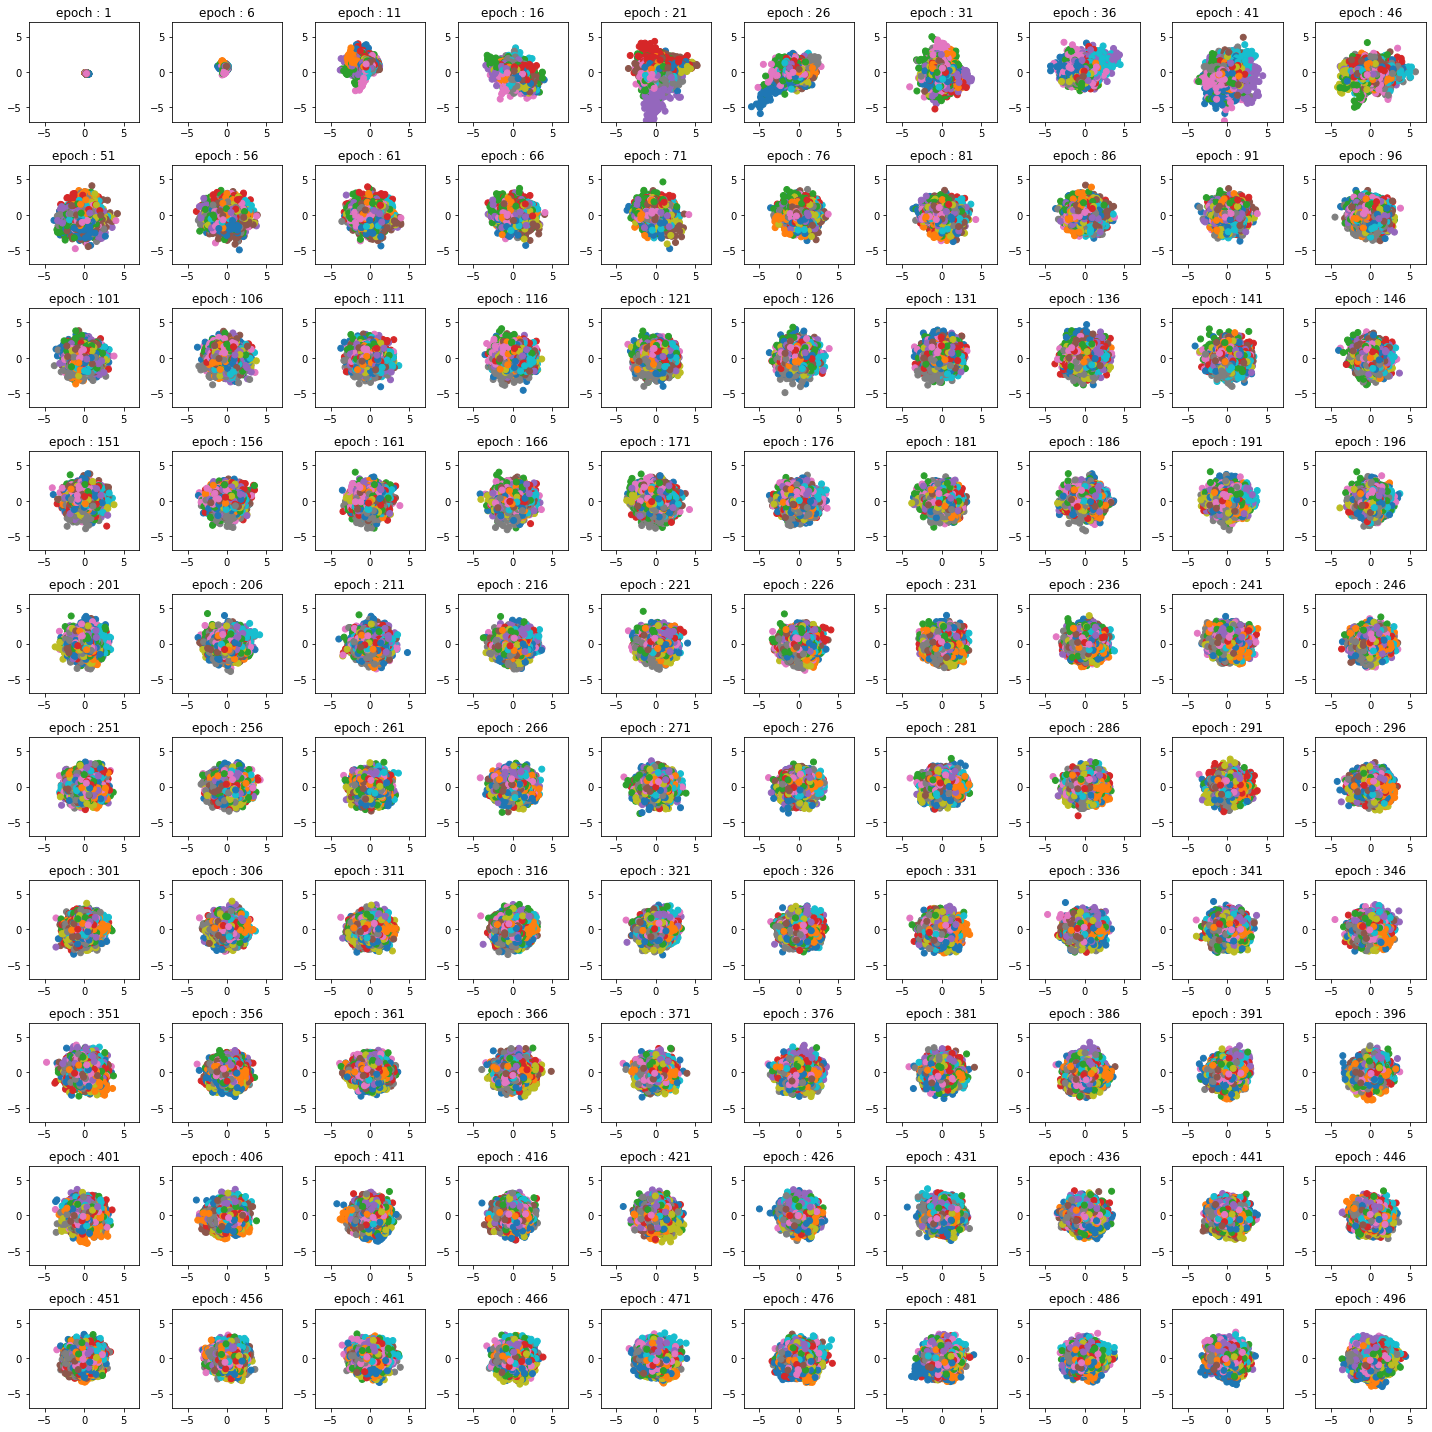

In [76]:
fig, ax = plt.subplots(10, 10, figsize = (20,20))
for i in range(100):
    ax[i//10, i%10].scatter(latent_z_history[i*5][:,0], latent_z_history[i*5][:,1], c = color, cmap = plt.cm.tab10)
    ax[i//10, i%10].set_title(f'epoch : {(i * 5) + 1}')
    ax[i//10, i%10].set_xlim(-7,7)
    ax[i//10, i%10].set_ylim(-7,7)
plt.tight_layout()

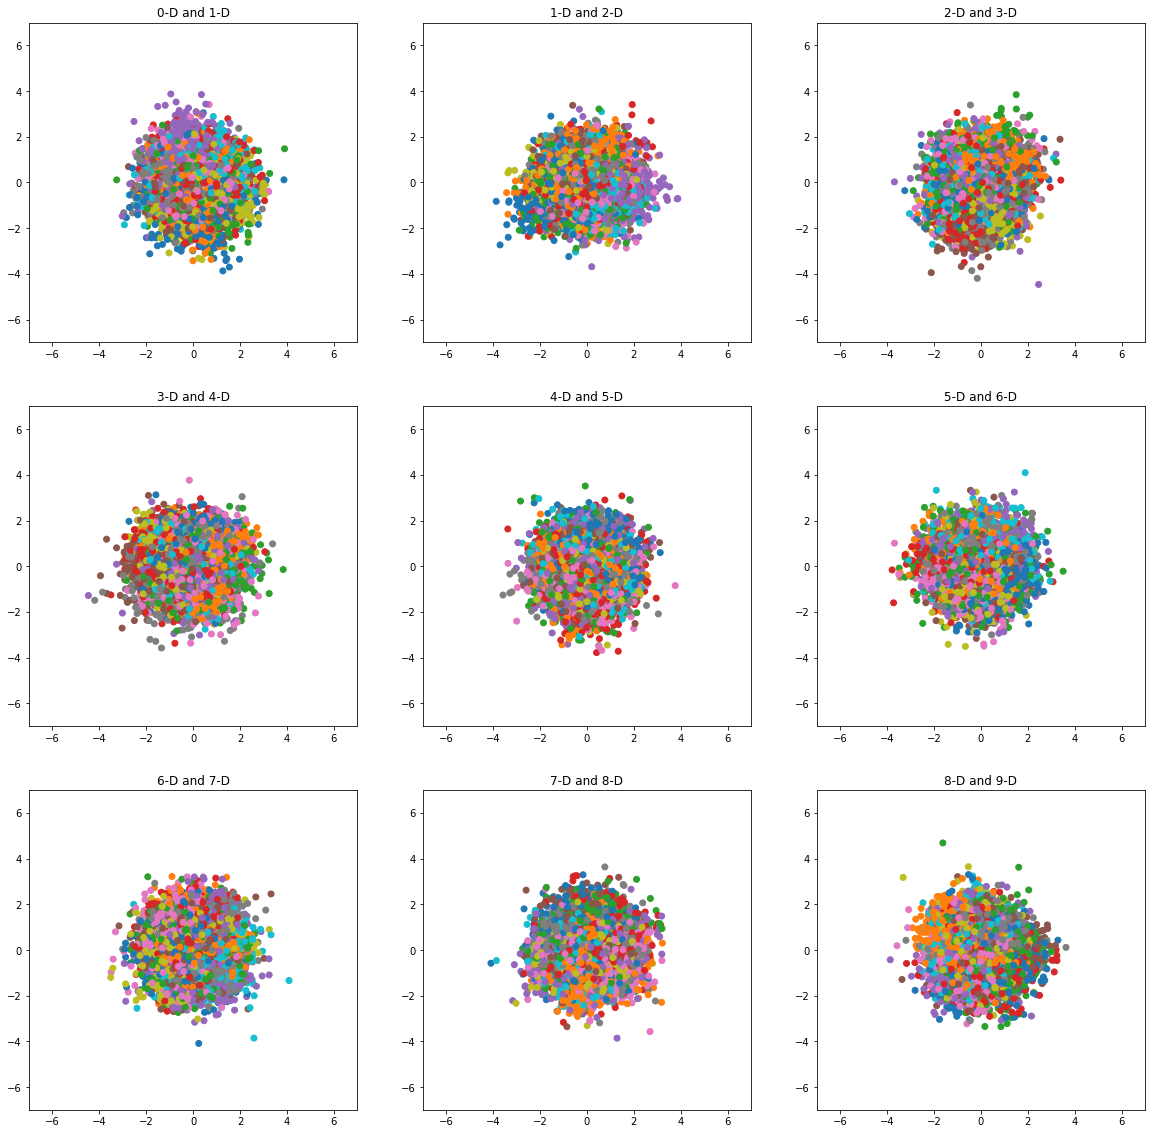

In [77]:
fig, ax = plt.subplots(3,3, figsize = (20, 20))
latent_z, _ = ssaae.encoder(x_test)
for i in range(9):
    ax[i//3, i%3].scatter(latent_z[:,i], latent_z[:,i+1], c = color, cmap = plt.cm.tab10)
    ax[i//3, i%3].set_title(f'{i}-D and {i+1}-D')
    ax[i//3, i%3].set_xlim(-7,7)
    ax[i//3, i%3].set_ylim(-7,7)

Text(0.5, 1.0, 'semi-supervised classification accuacy')

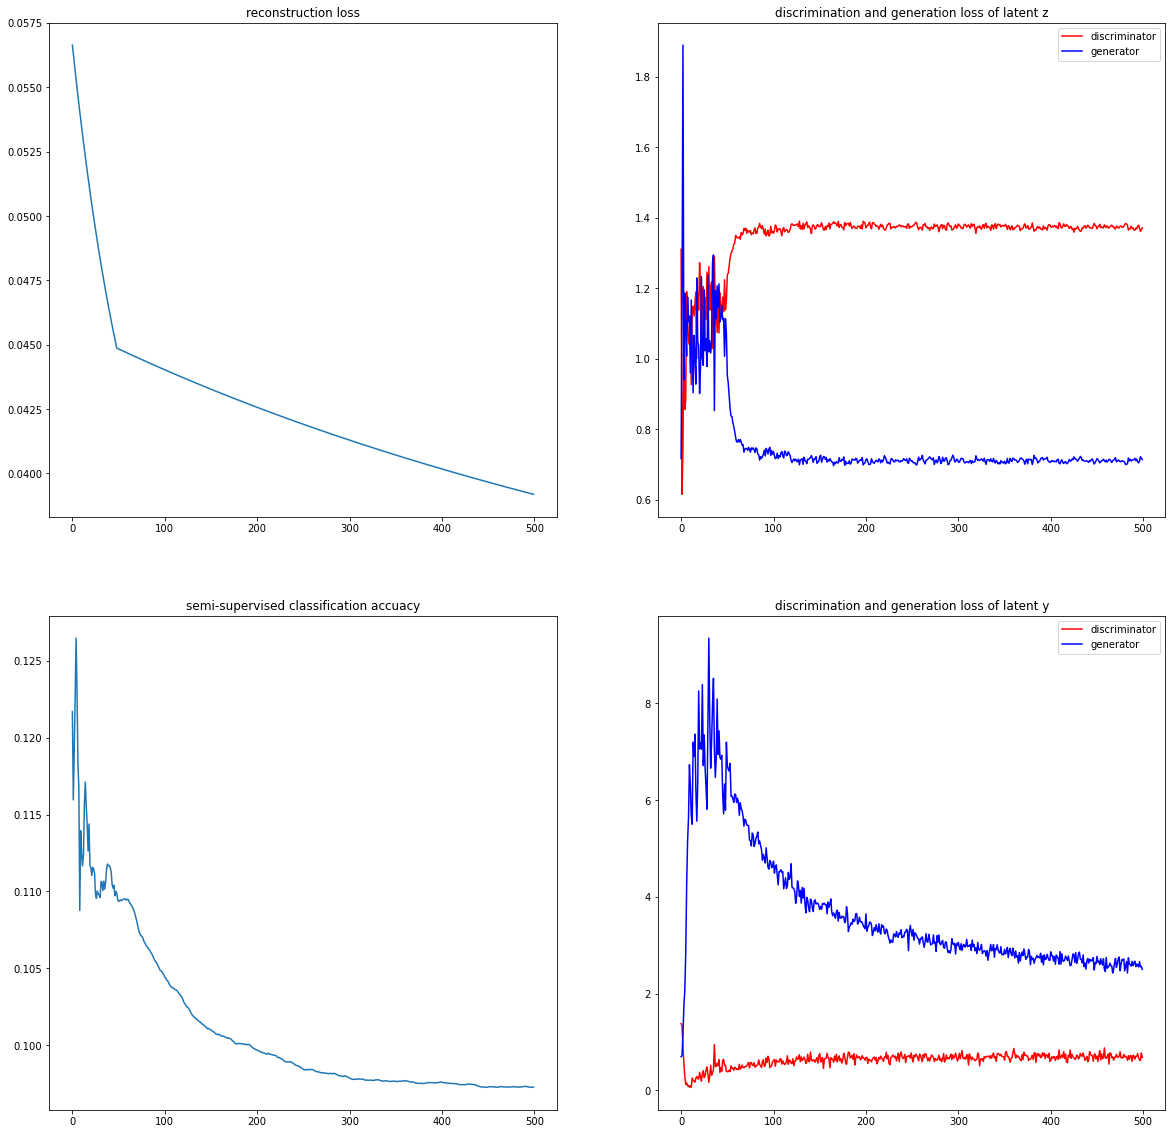

In [78]:
fig, ax = plt.subplots(2,2, figsize = (20,20))


ax[0,0].plot(rh)
ax[0,0].set_title('reconstruction loss')
ax[0,1].plot(dzh, color = 'red', label = 'discriminator')
ax[0,1].plot(gzh, color = 'blue', label = 'generator')
ax[0,1].legend()
ax[0,1].set_title('discrimination and generation loss of latent z')
ax[1,1].plot(dyh, color = 'red', label = 'discriminator')
ax[1,1].plot(gyh, color = 'blue', label = 'generator')
ax[1,1].legend()
ax[1,1].set_title('discrimination and generation loss of latent y')
ax[1,0].plot(ssch)
ax[1,0].set_title('semi-supervised classification accuacy')

https://arxiv.org/pdf/1511.05644.pdf


appendix A:

encoder ,decoder ,discriminator 모두 2 layer, 1000 units, relu  
cost function : half euclidean  
encoder last layer : softmax, linear  
latent_z : 10-D gaussian  
semi supervised classification cost function : CE  
momentum sgd : reconstruction, semi-supervised .9 / discriminator, generator .1  
lr : reconstruction .01  /  semi-supervised, discriminator, generator .1  
gaussian noise stddev .3 for train  
no dropout, l2reg, gaussian noise for other layers  
bn does not helps  

<h2>latent_z도 gaussian distribution 을 잘 따라가고있는것으로 보이면 reconstruction, regularization까지는 잘되는것같은데 semi-supervised classification이 잘안됨. 아무리봐도 어딜 고쳐야할지 잘모르겠음.</h2>  
lr appendix그대로넣었는데 계속 발산해서 1/10으로 줄임